In [2]:
import os, sys
os.chdir('/home/seigyo/Documents/pytorch/brain_decoder')
sys.path.append(os.pardir)
import numpy as np
from numpy.random import RandomState
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import mne
from mne.io import concatenate_raws
from mymodule.utils import data_loader, evaluator
from mymodule.layers import LSTM, Residual_block, Res_net, Wavelet_cnn, NlayersSeqConvLSTM
from mymodule.trainer import Trainer
from mymodule.optim import Eve, YFOptimizer
from sklearn.utils import shuffle
from tensorboardX import SummaryWriter
from load_data import get_data, get_data_multi, get_crops, get_crops_multi
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

epochs = 300
batch_size = 10
cv_splits = 5
torch.manual_seed(1214)
torch.cuda.manual_seed_all(1214)
num_of_subjects = 30
subject_id = range(40,70)



class Conv(nn.Module):
  def __init__(self):
    super(Conv, self).__init__()
    self.conv_time = nn.Conv2d(1, 40, (25, 1))
    self.conv_spat = nn.Conv2d(40, 40, (1, 64), bias=False)
    self.batchnorm = nn.BatchNorm2d(40)
    self.pool = nn.AvgPool2d(kernel_size=(75, 1), stride=(15, 1))
    self.dropout = nn.Dropout2d(p=0.5)
    self.conv_class = nn.Conv2d(40, 2, (12, 1))
    self.logsoftmax = nn.LogSoftmax()
    self.score_ave = nn.AdaptiveAvgPool2d((1, 1))

  def forward(self, x):
    h = self.conv_time(x)
    h = self.conv_spat(h)
    h = self.batchnorm(h)
    h = self.pool(h)
    h = self.dropout(h)
    h = self.conv_class(h)
    # h = self.logsoftmax(h)
    h = self.score_ave(h)
    return h.squeeze()

# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def cv_train(model_class, criterion_class, optimizer_class, X, y,
             epoch=100, num_of_cv=10, batch_size=16):
    kf = KFold(n_splits=num_of_cv, shuffle=False)
    accuracy = []
    for train_idx, val_idx in kf.split(X=X, y=y):
        train_x, val_x = X[train_idx], X[val_idx]
        train_y, val_y = y[train_idx], y[val_idx]
        train_loader = data_loader(train_x, train_y, batch_size=batch_size,
                           shuffle=True, gpu=False)
        val_loader = data_loader(val_x, val_y, batch_size=batch_size)
        writer = SummaryWriter()
        model = model_class().cuda()
        criterion = criterion_class()
        optimizer = optimizer_class(model.parameters(), lr=1e-4)
        trainer = Trainer(model, criterion, optimizer,
                  train_loader, val_loader,
                  val_num=1, early_stopping=2,
                  writer=writer, gpu=True, log=False)
        trainer.run(epochs=epoch)
        accuracy.append(trainer.val_best_acc)
    return accuracy


all_accs_list = []
all_mean_list = []
all_var_list = []

for idx in subject_id:
    X, y = get_data(id=idx+1, event_code=[6,10,14], filter=[0.5, 30], t=[0., 4])
    X = X.reshape(X.shape[0], 1, X.shape[1], X.shape[2]).transpose(0,1,3,2)

#     model = Conv_lstm()
#     model.cuda()

    acc = cv_train(Conv, torch.nn.CrossEntropyLoss,
                   torch.optim.Adam, X, y, epoch=epochs,
                   num_of_cv=cv_splits, batch_size=batch_size)

    mean = np.mean(acc)
    var = np.var(acc)
    print('subject{}   mean_acc:{}, var_acc:{}'.format(idx+1, mean, var))

    all_accs_list.append(acc)
    all_mean_list.append(mean)
    all_var_list.append(var)

all_mean = np.mean(all_accs_list)
all_var = np.var(all_accs_list)

print('all subjects  mean_acc:{}, var_acc:{}'.format(all_mean, all_var))

Removing orphaned offset at the beginning of the file.
89 events found
Events id: [1 2 3]
45 matching events found
Not setting metadata
Loading data for 45 events and 641 original time points ...
1 bad epochs dropped
----------start training----------
epoch:1, tr_loss:0.5471, tr_acc:0.6571,   val_loss:0.3127, val_acc:0.8889
epoch:2, tr_loss:0.5397, tr_acc:0.7143,   val_loss:0.3127, val_acc:1.0000
epoch:3, tr_loss:0.5313, tr_acc:0.8000,   val_loss:0.3137, val_acc:0.8889
epoch:4, tr_loss:0.5379, tr_acc:0.8000,   val_loss:0.3155, val_acc:0.8889
epoch:5, tr_loss:0.5241, tr_acc:0.8571,   val_loss:0.3160, val_acc:0.8889
epoch:6, tr_loss:0.5144, tr_acc:0.8571,   val_loss:0.3165, val_acc:0.8889
epoch:7, tr_loss:0.4996, tr_acc:0.8286,   val_loss:0.3171, val_acc:0.7778
epoch:8, tr_loss:0.5072, tr_acc:0.8286,   val_loss:0.3184, val_acc:0.7778
epoch:9, tr_loss:0.4821, tr_acc:0.8857,   val_loss:0.3189, val_acc:0.7778
epoch:10, tr_loss:0.4874, tr_acc:0.9143,   val_loss:0.3182, val_acc:0.7778
epoch:1

epoch:107, tr_loss:0.1051, tr_acc:1.0000,   val_loss:0.5800, val_acc:0.6667
epoch:108, tr_loss:0.0919, tr_acc:1.0000,   val_loss:0.5860, val_acc:0.6667
epoch:109, tr_loss:0.0704, tr_acc:1.0000,   val_loss:0.5699, val_acc:0.5556
epoch:110, tr_loss:0.0957, tr_acc:1.0000,   val_loss:0.5846, val_acc:0.5556
epoch:111, tr_loss:0.0711, tr_acc:1.0000,   val_loss:0.6022, val_acc:0.5556
epoch:112, tr_loss:0.0733, tr_acc:1.0000,   val_loss:0.6345, val_acc:0.5556
epoch:113, tr_loss:0.0946, tr_acc:1.0000,   val_loss:0.6475, val_acc:0.5556
epoch:114, tr_loss:0.1001, tr_acc:1.0000,   val_loss:0.6501, val_acc:0.6667
epoch:115, tr_loss:0.0661, tr_acc:1.0000,   val_loss:0.6330, val_acc:0.5556
epoch:116, tr_loss:0.0964, tr_acc:1.0000,   val_loss:0.6538, val_acc:0.6667
epoch:117, tr_loss:0.0853, tr_acc:1.0000,   val_loss:0.6704, val_acc:0.6667
epoch:118, tr_loss:0.0632, tr_acc:1.0000,   val_loss:0.6523, val_acc:0.5556
epoch:119, tr_loss:0.0608, tr_acc:1.0000,   val_loss:0.6524, val_acc:0.5556
epoch:120, t

epoch:215, tr_loss:0.0473, tr_acc:1.0000,   val_loss:0.8042, val_acc:0.6667
epoch:216, tr_loss:0.0364, tr_acc:1.0000,   val_loss:0.8148, val_acc:0.6667
epoch:217, tr_loss:0.0484, tr_acc:1.0000,   val_loss:0.8239, val_acc:0.6667
epoch:218, tr_loss:0.0370, tr_acc:1.0000,   val_loss:0.8583, val_acc:0.6667
epoch:219, tr_loss:0.0385, tr_acc:1.0000,   val_loss:0.8347, val_acc:0.6667
epoch:220, tr_loss:0.0463, tr_acc:1.0000,   val_loss:0.8590, val_acc:0.6667
epoch:221, tr_loss:0.0502, tr_acc:1.0000,   val_loss:0.8763, val_acc:0.6667
epoch:222, tr_loss:0.0516, tr_acc:1.0000,   val_loss:0.9182, val_acc:0.6667
epoch:223, tr_loss:0.0456, tr_acc:1.0000,   val_loss:0.8830, val_acc:0.6667
epoch:224, tr_loss:0.0444, tr_acc:1.0000,   val_loss:0.8769, val_acc:0.6667
epoch:225, tr_loss:0.0391, tr_acc:1.0000,   val_loss:0.9463, val_acc:0.6667
epoch:226, tr_loss:0.0410, tr_acc:1.0000,   val_loss:0.9347, val_acc:0.5556
epoch:227, tr_loss:0.0355, tr_acc:1.0000,   val_loss:0.8982, val_acc:0.6667
epoch:228, t

epoch:22, tr_loss:0.4136, tr_acc:0.8857,   val_loss:0.3014, val_acc:0.5556
epoch:23, tr_loss:0.4030, tr_acc:0.9143,   val_loss:0.2938, val_acc:0.7778
epoch:24, tr_loss:0.3864, tr_acc:0.8571,   val_loss:0.2825, val_acc:0.8889
epoch:25, tr_loss:0.3775, tr_acc:0.8571,   val_loss:0.2806, val_acc:0.8889
epoch:26, tr_loss:0.3840, tr_acc:0.8571,   val_loss:0.2810, val_acc:0.6667
epoch:27, tr_loss:0.3701, tr_acc:0.8286,   val_loss:0.2783, val_acc:0.6667
epoch:28, tr_loss:0.3518, tr_acc:0.9714,   val_loss:0.2803, val_acc:0.6667
epoch:29, tr_loss:0.3509, tr_acc:0.8571,   val_loss:0.2754, val_acc:0.6667
epoch:30, tr_loss:0.3438, tr_acc:0.9429,   val_loss:0.2615, val_acc:1.0000
epoch:31, tr_loss:0.3387, tr_acc:0.9143,   val_loss:0.2583, val_acc:1.0000
epoch:32, tr_loss:0.3280, tr_acc:0.8857,   val_loss:0.2496, val_acc:0.8889
epoch:33, tr_loss:0.3648, tr_acc:0.8571,   val_loss:0.2488, val_acc:0.7778
epoch:34, tr_loss:0.2930, tr_acc:0.9429,   val_loss:0.2630, val_acc:0.6667
epoch:35, tr_loss:0.3387,

epoch:131, tr_loss:0.0782, tr_acc:1.0000,   val_loss:0.2316, val_acc:0.6667
epoch:132, tr_loss:0.0782, tr_acc:1.0000,   val_loss:0.2539, val_acc:0.6667
epoch:133, tr_loss:0.1281, tr_acc:0.9714,   val_loss:0.2548, val_acc:0.6667
epoch:134, tr_loss:0.0820, tr_acc:0.9714,   val_loss:0.2374, val_acc:0.6667
epoch:135, tr_loss:0.1243, tr_acc:1.0000,   val_loss:0.2292, val_acc:0.7778
epoch:136, tr_loss:0.0761, tr_acc:1.0000,   val_loss:0.2012, val_acc:0.7778
epoch:137, tr_loss:0.1013, tr_acc:1.0000,   val_loss:0.2145, val_acc:0.7778
epoch:138, tr_loss:0.0884, tr_acc:1.0000,   val_loss:0.2524, val_acc:0.6667
epoch:139, tr_loss:0.1157, tr_acc:1.0000,   val_loss:0.2710, val_acc:0.6667
epoch:140, tr_loss:0.0719, tr_acc:1.0000,   val_loss:0.2540, val_acc:0.6667
epoch:141, tr_loss:0.0975, tr_acc:1.0000,   val_loss:0.2609, val_acc:0.6667
epoch:142, tr_loss:0.0745, tr_acc:1.0000,   val_loss:0.3302, val_acc:0.6667
epoch:143, tr_loss:0.0886, tr_acc:1.0000,   val_loss:0.3060, val_acc:0.6667
epoch:144, t

epoch:239, tr_loss:0.0474, tr_acc:1.0000,   val_loss:0.2364, val_acc:0.7778
epoch:240, tr_loss:0.0426, tr_acc:1.0000,   val_loss:0.2780, val_acc:0.6667
epoch:241, tr_loss:0.0351, tr_acc:1.0000,   val_loss:0.2829, val_acc:0.6667
epoch:242, tr_loss:0.1002, tr_acc:0.9714,   val_loss:0.2807, val_acc:0.6667
epoch:243, tr_loss:0.0321, tr_acc:1.0000,   val_loss:0.3012, val_acc:0.6667
epoch:244, tr_loss:0.0393, tr_acc:1.0000,   val_loss:0.2666, val_acc:0.6667
epoch:245, tr_loss:0.0531, tr_acc:1.0000,   val_loss:0.2287, val_acc:0.7778
epoch:246, tr_loss:0.0460, tr_acc:1.0000,   val_loss:0.2174, val_acc:0.7778
epoch:247, tr_loss:0.0413, tr_acc:1.0000,   val_loss:0.2346, val_acc:0.7778
epoch:248, tr_loss:0.0436, tr_acc:1.0000,   val_loss:0.2718, val_acc:0.6667
epoch:249, tr_loss:0.0381, tr_acc:1.0000,   val_loss:0.2916, val_acc:0.6667
epoch:250, tr_loss:0.0366, tr_acc:1.0000,   val_loss:0.2638, val_acc:0.6667
epoch:251, tr_loss:0.0349, tr_acc:1.0000,   val_loss:0.2673, val_acc:0.6667
epoch:252, t

epoch:47, tr_loss:0.2017, tr_acc:1.0000,   val_loss:0.3388, val_acc:0.6667
epoch:48, tr_loss:0.2064, tr_acc:0.9429,   val_loss:0.3443, val_acc:0.6667
epoch:49, tr_loss:0.2253, tr_acc:0.9714,   val_loss:0.3432, val_acc:0.6667
epoch:50, tr_loss:0.1800, tr_acc:0.9714,   val_loss:0.3421, val_acc:0.6667
epoch:51, tr_loss:0.1909, tr_acc:0.9429,   val_loss:0.3445, val_acc:0.6667
epoch:52, tr_loss:0.1708, tr_acc:0.9714,   val_loss:0.3445, val_acc:0.6667
epoch:53, tr_loss:0.1877, tr_acc:0.9429,   val_loss:0.3426, val_acc:0.6667
epoch:54, tr_loss:0.1688, tr_acc:1.0000,   val_loss:0.3419, val_acc:0.6667
epoch:55, tr_loss:0.1833, tr_acc:0.9714,   val_loss:0.3444, val_acc:0.6667
epoch:56, tr_loss:0.1830, tr_acc:1.0000,   val_loss:0.3469, val_acc:0.6667
epoch:57, tr_loss:0.1543, tr_acc:1.0000,   val_loss:0.3482, val_acc:0.6667
epoch:58, tr_loss:0.1341, tr_acc:1.0000,   val_loss:0.3498, val_acc:0.6667
epoch:59, tr_loss:0.1552, tr_acc:1.0000,   val_loss:0.3503, val_acc:0.6667
epoch:60, tr_loss:0.1690,

epoch:157, tr_loss:0.0343, tr_acc:1.0000,   val_loss:0.6084, val_acc:0.6667
epoch:158, tr_loss:0.0487, tr_acc:1.0000,   val_loss:0.6266, val_acc:0.6667
epoch:159, tr_loss:0.0545, tr_acc:1.0000,   val_loss:0.6387, val_acc:0.6667
epoch:160, tr_loss:0.0875, tr_acc:0.9714,   val_loss:0.6425, val_acc:0.6667
epoch:161, tr_loss:0.0534, tr_acc:1.0000,   val_loss:0.6101, val_acc:0.6667
epoch:162, tr_loss:0.0483, tr_acc:1.0000,   val_loss:0.6006, val_acc:0.6667
epoch:163, tr_loss:0.0520, tr_acc:1.0000,   val_loss:0.6001, val_acc:0.6667
epoch:164, tr_loss:0.0337, tr_acc:1.0000,   val_loss:0.5875, val_acc:0.6667
epoch:165, tr_loss:0.0537, tr_acc:1.0000,   val_loss:0.5725, val_acc:0.6667
epoch:166, tr_loss:0.0410, tr_acc:1.0000,   val_loss:0.5690, val_acc:0.6667
epoch:167, tr_loss:0.0572, tr_acc:1.0000,   val_loss:0.5854, val_acc:0.6667
epoch:168, tr_loss:0.1580, tr_acc:0.9143,   val_loss:0.5809, val_acc:0.6667
epoch:169, tr_loss:0.0482, tr_acc:1.0000,   val_loss:0.5649, val_acc:0.6667
epoch:170, t

epoch:267, tr_loss:0.0334, tr_acc:1.0000,   val_loss:0.7129, val_acc:0.6667
epoch:268, tr_loss:0.0257, tr_acc:1.0000,   val_loss:0.7259, val_acc:0.6667
epoch:269, tr_loss:0.0202, tr_acc:1.0000,   val_loss:0.7452, val_acc:0.6667
epoch:270, tr_loss:0.0171, tr_acc:1.0000,   val_loss:0.7646, val_acc:0.6667
epoch:271, tr_loss:0.0192, tr_acc:1.0000,   val_loss:0.7833, val_acc:0.6667
epoch:272, tr_loss:0.0214, tr_acc:1.0000,   val_loss:0.7873, val_acc:0.6667
epoch:273, tr_loss:0.0705, tr_acc:0.9714,   val_loss:0.8003, val_acc:0.6667
epoch:274, tr_loss:0.0413, tr_acc:1.0000,   val_loss:0.8129, val_acc:0.6667
epoch:275, tr_loss:0.0409, tr_acc:1.0000,   val_loss:0.7846, val_acc:0.6667
epoch:276, tr_loss:0.0173, tr_acc:1.0000,   val_loss:0.7631, val_acc:0.6667
epoch:277, tr_loss:0.0358, tr_acc:1.0000,   val_loss:0.7547, val_acc:0.6667
epoch:278, tr_loss:0.0266, tr_acc:1.0000,   val_loss:0.7700, val_acc:0.6667
epoch:279, tr_loss:0.0542, tr_acc:0.9714,   val_loss:0.7929, val_acc:0.6667
epoch:280, t

epoch:75, tr_loss:0.1642, tr_acc:1.0000,   val_loss:0.4074, val_acc:0.5556
epoch:76, tr_loss:0.2034, tr_acc:0.9429,   val_loss:0.3975, val_acc:0.5556
epoch:77, tr_loss:0.1460, tr_acc:1.0000,   val_loss:0.4208, val_acc:0.5556
epoch:78, tr_loss:0.1748, tr_acc:1.0000,   val_loss:0.4201, val_acc:0.5556
epoch:79, tr_loss:0.1512, tr_acc:1.0000,   val_loss:0.4076, val_acc:0.5556
epoch:80, tr_loss:0.1559, tr_acc:1.0000,   val_loss:0.3842, val_acc:0.5556
epoch:81, tr_loss:0.1496, tr_acc:1.0000,   val_loss:0.3874, val_acc:0.5556
epoch:82, tr_loss:0.1509, tr_acc:1.0000,   val_loss:0.4263, val_acc:0.5556
epoch:83, tr_loss:0.1430, tr_acc:1.0000,   val_loss:0.4156, val_acc:0.5556
epoch:84, tr_loss:0.1113, tr_acc:1.0000,   val_loss:0.3996, val_acc:0.5556
epoch:85, tr_loss:0.1266, tr_acc:1.0000,   val_loss:0.4153, val_acc:0.5556
epoch:86, tr_loss:0.1064, tr_acc:1.0000,   val_loss:0.4202, val_acc:0.5556
epoch:87, tr_loss:0.1437, tr_acc:1.0000,   val_loss:0.4333, val_acc:0.5556
epoch:88, tr_loss:0.1483,

epoch:185, tr_loss:0.0581, tr_acc:1.0000,   val_loss:0.8230, val_acc:0.4444
epoch:186, tr_loss:0.0485, tr_acc:1.0000,   val_loss:0.8603, val_acc:0.4444
epoch:187, tr_loss:0.0360, tr_acc:1.0000,   val_loss:0.8687, val_acc:0.4444
epoch:188, tr_loss:0.0323, tr_acc:1.0000,   val_loss:0.8369, val_acc:0.4444
epoch:189, tr_loss:0.1142, tr_acc:0.9714,   val_loss:0.8369, val_acc:0.4444
epoch:190, tr_loss:0.0929, tr_acc:0.9714,   val_loss:0.8227, val_acc:0.4444
epoch:191, tr_loss:0.0274, tr_acc:1.0000,   val_loss:0.8960, val_acc:0.4444
epoch:192, tr_loss:0.0919, tr_acc:0.9714,   val_loss:0.8596, val_acc:0.4444
epoch:193, tr_loss:0.0596, tr_acc:1.0000,   val_loss:0.7359, val_acc:0.4444
epoch:194, tr_loss:0.0443, tr_acc:1.0000,   val_loss:0.7398, val_acc:0.4444
epoch:195, tr_loss:0.0490, tr_acc:1.0000,   val_loss:0.7742, val_acc:0.4444
epoch:196, tr_loss:0.0601, tr_acc:1.0000,   val_loss:0.7539, val_acc:0.4444
epoch:197, tr_loss:0.0330, tr_acc:1.0000,   val_loss:0.7876, val_acc:0.4444
epoch:198, t

epoch:293, tr_loss:0.0194, tr_acc:1.0000,   val_loss:1.1278, val_acc:0.4444
epoch:294, tr_loss:0.0171, tr_acc:1.0000,   val_loss:1.1779, val_acc:0.4444
epoch:295, tr_loss:0.0174, tr_acc:1.0000,   val_loss:1.1382, val_acc:0.4444
epoch:296, tr_loss:0.0205, tr_acc:1.0000,   val_loss:1.1790, val_acc:0.4444
epoch:297, tr_loss:0.0186, tr_acc:1.0000,   val_loss:1.1497, val_acc:0.4444
epoch:298, tr_loss:0.0351, tr_acc:1.0000,   val_loss:1.2046, val_acc:0.4444
epoch:299, tr_loss:0.0220, tr_acc:1.0000,   val_loss:1.2200, val_acc:0.4444
epoch:300, tr_loss:0.0104, tr_acc:1.0000,   val_loss:1.2000, val_acc:0.4444
----------finish training---------
training_best_acc:1.0, val_best_acc:0.8888888888888888
----------start training----------
epoch:1, tr_loss:0.5542, tr_acc:0.5278,   val_loss:0.3233, val_acc:0.8750
epoch:2, tr_loss:0.5407, tr_acc:0.7222,   val_loss:0.3224, val_acc:0.8750
epoch:3, tr_loss:0.5388, tr_acc:0.8056,   val_loss:0.3218, val_acc:0.8750
epoch:4, tr_loss:0.5267, tr_acc:0.7778,   val

epoch:102, tr_loss:0.1277, tr_acc:1.0000,   val_loss:0.3672, val_acc:0.6250
epoch:103, tr_loss:0.1266, tr_acc:1.0000,   val_loss:0.3792, val_acc:0.6250
epoch:104, tr_loss:0.1149, tr_acc:1.0000,   val_loss:0.3721, val_acc:0.6250
epoch:105, tr_loss:0.1044, tr_acc:1.0000,   val_loss:0.3770, val_acc:0.6250
epoch:106, tr_loss:0.1174, tr_acc:1.0000,   val_loss:0.3714, val_acc:0.6250
epoch:107, tr_loss:0.1255, tr_acc:0.9722,   val_loss:0.3819, val_acc:0.6250
epoch:108, tr_loss:0.1210, tr_acc:1.0000,   val_loss:0.3917, val_acc:0.6250
epoch:109, tr_loss:0.1515, tr_acc:0.9722,   val_loss:0.3818, val_acc:0.6250
epoch:110, tr_loss:0.1022, tr_acc:1.0000,   val_loss:0.3468, val_acc:0.6250
epoch:111, tr_loss:0.1205, tr_acc:0.9722,   val_loss:0.3371, val_acc:0.6250
epoch:112, tr_loss:0.1124, tr_acc:1.0000,   val_loss:0.3426, val_acc:0.6250
epoch:113, tr_loss:0.1057, tr_acc:1.0000,   val_loss:0.3555, val_acc:0.6250
epoch:114, tr_loss:0.1113, tr_acc:1.0000,   val_loss:0.3580, val_acc:0.6250
epoch:115, t

epoch:210, tr_loss:0.0559, tr_acc:1.0000,   val_loss:0.5788, val_acc:0.6250
epoch:211, tr_loss:0.0320, tr_acc:1.0000,   val_loss:0.5312, val_acc:0.6250
epoch:212, tr_loss:0.0377, tr_acc:1.0000,   val_loss:0.5061, val_acc:0.6250
epoch:213, tr_loss:0.0494, tr_acc:1.0000,   val_loss:0.4958, val_acc:0.6250
epoch:214, tr_loss:0.1127, tr_acc:0.9722,   val_loss:0.5262, val_acc:0.6250
epoch:215, tr_loss:0.0667, tr_acc:1.0000,   val_loss:0.5035, val_acc:0.6250
epoch:216, tr_loss:0.0676, tr_acc:1.0000,   val_loss:0.4813, val_acc:0.6250
epoch:217, tr_loss:0.0719, tr_acc:1.0000,   val_loss:0.4675, val_acc:0.6250
epoch:218, tr_loss:0.0619, tr_acc:1.0000,   val_loss:0.4925, val_acc:0.6250
epoch:219, tr_loss:0.0528, tr_acc:1.0000,   val_loss:0.5079, val_acc:0.6250
epoch:220, tr_loss:0.0351, tr_acc:1.0000,   val_loss:0.5347, val_acc:0.6250
epoch:221, tr_loss:0.0399, tr_acc:1.0000,   val_loss:0.5708, val_acc:0.6250
epoch:222, tr_loss:0.0462, tr_acc:1.0000,   val_loss:0.5772, val_acc:0.6250
epoch:223, t

epoch:13, tr_loss:0.4714, tr_acc:0.7778,   val_loss:0.3167, val_acc:0.5556
epoch:14, tr_loss:0.4667, tr_acc:0.8333,   val_loss:0.3164, val_acc:0.6667
epoch:15, tr_loss:0.4614, tr_acc:0.8611,   val_loss:0.3149, val_acc:0.6667
epoch:16, tr_loss:0.4746, tr_acc:0.8889,   val_loss:0.3149, val_acc:0.7778
epoch:17, tr_loss:0.4665, tr_acc:0.8611,   val_loss:0.3146, val_acc:0.7778
epoch:18, tr_loss:0.4447, tr_acc:0.8611,   val_loss:0.3136, val_acc:0.7778
epoch:19, tr_loss:0.4373, tr_acc:0.8056,   val_loss:0.3136, val_acc:0.7778
epoch:20, tr_loss:0.4425, tr_acc:0.8056,   val_loss:0.3133, val_acc:0.7778
epoch:21, tr_loss:0.4259, tr_acc:0.8333,   val_loss:0.3117, val_acc:0.7778
epoch:22, tr_loss:0.4238, tr_acc:0.8611,   val_loss:0.3112, val_acc:0.7778
epoch:23, tr_loss:0.4235, tr_acc:0.8611,   val_loss:0.3131, val_acc:0.7778
epoch:24, tr_loss:0.4294, tr_acc:0.7778,   val_loss:0.3154, val_acc:0.7778
epoch:25, tr_loss:0.4182, tr_acc:0.8611,   val_loss:0.3128, val_acc:0.7778
epoch:26, tr_loss:0.4008,

epoch:123, tr_loss:0.0709, tr_acc:1.0000,   val_loss:0.4771, val_acc:0.4444
epoch:124, tr_loss:0.0874, tr_acc:1.0000,   val_loss:0.4689, val_acc:0.4444
epoch:125, tr_loss:0.0716, tr_acc:1.0000,   val_loss:0.4026, val_acc:0.6667
epoch:126, tr_loss:0.1031, tr_acc:1.0000,   val_loss:0.3890, val_acc:0.6667
epoch:127, tr_loss:0.0827, tr_acc:1.0000,   val_loss:0.4359, val_acc:0.4444
epoch:128, tr_loss:0.0744, tr_acc:1.0000,   val_loss:0.4480, val_acc:0.4444
epoch:129, tr_loss:0.0714, tr_acc:1.0000,   val_loss:0.4351, val_acc:0.5556
epoch:130, tr_loss:0.0841, tr_acc:1.0000,   val_loss:0.4373, val_acc:0.5556
epoch:131, tr_loss:0.0811, tr_acc:1.0000,   val_loss:0.4682, val_acc:0.5556
epoch:132, tr_loss:0.0784, tr_acc:1.0000,   val_loss:0.4745, val_acc:0.4444
epoch:133, tr_loss:0.0608, tr_acc:1.0000,   val_loss:0.4436, val_acc:0.7778
epoch:134, tr_loss:0.0644, tr_acc:1.0000,   val_loss:0.4437, val_acc:0.7778
epoch:135, tr_loss:0.0650, tr_acc:1.0000,   val_loss:0.4534, val_acc:0.7778
epoch:136, t

epoch:231, tr_loss:0.0239, tr_acc:1.0000,   val_loss:0.6100, val_acc:0.5556
epoch:232, tr_loss:0.0185, tr_acc:1.0000,   val_loss:0.5953, val_acc:0.5556
epoch:233, tr_loss:0.0213, tr_acc:1.0000,   val_loss:0.5621, val_acc:0.6667
epoch:234, tr_loss:0.0176, tr_acc:1.0000,   val_loss:0.5475, val_acc:0.6667
epoch:235, tr_loss:0.0321, tr_acc:1.0000,   val_loss:0.5781, val_acc:0.6667
epoch:236, tr_loss:0.0273, tr_acc:1.0000,   val_loss:0.6026, val_acc:0.5556
epoch:237, tr_loss:0.0222, tr_acc:1.0000,   val_loss:0.6045, val_acc:0.6667
epoch:238, tr_loss:0.0287, tr_acc:1.0000,   val_loss:0.6249, val_acc:0.6667
epoch:239, tr_loss:0.0240, tr_acc:1.0000,   val_loss:0.6506, val_acc:0.5556
epoch:240, tr_loss:0.0185, tr_acc:1.0000,   val_loss:0.5972, val_acc:0.6667
epoch:241, tr_loss:0.0300, tr_acc:1.0000,   val_loss:0.5740, val_acc:0.6667
epoch:242, tr_loss:0.0213, tr_acc:1.0000,   val_loss:0.6061, val_acc:0.5556
epoch:243, tr_loss:0.0235, tr_acc:1.0000,   val_loss:0.6231, val_acc:0.5556
epoch:244, t

epoch:38, tr_loss:0.2834, tr_acc:1.0000,   val_loss:0.4293, val_acc:0.2222
epoch:39, tr_loss:0.2953, tr_acc:1.0000,   val_loss:0.4390, val_acc:0.2222
epoch:40, tr_loss:0.2904, tr_acc:1.0000,   val_loss:0.4510, val_acc:0.2222
epoch:41, tr_loss:0.2888, tr_acc:1.0000,   val_loss:0.4496, val_acc:0.2222
epoch:42, tr_loss:0.2863, tr_acc:1.0000,   val_loss:0.4533, val_acc:0.2222
epoch:43, tr_loss:0.2569, tr_acc:1.0000,   val_loss:0.4600, val_acc:0.2222
epoch:44, tr_loss:0.2653, tr_acc:1.0000,   val_loss:0.4676, val_acc:0.2222
epoch:45, tr_loss:0.2683, tr_acc:0.9722,   val_loss:0.4772, val_acc:0.2222
epoch:46, tr_loss:0.2667, tr_acc:0.9722,   val_loss:0.4892, val_acc:0.2222
epoch:47, tr_loss:0.2599, tr_acc:1.0000,   val_loss:0.4823, val_acc:0.2222
epoch:48, tr_loss:0.2470, tr_acc:1.0000,   val_loss:0.4715, val_acc:0.2222
epoch:49, tr_loss:0.2558, tr_acc:1.0000,   val_loss:0.4731, val_acc:0.2222
epoch:50, tr_loss:0.2426, tr_acc:1.0000,   val_loss:0.4846, val_acc:0.2222
epoch:51, tr_loss:0.2182,

epoch:147, tr_loss:0.0424, tr_acc:1.0000,   val_loss:1.1634, val_acc:0.3333
epoch:148, tr_loss:0.0615, tr_acc:1.0000,   val_loss:1.1417, val_acc:0.3333
epoch:149, tr_loss:0.0446, tr_acc:1.0000,   val_loss:1.0355, val_acc:0.2222
epoch:150, tr_loss:0.0580, tr_acc:1.0000,   val_loss:0.9995, val_acc:0.3333
epoch:151, tr_loss:0.0425, tr_acc:1.0000,   val_loss:1.0641, val_acc:0.3333
epoch:152, tr_loss:0.0427, tr_acc:1.0000,   val_loss:1.1109, val_acc:0.3333
epoch:153, tr_loss:0.0468, tr_acc:1.0000,   val_loss:1.1384, val_acc:0.3333
epoch:154, tr_loss:0.0382, tr_acc:1.0000,   val_loss:1.1635, val_acc:0.3333
epoch:155, tr_loss:0.0406, tr_acc:1.0000,   val_loss:1.1497, val_acc:0.2222
epoch:156, tr_loss:0.0390, tr_acc:1.0000,   val_loss:1.1529, val_acc:0.3333
epoch:157, tr_loss:0.0377, tr_acc:1.0000,   val_loss:1.1825, val_acc:0.3333
epoch:158, tr_loss:0.0522, tr_acc:1.0000,   val_loss:1.1666, val_acc:0.3333
epoch:159, tr_loss:0.0369, tr_acc:1.0000,   val_loss:1.1955, val_acc:0.3333
epoch:160, t

epoch:255, tr_loss:0.0182, tr_acc:1.0000,   val_loss:1.4947, val_acc:0.3333
epoch:256, tr_loss:0.0196, tr_acc:1.0000,   val_loss:1.4727, val_acc:0.3333
epoch:257, tr_loss:0.0202, tr_acc:1.0000,   val_loss:1.4643, val_acc:0.2222
epoch:258, tr_loss:0.0257, tr_acc:1.0000,   val_loss:1.4204, val_acc:0.3333
epoch:259, tr_loss:0.0321, tr_acc:1.0000,   val_loss:1.3844, val_acc:0.3333
epoch:260, tr_loss:0.0166, tr_acc:1.0000,   val_loss:1.4201, val_acc:0.3333
epoch:261, tr_loss:0.0184, tr_acc:1.0000,   val_loss:1.4413, val_acc:0.3333
epoch:262, tr_loss:0.0193, tr_acc:1.0000,   val_loss:1.4594, val_acc:0.2222
epoch:263, tr_loss:0.0165, tr_acc:1.0000,   val_loss:1.4845, val_acc:0.2222
epoch:264, tr_loss:0.0190, tr_acc:1.0000,   val_loss:1.5233, val_acc:0.3333
epoch:265, tr_loss:0.0163, tr_acc:1.0000,   val_loss:1.5159, val_acc:0.3333
epoch:266, tr_loss:0.0172, tr_acc:1.0000,   val_loss:1.4719, val_acc:0.2222
epoch:267, tr_loss:0.0262, tr_acc:1.0000,   val_loss:1.4714, val_acc:0.2222
epoch:268, t

epoch:63, tr_loss:0.1630, tr_acc:0.9722,   val_loss:0.5499, val_acc:0.3333
epoch:64, tr_loss:0.1689, tr_acc:0.9444,   val_loss:0.5312, val_acc:0.3333
epoch:65, tr_loss:0.1730, tr_acc:0.9722,   val_loss:0.5188, val_acc:0.4444
epoch:66, tr_loss:0.1684, tr_acc:0.9444,   val_loss:0.5419, val_acc:0.3333
epoch:67, tr_loss:0.1594, tr_acc:0.9722,   val_loss:0.5310, val_acc:0.3333
epoch:68, tr_loss:0.1672, tr_acc:0.9444,   val_loss:0.5569, val_acc:0.3333
epoch:69, tr_loss:0.1370, tr_acc:1.0000,   val_loss:0.5570, val_acc:0.3333
epoch:70, tr_loss:0.1363, tr_acc:0.9722,   val_loss:0.5394, val_acc:0.3333
epoch:71, tr_loss:0.1414, tr_acc:0.9444,   val_loss:0.5285, val_acc:0.2222
epoch:72, tr_loss:0.1374, tr_acc:0.9722,   val_loss:0.5583, val_acc:0.2222
epoch:73, tr_loss:0.1340, tr_acc:0.9722,   val_loss:0.5703, val_acc:0.3333
epoch:74, tr_loss:0.1447, tr_acc:0.9722,   val_loss:0.5792, val_acc:0.4444
epoch:75, tr_loss:0.1355, tr_acc:1.0000,   val_loss:0.5923, val_acc:0.3333
epoch:76, tr_loss:0.1456,

epoch:172, tr_loss:0.0345, tr_acc:1.0000,   val_loss:0.9698, val_acc:0.2222
epoch:173, tr_loss:0.0423, tr_acc:1.0000,   val_loss:0.9443, val_acc:0.2222
epoch:174, tr_loss:0.0449, tr_acc:1.0000,   val_loss:0.9983, val_acc:0.2222
epoch:175, tr_loss:0.0352, tr_acc:1.0000,   val_loss:1.0052, val_acc:0.2222
epoch:176, tr_loss:0.0280, tr_acc:1.0000,   val_loss:0.9101, val_acc:0.3333
epoch:177, tr_loss:0.0293, tr_acc:1.0000,   val_loss:0.8553, val_acc:0.2222
epoch:178, tr_loss:0.0324, tr_acc:1.0000,   val_loss:0.8642, val_acc:0.2222
epoch:179, tr_loss:0.0276, tr_acc:1.0000,   val_loss:0.9224, val_acc:0.3333
epoch:180, tr_loss:0.0329, tr_acc:1.0000,   val_loss:0.9778, val_acc:0.3333
epoch:181, tr_loss:0.0295, tr_acc:1.0000,   val_loss:0.9582, val_acc:0.3333
epoch:182, tr_loss:0.0291, tr_acc:1.0000,   val_loss:0.9127, val_acc:0.2222
epoch:183, tr_loss:0.0279, tr_acc:1.0000,   val_loss:0.9013, val_acc:0.2222
epoch:184, tr_loss:0.0224, tr_acc:1.0000,   val_loss:0.9221, val_acc:0.2222
epoch:185, t

epoch:280, tr_loss:0.0101, tr_acc:1.0000,   val_loss:1.2313, val_acc:0.2222
epoch:281, tr_loss:0.0110, tr_acc:1.0000,   val_loss:1.2779, val_acc:0.2222
epoch:282, tr_loss:0.0115, tr_acc:1.0000,   val_loss:1.2929, val_acc:0.2222
epoch:283, tr_loss:0.0126, tr_acc:1.0000,   val_loss:1.2518, val_acc:0.2222
epoch:284, tr_loss:0.0072, tr_acc:1.0000,   val_loss:1.1937, val_acc:0.2222
epoch:285, tr_loss:0.0179, tr_acc:1.0000,   val_loss:1.1941, val_acc:0.2222
epoch:286, tr_loss:0.0086, tr_acc:1.0000,   val_loss:1.2347, val_acc:0.2222
epoch:287, tr_loss:0.0084, tr_acc:1.0000,   val_loss:1.2752, val_acc:0.2222
epoch:288, tr_loss:0.0144, tr_acc:1.0000,   val_loss:1.2697, val_acc:0.2222
epoch:289, tr_loss:0.0073, tr_acc:1.0000,   val_loss:1.1817, val_acc:0.2222
epoch:290, tr_loss:0.0170, tr_acc:1.0000,   val_loss:1.1762, val_acc:0.2222
epoch:291, tr_loss:0.0156, tr_acc:1.0000,   val_loss:1.1911, val_acc:0.2222
epoch:292, tr_loss:0.0127, tr_acc:1.0000,   val_loss:1.2012, val_acc:0.2222
epoch:293, t

epoch:87, tr_loss:0.1423, tr_acc:1.0000,   val_loss:0.4101, val_acc:0.5556
epoch:88, tr_loss:0.1841, tr_acc:0.9722,   val_loss:0.3987, val_acc:0.5556
epoch:89, tr_loss:0.1367, tr_acc:0.9722,   val_loss:0.3915, val_acc:0.5556
epoch:90, tr_loss:0.1317, tr_acc:0.9722,   val_loss:0.3887, val_acc:0.5556
epoch:91, tr_loss:0.1404, tr_acc:1.0000,   val_loss:0.3921, val_acc:0.5556
epoch:92, tr_loss:0.1274, tr_acc:1.0000,   val_loss:0.3994, val_acc:0.5556
epoch:93, tr_loss:0.1451, tr_acc:1.0000,   val_loss:0.4005, val_acc:0.5556
epoch:94, tr_loss:0.1245, tr_acc:1.0000,   val_loss:0.4020, val_acc:0.5556
epoch:95, tr_loss:0.1341, tr_acc:1.0000,   val_loss:0.4075, val_acc:0.5556
epoch:96, tr_loss:0.1236, tr_acc:1.0000,   val_loss:0.4132, val_acc:0.5556
epoch:97, tr_loss:0.1316, tr_acc:1.0000,   val_loss:0.4117, val_acc:0.5556
epoch:98, tr_loss:0.1218, tr_acc:1.0000,   val_loss:0.4144, val_acc:0.5556
epoch:99, tr_loss:0.1181, tr_acc:1.0000,   val_loss:0.4177, val_acc:0.5556
epoch:100, tr_loss:0.1203

epoch:195, tr_loss:0.0371, tr_acc:1.0000,   val_loss:0.5171, val_acc:0.5556
epoch:196, tr_loss:0.0382, tr_acc:1.0000,   val_loss:0.5150, val_acc:0.6667
epoch:197, tr_loss:0.0427, tr_acc:1.0000,   val_loss:0.5061, val_acc:0.6667
epoch:198, tr_loss:0.0296, tr_acc:1.0000,   val_loss:0.5068, val_acc:0.5556
epoch:199, tr_loss:0.0356, tr_acc:1.0000,   val_loss:0.5154, val_acc:0.5556
epoch:200, tr_loss:0.0333, tr_acc:1.0000,   val_loss:0.5223, val_acc:0.5556
epoch:201, tr_loss:0.0382, tr_acc:1.0000,   val_loss:0.5213, val_acc:0.5556
epoch:202, tr_loss:0.0408, tr_acc:1.0000,   val_loss:0.5187, val_acc:0.6667
epoch:203, tr_loss:0.0319, tr_acc:1.0000,   val_loss:0.5137, val_acc:0.6667
epoch:204, tr_loss:0.0427, tr_acc:1.0000,   val_loss:0.5216, val_acc:0.5556
epoch:205, tr_loss:0.0393, tr_acc:1.0000,   val_loss:0.5293, val_acc:0.5556
epoch:206, tr_loss:0.0323, tr_acc:1.0000,   val_loss:0.5325, val_acc:0.5556
epoch:207, tr_loss:0.0275, tr_acc:1.0000,   val_loss:0.5325, val_acc:0.5556
epoch:208, t

epoch:3, tr_loss:0.5333, tr_acc:0.7222,   val_loss:0.3144, val_acc:0.8889
epoch:4, tr_loss:0.5241, tr_acc:0.7500,   val_loss:0.3093, val_acc:0.8889
epoch:5, tr_loss:0.5091, tr_acc:0.7500,   val_loss:0.3060, val_acc:0.8889
epoch:6, tr_loss:0.5055, tr_acc:0.7500,   val_loss:0.3025, val_acc:0.8889
epoch:7, tr_loss:0.5069, tr_acc:0.7222,   val_loss:0.3000, val_acc:0.8889
epoch:8, tr_loss:0.5091, tr_acc:0.7500,   val_loss:0.2978, val_acc:0.8889
epoch:9, tr_loss:0.4995, tr_acc:0.7778,   val_loss:0.2983, val_acc:0.8889
epoch:10, tr_loss:0.4963, tr_acc:0.6667,   val_loss:0.2990, val_acc:0.8889
epoch:11, tr_loss:0.4932, tr_acc:0.8333,   val_loss:0.2984, val_acc:0.8889
epoch:12, tr_loss:0.4907, tr_acc:0.8056,   val_loss:0.2980, val_acc:0.8889
epoch:13, tr_loss:0.4828, tr_acc:0.8056,   val_loss:0.2971, val_acc:0.8889
epoch:14, tr_loss:0.4853, tr_acc:0.7500,   val_loss:0.2981, val_acc:0.8889
epoch:15, tr_loss:0.4838, tr_acc:0.7778,   val_loss:0.2997, val_acc:0.8889
epoch:16, tr_loss:0.4751, tr_acc

epoch:115, tr_loss:0.0798, tr_acc:1.0000,   val_loss:0.6136, val_acc:0.2222
epoch:116, tr_loss:0.0954, tr_acc:1.0000,   val_loss:0.6255, val_acc:0.2222
epoch:117, tr_loss:0.0819, tr_acc:1.0000,   val_loss:0.6367, val_acc:0.2222
epoch:118, tr_loss:0.0933, tr_acc:1.0000,   val_loss:0.6194, val_acc:0.2222
epoch:119, tr_loss:0.0837, tr_acc:1.0000,   val_loss:0.6228, val_acc:0.2222
epoch:120, tr_loss:0.0768, tr_acc:1.0000,   val_loss:0.6424, val_acc:0.2222
epoch:121, tr_loss:0.0840, tr_acc:1.0000,   val_loss:0.6407, val_acc:0.2222
epoch:122, tr_loss:0.1092, tr_acc:1.0000,   val_loss:0.6695, val_acc:0.2222
epoch:123, tr_loss:0.0830, tr_acc:1.0000,   val_loss:0.6830, val_acc:0.2222
epoch:124, tr_loss:0.0929, tr_acc:1.0000,   val_loss:0.5926, val_acc:0.3333
epoch:125, tr_loss:0.1047, tr_acc:1.0000,   val_loss:0.5315, val_acc:0.4444
epoch:126, tr_loss:0.0796, tr_acc:1.0000,   val_loss:0.5523, val_acc:0.3333
epoch:127, tr_loss:0.0919, tr_acc:1.0000,   val_loss:0.5949, val_acc:0.3333
epoch:128, t

epoch:224, tr_loss:0.0251, tr_acc:1.0000,   val_loss:0.8567, val_acc:0.2222
epoch:225, tr_loss:0.0198, tr_acc:1.0000,   val_loss:0.8784, val_acc:0.3333
epoch:226, tr_loss:0.0279, tr_acc:1.0000,   val_loss:0.8939, val_acc:0.3333
epoch:227, tr_loss:0.0269, tr_acc:1.0000,   val_loss:0.8913, val_acc:0.3333
epoch:228, tr_loss:0.0221, tr_acc:1.0000,   val_loss:0.9028, val_acc:0.3333
epoch:229, tr_loss:0.0238, tr_acc:1.0000,   val_loss:0.9193, val_acc:0.3333
epoch:230, tr_loss:0.0328, tr_acc:1.0000,   val_loss:0.9094, val_acc:0.2222
epoch:231, tr_loss:0.0242, tr_acc:1.0000,   val_loss:0.9206, val_acc:0.2222
epoch:232, tr_loss:0.0242, tr_acc:1.0000,   val_loss:0.9194, val_acc:0.3333
epoch:233, tr_loss:0.0221, tr_acc:1.0000,   val_loss:0.8979, val_acc:0.3333
epoch:234, tr_loss:0.0203, tr_acc:1.0000,   val_loss:0.9030, val_acc:0.3333
epoch:235, tr_loss:0.0225, tr_acc:1.0000,   val_loss:0.9224, val_acc:0.3333
epoch:236, tr_loss:0.0361, tr_acc:1.0000,   val_loss:0.8720, val_acc:0.2222
epoch:237, t

epoch:27, tr_loss:0.4204, tr_acc:0.9444,   val_loss:0.2840, val_acc:0.7778
epoch:28, tr_loss:0.4243, tr_acc:0.9444,   val_loss:0.2810, val_acc:0.7778
epoch:29, tr_loss:0.4205, tr_acc:0.9444,   val_loss:0.2826, val_acc:0.7778
epoch:30, tr_loss:0.3993, tr_acc:0.9444,   val_loss:0.2843, val_acc:0.6667
epoch:31, tr_loss:0.4123, tr_acc:0.9167,   val_loss:0.2849, val_acc:0.6667
epoch:32, tr_loss:0.4048, tr_acc:0.9167,   val_loss:0.2838, val_acc:0.6667
epoch:33, tr_loss:0.3882, tr_acc:0.9167,   val_loss:0.2786, val_acc:0.6667
epoch:34, tr_loss:0.3692, tr_acc:0.9444,   val_loss:0.2730, val_acc:0.6667
epoch:35, tr_loss:0.3730, tr_acc:0.9444,   val_loss:0.2740, val_acc:0.6667
epoch:36, tr_loss:0.3577, tr_acc:0.9722,   val_loss:0.2753, val_acc:0.6667
epoch:37, tr_loss:0.3504, tr_acc:0.9722,   val_loss:0.2674, val_acc:0.6667
epoch:38, tr_loss:0.3558, tr_acc:0.9722,   val_loss:0.2650, val_acc:0.6667
epoch:39, tr_loss:0.3412, tr_acc:0.9167,   val_loss:0.2663, val_acc:0.6667
epoch:40, tr_loss:0.3424,

epoch:136, tr_loss:0.0884, tr_acc:1.0000,   val_loss:0.1915, val_acc:0.8889
epoch:137, tr_loss:0.0788, tr_acc:1.0000,   val_loss:0.1786, val_acc:0.8889
epoch:138, tr_loss:0.0983, tr_acc:1.0000,   val_loss:0.1859, val_acc:0.8889
epoch:139, tr_loss:0.0730, tr_acc:1.0000,   val_loss:0.1990, val_acc:0.8889
epoch:140, tr_loss:0.0930, tr_acc:1.0000,   val_loss:0.1993, val_acc:0.8889
epoch:141, tr_loss:0.0764, tr_acc:1.0000,   val_loss:0.1872, val_acc:0.8889
epoch:142, tr_loss:0.0693, tr_acc:1.0000,   val_loss:0.1805, val_acc:0.8889
epoch:143, tr_loss:0.0830, tr_acc:1.0000,   val_loss:0.1985, val_acc:0.8889
epoch:144, tr_loss:0.0799, tr_acc:1.0000,   val_loss:0.1993, val_acc:0.8889
epoch:145, tr_loss:0.0670, tr_acc:1.0000,   val_loss:0.1869, val_acc:0.8889
epoch:146, tr_loss:0.0771, tr_acc:1.0000,   val_loss:0.1812, val_acc:0.8889
epoch:147, tr_loss:0.0727, tr_acc:1.0000,   val_loss:0.1928, val_acc:0.8889
epoch:148, tr_loss:0.0707, tr_acc:1.0000,   val_loss:0.2042, val_acc:0.8889
epoch:149, t

epoch:244, tr_loss:0.0213, tr_acc:1.0000,   val_loss:0.1991, val_acc:0.8889
epoch:245, tr_loss:0.0384, tr_acc:1.0000,   val_loss:0.2004, val_acc:0.8889
epoch:246, tr_loss:0.0209, tr_acc:1.0000,   val_loss:0.2025, val_acc:0.8889
epoch:247, tr_loss:0.0234, tr_acc:1.0000,   val_loss:0.2071, val_acc:0.8889
epoch:248, tr_loss:0.0240, tr_acc:1.0000,   val_loss:0.1991, val_acc:0.8889
epoch:249, tr_loss:0.0265, tr_acc:1.0000,   val_loss:0.1718, val_acc:0.8889
epoch:250, tr_loss:0.0264, tr_acc:1.0000,   val_loss:0.1822, val_acc:0.8889
epoch:251, tr_loss:0.0242, tr_acc:1.0000,   val_loss:0.2036, val_acc:0.8889
epoch:252, tr_loss:0.0227, tr_acc:1.0000,   val_loss:0.2107, val_acc:0.8889
epoch:253, tr_loss:0.0264, tr_acc:1.0000,   val_loss:0.1970, val_acc:0.8889
epoch:254, tr_loss:0.0264, tr_acc:1.0000,   val_loss:0.1794, val_acc:0.8889
epoch:255, tr_loss:0.0419, tr_acc:1.0000,   val_loss:0.1802, val_acc:0.8889
epoch:256, tr_loss:0.0335, tr_acc:1.0000,   val_loss:0.1958, val_acc:0.8889
epoch:257, t

epoch:51, tr_loss:0.2207, tr_acc:0.9722,   val_loss:0.2510, val_acc:0.7778
epoch:52, tr_loss:0.2287, tr_acc:1.0000,   val_loss:0.2680, val_acc:0.7778
epoch:53, tr_loss:0.2199, tr_acc:0.9722,   val_loss:0.2942, val_acc:0.6667
epoch:54, tr_loss:0.2220, tr_acc:0.9722,   val_loss:0.2771, val_acc:0.7778
epoch:55, tr_loss:0.2097, tr_acc:0.9722,   val_loss:0.2352, val_acc:0.7778
epoch:56, tr_loss:0.2098, tr_acc:1.0000,   val_loss:0.2641, val_acc:0.7778
epoch:57, tr_loss:0.1786, tr_acc:0.9722,   val_loss:0.2839, val_acc:0.6667
epoch:58, tr_loss:0.2038, tr_acc:1.0000,   val_loss:0.2878, val_acc:0.6667
epoch:59, tr_loss:0.2186, tr_acc:1.0000,   val_loss:0.2526, val_acc:0.7778
epoch:60, tr_loss:0.2198, tr_acc:0.9722,   val_loss:0.2511, val_acc:0.6667
epoch:61, tr_loss:0.1854, tr_acc:1.0000,   val_loss:0.2805, val_acc:0.5556
epoch:62, tr_loss:0.2064, tr_acc:1.0000,   val_loss:0.2925, val_acc:0.5556
epoch:63, tr_loss:0.1802, tr_acc:1.0000,   val_loss:0.2633, val_acc:0.5556
epoch:64, tr_loss:0.1589,

epoch:160, tr_loss:0.0453, tr_acc:1.0000,   val_loss:0.3118, val_acc:0.4444
epoch:161, tr_loss:0.0365, tr_acc:1.0000,   val_loss:0.3109, val_acc:0.4444
epoch:162, tr_loss:0.0506, tr_acc:1.0000,   val_loss:0.3168, val_acc:0.4444
epoch:163, tr_loss:0.0513, tr_acc:1.0000,   val_loss:0.3134, val_acc:0.4444
epoch:164, tr_loss:0.0446, tr_acc:1.0000,   val_loss:0.2960, val_acc:0.4444
epoch:165, tr_loss:0.0369, tr_acc:1.0000,   val_loss:0.3171, val_acc:0.4444
epoch:166, tr_loss:0.0328, tr_acc:1.0000,   val_loss:0.3154, val_acc:0.4444
epoch:167, tr_loss:0.0387, tr_acc:1.0000,   val_loss:0.3071, val_acc:0.4444
epoch:168, tr_loss:0.0584, tr_acc:1.0000,   val_loss:0.3310, val_acc:0.4444
epoch:169, tr_loss:0.0531, tr_acc:1.0000,   val_loss:0.3264, val_acc:0.4444
epoch:170, tr_loss:0.0354, tr_acc:1.0000,   val_loss:0.3211, val_acc:0.4444
epoch:171, tr_loss:0.0360, tr_acc:1.0000,   val_loss:0.3054, val_acc:0.4444
epoch:172, tr_loss:0.0303, tr_acc:1.0000,   val_loss:0.3049, val_acc:0.4444
epoch:173, t

epoch:269, tr_loss:0.0159, tr_acc:1.0000,   val_loss:0.3655, val_acc:0.4444
epoch:270, tr_loss:0.0160, tr_acc:1.0000,   val_loss:0.3715, val_acc:0.4444
epoch:271, tr_loss:0.0196, tr_acc:1.0000,   val_loss:0.3743, val_acc:0.4444
epoch:272, tr_loss:0.0187, tr_acc:1.0000,   val_loss:0.4214, val_acc:0.4444
epoch:273, tr_loss:0.0161, tr_acc:1.0000,   val_loss:0.3758, val_acc:0.4444
epoch:274, tr_loss:0.0146, tr_acc:1.0000,   val_loss:0.3421, val_acc:0.4444
epoch:275, tr_loss:0.0102, tr_acc:1.0000,   val_loss:0.3462, val_acc:0.4444
epoch:276, tr_loss:0.0194, tr_acc:1.0000,   val_loss:0.3463, val_acc:0.4444
epoch:277, tr_loss:0.0166, tr_acc:1.0000,   val_loss:0.3414, val_acc:0.4444
epoch:278, tr_loss:0.0161, tr_acc:1.0000,   val_loss:0.3386, val_acc:0.4444
epoch:279, tr_loss:0.0153, tr_acc:1.0000,   val_loss:0.3695, val_acc:0.4444
epoch:280, tr_loss:0.0138, tr_acc:1.0000,   val_loss:0.3720, val_acc:0.4444
epoch:281, tr_loss:0.0114, tr_acc:1.0000,   val_loss:0.3445, val_acc:0.5556
epoch:282, t

epoch:77, tr_loss:0.1422, tr_acc:1.0000,   val_loss:0.2737, val_acc:0.6667
epoch:78, tr_loss:0.1303, tr_acc:1.0000,   val_loss:0.2719, val_acc:0.6667
epoch:79, tr_loss:0.1183, tr_acc:1.0000,   val_loss:0.2737, val_acc:0.6667
epoch:80, tr_loss:0.1406, tr_acc:1.0000,   val_loss:0.2651, val_acc:0.6667
epoch:81, tr_loss:0.1493, tr_acc:1.0000,   val_loss:0.2795, val_acc:0.6667
epoch:82, tr_loss:0.1300, tr_acc:1.0000,   val_loss:0.2701, val_acc:0.6667
epoch:83, tr_loss:0.1191, tr_acc:1.0000,   val_loss:0.2626, val_acc:0.6667
epoch:84, tr_loss:0.1107, tr_acc:1.0000,   val_loss:0.2562, val_acc:0.6667
epoch:85, tr_loss:0.1000, tr_acc:1.0000,   val_loss:0.2641, val_acc:0.6667
epoch:86, tr_loss:0.1120, tr_acc:1.0000,   val_loss:0.2755, val_acc:0.6667
epoch:87, tr_loss:0.1200, tr_acc:1.0000,   val_loss:0.2781, val_acc:0.6667
epoch:88, tr_loss:0.1120, tr_acc:1.0000,   val_loss:0.2784, val_acc:0.6667
epoch:89, tr_loss:0.1102, tr_acc:1.0000,   val_loss:0.2896, val_acc:0.6667
epoch:90, tr_loss:0.1060,

epoch:186, tr_loss:0.0321, tr_acc:1.0000,   val_loss:0.3550, val_acc:0.6667
epoch:187, tr_loss:0.0261, tr_acc:1.0000,   val_loss:0.3443, val_acc:0.6667
epoch:188, tr_loss:0.0292, tr_acc:1.0000,   val_loss:0.3548, val_acc:0.6667
epoch:189, tr_loss:0.0325, tr_acc:1.0000,   val_loss:0.3327, val_acc:0.6667
epoch:190, tr_loss:0.0384, tr_acc:1.0000,   val_loss:0.3297, val_acc:0.6667
epoch:191, tr_loss:0.0267, tr_acc:1.0000,   val_loss:0.3279, val_acc:0.6667
epoch:192, tr_loss:0.0353, tr_acc:1.0000,   val_loss:0.3103, val_acc:0.6667
epoch:193, tr_loss:0.0321, tr_acc:1.0000,   val_loss:0.3222, val_acc:0.6667
epoch:194, tr_loss:0.0235, tr_acc:1.0000,   val_loss:0.3492, val_acc:0.6667
epoch:195, tr_loss:0.0368, tr_acc:1.0000,   val_loss:0.3491, val_acc:0.6667
epoch:196, tr_loss:0.0281, tr_acc:1.0000,   val_loss:0.3352, val_acc:0.6667
epoch:197, tr_loss:0.0366, tr_acc:1.0000,   val_loss:0.2988, val_acc:0.6667
epoch:198, tr_loss:0.0335, tr_acc:1.0000,   val_loss:0.2896, val_acc:0.6667
epoch:199, t

epoch:294, tr_loss:0.0144, tr_acc:1.0000,   val_loss:0.3878, val_acc:0.6667
epoch:295, tr_loss:0.0107, tr_acc:1.0000,   val_loss:0.4216, val_acc:0.6667
epoch:296, tr_loss:0.0128, tr_acc:1.0000,   val_loss:0.4667, val_acc:0.6667
epoch:297, tr_loss:0.0123, tr_acc:1.0000,   val_loss:0.4599, val_acc:0.6667
epoch:298, tr_loss:0.0091, tr_acc:1.0000,   val_loss:0.4345, val_acc:0.6667
epoch:299, tr_loss:0.0151, tr_acc:1.0000,   val_loss:0.4071, val_acc:0.6667
epoch:300, tr_loss:0.0116, tr_acc:1.0000,   val_loss:0.4212, val_acc:0.6667
----------finish training---------
training_best_acc:1.0, val_best_acc:1.0
----------start training----------
epoch:1, tr_loss:0.5360, tr_acc:0.6389,   val_loss:0.3498, val_acc:0.7778
epoch:2, tr_loss:0.5323, tr_acc:0.7222,   val_loss:0.3425, val_acc:0.6667
epoch:3, tr_loss:0.5081, tr_acc:0.7778,   val_loss:0.3386, val_acc:0.7778
epoch:4, tr_loss:0.5147, tr_acc:0.7778,   val_loss:0.3376, val_acc:0.7778
epoch:5, tr_loss:0.5046, tr_acc:0.8333,   val_loss:0.3355, val

epoch:102, tr_loss:0.0860, tr_acc:1.0000,   val_loss:0.2673, val_acc:0.6667
epoch:103, tr_loss:0.0989, tr_acc:1.0000,   val_loss:0.2679, val_acc:0.6667
epoch:104, tr_loss:0.0986, tr_acc:1.0000,   val_loss:0.2763, val_acc:0.5556
epoch:105, tr_loss:0.0830, tr_acc:1.0000,   val_loss:0.2659, val_acc:0.5556
epoch:106, tr_loss:0.0832, tr_acc:1.0000,   val_loss:0.2616, val_acc:0.6667
epoch:107, tr_loss:0.0970, tr_acc:1.0000,   val_loss:0.2636, val_acc:0.6667
epoch:108, tr_loss:0.0705, tr_acc:1.0000,   val_loss:0.2644, val_acc:0.6667
epoch:109, tr_loss:0.0865, tr_acc:1.0000,   val_loss:0.2709, val_acc:0.5556
epoch:110, tr_loss:0.0843, tr_acc:1.0000,   val_loss:0.2651, val_acc:0.6667
epoch:111, tr_loss:0.1139, tr_acc:1.0000,   val_loss:0.2732, val_acc:0.5556
epoch:112, tr_loss:0.0863, tr_acc:1.0000,   val_loss:0.2790, val_acc:0.5556
epoch:113, tr_loss:0.0797, tr_acc:1.0000,   val_loss:0.2667, val_acc:0.6667
epoch:114, tr_loss:0.0927, tr_acc:1.0000,   val_loss:0.2716, val_acc:0.5556
epoch:115, t

epoch:210, tr_loss:0.0238, tr_acc:1.0000,   val_loss:0.4339, val_acc:0.7778
epoch:211, tr_loss:0.0264, tr_acc:1.0000,   val_loss:0.4478, val_acc:0.7778
epoch:212, tr_loss:0.0268, tr_acc:1.0000,   val_loss:0.4528, val_acc:0.7778
epoch:213, tr_loss:0.0282, tr_acc:1.0000,   val_loss:0.4553, val_acc:0.7778
epoch:214, tr_loss:0.0267, tr_acc:1.0000,   val_loss:0.4564, val_acc:0.6667
epoch:215, tr_loss:0.0381, tr_acc:1.0000,   val_loss:0.4495, val_acc:0.8889
epoch:216, tr_loss:0.0421, tr_acc:1.0000,   val_loss:0.4484, val_acc:0.8889
epoch:217, tr_loss:0.0287, tr_acc:1.0000,   val_loss:0.4492, val_acc:0.8889
epoch:218, tr_loss:0.0276, tr_acc:1.0000,   val_loss:0.4482, val_acc:0.8889
epoch:219, tr_loss:0.0272, tr_acc:1.0000,   val_loss:0.4572, val_acc:0.7778
epoch:220, tr_loss:0.0245, tr_acc:1.0000,   val_loss:0.4680, val_acc:0.6667
epoch:221, tr_loss:0.0292, tr_acc:1.0000,   val_loss:0.4675, val_acc:0.6667
epoch:222, tr_loss:0.0257, tr_acc:1.0000,   val_loss:0.4565, val_acc:0.7778
epoch:223, t

epoch:17, tr_loss:0.3923, tr_acc:0.9444,   val_loss:0.3854, val_acc:0.3333
epoch:18, tr_loss:0.4020, tr_acc:0.9444,   val_loss:0.3886, val_acc:0.3333
epoch:19, tr_loss:0.3779, tr_acc:0.9722,   val_loss:0.3907, val_acc:0.3333
epoch:20, tr_loss:0.3545, tr_acc:0.9444,   val_loss:0.3900, val_acc:0.2222
epoch:21, tr_loss:0.3599, tr_acc:1.0000,   val_loss:0.3945, val_acc:0.3333
epoch:22, tr_loss:0.3505, tr_acc:0.9722,   val_loss:0.4002, val_acc:0.3333
epoch:23, tr_loss:0.3517, tr_acc:0.9722,   val_loss:0.3981, val_acc:0.3333
epoch:24, tr_loss:0.3404, tr_acc:0.9722,   val_loss:0.3946, val_acc:0.3333
epoch:25, tr_loss:0.3339, tr_acc:1.0000,   val_loss:0.3936, val_acc:0.2222
epoch:26, tr_loss:0.3109, tr_acc:1.0000,   val_loss:0.4061, val_acc:0.3333
epoch:27, tr_loss:0.3035, tr_acc:1.0000,   val_loss:0.4121, val_acc:0.3333
epoch:28, tr_loss:0.3032, tr_acc:1.0000,   val_loss:0.4081, val_acc:0.3333
epoch:29, tr_loss:0.3001, tr_acc:1.0000,   val_loss:0.4087, val_acc:0.3333
epoch:30, tr_loss:0.2740,

epoch:126, tr_loss:0.0509, tr_acc:1.0000,   val_loss:0.5288, val_acc:0.3333
epoch:127, tr_loss:0.0533, tr_acc:1.0000,   val_loss:0.5432, val_acc:0.3333
epoch:128, tr_loss:0.0362, tr_acc:1.0000,   val_loss:0.5418, val_acc:0.3333
epoch:129, tr_loss:0.0405, tr_acc:1.0000,   val_loss:0.5363, val_acc:0.3333
epoch:130, tr_loss:0.0523, tr_acc:1.0000,   val_loss:0.5624, val_acc:0.3333
epoch:131, tr_loss:0.0513, tr_acc:1.0000,   val_loss:0.5892, val_acc:0.3333
epoch:132, tr_loss:0.0580, tr_acc:1.0000,   val_loss:0.5553, val_acc:0.3333
epoch:133, tr_loss:0.0329, tr_acc:1.0000,   val_loss:0.5639, val_acc:0.3333
epoch:134, tr_loss:0.0400, tr_acc:1.0000,   val_loss:0.5688, val_acc:0.3333
epoch:135, tr_loss:0.0439, tr_acc:1.0000,   val_loss:0.5887, val_acc:0.3333
epoch:136, tr_loss:0.0471, tr_acc:1.0000,   val_loss:0.5781, val_acc:0.3333
epoch:137, tr_loss:0.0497, tr_acc:1.0000,   val_loss:0.5584, val_acc:0.3333
epoch:138, tr_loss:0.0332, tr_acc:1.0000,   val_loss:0.5468, val_acc:0.3333
epoch:139, t

epoch:234, tr_loss:0.0168, tr_acc:1.0000,   val_loss:0.6503, val_acc:0.3333
epoch:235, tr_loss:0.0136, tr_acc:1.0000,   val_loss:0.6331, val_acc:0.3333
epoch:236, tr_loss:0.0106, tr_acc:1.0000,   val_loss:0.6146, val_acc:0.3333
epoch:237, tr_loss:0.0118, tr_acc:1.0000,   val_loss:0.6152, val_acc:0.3333
epoch:238, tr_loss:0.0139, tr_acc:1.0000,   val_loss:0.6207, val_acc:0.3333
epoch:239, tr_loss:0.0133, tr_acc:1.0000,   val_loss:0.6481, val_acc:0.3333
epoch:240, tr_loss:0.0142, tr_acc:1.0000,   val_loss:0.6568, val_acc:0.3333
epoch:241, tr_loss:0.0119, tr_acc:1.0000,   val_loss:0.6407, val_acc:0.3333
epoch:242, tr_loss:0.0191, tr_acc:1.0000,   val_loss:0.6206, val_acc:0.3333
epoch:243, tr_loss:0.0192, tr_acc:1.0000,   val_loss:0.6343, val_acc:0.3333
epoch:244, tr_loss:0.0161, tr_acc:1.0000,   val_loss:0.6690, val_acc:0.3333
epoch:245, tr_loss:0.0128, tr_acc:1.0000,   val_loss:0.6803, val_acc:0.3333
epoch:246, tr_loss:0.0176, tr_acc:1.0000,   val_loss:0.6676, val_acc:0.3333
epoch:247, t

epoch:37, tr_loss:0.3569, tr_acc:0.9444,   val_loss:0.4500, val_acc:0.1111
epoch:38, tr_loss:0.3485, tr_acc:0.8889,   val_loss:0.4567, val_acc:0.1111
epoch:39, tr_loss:0.3541, tr_acc:0.9167,   val_loss:0.4518, val_acc:0.1111
epoch:40, tr_loss:0.3253, tr_acc:0.9444,   val_loss:0.4179, val_acc:0.1111
epoch:41, tr_loss:0.3657, tr_acc:0.9722,   val_loss:0.4449, val_acc:0.1111
epoch:42, tr_loss:0.3285, tr_acc:0.9444,   val_loss:0.4771, val_acc:0.1111
epoch:43, tr_loss:0.3351, tr_acc:0.8889,   val_loss:0.4665, val_acc:0.1111
epoch:44, tr_loss:0.3189, tr_acc:0.9722,   val_loss:0.4519, val_acc:0.1111
epoch:45, tr_loss:0.3097, tr_acc:0.9722,   val_loss:0.4676, val_acc:0.1111
epoch:46, tr_loss:0.3289, tr_acc:0.9444,   val_loss:0.4597, val_acc:0.1111
epoch:47, tr_loss:0.3214, tr_acc:0.9722,   val_loss:0.4398, val_acc:0.1111
epoch:48, tr_loss:0.3290, tr_acc:0.9167,   val_loss:0.4739, val_acc:0.1111
epoch:49, tr_loss:0.2920, tr_acc:0.9722,   val_loss:0.4665, val_acc:0.1111
epoch:50, tr_loss:0.2992,

epoch:146, tr_loss:0.1232, tr_acc:0.9722,   val_loss:0.7327, val_acc:0.1111
epoch:147, tr_loss:0.0678, tr_acc:1.0000,   val_loss:0.7594, val_acc:0.1111
epoch:148, tr_loss:0.0872, tr_acc:1.0000,   val_loss:0.8019, val_acc:0.1111
epoch:149, tr_loss:0.0751, tr_acc:1.0000,   val_loss:0.7086, val_acc:0.1111
epoch:150, tr_loss:0.0880, tr_acc:1.0000,   val_loss:0.7855, val_acc:0.1111
epoch:151, tr_loss:0.0888, tr_acc:1.0000,   val_loss:0.8163, val_acc:0.1111
epoch:152, tr_loss:0.0795, tr_acc:1.0000,   val_loss:0.7488, val_acc:0.1111
epoch:153, tr_loss:0.0889, tr_acc:1.0000,   val_loss:0.7683, val_acc:0.1111
epoch:154, tr_loss:0.0837, tr_acc:1.0000,   val_loss:0.8088, val_acc:0.1111
epoch:155, tr_loss:0.0687, tr_acc:1.0000,   val_loss:0.7600, val_acc:0.1111
epoch:156, tr_loss:0.0746, tr_acc:1.0000,   val_loss:0.7611, val_acc:0.1111
epoch:157, tr_loss:0.0890, tr_acc:1.0000,   val_loss:0.8111, val_acc:0.1111
epoch:158, tr_loss:0.0699, tr_acc:1.0000,   val_loss:0.8530, val_acc:0.1111
epoch:159, t

epoch:254, tr_loss:0.0326, tr_acc:1.0000,   val_loss:1.1055, val_acc:0.2222
epoch:255, tr_loss:0.0313, tr_acc:1.0000,   val_loss:1.0283, val_acc:0.2222
epoch:256, tr_loss:0.0353, tr_acc:1.0000,   val_loss:0.9390, val_acc:0.2222
epoch:257, tr_loss:0.0217, tr_acc:1.0000,   val_loss:0.9708, val_acc:0.2222
epoch:258, tr_loss:0.0288, tr_acc:1.0000,   val_loss:1.0629, val_acc:0.1111
epoch:259, tr_loss:0.0309, tr_acc:1.0000,   val_loss:1.0305, val_acc:0.2222
epoch:260, tr_loss:0.0444, tr_acc:1.0000,   val_loss:1.0093, val_acc:0.2222
epoch:261, tr_loss:0.0310, tr_acc:1.0000,   val_loss:0.9742, val_acc:0.2222
epoch:262, tr_loss:0.0373, tr_acc:1.0000,   val_loss:1.1134, val_acc:0.2222
epoch:263, tr_loss:0.0353, tr_acc:1.0000,   val_loss:1.0714, val_acc:0.2222
epoch:264, tr_loss:0.0363, tr_acc:1.0000,   val_loss:0.9682, val_acc:0.3333
epoch:265, tr_loss:0.0359, tr_acc:1.0000,   val_loss:1.0123, val_acc:0.2222
epoch:266, tr_loss:0.0276, tr_acc:1.0000,   val_loss:1.1255, val_acc:0.2222
epoch:267, t

epoch:63, tr_loss:0.2384, tr_acc:1.0000,   val_loss:0.4891, val_acc:0.3333
epoch:64, tr_loss:0.2299, tr_acc:1.0000,   val_loss:0.4855, val_acc:0.3333
epoch:65, tr_loss:0.2273, tr_acc:0.9444,   val_loss:0.4888, val_acc:0.3333
epoch:66, tr_loss:0.2270, tr_acc:1.0000,   val_loss:0.4936, val_acc:0.3333
epoch:67, tr_loss:0.2110, tr_acc:1.0000,   val_loss:0.5005, val_acc:0.3333
epoch:68, tr_loss:0.1985, tr_acc:0.9722,   val_loss:0.5174, val_acc:0.3333
epoch:69, tr_loss:0.2046, tr_acc:1.0000,   val_loss:0.5385, val_acc:0.3333
epoch:70, tr_loss:0.1977, tr_acc:1.0000,   val_loss:0.5171, val_acc:0.4444
epoch:71, tr_loss:0.1820, tr_acc:1.0000,   val_loss:0.5249, val_acc:0.4444
epoch:72, tr_loss:0.2079, tr_acc:1.0000,   val_loss:0.5214, val_acc:0.4444
epoch:73, tr_loss:0.1938, tr_acc:0.9722,   val_loss:0.5407, val_acc:0.4444
epoch:74, tr_loss:0.1970, tr_acc:1.0000,   val_loss:0.5483, val_acc:0.3333
epoch:75, tr_loss:0.1739, tr_acc:1.0000,   val_loss:0.5386, val_acc:0.4444
epoch:76, tr_loss:0.1886,

epoch:173, tr_loss:0.0463, tr_acc:1.0000,   val_loss:0.8767, val_acc:0.5556
epoch:174, tr_loss:0.0443, tr_acc:1.0000,   val_loss:0.8592, val_acc:0.5556
epoch:175, tr_loss:0.0529, tr_acc:1.0000,   val_loss:0.8712, val_acc:0.5556
epoch:176, tr_loss:0.0424, tr_acc:1.0000,   val_loss:0.8886, val_acc:0.5556
epoch:177, tr_loss:0.0446, tr_acc:1.0000,   val_loss:0.9018, val_acc:0.5556
epoch:178, tr_loss:0.0423, tr_acc:1.0000,   val_loss:0.8923, val_acc:0.5556
epoch:179, tr_loss:0.0384, tr_acc:1.0000,   val_loss:0.8653, val_acc:0.5556
epoch:180, tr_loss:0.0402, tr_acc:1.0000,   val_loss:0.8622, val_acc:0.5556
epoch:181, tr_loss:0.0481, tr_acc:1.0000,   val_loss:0.8818, val_acc:0.5556
epoch:182, tr_loss:0.0365, tr_acc:1.0000,   val_loss:0.8878, val_acc:0.5556
epoch:183, tr_loss:0.0399, tr_acc:1.0000,   val_loss:0.8778, val_acc:0.5556
epoch:184, tr_loss:0.0413, tr_acc:1.0000,   val_loss:0.8891, val_acc:0.5556
epoch:185, tr_loss:0.0386, tr_acc:1.0000,   val_loss:0.9045, val_acc:0.5556
epoch:186, t

epoch:281, tr_loss:0.0103, tr_acc:1.0000,   val_loss:1.1390, val_acc:0.5556
epoch:282, tr_loss:0.0125, tr_acc:1.0000,   val_loss:1.1488, val_acc:0.5556
epoch:283, tr_loss:0.0175, tr_acc:1.0000,   val_loss:1.1527, val_acc:0.5556
epoch:284, tr_loss:0.0135, tr_acc:1.0000,   val_loss:1.1734, val_acc:0.5556
epoch:285, tr_loss:0.0140, tr_acc:1.0000,   val_loss:1.1669, val_acc:0.5556
epoch:286, tr_loss:0.0115, tr_acc:1.0000,   val_loss:1.1417, val_acc:0.5556
epoch:287, tr_loss:0.0117, tr_acc:1.0000,   val_loss:1.1581, val_acc:0.5556
epoch:288, tr_loss:0.0110, tr_acc:1.0000,   val_loss:1.1674, val_acc:0.5556
epoch:289, tr_loss:0.0135, tr_acc:1.0000,   val_loss:1.1833, val_acc:0.5556
epoch:290, tr_loss:0.0135, tr_acc:1.0000,   val_loss:1.1813, val_acc:0.5556
epoch:291, tr_loss:0.0098, tr_acc:1.0000,   val_loss:1.1691, val_acc:0.5556
epoch:292, tr_loss:0.0163, tr_acc:1.0000,   val_loss:1.1663, val_acc:0.5556
epoch:293, tr_loss:0.0100, tr_acc:1.0000,   val_loss:1.1670, val_acc:0.5556
epoch:294, t

epoch:89, tr_loss:0.2555, tr_acc:0.9722,   val_loss:0.2260, val_acc:0.7778
epoch:90, tr_loss:0.2492, tr_acc:1.0000,   val_loss:0.2306, val_acc:0.7778
epoch:91, tr_loss:0.2568, tr_acc:0.9722,   val_loss:0.2351, val_acc:0.7778
epoch:92, tr_loss:0.2701, tr_acc:0.9722,   val_loss:0.2213, val_acc:0.8889
epoch:93, tr_loss:0.2479, tr_acc:0.9722,   val_loss:0.2227, val_acc:0.7778
epoch:94, tr_loss:0.2575, tr_acc:0.9167,   val_loss:0.2237, val_acc:0.7778
epoch:95, tr_loss:0.2392, tr_acc:0.9722,   val_loss:0.2223, val_acc:0.7778
epoch:96, tr_loss:0.2402, tr_acc:0.9722,   val_loss:0.2261, val_acc:0.7778
epoch:97, tr_loss:0.2376, tr_acc:0.9167,   val_loss:0.2194, val_acc:0.7778
epoch:98, tr_loss:0.2347, tr_acc:0.9722,   val_loss:0.2104, val_acc:0.8889
epoch:99, tr_loss:0.2408, tr_acc:0.9722,   val_loss:0.2236, val_acc:0.7778
epoch:100, tr_loss:0.2464, tr_acc:0.9444,   val_loss:0.2288, val_acc:0.7778
epoch:101, tr_loss:0.2296, tr_acc:0.9722,   val_loss:0.2216, val_acc:0.7778
epoch:102, tr_loss:0.22

epoch:197, tr_loss:0.0793, tr_acc:1.0000,   val_loss:0.1908, val_acc:0.7778
epoch:198, tr_loss:0.0736, tr_acc:1.0000,   val_loss:0.1910, val_acc:0.7778
epoch:199, tr_loss:0.0628, tr_acc:1.0000,   val_loss:0.1868, val_acc:0.7778
epoch:200, tr_loss:0.0800, tr_acc:1.0000,   val_loss:0.1887, val_acc:0.7778
epoch:201, tr_loss:0.0705, tr_acc:1.0000,   val_loss:0.1972, val_acc:0.7778
epoch:202, tr_loss:0.1029, tr_acc:1.0000,   val_loss:0.1826, val_acc:0.7778
epoch:203, tr_loss:0.0866, tr_acc:1.0000,   val_loss:0.1765, val_acc:0.7778
epoch:204, tr_loss:0.0626, tr_acc:1.0000,   val_loss:0.1759, val_acc:0.7778
epoch:205, tr_loss:0.0970, tr_acc:1.0000,   val_loss:0.1830, val_acc:0.7778
epoch:206, tr_loss:0.0690, tr_acc:1.0000,   val_loss:0.1756, val_acc:0.7778
epoch:207, tr_loss:0.1020, tr_acc:1.0000,   val_loss:0.1728, val_acc:0.7778
epoch:208, tr_loss:0.0970, tr_acc:1.0000,   val_loss:0.1981, val_acc:0.7778
epoch:209, tr_loss:0.0926, tr_acc:1.0000,   val_loss:0.2065, val_acc:0.7778
epoch:210, t

epoch:4, tr_loss:0.5426, tr_acc:0.5556,   val_loss:0.3479, val_acc:0.2222
epoch:5, tr_loss:0.5461, tr_acc:0.6667,   val_loss:0.3465, val_acc:0.3333
epoch:6, tr_loss:0.5395, tr_acc:0.6111,   val_loss:0.3453, val_acc:0.3333
epoch:7, tr_loss:0.5346, tr_acc:0.7778,   val_loss:0.3448, val_acc:0.3333
epoch:8, tr_loss:0.5272, tr_acc:0.7778,   val_loss:0.3454, val_acc:0.4444
epoch:9, tr_loss:0.5319, tr_acc:0.6389,   val_loss:0.3453, val_acc:0.4444
epoch:10, tr_loss:0.5309, tr_acc:0.6111,   val_loss:0.3442, val_acc:0.3333
epoch:11, tr_loss:0.5214, tr_acc:0.7500,   val_loss:0.3424, val_acc:0.3333
epoch:12, tr_loss:0.5195, tr_acc:0.6944,   val_loss:0.3418, val_acc:0.4444
epoch:13, tr_loss:0.5252, tr_acc:0.7222,   val_loss:0.3420, val_acc:0.4444
epoch:14, tr_loss:0.5151, tr_acc:0.7500,   val_loss:0.3403, val_acc:0.4444
epoch:15, tr_loss:0.4984, tr_acc:0.8611,   val_loss:0.3384, val_acc:0.5556
epoch:16, tr_loss:0.5195, tr_acc:0.7222,   val_loss:0.3369, val_acc:0.5556
epoch:17, tr_loss:0.5067, tr_ac

epoch:114, tr_loss:0.1709, tr_acc:1.0000,   val_loss:0.2794, val_acc:0.6667
epoch:115, tr_loss:0.1699, tr_acc:0.9722,   val_loss:0.2808, val_acc:0.6667
epoch:116, tr_loss:0.1945, tr_acc:0.9722,   val_loss:0.2706, val_acc:0.6667
epoch:117, tr_loss:0.1711, tr_acc:0.9722,   val_loss:0.2667, val_acc:0.7778
epoch:118, tr_loss:0.2067, tr_acc:0.9722,   val_loss:0.2689, val_acc:0.7778
epoch:119, tr_loss:0.1733, tr_acc:0.9722,   val_loss:0.2678, val_acc:0.7778
epoch:120, tr_loss:0.1987, tr_acc:1.0000,   val_loss:0.2676, val_acc:0.7778
epoch:121, tr_loss:0.1997, tr_acc:0.9722,   val_loss:0.2648, val_acc:0.7778
epoch:122, tr_loss:0.1765, tr_acc:0.9722,   val_loss:0.2668, val_acc:0.7778
epoch:123, tr_loss:0.1723, tr_acc:0.9722,   val_loss:0.2744, val_acc:0.6667
epoch:124, tr_loss:0.1828, tr_acc:0.9722,   val_loss:0.2741, val_acc:0.7778
epoch:125, tr_loss:0.1980, tr_acc:0.9722,   val_loss:0.2746, val_acc:0.6667
epoch:126, tr_loss:0.2039, tr_acc:1.0000,   val_loss:0.2758, val_acc:0.7778
epoch:127, t

epoch:223, tr_loss:0.0599, tr_acc:1.0000,   val_loss:0.2755, val_acc:0.7778
epoch:224, tr_loss:0.0706, tr_acc:1.0000,   val_loss:0.2728, val_acc:0.7778
epoch:225, tr_loss:0.0673, tr_acc:1.0000,   val_loss:0.2731, val_acc:0.7778
epoch:226, tr_loss:0.0706, tr_acc:1.0000,   val_loss:0.2790, val_acc:0.6667
epoch:227, tr_loss:0.0536, tr_acc:1.0000,   val_loss:0.2797, val_acc:0.7778
epoch:228, tr_loss:0.0723, tr_acc:1.0000,   val_loss:0.2733, val_acc:0.7778
epoch:229, tr_loss:0.0644, tr_acc:1.0000,   val_loss:0.2692, val_acc:0.7778
epoch:230, tr_loss:0.0703, tr_acc:1.0000,   val_loss:0.2719, val_acc:0.6667
epoch:231, tr_loss:0.0705, tr_acc:1.0000,   val_loss:0.2699, val_acc:0.7778
epoch:232, tr_loss:0.0611, tr_acc:1.0000,   val_loss:0.2763, val_acc:0.7778
epoch:233, tr_loss:0.0653, tr_acc:1.0000,   val_loss:0.2812, val_acc:0.7778
epoch:234, tr_loss:0.0577, tr_acc:1.0000,   val_loss:0.2850, val_acc:0.6667
epoch:235, tr_loss:0.0773, tr_acc:1.0000,   val_loss:0.2783, val_acc:0.7778
epoch:236, t

epoch:30, tr_loss:0.4692, tr_acc:0.8611,   val_loss:0.3374, val_acc:0.6667
epoch:31, tr_loss:0.4647, tr_acc:0.7778,   val_loss:0.3470, val_acc:0.6667
epoch:32, tr_loss:0.4481, tr_acc:0.9167,   val_loss:0.3423, val_acc:0.6667
epoch:33, tr_loss:0.4453, tr_acc:0.8056,   val_loss:0.3400, val_acc:0.6667
epoch:34, tr_loss:0.4584, tr_acc:0.8056,   val_loss:0.3435, val_acc:0.6667
epoch:35, tr_loss:0.4453, tr_acc:0.8611,   val_loss:0.3390, val_acc:0.6667
epoch:36, tr_loss:0.4437, tr_acc:0.7778,   val_loss:0.3318, val_acc:0.6667
epoch:37, tr_loss:0.4331, tr_acc:0.8056,   val_loss:0.3373, val_acc:0.6667
epoch:38, tr_loss:0.4248, tr_acc:0.8889,   val_loss:0.3440, val_acc:0.6667
epoch:39, tr_loss:0.4234, tr_acc:0.8889,   val_loss:0.3508, val_acc:0.6667
epoch:40, tr_loss:0.4135, tr_acc:0.8889,   val_loss:0.3543, val_acc:0.6667
epoch:41, tr_loss:0.4011, tr_acc:0.8611,   val_loss:0.3597, val_acc:0.6667
epoch:42, tr_loss:0.4141, tr_acc:0.9167,   val_loss:0.3602, val_acc:0.6667
epoch:43, tr_loss:0.4164,

epoch:139, tr_loss:0.1208, tr_acc:1.0000,   val_loss:0.3557, val_acc:0.6667
epoch:140, tr_loss:0.1382, tr_acc:1.0000,   val_loss:0.3424, val_acc:0.6667
epoch:141, tr_loss:0.1371, tr_acc:1.0000,   val_loss:0.3602, val_acc:0.6667
epoch:142, tr_loss:0.1062, tr_acc:1.0000,   val_loss:0.3430, val_acc:0.6667
epoch:143, tr_loss:0.0943, tr_acc:1.0000,   val_loss:0.3387, val_acc:0.6667
epoch:144, tr_loss:0.1335, tr_acc:1.0000,   val_loss:0.3570, val_acc:0.5556
epoch:145, tr_loss:0.1216, tr_acc:1.0000,   val_loss:0.3349, val_acc:0.6667
epoch:146, tr_loss:0.1074, tr_acc:1.0000,   val_loss:0.3176, val_acc:0.6667
epoch:147, tr_loss:0.1081, tr_acc:1.0000,   val_loss:0.3989, val_acc:0.5556
epoch:148, tr_loss:0.1317, tr_acc:1.0000,   val_loss:0.3791, val_acc:0.5556
epoch:149, tr_loss:0.1080, tr_acc:1.0000,   val_loss:0.3546, val_acc:0.5556
epoch:150, tr_loss:0.1251, tr_acc:1.0000,   val_loss:0.3569, val_acc:0.5556
epoch:151, tr_loss:0.0844, tr_acc:1.0000,   val_loss:0.3861, val_acc:0.5556
epoch:152, t

epoch:247, tr_loss:0.0386, tr_acc:1.0000,   val_loss:0.4079, val_acc:0.6667
epoch:248, tr_loss:0.0659, tr_acc:1.0000,   val_loss:0.4591, val_acc:0.6667
epoch:249, tr_loss:0.0377, tr_acc:1.0000,   val_loss:0.4693, val_acc:0.6667
epoch:250, tr_loss:0.0554, tr_acc:1.0000,   val_loss:0.4352, val_acc:0.6667
epoch:251, tr_loss:0.0536, tr_acc:1.0000,   val_loss:0.3997, val_acc:0.6667
epoch:252, tr_loss:0.0591, tr_acc:1.0000,   val_loss:0.3999, val_acc:0.6667
epoch:253, tr_loss:0.0450, tr_acc:1.0000,   val_loss:0.4503, val_acc:0.6667
epoch:254, tr_loss:0.0509, tr_acc:1.0000,   val_loss:0.4695, val_acc:0.6667
epoch:255, tr_loss:0.0354, tr_acc:1.0000,   val_loss:0.4770, val_acc:0.5556
epoch:256, tr_loss:0.0411, tr_acc:1.0000,   val_loss:0.4406, val_acc:0.6667
epoch:257, tr_loss:0.0413, tr_acc:1.0000,   val_loss:0.3999, val_acc:0.6667
epoch:258, tr_loss:0.0464, tr_acc:1.0000,   val_loss:0.4816, val_acc:0.5556
epoch:259, tr_loss:0.0481, tr_acc:1.0000,   val_loss:0.5167, val_acc:0.5556
epoch:260, t

epoch:51, tr_loss:0.4508, tr_acc:0.8333,   val_loss:0.4080, val_acc:0.3333
epoch:52, tr_loss:0.4493, tr_acc:0.8333,   val_loss:0.4030, val_acc:0.4444
epoch:53, tr_loss:0.4566, tr_acc:0.8056,   val_loss:0.4048, val_acc:0.3333
epoch:54, tr_loss:0.4337, tr_acc:0.7500,   val_loss:0.4094, val_acc:0.3333
epoch:55, tr_loss:0.4388, tr_acc:0.8333,   val_loss:0.4078, val_acc:0.3333
epoch:56, tr_loss:0.4490, tr_acc:0.8056,   val_loss:0.4092, val_acc:0.3333
epoch:57, tr_loss:0.4514, tr_acc:0.8611,   val_loss:0.4099, val_acc:0.3333
epoch:58, tr_loss:0.4482, tr_acc:0.8333,   val_loss:0.4082, val_acc:0.3333
epoch:59, tr_loss:0.4359, tr_acc:0.9167,   val_loss:0.4130, val_acc:0.2222
epoch:60, tr_loss:0.4560, tr_acc:0.7778,   val_loss:0.4172, val_acc:0.2222
epoch:61, tr_loss:0.4319, tr_acc:0.8333,   val_loss:0.4126, val_acc:0.3333
epoch:62, tr_loss:0.4118, tr_acc:0.8611,   val_loss:0.4075, val_acc:0.3333
epoch:63, tr_loss:0.4128, tr_acc:0.8333,   val_loss:0.4104, val_acc:0.4444
epoch:64, tr_loss:0.4174,

epoch:160, tr_loss:0.2300, tr_acc:0.9444,   val_loss:0.5119, val_acc:0.3333
epoch:161, tr_loss:0.2403, tr_acc:0.9722,   val_loss:0.5080, val_acc:0.3333
epoch:162, tr_loss:0.2350, tr_acc:0.9722,   val_loss:0.5331, val_acc:0.3333
epoch:163, tr_loss:0.2155, tr_acc:0.9722,   val_loss:0.5462, val_acc:0.2222
epoch:164, tr_loss:0.2254, tr_acc:1.0000,   val_loss:0.5552, val_acc:0.2222
epoch:165, tr_loss:0.2321, tr_acc:0.9444,   val_loss:0.5646, val_acc:0.4444
epoch:166, tr_loss:0.2242, tr_acc:0.9444,   val_loss:0.5499, val_acc:0.3333
epoch:167, tr_loss:0.2116, tr_acc:0.9722,   val_loss:0.5314, val_acc:0.3333
epoch:168, tr_loss:0.2112, tr_acc:1.0000,   val_loss:0.5319, val_acc:0.4444
epoch:169, tr_loss:0.2111, tr_acc:0.9444,   val_loss:0.5432, val_acc:0.4444
epoch:170, tr_loss:0.1942, tr_acc:1.0000,   val_loss:0.5562, val_acc:0.5556
epoch:171, tr_loss:0.1970, tr_acc:0.9722,   val_loss:0.5744, val_acc:0.3333
epoch:172, tr_loss:0.2042, tr_acc:0.9722,   val_loss:0.5809, val_acc:0.3333
epoch:173, t

epoch:268, tr_loss:0.1330, tr_acc:1.0000,   val_loss:0.7204, val_acc:0.4444
epoch:269, tr_loss:0.0868, tr_acc:1.0000,   val_loss:0.7386, val_acc:0.5556
epoch:270, tr_loss:0.1340, tr_acc:0.9444,   val_loss:0.7305, val_acc:0.2222
epoch:271, tr_loss:0.1066, tr_acc:1.0000,   val_loss:0.7338, val_acc:0.3333
epoch:272, tr_loss:0.1246, tr_acc:1.0000,   val_loss:0.7438, val_acc:0.2222
epoch:273, tr_loss:0.1289, tr_acc:1.0000,   val_loss:0.7814, val_acc:0.3333
epoch:274, tr_loss:0.1146, tr_acc:1.0000,   val_loss:0.7649, val_acc:0.3333
epoch:275, tr_loss:0.1053, tr_acc:1.0000,   val_loss:0.7540, val_acc:0.4444
epoch:276, tr_loss:0.1246, tr_acc:1.0000,   val_loss:0.7568, val_acc:0.5556
epoch:277, tr_loss:0.1181, tr_acc:1.0000,   val_loss:0.7751, val_acc:0.4444
epoch:278, tr_loss:0.1125, tr_acc:1.0000,   val_loss:0.8061, val_acc:0.3333
epoch:279, tr_loss:0.1100, tr_acc:1.0000,   val_loss:0.7974, val_acc:0.2222
epoch:280, tr_loss:0.1155, tr_acc:1.0000,   val_loss:0.7841, val_acc:0.2222
epoch:281, t

epoch:77, tr_loss:0.4176, tr_acc:0.8611,   val_loss:0.3631, val_acc:0.6667
epoch:78, tr_loss:0.3993, tr_acc:0.9167,   val_loss:0.3490, val_acc:0.6667
epoch:79, tr_loss:0.4106, tr_acc:0.8333,   val_loss:0.3641, val_acc:0.6667
epoch:80, tr_loss:0.3933, tr_acc:0.8889,   val_loss:0.3887, val_acc:0.4444
epoch:81, tr_loss:0.4070, tr_acc:0.8333,   val_loss:0.3888, val_acc:0.4444
epoch:82, tr_loss:0.3975, tr_acc:0.8333,   val_loss:0.3776, val_acc:0.6667
epoch:83, tr_loss:0.3860, tr_acc:0.8611,   val_loss:0.3821, val_acc:0.6667
epoch:84, tr_loss:0.3992, tr_acc:0.8611,   val_loss:0.3834, val_acc:0.6667
epoch:85, tr_loss:0.3819, tr_acc:0.8611,   val_loss:0.3707, val_acc:0.6667
epoch:86, tr_loss:0.3846, tr_acc:0.8889,   val_loss:0.3563, val_acc:0.6667
epoch:87, tr_loss:0.3864, tr_acc:0.8611,   val_loss:0.3571, val_acc:0.6667
epoch:88, tr_loss:0.3782, tr_acc:0.8611,   val_loss:0.3754, val_acc:0.6667
epoch:89, tr_loss:0.3763, tr_acc:0.8611,   val_loss:0.3717, val_acc:0.6667
epoch:90, tr_loss:0.3698,

epoch:186, tr_loss:0.1829, tr_acc:0.9444,   val_loss:0.5685, val_acc:0.5556
epoch:187, tr_loss:0.1749, tr_acc:1.0000,   val_loss:0.5691, val_acc:0.4444
epoch:188, tr_loss:0.1666, tr_acc:1.0000,   val_loss:0.5272, val_acc:0.5556
epoch:189, tr_loss:0.1709, tr_acc:0.9722,   val_loss:0.5310, val_acc:0.5556
epoch:190, tr_loss:0.1876, tr_acc:0.9722,   val_loss:0.5644, val_acc:0.4444
epoch:191, tr_loss:0.1724, tr_acc:0.9722,   val_loss:0.5808, val_acc:0.4444
epoch:192, tr_loss:0.1684, tr_acc:1.0000,   val_loss:0.5563, val_acc:0.5556
epoch:193, tr_loss:0.1804, tr_acc:0.9722,   val_loss:0.5458, val_acc:0.5556
epoch:194, tr_loss:0.1815, tr_acc:0.9722,   val_loss:0.5777, val_acc:0.4444
epoch:195, tr_loss:0.1916, tr_acc:1.0000,   val_loss:0.5952, val_acc:0.4444
epoch:196, tr_loss:0.1561, tr_acc:1.0000,   val_loss:0.5726, val_acc:0.5556
epoch:197, tr_loss:0.1789, tr_acc:1.0000,   val_loss:0.5610, val_acc:0.5556
epoch:198, tr_loss:0.1663, tr_acc:1.0000,   val_loss:0.5683, val_acc:0.5556
epoch:199, t

epoch:294, tr_loss:0.0922, tr_acc:1.0000,   val_loss:0.7259, val_acc:0.5556
epoch:295, tr_loss:0.1125, tr_acc:0.9722,   val_loss:0.7387, val_acc:0.4444
epoch:296, tr_loss:0.0899, tr_acc:1.0000,   val_loss:0.7641, val_acc:0.5556
epoch:297, tr_loss:0.0816, tr_acc:1.0000,   val_loss:0.7506, val_acc:0.5556
epoch:298, tr_loss:0.0932, tr_acc:1.0000,   val_loss:0.7337, val_acc:0.5556
epoch:299, tr_loss:0.1033, tr_acc:1.0000,   val_loss:0.7142, val_acc:0.5556
epoch:300, tr_loss:0.1240, tr_acc:1.0000,   val_loss:0.7509, val_acc:0.5556
----------finish training---------
training_best_acc:1.0, val_best_acc:0.7777777777777778
----------start training----------
epoch:1, tr_loss:0.5586, tr_acc:0.4444,   val_loss:0.3532, val_acc:0.4444
epoch:2, tr_loss:0.5513, tr_acc:0.5000,   val_loss:0.3523, val_acc:0.4444
epoch:3, tr_loss:0.5495, tr_acc:0.5833,   val_loss:0.3516, val_acc:0.4444
epoch:4, tr_loss:0.5500, tr_acc:0.5000,   val_loss:0.3513, val_acc:0.4444
epoch:5, tr_loss:0.5508, tr_acc:0.5278,   val_l

epoch:103, tr_loss:0.3430, tr_acc:0.8889,   val_loss:0.4308, val_acc:0.2222
epoch:104, tr_loss:0.3386, tr_acc:0.9167,   val_loss:0.4300, val_acc:0.2222
epoch:105, tr_loss:0.3708, tr_acc:0.8889,   val_loss:0.4299, val_acc:0.2222
epoch:106, tr_loss:0.3471, tr_acc:0.9167,   val_loss:0.4309, val_acc:0.2222
epoch:107, tr_loss:0.3282, tr_acc:0.8889,   val_loss:0.4321, val_acc:0.2222
epoch:108, tr_loss:0.3420, tr_acc:0.8889,   val_loss:0.4286, val_acc:0.2222
epoch:109, tr_loss:0.3321, tr_acc:0.9167,   val_loss:0.4306, val_acc:0.2222
epoch:110, tr_loss:0.3241, tr_acc:0.8889,   val_loss:0.4261, val_acc:0.2222
epoch:111, tr_loss:0.3116, tr_acc:0.9167,   val_loss:0.4267, val_acc:0.2222
epoch:112, tr_loss:0.3234, tr_acc:0.9167,   val_loss:0.4267, val_acc:0.2222
epoch:113, tr_loss:0.3058, tr_acc:0.8889,   val_loss:0.4243, val_acc:0.2222
epoch:114, tr_loss:0.3243, tr_acc:0.9167,   val_loss:0.4270, val_acc:0.2222
epoch:115, tr_loss:0.3475, tr_acc:0.9167,   val_loss:0.4358, val_acc:0.2222
epoch:116, t

epoch:212, tr_loss:0.2137, tr_acc:0.9444,   val_loss:0.5355, val_acc:0.2222
epoch:213, tr_loss:0.2051, tr_acc:0.9722,   val_loss:0.5289, val_acc:0.2222
epoch:214, tr_loss:0.1682, tr_acc:0.9444,   val_loss:0.5251, val_acc:0.2222
epoch:215, tr_loss:0.1614, tr_acc:0.9722,   val_loss:0.5455, val_acc:0.3333
epoch:216, tr_loss:0.2096, tr_acc:0.9444,   val_loss:0.5487, val_acc:0.3333
epoch:217, tr_loss:0.1771, tr_acc:0.9722,   val_loss:0.5471, val_acc:0.2222
epoch:218, tr_loss:0.1796, tr_acc:0.9722,   val_loss:0.5587, val_acc:0.3333
epoch:219, tr_loss:0.1728, tr_acc:0.9444,   val_loss:0.5729, val_acc:0.3333
epoch:220, tr_loss:0.1542, tr_acc:0.9722,   val_loss:0.5714, val_acc:0.3333
epoch:221, tr_loss:0.1721, tr_acc:0.9444,   val_loss:0.5849, val_acc:0.3333
epoch:222, tr_loss:0.1913, tr_acc:0.9722,   val_loss:0.6011, val_acc:0.3333
epoch:223, tr_loss:0.1624, tr_acc:1.0000,   val_loss:0.5849, val_acc:0.3333
epoch:224, tr_loss:0.1835, tr_acc:0.9444,   val_loss:0.5752, val_acc:0.2222
epoch:225, t

epoch:20, tr_loss:0.5225, tr_acc:0.7778,   val_loss:0.3489, val_acc:0.1111
epoch:21, tr_loss:0.5272, tr_acc:0.6667,   val_loss:0.3490, val_acc:0.1111
epoch:22, tr_loss:0.5232, tr_acc:0.7500,   val_loss:0.3493, val_acc:0.1111
epoch:23, tr_loss:0.5220, tr_acc:0.7222,   val_loss:0.3496, val_acc:0.1111
epoch:24, tr_loss:0.5198, tr_acc:0.7500,   val_loss:0.3512, val_acc:0.1111
epoch:25, tr_loss:0.5241, tr_acc:0.7222,   val_loss:0.3524, val_acc:0.1111
epoch:26, tr_loss:0.5231, tr_acc:0.7500,   val_loss:0.3503, val_acc:0.1111
epoch:27, tr_loss:0.5235, tr_acc:0.6389,   val_loss:0.3500, val_acc:0.1111
epoch:28, tr_loss:0.5155, tr_acc:0.6667,   val_loss:0.3513, val_acc:0.1111
epoch:29, tr_loss:0.5100, tr_acc:0.7778,   val_loss:0.3521, val_acc:0.1111
epoch:30, tr_loss:0.5232, tr_acc:0.6944,   val_loss:0.3516, val_acc:0.1111
epoch:31, tr_loss:0.5143, tr_acc:0.7222,   val_loss:0.3493, val_acc:0.2222
epoch:32, tr_loss:0.5082, tr_acc:0.7778,   val_loss:0.3476, val_acc:0.5556
epoch:33, tr_loss:0.5057,

epoch:129, tr_loss:0.3338, tr_acc:0.8611,   val_loss:0.4269, val_acc:0.5556
epoch:130, tr_loss:0.3564, tr_acc:0.8889,   val_loss:0.4106, val_acc:0.4444
epoch:131, tr_loss:0.3266, tr_acc:0.9167,   val_loss:0.4351, val_acc:0.4444
epoch:132, tr_loss:0.3505, tr_acc:0.9167,   val_loss:0.4540, val_acc:0.5556
epoch:133, tr_loss:0.3480, tr_acc:0.8611,   val_loss:0.4418, val_acc:0.4444
epoch:134, tr_loss:0.3390, tr_acc:0.9722,   val_loss:0.4370, val_acc:0.4444
epoch:135, tr_loss:0.3200, tr_acc:1.0000,   val_loss:0.4361, val_acc:0.5556
epoch:136, tr_loss:0.3006, tr_acc:0.9167,   val_loss:0.4391, val_acc:0.5556
epoch:137, tr_loss:0.3194, tr_acc:0.8889,   val_loss:0.4453, val_acc:0.5556
epoch:138, tr_loss:0.2929, tr_acc:0.9444,   val_loss:0.4400, val_acc:0.5556
epoch:139, tr_loss:0.3438, tr_acc:0.9167,   val_loss:0.4361, val_acc:0.5556
epoch:140, tr_loss:0.2903, tr_acc:0.8889,   val_loss:0.4524, val_acc:0.4444
epoch:141, tr_loss:0.3141, tr_acc:0.9444,   val_loss:0.4611, val_acc:0.4444
epoch:142, t

epoch:237, tr_loss:0.1991, tr_acc:0.9444,   val_loss:0.5971, val_acc:0.5556
epoch:238, tr_loss:0.2159, tr_acc:0.9722,   val_loss:0.6031, val_acc:0.5556
epoch:239, tr_loss:0.2116, tr_acc:0.9444,   val_loss:0.5578, val_acc:0.5556
epoch:240, tr_loss:0.2354, tr_acc:0.8889,   val_loss:0.5311, val_acc:0.5556
epoch:241, tr_loss:0.2113, tr_acc:1.0000,   val_loss:0.5755, val_acc:0.5556
epoch:242, tr_loss:0.2160, tr_acc:1.0000,   val_loss:0.5981, val_acc:0.5556
epoch:243, tr_loss:0.1953, tr_acc:1.0000,   val_loss:0.5996, val_acc:0.5556
epoch:244, tr_loss:0.1854, tr_acc:0.9444,   val_loss:0.5948, val_acc:0.5556
epoch:245, tr_loss:0.2042, tr_acc:1.0000,   val_loss:0.5887, val_acc:0.5556
epoch:246, tr_loss:0.1926, tr_acc:1.0000,   val_loss:0.6060, val_acc:0.5556
epoch:247, tr_loss:0.1809, tr_acc:1.0000,   val_loss:0.6058, val_acc:0.5556
epoch:248, tr_loss:0.1695, tr_acc:1.0000,   val_loss:0.5694, val_acc:0.5556
epoch:249, tr_loss:0.1973, tr_acc:0.9722,   val_loss:0.5664, val_acc:0.5556
epoch:250, t

epoch:45, tr_loss:0.4772, tr_acc:0.8056,   val_loss:0.3574, val_acc:0.4444
epoch:46, tr_loss:0.4784, tr_acc:0.8056,   val_loss:0.3575, val_acc:0.4444
epoch:47, tr_loss:0.4775, tr_acc:0.7778,   val_loss:0.3584, val_acc:0.4444
epoch:48, tr_loss:0.4782, tr_acc:0.7778,   val_loss:0.3579, val_acc:0.4444
epoch:49, tr_loss:0.4863, tr_acc:0.8056,   val_loss:0.3581, val_acc:0.4444
epoch:50, tr_loss:0.4843, tr_acc:0.8056,   val_loss:0.3565, val_acc:0.4444
epoch:51, tr_loss:0.4849, tr_acc:0.8056,   val_loss:0.3574, val_acc:0.4444
epoch:52, tr_loss:0.4670, tr_acc:0.8333,   val_loss:0.3574, val_acc:0.4444
epoch:53, tr_loss:0.4709, tr_acc:0.8889,   val_loss:0.3575, val_acc:0.4444
epoch:54, tr_loss:0.4796, tr_acc:0.8889,   val_loss:0.3582, val_acc:0.4444
epoch:55, tr_loss:0.4687, tr_acc:0.8611,   val_loss:0.3577, val_acc:0.4444
epoch:56, tr_loss:0.4854, tr_acc:0.7222,   val_loss:0.3585, val_acc:0.4444
epoch:57, tr_loss:0.4707, tr_acc:0.8333,   val_loss:0.3611, val_acc:0.4444
epoch:58, tr_loss:0.4693,

epoch:154, tr_loss:0.2594, tr_acc:0.9444,   val_loss:0.3407, val_acc:0.3333
epoch:155, tr_loss:0.2763, tr_acc:0.9444,   val_loss:0.3398, val_acc:0.3333
epoch:156, tr_loss:0.2549, tr_acc:0.9444,   val_loss:0.3330, val_acc:0.3333
epoch:157, tr_loss:0.2692, tr_acc:0.9444,   val_loss:0.3297, val_acc:0.3333
epoch:158, tr_loss:0.2272, tr_acc:0.9722,   val_loss:0.3278, val_acc:0.3333
epoch:159, tr_loss:0.2728, tr_acc:0.9722,   val_loss:0.3326, val_acc:0.3333
epoch:160, tr_loss:0.2504, tr_acc:0.9722,   val_loss:0.3297, val_acc:0.3333
epoch:161, tr_loss:0.2588, tr_acc:0.9444,   val_loss:0.3285, val_acc:0.3333
epoch:162, tr_loss:0.2643, tr_acc:0.9167,   val_loss:0.3294, val_acc:0.3333
epoch:163, tr_loss:0.2317, tr_acc:0.9722,   val_loss:0.3312, val_acc:0.3333
epoch:164, tr_loss:0.2443, tr_acc:0.9444,   val_loss:0.3493, val_acc:0.3333
epoch:165, tr_loss:0.2662, tr_acc:1.0000,   val_loss:0.3493, val_acc:0.3333
epoch:166, tr_loss:0.2514, tr_acc:0.9722,   val_loss:0.3352, val_acc:0.3333
epoch:167, t

epoch:262, tr_loss:0.1457, tr_acc:0.9722,   val_loss:0.3689, val_acc:0.3333
epoch:263, tr_loss:0.1669, tr_acc:0.9722,   val_loss:0.3651, val_acc:0.3333
epoch:264, tr_loss:0.1394, tr_acc:1.0000,   val_loss:0.3716, val_acc:0.3333
epoch:265, tr_loss:0.1342, tr_acc:0.9722,   val_loss:0.3794, val_acc:0.3333
epoch:266, tr_loss:0.1547, tr_acc:1.0000,   val_loss:0.3660, val_acc:0.3333
epoch:267, tr_loss:0.1394, tr_acc:1.0000,   val_loss:0.3668, val_acc:0.3333
epoch:268, tr_loss:0.1486, tr_acc:1.0000,   val_loss:0.3523, val_acc:0.3333
epoch:269, tr_loss:0.1600, tr_acc:0.9722,   val_loss:0.3511, val_acc:0.3333
epoch:270, tr_loss:0.1521, tr_acc:0.9722,   val_loss:0.3726, val_acc:0.3333
epoch:271, tr_loss:0.1379, tr_acc:1.0000,   val_loss:0.3826, val_acc:0.3333
epoch:272, tr_loss:0.1458, tr_acc:1.0000,   val_loss:0.3817, val_acc:0.3333
epoch:273, tr_loss:0.1450, tr_acc:1.0000,   val_loss:0.3740, val_acc:0.3333
epoch:274, tr_loss:0.1356, tr_acc:1.0000,   val_loss:0.3716, val_acc:0.3333
epoch:275, t

epoch:66, tr_loss:0.2307, tr_acc:1.0000,   val_loss:0.2962, val_acc:0.6667
epoch:67, tr_loss:0.2441, tr_acc:0.9167,   val_loss:0.2915, val_acc:0.7778
epoch:68, tr_loss:0.2508, tr_acc:1.0000,   val_loss:0.2953, val_acc:0.5556
epoch:69, tr_loss:0.2517, tr_acc:0.9722,   val_loss:0.2943, val_acc:0.6667
epoch:70, tr_loss:0.2403, tr_acc:0.9444,   val_loss:0.2950, val_acc:0.6667
epoch:71, tr_loss:0.2507, tr_acc:0.9167,   val_loss:0.2970, val_acc:0.6667
epoch:72, tr_loss:0.2336, tr_acc:1.0000,   val_loss:0.2897, val_acc:0.8889
epoch:73, tr_loss:0.2384, tr_acc:0.9444,   val_loss:0.2896, val_acc:0.7778
epoch:74, tr_loss:0.2031, tr_acc:1.0000,   val_loss:0.2941, val_acc:0.6667
epoch:75, tr_loss:0.2282, tr_acc:0.9444,   val_loss:0.2911, val_acc:0.6667
epoch:76, tr_loss:0.2413, tr_acc:0.9444,   val_loss:0.2845, val_acc:0.8889
epoch:77, tr_loss:0.2137, tr_acc:0.9722,   val_loss:0.2905, val_acc:0.6667
epoch:78, tr_loss:0.2345, tr_acc:0.8889,   val_loss:0.2849, val_acc:0.6667
epoch:79, tr_loss:0.1842,

epoch:175, tr_loss:0.0733, tr_acc:1.0000,   val_loss:0.3155, val_acc:0.5556
epoch:176, tr_loss:0.0778, tr_acc:1.0000,   val_loss:0.3272, val_acc:0.4444
epoch:177, tr_loss:0.0648, tr_acc:1.0000,   val_loss:0.3325, val_acc:0.4444
epoch:178, tr_loss:0.0795, tr_acc:1.0000,   val_loss:0.3262, val_acc:0.4444
epoch:179, tr_loss:0.0887, tr_acc:1.0000,   val_loss:0.3243, val_acc:0.4444
epoch:180, tr_loss:0.0732, tr_acc:1.0000,   val_loss:0.3365, val_acc:0.4444
epoch:181, tr_loss:0.0660, tr_acc:1.0000,   val_loss:0.3361, val_acc:0.4444
epoch:182, tr_loss:0.0678, tr_acc:1.0000,   val_loss:0.3295, val_acc:0.4444
epoch:183, tr_loss:0.0672, tr_acc:1.0000,   val_loss:0.3254, val_acc:0.4444
epoch:184, tr_loss:0.0578, tr_acc:1.0000,   val_loss:0.3299, val_acc:0.5556
epoch:185, tr_loss:0.0719, tr_acc:1.0000,   val_loss:0.3288, val_acc:0.5556
epoch:186, tr_loss:0.0547, tr_acc:1.0000,   val_loss:0.3243, val_acc:0.5556
epoch:187, tr_loss:0.0576, tr_acc:1.0000,   val_loss:0.3283, val_acc:0.5556
epoch:188, t

epoch:283, tr_loss:0.0219, tr_acc:1.0000,   val_loss:0.4187, val_acc:0.5556
epoch:284, tr_loss:0.0285, tr_acc:1.0000,   val_loss:0.4232, val_acc:0.5556
epoch:285, tr_loss:0.0273, tr_acc:1.0000,   val_loss:0.4296, val_acc:0.4444
epoch:286, tr_loss:0.0417, tr_acc:1.0000,   val_loss:0.4258, val_acc:0.4444
epoch:287, tr_loss:0.0335, tr_acc:1.0000,   val_loss:0.4173, val_acc:0.5556
epoch:288, tr_loss:0.0325, tr_acc:1.0000,   val_loss:0.4165, val_acc:0.5556
epoch:289, tr_loss:0.0407, tr_acc:1.0000,   val_loss:0.4150, val_acc:0.5556
epoch:290, tr_loss:0.0310, tr_acc:1.0000,   val_loss:0.4143, val_acc:0.5556
epoch:291, tr_loss:0.0280, tr_acc:1.0000,   val_loss:0.4150, val_acc:0.5556
epoch:292, tr_loss:0.0288, tr_acc:1.0000,   val_loss:0.4155, val_acc:0.5556
epoch:293, tr_loss:0.0341, tr_acc:1.0000,   val_loss:0.4164, val_acc:0.5556
epoch:294, tr_loss:0.0274, tr_acc:1.0000,   val_loss:0.4169, val_acc:0.5556
epoch:295, tr_loss:0.0283, tr_acc:1.0000,   val_loss:0.4056, val_acc:0.5556
epoch:296, t

epoch:91, tr_loss:0.1518, tr_acc:1.0000,   val_loss:0.6338, val_acc:0.3333
epoch:92, tr_loss:0.1371, tr_acc:1.0000,   val_loss:0.6385, val_acc:0.3333
epoch:93, tr_loss:0.1179, tr_acc:1.0000,   val_loss:0.6559, val_acc:0.3333
epoch:94, tr_loss:0.1314, tr_acc:1.0000,   val_loss:0.6593, val_acc:0.3333
epoch:95, tr_loss:0.1102, tr_acc:1.0000,   val_loss:0.6884, val_acc:0.3333
epoch:96, tr_loss:0.1256, tr_acc:1.0000,   val_loss:0.6715, val_acc:0.3333
epoch:97, tr_loss:0.1193, tr_acc:1.0000,   val_loss:0.6791, val_acc:0.3333
epoch:98, tr_loss:0.1369, tr_acc:1.0000,   val_loss:0.7126, val_acc:0.3333
epoch:99, tr_loss:0.1292, tr_acc:1.0000,   val_loss:0.6903, val_acc:0.3333
epoch:100, tr_loss:0.1232, tr_acc:1.0000,   val_loss:0.6430, val_acc:0.3333
epoch:101, tr_loss:0.1309, tr_acc:1.0000,   val_loss:0.6784, val_acc:0.3333
epoch:102, tr_loss:0.1314, tr_acc:1.0000,   val_loss:0.7123, val_acc:0.3333
epoch:103, tr_loss:0.1266, tr_acc:1.0000,   val_loss:0.6731, val_acc:0.3333
epoch:104, tr_loss:0.

epoch:200, tr_loss:0.0324, tr_acc:1.0000,   val_loss:0.9891, val_acc:0.3333
epoch:201, tr_loss:0.0271, tr_acc:1.0000,   val_loss:0.9789, val_acc:0.3333
epoch:202, tr_loss:0.0560, tr_acc:1.0000,   val_loss:1.0136, val_acc:0.3333
epoch:203, tr_loss:0.0427, tr_acc:1.0000,   val_loss:1.0870, val_acc:0.3333
epoch:204, tr_loss:0.0519, tr_acc:1.0000,   val_loss:1.0116, val_acc:0.3333
epoch:205, tr_loss:0.0481, tr_acc:1.0000,   val_loss:0.9262, val_acc:0.3333
epoch:206, tr_loss:0.0455, tr_acc:1.0000,   val_loss:0.9419, val_acc:0.3333
epoch:207, tr_loss:0.0679, tr_acc:1.0000,   val_loss:0.9334, val_acc:0.3333
epoch:208, tr_loss:0.0438, tr_acc:1.0000,   val_loss:0.9244, val_acc:0.3333
epoch:209, tr_loss:0.0432, tr_acc:1.0000,   val_loss:0.9247, val_acc:0.3333
epoch:210, tr_loss:0.0354, tr_acc:1.0000,   val_loss:0.9754, val_acc:0.3333
epoch:211, tr_loss:0.0396, tr_acc:1.0000,   val_loss:1.0007, val_acc:0.3333
epoch:212, tr_loss:0.0399, tr_acc:1.0000,   val_loss:0.9734, val_acc:0.3333
epoch:213, t

epoch:7, tr_loss:0.5247, tr_acc:0.8056,   val_loss:0.3630, val_acc:0.3333
epoch:8, tr_loss:0.5223, tr_acc:0.8333,   val_loss:0.3662, val_acc:0.3333
epoch:9, tr_loss:0.5204, tr_acc:0.8333,   val_loss:0.3648, val_acc:0.3333
epoch:10, tr_loss:0.5217, tr_acc:0.7778,   val_loss:0.3588, val_acc:0.3333
epoch:11, tr_loss:0.5130, tr_acc:0.8889,   val_loss:0.3538, val_acc:0.2222
epoch:12, tr_loss:0.5080, tr_acc:0.8611,   val_loss:0.3535, val_acc:0.3333
epoch:13, tr_loss:0.5078, tr_acc:0.7500,   val_loss:0.3543, val_acc:0.3333
epoch:14, tr_loss:0.4918, tr_acc:0.8889,   val_loss:0.3557, val_acc:0.3333
epoch:15, tr_loss:0.4932, tr_acc:0.8611,   val_loss:0.3615, val_acc:0.3333
epoch:16, tr_loss:0.4890, tr_acc:0.8333,   val_loss:0.3626, val_acc:0.3333
epoch:17, tr_loss:0.5003, tr_acc:0.7778,   val_loss:0.3489, val_acc:0.4444
epoch:18, tr_loss:0.4833, tr_acc:0.8611,   val_loss:0.3471, val_acc:0.4444
epoch:19, tr_loss:0.4853, tr_acc:0.8889,   val_loss:0.3451, val_acc:0.4444
epoch:20, tr_loss:0.4573, tr

epoch:117, tr_loss:0.1236, tr_acc:1.0000,   val_loss:0.6295, val_acc:0.4444
epoch:118, tr_loss:0.1362, tr_acc:1.0000,   val_loss:0.5865, val_acc:0.4444
epoch:119, tr_loss:0.1197, tr_acc:1.0000,   val_loss:0.6327, val_acc:0.4444
epoch:120, tr_loss:0.0985, tr_acc:1.0000,   val_loss:0.6092, val_acc:0.4444
epoch:121, tr_loss:0.1162, tr_acc:1.0000,   val_loss:0.5740, val_acc:0.4444
epoch:122, tr_loss:0.1784, tr_acc:0.9722,   val_loss:0.5604, val_acc:0.4444
epoch:123, tr_loss:0.1084, tr_acc:1.0000,   val_loss:0.6368, val_acc:0.4444
epoch:124, tr_loss:0.0969, tr_acc:1.0000,   val_loss:0.6673, val_acc:0.4444
epoch:125, tr_loss:0.1191, tr_acc:0.9722,   val_loss:0.6204, val_acc:0.4444
epoch:126, tr_loss:0.1148, tr_acc:1.0000,   val_loss:0.5542, val_acc:0.4444
epoch:127, tr_loss:0.1440, tr_acc:0.9722,   val_loss:0.5825, val_acc:0.4444
epoch:128, tr_loss:0.1357, tr_acc:1.0000,   val_loss:0.6631, val_acc:0.4444
epoch:129, tr_loss:0.1102, tr_acc:1.0000,   val_loss:0.6884, val_acc:0.4444
epoch:130, t

epoch:226, tr_loss:0.0391, tr_acc:1.0000,   val_loss:0.8433, val_acc:0.4444
epoch:227, tr_loss:0.0387, tr_acc:1.0000,   val_loss:0.9864, val_acc:0.4444
epoch:228, tr_loss:0.0566, tr_acc:1.0000,   val_loss:1.0098, val_acc:0.4444
epoch:229, tr_loss:0.0389, tr_acc:1.0000,   val_loss:0.9006, val_acc:0.4444
epoch:230, tr_loss:0.0495, tr_acc:1.0000,   val_loss:0.6659, val_acc:0.5556
epoch:231, tr_loss:0.0536, tr_acc:0.9722,   val_loss:0.6905, val_acc:0.4444
epoch:232, tr_loss:0.0636, tr_acc:1.0000,   val_loss:0.8754, val_acc:0.4444
epoch:233, tr_loss:0.0367, tr_acc:1.0000,   val_loss:0.9757, val_acc:0.4444
epoch:234, tr_loss:0.0543, tr_acc:1.0000,   val_loss:1.0337, val_acc:0.4444
epoch:235, tr_loss:0.0540, tr_acc:1.0000,   val_loss:0.8220, val_acc:0.4444
epoch:236, tr_loss:0.0379, tr_acc:1.0000,   val_loss:0.7335, val_acc:0.4444
epoch:237, tr_loss:0.0484, tr_acc:1.0000,   val_loss:0.7903, val_acc:0.4444
epoch:238, tr_loss:0.0416, tr_acc:1.0000,   val_loss:0.8530, val_acc:0.4444
epoch:239, t

epoch:34, tr_loss:0.3519, tr_acc:0.8611,   val_loss:0.3469, val_acc:0.4444
epoch:35, tr_loss:0.3640, tr_acc:0.9722,   val_loss:0.3480, val_acc:0.4444
epoch:36, tr_loss:0.3470, tr_acc:0.9167,   val_loss:0.3475, val_acc:0.5556
epoch:37, tr_loss:0.3629, tr_acc:0.9167,   val_loss:0.3481, val_acc:0.5556
epoch:38, tr_loss:0.3438, tr_acc:0.9722,   val_loss:0.3478, val_acc:0.5556
epoch:39, tr_loss:0.3591, tr_acc:0.9444,   val_loss:0.3486, val_acc:0.4444
epoch:40, tr_loss:0.3362, tr_acc:0.9444,   val_loss:0.3479, val_acc:0.5556
epoch:41, tr_loss:0.3445, tr_acc:0.8889,   val_loss:0.3471, val_acc:0.5556
epoch:42, tr_loss:0.3192, tr_acc:0.9722,   val_loss:0.3479, val_acc:0.5556
epoch:43, tr_loss:0.2973, tr_acc:0.9444,   val_loss:0.3484, val_acc:0.5556
epoch:44, tr_loss:0.3211, tr_acc:0.9167,   val_loss:0.3486, val_acc:0.5556
epoch:45, tr_loss:0.3117, tr_acc:0.9167,   val_loss:0.3503, val_acc:0.5556
epoch:46, tr_loss:0.3033, tr_acc:0.9722,   val_loss:0.3563, val_acc:0.5556
epoch:47, tr_loss:0.2912,

epoch:143, tr_loss:0.0840, tr_acc:1.0000,   val_loss:0.4662, val_acc:0.6667
epoch:144, tr_loss:0.0692, tr_acc:1.0000,   val_loss:0.4709, val_acc:0.6667
epoch:145, tr_loss:0.0660, tr_acc:1.0000,   val_loss:0.4729, val_acc:0.6667
epoch:146, tr_loss:0.0790, tr_acc:1.0000,   val_loss:0.4649, val_acc:0.6667
epoch:147, tr_loss:0.0574, tr_acc:1.0000,   val_loss:0.4591, val_acc:0.5556
epoch:148, tr_loss:0.0624, tr_acc:1.0000,   val_loss:0.4571, val_acc:0.5556
epoch:149, tr_loss:0.0942, tr_acc:0.9722,   val_loss:0.4591, val_acc:0.5556
epoch:150, tr_loss:0.0606, tr_acc:1.0000,   val_loss:0.4645, val_acc:0.6667
epoch:151, tr_loss:0.0691, tr_acc:1.0000,   val_loss:0.4698, val_acc:0.5556
epoch:152, tr_loss:0.0517, tr_acc:1.0000,   val_loss:0.4672, val_acc:0.5556
epoch:153, tr_loss:0.0700, tr_acc:1.0000,   val_loss:0.4662, val_acc:0.5556
epoch:154, tr_loss:0.0763, tr_acc:1.0000,   val_loss:0.4660, val_acc:0.6667
epoch:155, tr_loss:0.0594, tr_acc:1.0000,   val_loss:0.4608, val_acc:0.6667
epoch:156, t

epoch:251, tr_loss:0.0314, tr_acc:1.0000,   val_loss:0.5618, val_acc:0.5556
epoch:252, tr_loss:0.0337, tr_acc:1.0000,   val_loss:0.5681, val_acc:0.5556
epoch:253, tr_loss:0.0213, tr_acc:1.0000,   val_loss:0.5842, val_acc:0.5556
epoch:254, tr_loss:0.0279, tr_acc:1.0000,   val_loss:0.5975, val_acc:0.5556
epoch:255, tr_loss:0.0286, tr_acc:1.0000,   val_loss:0.5896, val_acc:0.5556
epoch:256, tr_loss:0.0214, tr_acc:1.0000,   val_loss:0.5932, val_acc:0.5556
epoch:257, tr_loss:0.0340, tr_acc:1.0000,   val_loss:0.5828, val_acc:0.5556
epoch:258, tr_loss:0.0284, tr_acc:1.0000,   val_loss:0.5890, val_acc:0.5556
epoch:259, tr_loss:0.0274, tr_acc:1.0000,   val_loss:0.6017, val_acc:0.6667
epoch:260, tr_loss:0.0277, tr_acc:1.0000,   val_loss:0.6118, val_acc:0.6667
epoch:261, tr_loss:0.0539, tr_acc:1.0000,   val_loss:0.6079, val_acc:0.5556
epoch:262, tr_loss:0.0217, tr_acc:1.0000,   val_loss:0.5978, val_acc:0.5556
epoch:263, tr_loss:0.0239, tr_acc:1.0000,   val_loss:0.5964, val_acc:0.5556
epoch:264, t

epoch:59, tr_loss:0.2881, tr_acc:0.9444,   val_loss:0.2715, val_acc:0.7778
epoch:60, tr_loss:0.2673, tr_acc:0.9444,   val_loss:0.2848, val_acc:0.7778
epoch:61, tr_loss:0.2536, tr_acc:0.9167,   val_loss:0.2985, val_acc:0.6667
epoch:62, tr_loss:0.2388, tr_acc:1.0000,   val_loss:0.2888, val_acc:0.6667
epoch:63, tr_loss:0.2278, tr_acc:0.9167,   val_loss:0.3064, val_acc:0.6667
epoch:64, tr_loss:0.2642, tr_acc:0.9167,   val_loss:0.3073, val_acc:0.6667
epoch:65, tr_loss:0.2449, tr_acc:0.9722,   val_loss:0.2878, val_acc:0.6667
epoch:66, tr_loss:0.2104, tr_acc:1.0000,   val_loss:0.2884, val_acc:0.6667
epoch:67, tr_loss:0.2206, tr_acc:0.9722,   val_loss:0.2951, val_acc:0.6667
epoch:68, tr_loss:0.2373, tr_acc:0.9722,   val_loss:0.3051, val_acc:0.6667
epoch:69, tr_loss:0.2218, tr_acc:1.0000,   val_loss:0.2913, val_acc:0.6667
epoch:70, tr_loss:0.2093, tr_acc:0.9722,   val_loss:0.2908, val_acc:0.6667
epoch:71, tr_loss:0.2436, tr_acc:0.9722,   val_loss:0.3082, val_acc:0.6667
epoch:72, tr_loss:0.2439,

epoch:168, tr_loss:0.0770, tr_acc:1.0000,   val_loss:0.3501, val_acc:0.7778
epoch:169, tr_loss:0.0867, tr_acc:1.0000,   val_loss:0.3608, val_acc:0.6667
epoch:170, tr_loss:0.0535, tr_acc:1.0000,   val_loss:0.3803, val_acc:0.6667
epoch:171, tr_loss:0.0815, tr_acc:1.0000,   val_loss:0.3493, val_acc:0.7778
epoch:172, tr_loss:0.0742, tr_acc:1.0000,   val_loss:0.3335, val_acc:0.7778
epoch:173, tr_loss:0.0820, tr_acc:1.0000,   val_loss:0.3554, val_acc:0.7778
epoch:174, tr_loss:0.0627, tr_acc:1.0000,   val_loss:0.3909, val_acc:0.6667
epoch:175, tr_loss:0.0802, tr_acc:1.0000,   val_loss:0.3565, val_acc:0.7778
epoch:176, tr_loss:0.0633, tr_acc:1.0000,   val_loss:0.3293, val_acc:0.7778
epoch:177, tr_loss:0.0648, tr_acc:1.0000,   val_loss:0.3307, val_acc:0.7778
epoch:178, tr_loss:0.0628, tr_acc:1.0000,   val_loss:0.3485, val_acc:0.7778
epoch:179, tr_loss:0.0609, tr_acc:1.0000,   val_loss:0.3607, val_acc:0.7778
epoch:180, tr_loss:0.0491, tr_acc:1.0000,   val_loss:0.3364, val_acc:0.7778
epoch:181, t

epoch:276, tr_loss:0.0342, tr_acc:1.0000,   val_loss:0.4111, val_acc:0.7778
epoch:277, tr_loss:0.0300, tr_acc:1.0000,   val_loss:0.4080, val_acc:0.7778
epoch:278, tr_loss:0.0356, tr_acc:1.0000,   val_loss:0.4150, val_acc:0.7778
epoch:279, tr_loss:0.0314, tr_acc:1.0000,   val_loss:0.4221, val_acc:0.7778
epoch:280, tr_loss:0.0398, tr_acc:1.0000,   val_loss:0.4063, val_acc:0.7778
epoch:281, tr_loss:0.0395, tr_acc:1.0000,   val_loss:0.4181, val_acc:0.7778
epoch:282, tr_loss:0.0292, tr_acc:1.0000,   val_loss:0.4404, val_acc:0.7778
epoch:283, tr_loss:0.0402, tr_acc:1.0000,   val_loss:0.4263, val_acc:0.7778
epoch:284, tr_loss:0.0255, tr_acc:1.0000,   val_loss:0.4023, val_acc:0.7778
epoch:285, tr_loss:0.0397, tr_acc:1.0000,   val_loss:0.4228, val_acc:0.7778
epoch:286, tr_loss:0.0441, tr_acc:1.0000,   val_loss:0.4468, val_acc:0.7778
epoch:287, tr_loss:0.0351, tr_acc:1.0000,   val_loss:0.5207, val_acc:0.6667
epoch:288, tr_loss:0.0355, tr_acc:1.0000,   val_loss:0.5447, val_acc:0.6667
epoch:289, t

epoch:80, tr_loss:0.1358, tr_acc:0.9722,   val_loss:0.4251, val_acc:0.4444
epoch:81, tr_loss:0.1303, tr_acc:0.9722,   val_loss:0.4262, val_acc:0.3333
epoch:82, tr_loss:0.1337, tr_acc:0.9722,   val_loss:0.4272, val_acc:0.6667
epoch:83, tr_loss:0.1204, tr_acc:1.0000,   val_loss:0.4307, val_acc:0.6667
epoch:84, tr_loss:0.1340, tr_acc:1.0000,   val_loss:0.4354, val_acc:0.4444
epoch:85, tr_loss:0.1169, tr_acc:1.0000,   val_loss:0.4396, val_acc:0.4444
epoch:86, tr_loss:0.1267, tr_acc:0.9444,   val_loss:0.4453, val_acc:0.4444
epoch:87, tr_loss:0.1366, tr_acc:0.9722,   val_loss:0.4480, val_acc:0.4444
epoch:88, tr_loss:0.1366, tr_acc:0.9722,   val_loss:0.4490, val_acc:0.5556
epoch:89, tr_loss:0.1791, tr_acc:0.9444,   val_loss:0.4569, val_acc:0.5556
epoch:90, tr_loss:0.1247, tr_acc:1.0000,   val_loss:0.4635, val_acc:0.3333
epoch:91, tr_loss:0.1325, tr_acc:1.0000,   val_loss:0.4492, val_acc:0.3333
epoch:92, tr_loss:0.1622, tr_acc:0.9722,   val_loss:0.4467, val_acc:0.6667
epoch:93, tr_loss:0.1180,

epoch:189, tr_loss:0.0428, tr_acc:1.0000,   val_loss:0.6078, val_acc:0.2222
epoch:190, tr_loss:0.0342, tr_acc:1.0000,   val_loss:0.6190, val_acc:0.2222
epoch:191, tr_loss:0.0381, tr_acc:1.0000,   val_loss:0.6244, val_acc:0.3333
epoch:192, tr_loss:0.0315, tr_acc:1.0000,   val_loss:0.6273, val_acc:0.2222
epoch:193, tr_loss:0.0370, tr_acc:1.0000,   val_loss:0.6344, val_acc:0.2222
epoch:194, tr_loss:0.0335, tr_acc:1.0000,   val_loss:0.6357, val_acc:0.2222
epoch:195, tr_loss:0.0352, tr_acc:1.0000,   val_loss:0.6447, val_acc:0.2222
epoch:196, tr_loss:0.0339, tr_acc:1.0000,   val_loss:0.6534, val_acc:0.2222
epoch:197, tr_loss:0.0448, tr_acc:1.0000,   val_loss:0.6504, val_acc:0.3333
epoch:198, tr_loss:0.0265, tr_acc:1.0000,   val_loss:0.6468, val_acc:0.2222
epoch:199, tr_loss:0.0435, tr_acc:1.0000,   val_loss:0.6612, val_acc:0.2222
epoch:200, tr_loss:0.0218, tr_acc:1.0000,   val_loss:0.6758, val_acc:0.3333
epoch:201, tr_loss:0.0273, tr_acc:1.0000,   val_loss:0.6638, val_acc:0.2222
epoch:202, t

epoch:298, tr_loss:0.0300, tr_acc:1.0000,   val_loss:0.7295, val_acc:0.3333
epoch:299, tr_loss:0.0245, tr_acc:1.0000,   val_loss:0.7497, val_acc:0.2222
epoch:300, tr_loss:0.0223, tr_acc:1.0000,   val_loss:0.7575, val_acc:0.4444
----------finish training---------
training_best_acc:1.0, val_best_acc:0.6666666666666666
----------start training----------
epoch:1, tr_loss:0.5557, tr_acc:0.5278,   val_loss:0.3162, val_acc:0.7778
epoch:2, tr_loss:0.5378, tr_acc:0.6944,   val_loss:0.3090, val_acc:0.7778
epoch:3, tr_loss:0.5317, tr_acc:0.7778,   val_loss:0.3021, val_acc:0.7778
epoch:4, tr_loss:0.5319, tr_acc:0.7778,   val_loss:0.2965, val_acc:0.7778
epoch:5, tr_loss:0.5345, tr_acc:0.7222,   val_loss:0.2914, val_acc:0.7778
epoch:6, tr_loss:0.5224, tr_acc:0.7222,   val_loss:0.2871, val_acc:0.7778
epoch:7, tr_loss:0.5218, tr_acc:0.7500,   val_loss:0.2843, val_acc:0.7778
epoch:8, tr_loss:0.5101, tr_acc:0.7500,   val_loss:0.2813, val_acc:0.7778
epoch:9, tr_loss:0.5025, tr_acc:0.8333,   val_loss:0.27

epoch:107, tr_loss:0.0981, tr_acc:1.0000,   val_loss:0.6735, val_acc:0.5556
epoch:108, tr_loss:0.1118, tr_acc:1.0000,   val_loss:0.6857, val_acc:0.5556
epoch:109, tr_loss:0.1062, tr_acc:1.0000,   val_loss:0.6887, val_acc:0.5556
epoch:110, tr_loss:0.0993, tr_acc:1.0000,   val_loss:0.6827, val_acc:0.5556
epoch:111, tr_loss:0.1114, tr_acc:1.0000,   val_loss:0.6846, val_acc:0.4444
epoch:112, tr_loss:0.1158, tr_acc:1.0000,   val_loss:0.7048, val_acc:0.4444
epoch:113, tr_loss:0.0913, tr_acc:1.0000,   val_loss:0.7276, val_acc:0.5556
epoch:114, tr_loss:0.1093, tr_acc:1.0000,   val_loss:0.6856, val_acc:0.5556
epoch:115, tr_loss:0.1043, tr_acc:1.0000,   val_loss:0.6604, val_acc:0.4444
epoch:116, tr_loss:0.0996, tr_acc:1.0000,   val_loss:0.6564, val_acc:0.4444
epoch:117, tr_loss:0.1187, tr_acc:1.0000,   val_loss:0.6654, val_acc:0.5556
epoch:118, tr_loss:0.1003, tr_acc:1.0000,   val_loss:0.6650, val_acc:0.5556
epoch:119, tr_loss:0.0890, tr_acc:1.0000,   val_loss:0.6696, val_acc:0.5556
epoch:120, t

epoch:215, tr_loss:0.0307, tr_acc:1.0000,   val_loss:0.9845, val_acc:0.4444
epoch:216, tr_loss:0.0409, tr_acc:1.0000,   val_loss:1.0015, val_acc:0.4444
epoch:217, tr_loss:0.0408, tr_acc:1.0000,   val_loss:1.0062, val_acc:0.5556
epoch:218, tr_loss:0.0349, tr_acc:1.0000,   val_loss:0.9749, val_acc:0.5556
epoch:219, tr_loss:0.0367, tr_acc:1.0000,   val_loss:0.9561, val_acc:0.5556
epoch:220, tr_loss:0.0486, tr_acc:1.0000,   val_loss:0.9668, val_acc:0.4444
epoch:221, tr_loss:0.0417, tr_acc:1.0000,   val_loss:0.9800, val_acc:0.5556
epoch:222, tr_loss:0.0382, tr_acc:1.0000,   val_loss:0.9938, val_acc:0.5556
epoch:223, tr_loss:0.0520, tr_acc:1.0000,   val_loss:0.9891, val_acc:0.5556
epoch:224, tr_loss:0.0377, tr_acc:1.0000,   val_loss:0.9623, val_acc:0.4444
epoch:225, tr_loss:0.0381, tr_acc:1.0000,   val_loss:0.9384, val_acc:0.4444
epoch:226, tr_loss:0.0373, tr_acc:1.0000,   val_loss:0.9455, val_acc:0.5556
epoch:227, tr_loss:0.0353, tr_acc:1.0000,   val_loss:0.9415, val_acc:0.5556
epoch:228, t

epoch:22, tr_loss:0.3979, tr_acc:0.9444,   val_loss:0.3582, val_acc:0.5556
epoch:23, tr_loss:0.4106, tr_acc:0.8611,   val_loss:0.3580, val_acc:0.5556
epoch:24, tr_loss:0.4174, tr_acc:0.8889,   val_loss:0.3583, val_acc:0.5556
epoch:25, tr_loss:0.3989, tr_acc:0.8333,   val_loss:0.3590, val_acc:0.5556
epoch:26, tr_loss:0.3752, tr_acc:0.9167,   val_loss:0.3603, val_acc:0.5556
epoch:27, tr_loss:0.3834, tr_acc:0.9444,   val_loss:0.3649, val_acc:0.5556
epoch:28, tr_loss:0.3730, tr_acc:0.9167,   val_loss:0.3675, val_acc:0.5556
epoch:29, tr_loss:0.3829, tr_acc:0.9167,   val_loss:0.3684, val_acc:0.5556
epoch:30, tr_loss:0.3870, tr_acc:0.8611,   val_loss:0.3677, val_acc:0.5556
epoch:31, tr_loss:0.3550, tr_acc:0.9167,   val_loss:0.3703, val_acc:0.5556
epoch:32, tr_loss:0.3476, tr_acc:0.9444,   val_loss:0.3753, val_acc:0.5556
epoch:33, tr_loss:0.3442, tr_acc:0.9444,   val_loss:0.3752, val_acc:0.5556
epoch:34, tr_loss:0.3469, tr_acc:0.9167,   val_loss:0.3732, val_acc:0.5556
epoch:35, tr_loss:0.3421,

epoch:131, tr_loss:0.1094, tr_acc:0.9722,   val_loss:0.4365, val_acc:0.4444
epoch:132, tr_loss:0.1064, tr_acc:1.0000,   val_loss:0.4336, val_acc:0.4444
epoch:133, tr_loss:0.1304, tr_acc:0.9444,   val_loss:0.4383, val_acc:0.4444
epoch:134, tr_loss:0.0932, tr_acc:0.9722,   val_loss:0.4316, val_acc:0.4444
epoch:135, tr_loss:0.0958, tr_acc:1.0000,   val_loss:0.4406, val_acc:0.4444
epoch:136, tr_loss:0.0930, tr_acc:1.0000,   val_loss:0.4461, val_acc:0.4444
epoch:137, tr_loss:0.1283, tr_acc:0.9722,   val_loss:0.4258, val_acc:0.4444
epoch:138, tr_loss:0.1057, tr_acc:1.0000,   val_loss:0.4227, val_acc:0.4444
epoch:139, tr_loss:0.1006, tr_acc:0.9722,   val_loss:0.4440, val_acc:0.4444
epoch:140, tr_loss:0.0939, tr_acc:1.0000,   val_loss:0.4466, val_acc:0.4444
epoch:141, tr_loss:0.0828, tr_acc:1.0000,   val_loss:0.4440, val_acc:0.4444
epoch:142, tr_loss:0.1044, tr_acc:1.0000,   val_loss:0.4433, val_acc:0.4444
epoch:143, tr_loss:0.1208, tr_acc:1.0000,   val_loss:0.4398, val_acc:0.4444
epoch:144, t

epoch:239, tr_loss:0.0265, tr_acc:1.0000,   val_loss:0.4683, val_acc:0.4444
epoch:240, tr_loss:0.0411, tr_acc:1.0000,   val_loss:0.4994, val_acc:0.4444
epoch:241, tr_loss:0.0292, tr_acc:1.0000,   val_loss:0.4975, val_acc:0.4444
epoch:242, tr_loss:0.0302, tr_acc:1.0000,   val_loss:0.4941, val_acc:0.4444
epoch:243, tr_loss:0.0572, tr_acc:0.9722,   val_loss:0.4917, val_acc:0.4444
epoch:244, tr_loss:0.0475, tr_acc:1.0000,   val_loss:0.5141, val_acc:0.4444
epoch:245, tr_loss:0.0333, tr_acc:1.0000,   val_loss:0.5368, val_acc:0.4444
epoch:246, tr_loss:0.0306, tr_acc:1.0000,   val_loss:0.5260, val_acc:0.4444
epoch:247, tr_loss:0.0335, tr_acc:1.0000,   val_loss:0.4986, val_acc:0.4444
epoch:248, tr_loss:0.0394, tr_acc:1.0000,   val_loss:0.5084, val_acc:0.4444
epoch:249, tr_loss:0.0409, tr_acc:1.0000,   val_loss:0.5264, val_acc:0.4444
epoch:250, tr_loss:0.0298, tr_acc:1.0000,   val_loss:0.4993, val_acc:0.4444
epoch:251, tr_loss:0.0244, tr_acc:1.0000,   val_loss:0.4831, val_acc:0.4444
epoch:252, t

epoch:46, tr_loss:0.3041, tr_acc:0.9167,   val_loss:0.2634, val_acc:0.7778
epoch:47, tr_loss:0.2974, tr_acc:0.9722,   val_loss:0.2647, val_acc:0.7778
epoch:48, tr_loss:0.2966, tr_acc:0.9444,   val_loss:0.2623, val_acc:0.7778
epoch:49, tr_loss:0.2860, tr_acc:0.9722,   val_loss:0.2537, val_acc:0.7778
epoch:50, tr_loss:0.2923, tr_acc:0.9444,   val_loss:0.2525, val_acc:0.7778
epoch:51, tr_loss:0.2988, tr_acc:0.9722,   val_loss:0.2619, val_acc:0.7778
epoch:52, tr_loss:0.2862, tr_acc:0.9444,   val_loss:0.2694, val_acc:0.7778
epoch:53, tr_loss:0.2833, tr_acc:0.9444,   val_loss:0.2677, val_acc:0.7778
epoch:54, tr_loss:0.2890, tr_acc:0.9722,   val_loss:0.2642, val_acc:0.7778
epoch:55, tr_loss:0.2878, tr_acc:0.9444,   val_loss:0.2673, val_acc:0.7778
epoch:56, tr_loss:0.2432, tr_acc:0.9722,   val_loss:0.2652, val_acc:0.7778
epoch:57, tr_loss:0.2494, tr_acc:0.9444,   val_loss:0.2566, val_acc:0.7778
epoch:58, tr_loss:0.2382, tr_acc:0.9722,   val_loss:0.2587, val_acc:0.7778
epoch:59, tr_loss:0.2440,

epoch:155, tr_loss:0.0550, tr_acc:1.0000,   val_loss:0.5169, val_acc:0.6667
epoch:156, tr_loss:0.0623, tr_acc:1.0000,   val_loss:0.5178, val_acc:0.5556
epoch:157, tr_loss:0.0746, tr_acc:0.9722,   val_loss:0.5218, val_acc:0.5556
epoch:158, tr_loss:0.0497, tr_acc:1.0000,   val_loss:0.5110, val_acc:0.6667
epoch:159, tr_loss:0.0557, tr_acc:1.0000,   val_loss:0.4989, val_acc:0.6667
epoch:160, tr_loss:0.0472, tr_acc:1.0000,   val_loss:0.5039, val_acc:0.6667
epoch:161, tr_loss:0.0589, tr_acc:1.0000,   val_loss:0.5260, val_acc:0.6667
epoch:162, tr_loss:0.0732, tr_acc:1.0000,   val_loss:0.5333, val_acc:0.5556
epoch:163, tr_loss:0.0709, tr_acc:1.0000,   val_loss:0.4841, val_acc:0.5556
epoch:164, tr_loss:0.0653, tr_acc:1.0000,   val_loss:0.4837, val_acc:0.6667
epoch:165, tr_loss:0.0769, tr_acc:0.9722,   val_loss:0.4663, val_acc:0.6667
epoch:166, tr_loss:0.0861, tr_acc:1.0000,   val_loss:0.4353, val_acc:0.6667
epoch:167, tr_loss:0.0687, tr_acc:1.0000,   val_loss:0.4264, val_acc:0.6667
epoch:168, t

epoch:263, tr_loss:0.0198, tr_acc:1.0000,   val_loss:0.6728, val_acc:0.6667
epoch:264, tr_loss:0.0256, tr_acc:1.0000,   val_loss:0.6589, val_acc:0.7778
epoch:265, tr_loss:0.0235, tr_acc:1.0000,   val_loss:0.6551, val_acc:0.7778
epoch:266, tr_loss:0.0200, tr_acc:1.0000,   val_loss:0.6622, val_acc:0.7778
epoch:267, tr_loss:0.0342, tr_acc:1.0000,   val_loss:0.6796, val_acc:0.6667
epoch:268, tr_loss:0.0331, tr_acc:1.0000,   val_loss:0.7039, val_acc:0.7778
epoch:269, tr_loss:0.0244, tr_acc:1.0000,   val_loss:0.6945, val_acc:0.7778
epoch:270, tr_loss:0.0283, tr_acc:1.0000,   val_loss:0.6541, val_acc:0.7778
epoch:271, tr_loss:0.0230, tr_acc:1.0000,   val_loss:0.6348, val_acc:0.7778
epoch:272, tr_loss:0.0323, tr_acc:1.0000,   val_loss:0.6559, val_acc:0.7778
epoch:273, tr_loss:0.0256, tr_acc:1.0000,   val_loss:0.6600, val_acc:0.7778
epoch:274, tr_loss:0.0238, tr_acc:1.0000,   val_loss:0.6722, val_acc:0.6667
epoch:275, tr_loss:0.0296, tr_acc:1.0000,   val_loss:0.6763, val_acc:0.6667
epoch:276, t

epoch:72, tr_loss:0.1870, tr_acc:1.0000,   val_loss:0.4097, val_acc:0.5556
epoch:73, tr_loss:0.1843, tr_acc:1.0000,   val_loss:0.4050, val_acc:0.5556
epoch:74, tr_loss:0.1696, tr_acc:1.0000,   val_loss:0.4158, val_acc:0.4444
epoch:75, tr_loss:0.1841, tr_acc:0.9722,   val_loss:0.4229, val_acc:0.4444
epoch:76, tr_loss:0.1879, tr_acc:0.9444,   val_loss:0.4179, val_acc:0.5556
epoch:77, tr_loss:0.1788, tr_acc:0.9444,   val_loss:0.4169, val_acc:0.5556
epoch:78, tr_loss:0.1747, tr_acc:1.0000,   val_loss:0.4210, val_acc:0.5556
epoch:79, tr_loss:0.1661, tr_acc:0.9722,   val_loss:0.4219, val_acc:0.5556
epoch:80, tr_loss:0.1745, tr_acc:0.9722,   val_loss:0.4279, val_acc:0.5556
epoch:81, tr_loss:0.1607, tr_acc:0.9722,   val_loss:0.4351, val_acc:0.5556
epoch:82, tr_loss:0.1480, tr_acc:1.0000,   val_loss:0.4441, val_acc:0.5556
epoch:83, tr_loss:0.1403, tr_acc:1.0000,   val_loss:0.4553, val_acc:0.4444
epoch:84, tr_loss:0.1642, tr_acc:1.0000,   val_loss:0.4486, val_acc:0.6667
epoch:85, tr_loss:0.1538,

epoch:182, tr_loss:0.0587, tr_acc:1.0000,   val_loss:0.6108, val_acc:0.5556
epoch:183, tr_loss:0.0607, tr_acc:1.0000,   val_loss:0.5838, val_acc:0.5556
epoch:184, tr_loss:0.0507, tr_acc:1.0000,   val_loss:0.5870, val_acc:0.5556
epoch:185, tr_loss:0.0474, tr_acc:1.0000,   val_loss:0.6162, val_acc:0.5556
epoch:186, tr_loss:0.0360, tr_acc:1.0000,   val_loss:0.6417, val_acc:0.6667
epoch:187, tr_loss:0.0438, tr_acc:1.0000,   val_loss:0.6430, val_acc:0.6667
epoch:188, tr_loss:0.0399, tr_acc:1.0000,   val_loss:0.6546, val_acc:0.6667
epoch:189, tr_loss:0.0412, tr_acc:1.0000,   val_loss:0.6553, val_acc:0.6667
epoch:190, tr_loss:0.0294, tr_acc:1.0000,   val_loss:0.6380, val_acc:0.6667
epoch:191, tr_loss:0.0316, tr_acc:1.0000,   val_loss:0.6407, val_acc:0.6667
epoch:192, tr_loss:0.0275, tr_acc:1.0000,   val_loss:0.6498, val_acc:0.6667
epoch:193, tr_loss:0.0316, tr_acc:1.0000,   val_loss:0.6476, val_acc:0.6667
epoch:194, tr_loss:0.0456, tr_acc:1.0000,   val_loss:0.6476, val_acc:0.6667
epoch:195, t

epoch:290, tr_loss:0.0133, tr_acc:1.0000,   val_loss:0.8066, val_acc:0.6667
epoch:291, tr_loss:0.0180, tr_acc:1.0000,   val_loss:0.8003, val_acc:0.6667
epoch:292, tr_loss:0.0147, tr_acc:1.0000,   val_loss:0.8044, val_acc:0.6667
epoch:293, tr_loss:0.0185, tr_acc:1.0000,   val_loss:0.8167, val_acc:0.6667
epoch:294, tr_loss:0.0121, tr_acc:1.0000,   val_loss:0.8508, val_acc:0.6667
epoch:295, tr_loss:0.0108, tr_acc:1.0000,   val_loss:0.8672, val_acc:0.6667
epoch:296, tr_loss:0.0207, tr_acc:1.0000,   val_loss:0.8708, val_acc:0.6667
epoch:297, tr_loss:0.0104, tr_acc:1.0000,   val_loss:0.8627, val_acc:0.6667
epoch:298, tr_loss:0.0141, tr_acc:1.0000,   val_loss:0.8534, val_acc:0.5556
epoch:299, tr_loss:0.0131, tr_acc:1.0000,   val_loss:0.8542, val_acc:0.5556
epoch:300, tr_loss:0.0099, tr_acc:1.0000,   val_loss:0.8699, val_acc:0.5556
----------finish training---------
training_best_acc:1.0, val_best_acc:0.7777777777777778
subject47   mean_acc:0.7777777777777778, var_acc:0.014814814814814819
Remo

epoch:94, tr_loss:0.1337, tr_acc:1.0000,   val_loss:0.2954, val_acc:0.7778
epoch:95, tr_loss:0.1343, tr_acc:1.0000,   val_loss:0.2996, val_acc:0.7778
epoch:96, tr_loss:0.1334, tr_acc:1.0000,   val_loss:0.3081, val_acc:0.6667
epoch:97, tr_loss:0.1547, tr_acc:0.9722,   val_loss:0.3084, val_acc:0.6667
epoch:98, tr_loss:0.1507, tr_acc:1.0000,   val_loss:0.3001, val_acc:0.6667
epoch:99, tr_loss:0.1527, tr_acc:1.0000,   val_loss:0.2887, val_acc:0.7778
epoch:100, tr_loss:0.1480, tr_acc:1.0000,   val_loss:0.3033, val_acc:0.5556
epoch:101, tr_loss:0.1315, tr_acc:1.0000,   val_loss:0.3123, val_acc:0.5556
epoch:102, tr_loss:0.1266, tr_acc:1.0000,   val_loss:0.3103, val_acc:0.6667
epoch:103, tr_loss:0.1740, tr_acc:0.9722,   val_loss:0.2943, val_acc:0.6667
epoch:104, tr_loss:0.1495, tr_acc:1.0000,   val_loss:0.2821, val_acc:0.7778
epoch:105, tr_loss:0.1513, tr_acc:1.0000,   val_loss:0.2882, val_acc:0.7778
epoch:106, tr_loss:0.1249, tr_acc:1.0000,   val_loss:0.3003, val_acc:0.6667
epoch:107, tr_loss

epoch:202, tr_loss:0.0413, tr_acc:1.0000,   val_loss:0.4086, val_acc:0.6667
epoch:203, tr_loss:0.0446, tr_acc:1.0000,   val_loss:0.4081, val_acc:0.6667
epoch:204, tr_loss:0.0408, tr_acc:1.0000,   val_loss:0.4097, val_acc:0.6667
epoch:205, tr_loss:0.0317, tr_acc:1.0000,   val_loss:0.4116, val_acc:0.6667
epoch:206, tr_loss:0.0297, tr_acc:1.0000,   val_loss:0.4180, val_acc:0.6667
epoch:207, tr_loss:0.0347, tr_acc:1.0000,   val_loss:0.4224, val_acc:0.6667
epoch:208, tr_loss:0.0419, tr_acc:1.0000,   val_loss:0.4197, val_acc:0.6667
epoch:209, tr_loss:0.0301, tr_acc:1.0000,   val_loss:0.4186, val_acc:0.6667
epoch:210, tr_loss:0.0362, tr_acc:1.0000,   val_loss:0.4169, val_acc:0.6667
epoch:211, tr_loss:0.0406, tr_acc:1.0000,   val_loss:0.4240, val_acc:0.6667
epoch:212, tr_loss:0.0301, tr_acc:1.0000,   val_loss:0.4279, val_acc:0.6667
epoch:213, tr_loss:0.0436, tr_acc:1.0000,   val_loss:0.4227, val_acc:0.6667
epoch:214, tr_loss:0.0351, tr_acc:1.0000,   val_loss:0.4218, val_acc:0.6667
epoch:215, t

epoch:11, tr_loss:0.5162, tr_acc:0.7222,   val_loss:0.3565, val_acc:0.5556
epoch:12, tr_loss:0.5177, tr_acc:0.7222,   val_loss:0.3558, val_acc:0.5556
epoch:13, tr_loss:0.5118, tr_acc:0.7500,   val_loss:0.3554, val_acc:0.5556
epoch:14, tr_loss:0.5021, tr_acc:0.7778,   val_loss:0.3534, val_acc:0.5556
epoch:15, tr_loss:0.4919, tr_acc:0.7778,   val_loss:0.3518, val_acc:0.5556
epoch:16, tr_loss:0.5018, tr_acc:0.7222,   val_loss:0.3528, val_acc:0.5556
epoch:17, tr_loss:0.4948, tr_acc:0.8333,   val_loss:0.3555, val_acc:0.4444
epoch:18, tr_loss:0.4892, tr_acc:0.8333,   val_loss:0.3590, val_acc:0.3333
epoch:19, tr_loss:0.4812, tr_acc:0.8333,   val_loss:0.3570, val_acc:0.4444
epoch:20, tr_loss:0.4624, tr_acc:0.8333,   val_loss:0.3524, val_acc:0.4444
epoch:21, tr_loss:0.4854, tr_acc:0.8333,   val_loss:0.3513, val_acc:0.5556
epoch:22, tr_loss:0.4615, tr_acc:0.8611,   val_loss:0.3546, val_acc:0.4444
epoch:23, tr_loss:0.4516, tr_acc:0.8611,   val_loss:0.3528, val_acc:0.4444
epoch:24, tr_loss:0.4517,

epoch:120, tr_loss:0.0943, tr_acc:1.0000,   val_loss:0.6244, val_acc:0.5556
epoch:121, tr_loss:0.1146, tr_acc:1.0000,   val_loss:0.6410, val_acc:0.5556
epoch:122, tr_loss:0.1000, tr_acc:1.0000,   val_loss:0.6611, val_acc:0.4444
epoch:123, tr_loss:0.1137, tr_acc:1.0000,   val_loss:0.6360, val_acc:0.5556
epoch:124, tr_loss:0.1310, tr_acc:1.0000,   val_loss:0.6451, val_acc:0.5556
epoch:125, tr_loss:0.1110, tr_acc:1.0000,   val_loss:0.6529, val_acc:0.5556
epoch:126, tr_loss:0.1042, tr_acc:1.0000,   val_loss:0.6889, val_acc:0.4444
epoch:127, tr_loss:0.0938, tr_acc:1.0000,   val_loss:0.7023, val_acc:0.4444
epoch:128, tr_loss:0.0934, tr_acc:1.0000,   val_loss:0.6648, val_acc:0.4444
epoch:129, tr_loss:0.1064, tr_acc:1.0000,   val_loss:0.6586, val_acc:0.5556
epoch:130, tr_loss:0.0965, tr_acc:1.0000,   val_loss:0.6708, val_acc:0.5556
epoch:131, tr_loss:0.0791, tr_acc:1.0000,   val_loss:0.6956, val_acc:0.4444
epoch:132, tr_loss:0.0962, tr_acc:1.0000,   val_loss:0.7089, val_acc:0.4444
epoch:133, t

epoch:229, tr_loss:0.0472, tr_acc:1.0000,   val_loss:0.9261, val_acc:0.4444
epoch:230, tr_loss:0.0408, tr_acc:1.0000,   val_loss:0.9225, val_acc:0.4444
epoch:231, tr_loss:0.0358, tr_acc:1.0000,   val_loss:0.8982, val_acc:0.4444
epoch:232, tr_loss:0.0454, tr_acc:1.0000,   val_loss:0.9226, val_acc:0.4444
epoch:233, tr_loss:0.0390, tr_acc:1.0000,   val_loss:0.9329, val_acc:0.5556
epoch:234, tr_loss:0.0321, tr_acc:1.0000,   val_loss:0.9342, val_acc:0.4444
epoch:235, tr_loss:0.0372, tr_acc:1.0000,   val_loss:0.9383, val_acc:0.4444
epoch:236, tr_loss:0.0312, tr_acc:1.0000,   val_loss:0.9464, val_acc:0.4444
epoch:237, tr_loss:0.0343, tr_acc:1.0000,   val_loss:0.9362, val_acc:0.5556
epoch:238, tr_loss:0.0313, tr_acc:1.0000,   val_loss:0.9594, val_acc:0.5556
epoch:239, tr_loss:0.0288, tr_acc:1.0000,   val_loss:0.9751, val_acc:0.4444
epoch:240, tr_loss:0.0344, tr_acc:1.0000,   val_loss:0.9988, val_acc:0.4444
epoch:241, tr_loss:0.0291, tr_acc:1.0000,   val_loss:0.9906, val_acc:0.4444
epoch:242, t

epoch:36, tr_loss:0.3374, tr_acc:0.8889,   val_loss:0.4554, val_acc:0.1111
epoch:37, tr_loss:0.3326, tr_acc:0.9167,   val_loss:0.4631, val_acc:0.1111
epoch:38, tr_loss:0.3146, tr_acc:0.9444,   val_loss:0.4562, val_acc:0.1111
epoch:39, tr_loss:0.3065, tr_acc:0.9444,   val_loss:0.4514, val_acc:0.1111
epoch:40, tr_loss:0.3000, tr_acc:0.9444,   val_loss:0.4546, val_acc:0.1111
epoch:41, tr_loss:0.2919, tr_acc:1.0000,   val_loss:0.4573, val_acc:0.1111
epoch:42, tr_loss:0.2928, tr_acc:1.0000,   val_loss:0.4629, val_acc:0.1111
epoch:43, tr_loss:0.2985, tr_acc:1.0000,   val_loss:0.4682, val_acc:0.1111
epoch:44, tr_loss:0.2740, tr_acc:0.9444,   val_loss:0.4793, val_acc:0.1111
epoch:45, tr_loss:0.2868, tr_acc:0.9722,   val_loss:0.4727, val_acc:0.1111
epoch:46, tr_loss:0.2828, tr_acc:0.9444,   val_loss:0.4876, val_acc:0.1111
epoch:47, tr_loss:0.3005, tr_acc:0.9444,   val_loss:0.4891, val_acc:0.1111
epoch:48, tr_loss:0.2414, tr_acc:0.9722,   val_loss:0.5017, val_acc:0.1111
epoch:49, tr_loss:0.2407,

epoch:146, tr_loss:0.0991, tr_acc:1.0000,   val_loss:0.6497, val_acc:0.2222
epoch:147, tr_loss:0.0881, tr_acc:1.0000,   val_loss:0.6767, val_acc:0.1111
epoch:148, tr_loss:0.0916, tr_acc:1.0000,   val_loss:0.6995, val_acc:0.1111
epoch:149, tr_loss:0.0658, tr_acc:1.0000,   val_loss:0.7046, val_acc:0.1111
epoch:150, tr_loss:0.0700, tr_acc:1.0000,   val_loss:0.6627, val_acc:0.2222
epoch:151, tr_loss:0.0736, tr_acc:1.0000,   val_loss:0.6507, val_acc:0.2222
epoch:152, tr_loss:0.0568, tr_acc:1.0000,   val_loss:0.6667, val_acc:0.1111
epoch:153, tr_loss:0.0660, tr_acc:1.0000,   val_loss:0.6695, val_acc:0.1111
epoch:154, tr_loss:0.0576, tr_acc:1.0000,   val_loss:0.6290, val_acc:0.2222
epoch:155, tr_loss:0.0612, tr_acc:1.0000,   val_loss:0.6533, val_acc:0.2222
epoch:156, tr_loss:0.0695, tr_acc:1.0000,   val_loss:0.7036, val_acc:0.1111
epoch:157, tr_loss:0.0696, tr_acc:1.0000,   val_loss:0.6957, val_acc:0.1111
epoch:158, tr_loss:0.0527, tr_acc:1.0000,   val_loss:0.6341, val_acc:0.2222
epoch:159, t

epoch:254, tr_loss:0.0308, tr_acc:1.0000,   val_loss:0.8703, val_acc:0.1111
epoch:255, tr_loss:0.0241, tr_acc:1.0000,   val_loss:0.8980, val_acc:0.1111
epoch:256, tr_loss:0.0261, tr_acc:1.0000,   val_loss:0.8635, val_acc:0.1111
epoch:257, tr_loss:0.0178, tr_acc:1.0000,   val_loss:0.8404, val_acc:0.1111
epoch:258, tr_loss:0.0210, tr_acc:1.0000,   val_loss:0.8301, val_acc:0.1111
epoch:259, tr_loss:0.0288, tr_acc:1.0000,   val_loss:0.8443, val_acc:0.1111
epoch:260, tr_loss:0.0369, tr_acc:1.0000,   val_loss:0.8319, val_acc:0.1111
epoch:261, tr_loss:0.0188, tr_acc:1.0000,   val_loss:0.8503, val_acc:0.1111
epoch:262, tr_loss:0.0306, tr_acc:1.0000,   val_loss:0.8682, val_acc:0.1111
epoch:263, tr_loss:0.0230, tr_acc:1.0000,   val_loss:0.8654, val_acc:0.1111
epoch:264, tr_loss:0.0308, tr_acc:1.0000,   val_loss:0.8917, val_acc:0.1111
epoch:265, tr_loss:0.0214, tr_acc:1.0000,   val_loss:0.8592, val_acc:0.1111
epoch:266, tr_loss:0.0194, tr_acc:1.0000,   val_loss:0.8531, val_acc:0.1111
epoch:267, t

epoch:64, tr_loss:0.2751, tr_acc:0.9722,   val_loss:0.3223, val_acc:0.4444
epoch:65, tr_loss:0.2915, tr_acc:0.9444,   val_loss:0.3169, val_acc:0.4444
epoch:66, tr_loss:0.2411, tr_acc:0.9722,   val_loss:0.3080, val_acc:0.5556
epoch:67, tr_loss:0.2441, tr_acc:0.9722,   val_loss:0.3064, val_acc:0.6667
epoch:68, tr_loss:0.2280, tr_acc:1.0000,   val_loss:0.3157, val_acc:0.6667
epoch:69, tr_loss:0.2366, tr_acc:0.9722,   val_loss:0.3163, val_acc:0.5556
epoch:70, tr_loss:0.2539, tr_acc:1.0000,   val_loss:0.3142, val_acc:0.4444
epoch:71, tr_loss:0.2350, tr_acc:0.9444,   val_loss:0.3190, val_acc:0.4444
epoch:72, tr_loss:0.2223, tr_acc:0.9722,   val_loss:0.3128, val_acc:0.4444
epoch:73, tr_loss:0.2436, tr_acc:0.9167,   val_loss:0.3111, val_acc:0.4444
epoch:74, tr_loss:0.2200, tr_acc:0.9722,   val_loss:0.2979, val_acc:0.7778
epoch:75, tr_loss:0.2157, tr_acc:0.9722,   val_loss:0.2961, val_acc:0.7778
epoch:76, tr_loss:0.2108, tr_acc:1.0000,   val_loss:0.2952, val_acc:0.7778
epoch:77, tr_loss:0.2131,

epoch:173, tr_loss:0.0504, tr_acc:1.0000,   val_loss:0.2710, val_acc:0.7778
epoch:174, tr_loss:0.0721, tr_acc:1.0000,   val_loss:0.2645, val_acc:0.7778
epoch:175, tr_loss:0.0750, tr_acc:1.0000,   val_loss:0.2747, val_acc:0.4444
epoch:176, tr_loss:0.0752, tr_acc:1.0000,   val_loss:0.2649, val_acc:0.7778
epoch:177, tr_loss:0.0664, tr_acc:1.0000,   val_loss:0.2715, val_acc:0.7778
epoch:178, tr_loss:0.0778, tr_acc:1.0000,   val_loss:0.2915, val_acc:0.6667
epoch:179, tr_loss:0.0914, tr_acc:1.0000,   val_loss:0.3049, val_acc:0.4444
epoch:180, tr_loss:0.0869, tr_acc:0.9722,   val_loss:0.2916, val_acc:0.5556
epoch:181, tr_loss:0.1009, tr_acc:1.0000,   val_loss:0.2742, val_acc:0.6667
epoch:182, tr_loss:0.0773, tr_acc:1.0000,   val_loss:0.2561, val_acc:0.7778
epoch:183, tr_loss:0.0662, tr_acc:1.0000,   val_loss:0.2654, val_acc:0.7778
epoch:184, tr_loss:0.0722, tr_acc:1.0000,   val_loss:0.2807, val_acc:0.6667
epoch:185, tr_loss:0.0719, tr_acc:1.0000,   val_loss:0.2810, val_acc:0.6667
epoch:186, t

epoch:281, tr_loss:0.0528, tr_acc:1.0000,   val_loss:0.2420, val_acc:0.6667
epoch:282, tr_loss:0.0585, tr_acc:1.0000,   val_loss:0.2361, val_acc:0.7778
epoch:283, tr_loss:0.0608, tr_acc:1.0000,   val_loss:0.2466, val_acc:0.6667
epoch:284, tr_loss:0.0542, tr_acc:1.0000,   val_loss:0.2712, val_acc:0.6667
epoch:285, tr_loss:0.0389, tr_acc:1.0000,   val_loss:0.2703, val_acc:0.6667
epoch:286, tr_loss:0.0363, tr_acc:1.0000,   val_loss:0.2667, val_acc:0.6667
epoch:287, tr_loss:0.0359, tr_acc:1.0000,   val_loss:0.2658, val_acc:0.7778
epoch:288, tr_loss:0.0558, tr_acc:1.0000,   val_loss:0.2686, val_acc:0.7778
epoch:289, tr_loss:0.0376, tr_acc:1.0000,   val_loss:0.2576, val_acc:0.6667
epoch:290, tr_loss:0.0436, tr_acc:1.0000,   val_loss:0.2776, val_acc:0.4444
epoch:291, tr_loss:0.0525, tr_acc:1.0000,   val_loss:0.2768, val_acc:0.4444
epoch:292, tr_loss:0.0383, tr_acc:1.0000,   val_loss:0.2579, val_acc:0.7778
epoch:293, tr_loss:0.0336, tr_acc:1.0000,   val_loss:0.2486, val_acc:0.7778
epoch:294, t

epoch:89, tr_loss:0.1159, tr_acc:1.0000,   val_loss:0.5993, val_acc:0.4444
epoch:90, tr_loss:0.1407, tr_acc:1.0000,   val_loss:0.6111, val_acc:0.4444
epoch:91, tr_loss:0.1125, tr_acc:1.0000,   val_loss:0.6171, val_acc:0.4444
epoch:92, tr_loss:0.1536, tr_acc:0.9722,   val_loss:0.6262, val_acc:0.4444
epoch:93, tr_loss:0.1251, tr_acc:1.0000,   val_loss:0.6118, val_acc:0.4444
epoch:94, tr_loss:0.1272, tr_acc:1.0000,   val_loss:0.5961, val_acc:0.4444
epoch:95, tr_loss:0.1094, tr_acc:1.0000,   val_loss:0.6104, val_acc:0.4444
epoch:96, tr_loss:0.1173, tr_acc:1.0000,   val_loss:0.6319, val_acc:0.5556
epoch:97, tr_loss:0.1816, tr_acc:1.0000,   val_loss:0.6469, val_acc:0.5556
epoch:98, tr_loss:0.1267, tr_acc:1.0000,   val_loss:0.6336, val_acc:0.4444
epoch:99, tr_loss:0.1410, tr_acc:1.0000,   val_loss:0.6304, val_acc:0.4444
epoch:100, tr_loss:0.1355, tr_acc:1.0000,   val_loss:0.6211, val_acc:0.4444
epoch:101, tr_loss:0.1363, tr_acc:1.0000,   val_loss:0.6233, val_acc:0.4444
epoch:102, tr_loss:0.10

epoch:197, tr_loss:0.0266, tr_acc:1.0000,   val_loss:1.0865, val_acc:0.4444
epoch:198, tr_loss:0.0379, tr_acc:1.0000,   val_loss:1.0790, val_acc:0.4444
epoch:199, tr_loss:0.0410, tr_acc:1.0000,   val_loss:1.0604, val_acc:0.4444
epoch:200, tr_loss:0.0277, tr_acc:1.0000,   val_loss:1.0604, val_acc:0.4444
epoch:201, tr_loss:0.0343, tr_acc:1.0000,   val_loss:1.1055, val_acc:0.4444
epoch:202, tr_loss:0.0377, tr_acc:1.0000,   val_loss:1.1088, val_acc:0.4444
epoch:203, tr_loss:0.0390, tr_acc:1.0000,   val_loss:1.1048, val_acc:0.4444
epoch:204, tr_loss:0.0421, tr_acc:1.0000,   val_loss:1.0946, val_acc:0.4444
epoch:205, tr_loss:0.0275, tr_acc:1.0000,   val_loss:1.1009, val_acc:0.4444
epoch:206, tr_loss:0.0424, tr_acc:1.0000,   val_loss:1.0904, val_acc:0.4444
epoch:207, tr_loss:0.0269, tr_acc:1.0000,   val_loss:1.0914, val_acc:0.4444
epoch:208, tr_loss:0.0344, tr_acc:1.0000,   val_loss:1.0916, val_acc:0.4444
epoch:209, tr_loss:0.0375, tr_acc:1.0000,   val_loss:1.1064, val_acc:0.4444
epoch:210, t

Loading data for 45 events and 641 original time points ...
0 bad epochs dropped
----------start training----------
epoch:1, tr_loss:0.5577, tr_acc:0.4444,   val_loss:0.3427, val_acc:0.5556
epoch:2, tr_loss:0.5486, tr_acc:0.6389,   val_loss:0.3389, val_acc:0.5556
epoch:3, tr_loss:0.5391, tr_acc:0.8056,   val_loss:0.3366, val_acc:0.7778
epoch:4, tr_loss:0.5365, tr_acc:0.8056,   val_loss:0.3352, val_acc:0.7778
epoch:5, tr_loss:0.5324, tr_acc:0.8056,   val_loss:0.3338, val_acc:0.7778
epoch:6, tr_loss:0.5284, tr_acc:0.8333,   val_loss:0.3330, val_acc:0.7778
epoch:7, tr_loss:0.5278, tr_acc:0.8333,   val_loss:0.3325, val_acc:0.8889
epoch:8, tr_loss:0.5277, tr_acc:0.7778,   val_loss:0.3319, val_acc:0.8889
epoch:9, tr_loss:0.5254, tr_acc:0.8333,   val_loss:0.3313, val_acc:0.8889
epoch:10, tr_loss:0.5262, tr_acc:0.8611,   val_loss:0.3311, val_acc:0.8889
epoch:11, tr_loss:0.5200, tr_acc:0.8611,   val_loss:0.3312, val_acc:0.7778
epoch:12, tr_loss:0.5190, tr_acc:0.8611,   val_loss:0.3317, val_acc:

epoch:110, tr_loss:0.1747, tr_acc:1.0000,   val_loss:0.4280, val_acc:0.4444
epoch:111, tr_loss:0.1645, tr_acc:1.0000,   val_loss:0.4350, val_acc:0.4444
epoch:112, tr_loss:0.1757, tr_acc:1.0000,   val_loss:0.4290, val_acc:0.5556
epoch:113, tr_loss:0.1628, tr_acc:1.0000,   val_loss:0.4332, val_acc:0.5556
epoch:114, tr_loss:0.1657, tr_acc:1.0000,   val_loss:0.4282, val_acc:0.5556
epoch:115, tr_loss:0.1484, tr_acc:1.0000,   val_loss:0.4262, val_acc:0.4444
epoch:116, tr_loss:0.1702, tr_acc:1.0000,   val_loss:0.4248, val_acc:0.4444
epoch:117, tr_loss:0.1753, tr_acc:0.9722,   val_loss:0.4233, val_acc:0.4444
epoch:118, tr_loss:0.1745, tr_acc:1.0000,   val_loss:0.4315, val_acc:0.5556
epoch:119, tr_loss:0.1514, tr_acc:1.0000,   val_loss:0.4306, val_acc:0.5556
epoch:120, tr_loss:0.1540, tr_acc:1.0000,   val_loss:0.4248, val_acc:0.5556
epoch:121, tr_loss:0.1427, tr_acc:1.0000,   val_loss:0.4327, val_acc:0.5556
epoch:122, tr_loss:0.1382, tr_acc:1.0000,   val_loss:0.4317, val_acc:0.5556
epoch:123, t

epoch:218, tr_loss:0.0756, tr_acc:1.0000,   val_loss:0.4952, val_acc:0.5556
epoch:219, tr_loss:0.0648, tr_acc:1.0000,   val_loss:0.5052, val_acc:0.5556
epoch:220, tr_loss:0.0566, tr_acc:1.0000,   val_loss:0.5029, val_acc:0.5556
epoch:221, tr_loss:0.0622, tr_acc:1.0000,   val_loss:0.4985, val_acc:0.5556
epoch:222, tr_loss:0.0633, tr_acc:1.0000,   val_loss:0.4993, val_acc:0.5556
epoch:223, tr_loss:0.0589, tr_acc:1.0000,   val_loss:0.5064, val_acc:0.5556
epoch:224, tr_loss:0.0639, tr_acc:1.0000,   val_loss:0.5050, val_acc:0.5556
epoch:225, tr_loss:0.0632, tr_acc:1.0000,   val_loss:0.4946, val_acc:0.6667
epoch:226, tr_loss:0.0665, tr_acc:1.0000,   val_loss:0.4988, val_acc:0.5556
epoch:227, tr_loss:0.0610, tr_acc:1.0000,   val_loss:0.4942, val_acc:0.5556
epoch:228, tr_loss:0.0573, tr_acc:1.0000,   val_loss:0.4858, val_acc:0.6667
epoch:229, tr_loss:0.0593, tr_acc:1.0000,   val_loss:0.4884, val_acc:0.6667
epoch:230, tr_loss:0.0652, tr_acc:1.0000,   val_loss:0.5008, val_acc:0.6667
epoch:231, t

epoch:25, tr_loss:0.4875, tr_acc:0.9167,   val_loss:0.3460, val_acc:0.7778
epoch:26, tr_loss:0.4833, tr_acc:0.9167,   val_loss:0.3465, val_acc:0.6667
epoch:27, tr_loss:0.4822, tr_acc:0.8889,   val_loss:0.3476, val_acc:0.6667
epoch:28, tr_loss:0.4664, tr_acc:0.8611,   val_loss:0.3494, val_acc:0.5556
epoch:29, tr_loss:0.4723, tr_acc:0.8889,   val_loss:0.3505, val_acc:0.5556
epoch:30, tr_loss:0.4582, tr_acc:0.8611,   val_loss:0.3527, val_acc:0.5556
epoch:31, tr_loss:0.4565, tr_acc:0.9444,   val_loss:0.3542, val_acc:0.4444
epoch:32, tr_loss:0.4622, tr_acc:0.9167,   val_loss:0.3548, val_acc:0.5556
epoch:33, tr_loss:0.4483, tr_acc:0.9444,   val_loss:0.3575, val_acc:0.5556
epoch:34, tr_loss:0.4415, tr_acc:0.9167,   val_loss:0.3605, val_acc:0.5556
epoch:35, tr_loss:0.4467, tr_acc:0.9444,   val_loss:0.3621, val_acc:0.3333
epoch:36, tr_loss:0.4361, tr_acc:0.9444,   val_loss:0.3630, val_acc:0.3333
epoch:37, tr_loss:0.4275, tr_acc:0.9444,   val_loss:0.3628, val_acc:0.4444
epoch:38, tr_loss:0.4323,

epoch:134, tr_loss:0.1404, tr_acc:1.0000,   val_loss:0.5554, val_acc:0.3333
epoch:135, tr_loss:0.1361, tr_acc:1.0000,   val_loss:0.5680, val_acc:0.3333
epoch:136, tr_loss:0.1568, tr_acc:1.0000,   val_loss:0.5701, val_acc:0.2222
epoch:137, tr_loss:0.1436, tr_acc:1.0000,   val_loss:0.5639, val_acc:0.2222
epoch:138, tr_loss:0.1457, tr_acc:1.0000,   val_loss:0.5596, val_acc:0.2222
epoch:139, tr_loss:0.1394, tr_acc:1.0000,   val_loss:0.5730, val_acc:0.2222
epoch:140, tr_loss:0.1412, tr_acc:1.0000,   val_loss:0.5858, val_acc:0.2222
epoch:141, tr_loss:0.1517, tr_acc:1.0000,   val_loss:0.5738, val_acc:0.2222
epoch:142, tr_loss:0.1301, tr_acc:1.0000,   val_loss:0.5724, val_acc:0.2222
epoch:143, tr_loss:0.1285, tr_acc:1.0000,   val_loss:0.5824, val_acc:0.3333
epoch:144, tr_loss:0.1328, tr_acc:1.0000,   val_loss:0.5846, val_acc:0.2222
epoch:145, tr_loss:0.1407, tr_acc:1.0000,   val_loss:0.5795, val_acc:0.2222
epoch:146, tr_loss:0.1157, tr_acc:1.0000,   val_loss:0.5772, val_acc:0.2222
epoch:147, t

epoch:242, tr_loss:0.0631, tr_acc:1.0000,   val_loss:0.8173, val_acc:0.2222
epoch:243, tr_loss:0.0567, tr_acc:1.0000,   val_loss:0.8267, val_acc:0.2222
epoch:244, tr_loss:0.0493, tr_acc:1.0000,   val_loss:0.8188, val_acc:0.2222
epoch:245, tr_loss:0.0560, tr_acc:1.0000,   val_loss:0.8268, val_acc:0.2222
epoch:246, tr_loss:0.0633, tr_acc:1.0000,   val_loss:0.8421, val_acc:0.2222
epoch:247, tr_loss:0.0435, tr_acc:1.0000,   val_loss:0.8434, val_acc:0.2222
epoch:248, tr_loss:0.0510, tr_acc:1.0000,   val_loss:0.8404, val_acc:0.2222
epoch:249, tr_loss:0.0538, tr_acc:1.0000,   val_loss:0.8407, val_acc:0.2222
epoch:250, tr_loss:0.0489, tr_acc:1.0000,   val_loss:0.8392, val_acc:0.2222
epoch:251, tr_loss:0.0631, tr_acc:1.0000,   val_loss:0.8384, val_acc:0.2222
epoch:252, tr_loss:0.0591, tr_acc:1.0000,   val_loss:0.8580, val_acc:0.2222
epoch:253, tr_loss:0.0535, tr_acc:1.0000,   val_loss:0.8451, val_acc:0.2222
epoch:254, tr_loss:0.0574, tr_acc:1.0000,   val_loss:0.8407, val_acc:0.2222
epoch:255, t

epoch:49, tr_loss:0.3174, tr_acc:1.0000,   val_loss:0.4319, val_acc:0.1111
epoch:50, tr_loss:0.2939, tr_acc:0.9444,   val_loss:0.4293, val_acc:0.1111
epoch:51, tr_loss:0.2984, tr_acc:1.0000,   val_loss:0.4254, val_acc:0.2222
epoch:52, tr_loss:0.2828, tr_acc:0.9722,   val_loss:0.4281, val_acc:0.2222
epoch:53, tr_loss:0.2884, tr_acc:0.9722,   val_loss:0.4371, val_acc:0.1111
epoch:54, tr_loss:0.2838, tr_acc:1.0000,   val_loss:0.4461, val_acc:0.1111
epoch:55, tr_loss:0.2918, tr_acc:1.0000,   val_loss:0.4437, val_acc:0.1111
epoch:56, tr_loss:0.2795, tr_acc:0.9722,   val_loss:0.4446, val_acc:0.1111
epoch:57, tr_loss:0.2652, tr_acc:0.9444,   val_loss:0.4510, val_acc:0.1111
epoch:58, tr_loss:0.2724, tr_acc:1.0000,   val_loss:0.4559, val_acc:0.1111
epoch:59, tr_loss:0.2570, tr_acc:1.0000,   val_loss:0.4465, val_acc:0.1111
epoch:60, tr_loss:0.2714, tr_acc:0.9722,   val_loss:0.4573, val_acc:0.1111
epoch:61, tr_loss:0.2419, tr_acc:0.9722,   val_loss:0.4701, val_acc:0.1111
epoch:62, tr_loss:0.2457,

epoch:158, tr_loss:0.0801, tr_acc:1.0000,   val_loss:0.6870, val_acc:0.1111
epoch:159, tr_loss:0.0709, tr_acc:1.0000,   val_loss:0.6769, val_acc:0.1111
epoch:160, tr_loss:0.0891, tr_acc:1.0000,   val_loss:0.6725, val_acc:0.1111
epoch:161, tr_loss:0.0920, tr_acc:1.0000,   val_loss:0.6826, val_acc:0.1111
epoch:162, tr_loss:0.0760, tr_acc:1.0000,   val_loss:0.6932, val_acc:0.1111
epoch:163, tr_loss:0.0716, tr_acc:1.0000,   val_loss:0.6940, val_acc:0.1111
epoch:164, tr_loss:0.0703, tr_acc:1.0000,   val_loss:0.6844, val_acc:0.1111
epoch:165, tr_loss:0.0771, tr_acc:1.0000,   val_loss:0.6751, val_acc:0.1111
epoch:166, tr_loss:0.0775, tr_acc:1.0000,   val_loss:0.6740, val_acc:0.1111
epoch:167, tr_loss:0.0982, tr_acc:1.0000,   val_loss:0.6928, val_acc:0.1111
epoch:168, tr_loss:0.0818, tr_acc:1.0000,   val_loss:0.7104, val_acc:0.1111
epoch:169, tr_loss:0.0771, tr_acc:1.0000,   val_loss:0.6846, val_acc:0.1111
epoch:170, tr_loss:0.0616, tr_acc:1.0000,   val_loss:0.6629, val_acc:0.2222
epoch:171, t

epoch:267, tr_loss:0.0467, tr_acc:1.0000,   val_loss:0.8367, val_acc:0.1111
epoch:268, tr_loss:0.0408, tr_acc:1.0000,   val_loss:0.8200, val_acc:0.2222
epoch:269, tr_loss:0.0354, tr_acc:1.0000,   val_loss:0.8138, val_acc:0.2222
epoch:270, tr_loss:0.0390, tr_acc:1.0000,   val_loss:0.8111, val_acc:0.1111
epoch:271, tr_loss:0.0280, tr_acc:1.0000,   val_loss:0.8234, val_acc:0.1111
epoch:272, tr_loss:0.0370, tr_acc:1.0000,   val_loss:0.8268, val_acc:0.1111
epoch:273, tr_loss:0.0224, tr_acc:1.0000,   val_loss:0.8303, val_acc:0.1111
epoch:274, tr_loss:0.0253, tr_acc:1.0000,   val_loss:0.8207, val_acc:0.2222
epoch:275, tr_loss:0.0325, tr_acc:1.0000,   val_loss:0.8266, val_acc:0.3333
epoch:276, tr_loss:0.0300, tr_acc:1.0000,   val_loss:0.8434, val_acc:0.1111
epoch:277, tr_loss:0.0328, tr_acc:1.0000,   val_loss:0.8588, val_acc:0.1111
epoch:278, tr_loss:0.0384, tr_acc:1.0000,   val_loss:0.8324, val_acc:0.1111
epoch:279, tr_loss:0.0303, tr_acc:1.0000,   val_loss:0.8257, val_acc:0.3333
epoch:280, t

epoch:75, tr_loss:0.2863, tr_acc:0.9722,   val_loss:0.2791, val_acc:0.7778
epoch:76, tr_loss:0.2826, tr_acc:0.9444,   val_loss:0.2769, val_acc:0.7778
epoch:77, tr_loss:0.2709, tr_acc:1.0000,   val_loss:0.2872, val_acc:0.7778
epoch:78, tr_loss:0.2925, tr_acc:0.8889,   val_loss:0.2853, val_acc:0.7778
epoch:79, tr_loss:0.2584, tr_acc:0.9722,   val_loss:0.2875, val_acc:0.7778
epoch:80, tr_loss:0.2654, tr_acc:0.9722,   val_loss:0.2896, val_acc:0.7778
epoch:81, tr_loss:0.2668, tr_acc:0.9444,   val_loss:0.2839, val_acc:0.7778
epoch:82, tr_loss:0.2663, tr_acc:0.9444,   val_loss:0.2757, val_acc:0.7778
epoch:83, tr_loss:0.2689, tr_acc:1.0000,   val_loss:0.2803, val_acc:0.7778
epoch:84, tr_loss:0.2540, tr_acc:0.9167,   val_loss:0.2815, val_acc:0.7778
epoch:85, tr_loss:0.2375, tr_acc:1.0000,   val_loss:0.2750, val_acc:0.7778
epoch:86, tr_loss:0.2477, tr_acc:1.0000,   val_loss:0.2838, val_acc:0.6667
epoch:87, tr_loss:0.2535, tr_acc:0.9722,   val_loss:0.2840, val_acc:0.6667
epoch:88, tr_loss:0.2304,

epoch:184, tr_loss:0.1324, tr_acc:1.0000,   val_loss:0.2195, val_acc:0.7778
epoch:185, tr_loss:0.1046, tr_acc:1.0000,   val_loss:0.2280, val_acc:0.7778
epoch:186, tr_loss:0.1157, tr_acc:1.0000,   val_loss:0.2143, val_acc:0.7778
epoch:187, tr_loss:0.0876, tr_acc:1.0000,   val_loss:0.2187, val_acc:0.7778
epoch:188, tr_loss:0.1097, tr_acc:1.0000,   val_loss:0.2190, val_acc:0.7778
epoch:189, tr_loss:0.1039, tr_acc:1.0000,   val_loss:0.2165, val_acc:0.7778
epoch:190, tr_loss:0.0960, tr_acc:1.0000,   val_loss:0.2204, val_acc:0.7778
epoch:191, tr_loss:0.1002, tr_acc:1.0000,   val_loss:0.2337, val_acc:0.7778
epoch:192, tr_loss:0.0925, tr_acc:1.0000,   val_loss:0.2212, val_acc:0.7778
epoch:193, tr_loss:0.1052, tr_acc:1.0000,   val_loss:0.2174, val_acc:0.7778
epoch:194, tr_loss:0.1000, tr_acc:1.0000,   val_loss:0.2242, val_acc:0.7778
epoch:195, tr_loss:0.1117, tr_acc:1.0000,   val_loss:0.2245, val_acc:0.7778
epoch:196, tr_loss:0.0991, tr_acc:1.0000,   val_loss:0.2384, val_acc:0.7778
epoch:197, t

epoch:292, tr_loss:0.0469, tr_acc:1.0000,   val_loss:0.2095, val_acc:0.8889
epoch:293, tr_loss:0.0493, tr_acc:1.0000,   val_loss:0.2158, val_acc:0.8889
epoch:294, tr_loss:0.0432, tr_acc:1.0000,   val_loss:0.2075, val_acc:0.8889
epoch:295, tr_loss:0.0396, tr_acc:1.0000,   val_loss:0.1931, val_acc:0.8889
epoch:296, tr_loss:0.0454, tr_acc:1.0000,   val_loss:0.1985, val_acc:0.8889
epoch:297, tr_loss:0.0573, tr_acc:1.0000,   val_loss:0.2128, val_acc:0.8889
epoch:298, tr_loss:0.0556, tr_acc:1.0000,   val_loss:0.2083, val_acc:0.8889
epoch:299, tr_loss:0.0521, tr_acc:1.0000,   val_loss:0.1990, val_acc:0.8889
epoch:300, tr_loss:0.0458, tr_acc:1.0000,   val_loss:0.1869, val_acc:0.8889
----------finish training---------
training_best_acc:1.0, val_best_acc:1.0
----------start training----------
epoch:1, tr_loss:0.5536, tr_acc:0.5833,   val_loss:0.3358, val_acc:0.7778
epoch:2, tr_loss:0.5483, tr_acc:0.7500,   val_loss:0.3335, val_acc:0.6667
epoch:3, tr_loss:0.5446, tr_acc:0.7778,   val_loss:0.3329,

epoch:100, tr_loss:0.2099, tr_acc:0.9722,   val_loss:0.4772, val_acc:0.2222
epoch:101, tr_loss:0.2086, tr_acc:1.0000,   val_loss:0.4725, val_acc:0.2222
epoch:102, tr_loss:0.1971, tr_acc:1.0000,   val_loss:0.4761, val_acc:0.2222
epoch:103, tr_loss:0.1836, tr_acc:1.0000,   val_loss:0.4903, val_acc:0.2222
epoch:104, tr_loss:0.2006, tr_acc:0.9722,   val_loss:0.4956, val_acc:0.2222
epoch:105, tr_loss:0.2054, tr_acc:0.9722,   val_loss:0.4875, val_acc:0.2222
epoch:106, tr_loss:0.1890, tr_acc:1.0000,   val_loss:0.4909, val_acc:0.2222
epoch:107, tr_loss:0.1903, tr_acc:1.0000,   val_loss:0.5015, val_acc:0.2222
epoch:108, tr_loss:0.1920, tr_acc:1.0000,   val_loss:0.5100, val_acc:0.3333
epoch:109, tr_loss:0.1951, tr_acc:1.0000,   val_loss:0.5076, val_acc:0.2222
epoch:110, tr_loss:0.1763, tr_acc:1.0000,   val_loss:0.4943, val_acc:0.2222
epoch:111, tr_loss:0.1577, tr_acc:1.0000,   val_loss:0.4985, val_acc:0.2222
epoch:112, tr_loss:0.1736, tr_acc:1.0000,   val_loss:0.5187, val_acc:0.2222
epoch:113, t

epoch:208, tr_loss:0.0731, tr_acc:1.0000,   val_loss:0.7120, val_acc:0.1111
epoch:209, tr_loss:0.0859, tr_acc:1.0000,   val_loss:0.7016, val_acc:0.1111
epoch:210, tr_loss:0.0752, tr_acc:1.0000,   val_loss:0.7078, val_acc:0.1111
epoch:211, tr_loss:0.0683, tr_acc:1.0000,   val_loss:0.7338, val_acc:0.2222
epoch:212, tr_loss:0.0813, tr_acc:1.0000,   val_loss:0.7367, val_acc:0.2222
epoch:213, tr_loss:0.0849, tr_acc:1.0000,   val_loss:0.7108, val_acc:0.2222
epoch:214, tr_loss:0.0718, tr_acc:1.0000,   val_loss:0.6843, val_acc:0.2222
epoch:215, tr_loss:0.0877, tr_acc:1.0000,   val_loss:0.7165, val_acc:0.3333
epoch:216, tr_loss:0.0804, tr_acc:1.0000,   val_loss:0.7419, val_acc:0.3333
epoch:217, tr_loss:0.0899, tr_acc:1.0000,   val_loss:0.7210, val_acc:0.1111
epoch:218, tr_loss:0.0845, tr_acc:1.0000,   val_loss:0.7048, val_acc:0.1111
epoch:219, tr_loss:0.0726, tr_acc:1.0000,   val_loss:0.7053, val_acc:0.2222
epoch:220, tr_loss:0.0633, tr_acc:1.0000,   val_loss:0.7276, val_acc:0.3333
epoch:221, t

epoch:11, tr_loss:0.5086, tr_acc:0.7500,   val_loss:0.3357, val_acc:0.6667
epoch:12, tr_loss:0.4967, tr_acc:0.7500,   val_loss:0.3350, val_acc:0.6667
epoch:13, tr_loss:0.5014, tr_acc:0.7778,   val_loss:0.3344, val_acc:0.6667
epoch:14, tr_loss:0.4986, tr_acc:0.8333,   val_loss:0.3340, val_acc:0.7778
epoch:15, tr_loss:0.4739, tr_acc:0.8889,   val_loss:0.3336, val_acc:0.7778
epoch:16, tr_loss:0.4719, tr_acc:0.9722,   val_loss:0.3328, val_acc:0.6667
epoch:17, tr_loss:0.4628, tr_acc:0.8889,   val_loss:0.3329, val_acc:0.6667
epoch:18, tr_loss:0.4663, tr_acc:0.8611,   val_loss:0.3331, val_acc:0.7778
epoch:19, tr_loss:0.4551, tr_acc:0.9722,   val_loss:0.3319, val_acc:0.6667
epoch:20, tr_loss:0.4342, tr_acc:0.9444,   val_loss:0.3308, val_acc:0.6667
epoch:21, tr_loss:0.4331, tr_acc:0.9722,   val_loss:0.3303, val_acc:0.6667
epoch:22, tr_loss:0.4154, tr_acc:0.9167,   val_loss:0.3300, val_acc:0.6667
epoch:23, tr_loss:0.4166, tr_acc:0.9444,   val_loss:0.3296, val_acc:0.5556
epoch:24, tr_loss:0.4117,

epoch:120, tr_loss:0.0614, tr_acc:1.0000,   val_loss:0.7362, val_acc:0.5556
epoch:121, tr_loss:0.0610, tr_acc:1.0000,   val_loss:0.7431, val_acc:0.5556
epoch:122, tr_loss:0.0476, tr_acc:1.0000,   val_loss:0.7550, val_acc:0.4444
epoch:123, tr_loss:0.0665, tr_acc:1.0000,   val_loss:0.7587, val_acc:0.4444
epoch:124, tr_loss:0.0522, tr_acc:1.0000,   val_loss:0.7562, val_acc:0.5556
epoch:125, tr_loss:0.0572, tr_acc:1.0000,   val_loss:0.7660, val_acc:0.5556
epoch:126, tr_loss:0.0615, tr_acc:1.0000,   val_loss:0.7786, val_acc:0.4444
epoch:127, tr_loss:0.0435, tr_acc:1.0000,   val_loss:0.7755, val_acc:0.4444
epoch:128, tr_loss:0.0589, tr_acc:1.0000,   val_loss:0.7717, val_acc:0.5556
epoch:129, tr_loss:0.0561, tr_acc:1.0000,   val_loss:0.7828, val_acc:0.4444
epoch:130, tr_loss:0.0600, tr_acc:1.0000,   val_loss:0.7824, val_acc:0.4444
epoch:131, tr_loss:0.0523, tr_acc:1.0000,   val_loss:0.7761, val_acc:0.5556
epoch:132, tr_loss:0.0486, tr_acc:1.0000,   val_loss:0.7766, val_acc:0.4444
epoch:133, t

epoch:228, tr_loss:0.0278, tr_acc:1.0000,   val_loss:1.0722, val_acc:0.3333
epoch:229, tr_loss:0.0202, tr_acc:1.0000,   val_loss:1.0674, val_acc:0.3333
epoch:230, tr_loss:0.0223, tr_acc:1.0000,   val_loss:1.0762, val_acc:0.3333
epoch:231, tr_loss:0.0184, tr_acc:1.0000,   val_loss:1.0918, val_acc:0.3333
epoch:232, tr_loss:0.0174, tr_acc:1.0000,   val_loss:1.0932, val_acc:0.3333
epoch:233, tr_loss:0.0223, tr_acc:1.0000,   val_loss:1.1059, val_acc:0.3333
epoch:234, tr_loss:0.0219, tr_acc:1.0000,   val_loss:1.1061, val_acc:0.2222
epoch:235, tr_loss:0.0327, tr_acc:1.0000,   val_loss:1.1198, val_acc:0.3333
epoch:236, tr_loss:0.0191, tr_acc:1.0000,   val_loss:1.1436, val_acc:0.3333
epoch:237, tr_loss:0.0142, tr_acc:1.0000,   val_loss:1.1301, val_acc:0.3333
epoch:238, tr_loss:0.0243, tr_acc:1.0000,   val_loss:1.1239, val_acc:0.3333
epoch:239, tr_loss:0.0262, tr_acc:1.0000,   val_loss:1.1285, val_acc:0.3333
epoch:240, tr_loss:0.0174, tr_acc:1.0000,   val_loss:1.1360, val_acc:0.3333
epoch:241, t

epoch:35, tr_loss:0.2983, tr_acc:1.0000,   val_loss:0.3606, val_acc:0.6667
epoch:36, tr_loss:0.2954, tr_acc:0.9722,   val_loss:0.3606, val_acc:0.6667
epoch:37, tr_loss:0.2835, tr_acc:0.9444,   val_loss:0.3610, val_acc:0.6667
epoch:38, tr_loss:0.2856, tr_acc:1.0000,   val_loss:0.3574, val_acc:0.6667
epoch:39, tr_loss:0.2889, tr_acc:1.0000,   val_loss:0.3627, val_acc:0.6667
epoch:40, tr_loss:0.2705, tr_acc:1.0000,   val_loss:0.3721, val_acc:0.6667
epoch:41, tr_loss:0.2357, tr_acc:1.0000,   val_loss:0.3711, val_acc:0.6667
epoch:42, tr_loss:0.2512, tr_acc:1.0000,   val_loss:0.3684, val_acc:0.6667
epoch:43, tr_loss:0.2302, tr_acc:1.0000,   val_loss:0.3702, val_acc:0.6667
epoch:44, tr_loss:0.2344, tr_acc:1.0000,   val_loss:0.3740, val_acc:0.6667
epoch:45, tr_loss:0.2402, tr_acc:1.0000,   val_loss:0.3792, val_acc:0.6667
epoch:46, tr_loss:0.2280, tr_acc:1.0000,   val_loss:0.3813, val_acc:0.6667
epoch:47, tr_loss:0.2216, tr_acc:1.0000,   val_loss:0.3902, val_acc:0.6667
epoch:48, tr_loss:0.2212,

epoch:144, tr_loss:0.0463, tr_acc:1.0000,   val_loss:0.6606, val_acc:0.5556
epoch:145, tr_loss:0.0464, tr_acc:1.0000,   val_loss:0.6404, val_acc:0.5556
epoch:146, tr_loss:0.0467, tr_acc:1.0000,   val_loss:0.6382, val_acc:0.5556
epoch:147, tr_loss:0.0502, tr_acc:1.0000,   val_loss:0.6296, val_acc:0.5556
epoch:148, tr_loss:0.0536, tr_acc:1.0000,   val_loss:0.6433, val_acc:0.5556
epoch:149, tr_loss:0.0577, tr_acc:1.0000,   val_loss:0.6537, val_acc:0.5556
epoch:150, tr_loss:0.0366, tr_acc:1.0000,   val_loss:0.6312, val_acc:0.5556
epoch:151, tr_loss:0.0421, tr_acc:1.0000,   val_loss:0.6072, val_acc:0.5556
epoch:152, tr_loss:0.0408, tr_acc:1.0000,   val_loss:0.6392, val_acc:0.5556
epoch:153, tr_loss:0.0373, tr_acc:1.0000,   val_loss:0.6454, val_acc:0.5556
epoch:154, tr_loss:0.0421, tr_acc:1.0000,   val_loss:0.6514, val_acc:0.5556
epoch:155, tr_loss:0.0319, tr_acc:1.0000,   val_loss:0.6539, val_acc:0.5556
epoch:156, tr_loss:0.0404, tr_acc:1.0000,   val_loss:0.6423, val_acc:0.5556
epoch:157, t

epoch:252, tr_loss:0.0253, tr_acc:1.0000,   val_loss:0.7721, val_acc:0.5556
epoch:253, tr_loss:0.0216, tr_acc:1.0000,   val_loss:0.7709, val_acc:0.5556
epoch:254, tr_loss:0.0197, tr_acc:1.0000,   val_loss:0.7945, val_acc:0.5556
epoch:255, tr_loss:0.0228, tr_acc:1.0000,   val_loss:0.7720, val_acc:0.5556
epoch:256, tr_loss:0.0238, tr_acc:1.0000,   val_loss:0.7660, val_acc:0.5556
epoch:257, tr_loss:0.0166, tr_acc:1.0000,   val_loss:0.7759, val_acc:0.5556
epoch:258, tr_loss:0.0131, tr_acc:1.0000,   val_loss:0.7748, val_acc:0.5556
epoch:259, tr_loss:0.0209, tr_acc:1.0000,   val_loss:0.7817, val_acc:0.5556
epoch:260, tr_loss:0.0167, tr_acc:1.0000,   val_loss:0.7907, val_acc:0.5556
epoch:261, tr_loss:0.0160, tr_acc:1.0000,   val_loss:0.7946, val_acc:0.5556
epoch:262, tr_loss:0.0204, tr_acc:1.0000,   val_loss:0.7971, val_acc:0.5556
epoch:263, tr_loss:0.0208, tr_acc:1.0000,   val_loss:0.8012, val_acc:0.5556
epoch:264, tr_loss:0.0154, tr_acc:1.0000,   val_loss:0.8317, val_acc:0.5556
epoch:265, t

epoch:60, tr_loss:0.1238, tr_acc:1.0000,   val_loss:0.4530, val_acc:0.4444
epoch:61, tr_loss:0.1367, tr_acc:1.0000,   val_loss:0.4597, val_acc:0.4444
epoch:62, tr_loss:0.1385, tr_acc:0.9722,   val_loss:0.4683, val_acc:0.4444
epoch:63, tr_loss:0.1261, tr_acc:1.0000,   val_loss:0.4625, val_acc:0.4444
epoch:64, tr_loss:0.1322, tr_acc:1.0000,   val_loss:0.4603, val_acc:0.4444
epoch:65, tr_loss:0.1398, tr_acc:1.0000,   val_loss:0.4609, val_acc:0.3333
epoch:66, tr_loss:0.1220, tr_acc:1.0000,   val_loss:0.4652, val_acc:0.4444
epoch:67, tr_loss:0.1440, tr_acc:1.0000,   val_loss:0.4849, val_acc:0.4444
epoch:68, tr_loss:0.1252, tr_acc:1.0000,   val_loss:0.4806, val_acc:0.4444
epoch:69, tr_loss:0.1232, tr_acc:1.0000,   val_loss:0.4704, val_acc:0.4444
epoch:70, tr_loss:0.1210, tr_acc:1.0000,   val_loss:0.4753, val_acc:0.3333
epoch:71, tr_loss:0.1219, tr_acc:1.0000,   val_loss:0.4800, val_acc:0.4444
epoch:72, tr_loss:0.1251, tr_acc:1.0000,   val_loss:0.4803, val_acc:0.4444
epoch:73, tr_loss:0.1170,

epoch:169, tr_loss:0.0699, tr_acc:1.0000,   val_loss:0.6076, val_acc:0.3333
epoch:170, tr_loss:0.0356, tr_acc:1.0000,   val_loss:0.6154, val_acc:0.3333
epoch:171, tr_loss:0.0325, tr_acc:1.0000,   val_loss:0.6052, val_acc:0.3333
epoch:172, tr_loss:0.0391, tr_acc:1.0000,   val_loss:0.5967, val_acc:0.3333
epoch:173, tr_loss:0.0353, tr_acc:1.0000,   val_loss:0.5973, val_acc:0.3333
epoch:174, tr_loss:0.0278, tr_acc:1.0000,   val_loss:0.6032, val_acc:0.3333
epoch:175, tr_loss:0.0359, tr_acc:1.0000,   val_loss:0.6124, val_acc:0.3333
epoch:176, tr_loss:0.0330, tr_acc:1.0000,   val_loss:0.6211, val_acc:0.3333
epoch:177, tr_loss:0.0266, tr_acc:1.0000,   val_loss:0.6284, val_acc:0.4444
epoch:178, tr_loss:0.0331, tr_acc:1.0000,   val_loss:0.6205, val_acc:0.4444
epoch:179, tr_loss:0.0338, tr_acc:1.0000,   val_loss:0.6208, val_acc:0.3333
epoch:180, tr_loss:0.0305, tr_acc:1.0000,   val_loss:0.6209, val_acc:0.3333
epoch:181, tr_loss:0.0275, tr_acc:1.0000,   val_loss:0.6316, val_acc:0.3333
epoch:182, t

epoch:277, tr_loss:0.0149, tr_acc:1.0000,   val_loss:0.7286, val_acc:0.3333
epoch:278, tr_loss:0.0226, tr_acc:1.0000,   val_loss:0.7188, val_acc:0.3333
epoch:279, tr_loss:0.0141, tr_acc:1.0000,   val_loss:0.7194, val_acc:0.3333
epoch:280, tr_loss:0.0166, tr_acc:1.0000,   val_loss:0.7152, val_acc:0.3333
epoch:281, tr_loss:0.0127, tr_acc:1.0000,   val_loss:0.7161, val_acc:0.3333
epoch:282, tr_loss:0.0171, tr_acc:1.0000,   val_loss:0.7300, val_acc:0.3333
epoch:283, tr_loss:0.0215, tr_acc:1.0000,   val_loss:0.7526, val_acc:0.3333
epoch:284, tr_loss:0.0193, tr_acc:1.0000,   val_loss:0.7766, val_acc:0.3333
epoch:285, tr_loss:0.0138, tr_acc:1.0000,   val_loss:0.7740, val_acc:0.4444
epoch:286, tr_loss:0.0144, tr_acc:1.0000,   val_loss:0.7542, val_acc:0.4444
epoch:287, tr_loss:0.0112, tr_acc:1.0000,   val_loss:0.7391, val_acc:0.3333
epoch:288, tr_loss:0.0113, tr_acc:1.0000,   val_loss:0.7343, val_acc:0.3333
epoch:289, tr_loss:0.0150, tr_acc:1.0000,   val_loss:0.7336, val_acc:0.3333
epoch:290, t

epoch:85, tr_loss:0.1065, tr_acc:1.0000,   val_loss:0.3956, val_acc:0.5556
epoch:86, tr_loss:0.0955, tr_acc:1.0000,   val_loss:0.4064, val_acc:0.5556
epoch:87, tr_loss:0.0913, tr_acc:1.0000,   val_loss:0.4004, val_acc:0.5556
epoch:88, tr_loss:0.1041, tr_acc:1.0000,   val_loss:0.4019, val_acc:0.5556
epoch:89, tr_loss:0.0924, tr_acc:1.0000,   val_loss:0.4158, val_acc:0.5556
epoch:90, tr_loss:0.0797, tr_acc:1.0000,   val_loss:0.4247, val_acc:0.5556
epoch:91, tr_loss:0.0790, tr_acc:1.0000,   val_loss:0.4289, val_acc:0.5556
epoch:92, tr_loss:0.0954, tr_acc:1.0000,   val_loss:0.4211, val_acc:0.5556
epoch:93, tr_loss:0.1001, tr_acc:1.0000,   val_loss:0.4123, val_acc:0.5556
epoch:94, tr_loss:0.0936, tr_acc:1.0000,   val_loss:0.4300, val_acc:0.5556
epoch:95, tr_loss:0.0765, tr_acc:1.0000,   val_loss:0.4452, val_acc:0.5556
epoch:96, tr_loss:0.0831, tr_acc:1.0000,   val_loss:0.4445, val_acc:0.5556
epoch:97, tr_loss:0.0727, tr_acc:1.0000,   val_loss:0.4360, val_acc:0.5556
epoch:98, tr_loss:0.0851,

epoch:193, tr_loss:0.0307, tr_acc:1.0000,   val_loss:0.6825, val_acc:0.4444
epoch:194, tr_loss:0.0210, tr_acc:1.0000,   val_loss:0.6817, val_acc:0.5556
epoch:195, tr_loss:0.0275, tr_acc:1.0000,   val_loss:0.6891, val_acc:0.5556
epoch:196, tr_loss:0.0207, tr_acc:1.0000,   val_loss:0.6965, val_acc:0.5556
epoch:197, tr_loss:0.0227, tr_acc:1.0000,   val_loss:0.7047, val_acc:0.5556
epoch:198, tr_loss:0.0204, tr_acc:1.0000,   val_loss:0.7262, val_acc:0.4444
epoch:199, tr_loss:0.0194, tr_acc:1.0000,   val_loss:0.7233, val_acc:0.4444
epoch:200, tr_loss:0.0216, tr_acc:1.0000,   val_loss:0.7130, val_acc:0.5556
epoch:201, tr_loss:0.0160, tr_acc:1.0000,   val_loss:0.7094, val_acc:0.5556
epoch:202, tr_loss:0.0182, tr_acc:1.0000,   val_loss:0.7079, val_acc:0.5556
epoch:203, tr_loss:0.0219, tr_acc:1.0000,   val_loss:0.7149, val_acc:0.4444
epoch:204, tr_loss:0.0200, tr_acc:1.0000,   val_loss:0.7241, val_acc:0.4444
epoch:205, tr_loss:0.0190, tr_acc:1.0000,   val_loss:0.7345, val_acc:0.4444
epoch:206, t

epoch:1, tr_loss:0.5623, tr_acc:0.3611,   val_loss:0.3371, val_acc:0.6667
epoch:2, tr_loss:0.5448, tr_acc:0.6111,   val_loss:0.3420, val_acc:0.7778
epoch:3, tr_loss:0.5368, tr_acc:0.7778,   val_loss:0.3449, val_acc:0.5556
epoch:4, tr_loss:0.5386, tr_acc:0.6389,   val_loss:0.3439, val_acc:0.5556
epoch:5, tr_loss:0.5312, tr_acc:0.6944,   val_loss:0.3404, val_acc:0.6667
epoch:6, tr_loss:0.5193, tr_acc:0.7778,   val_loss:0.3384, val_acc:0.6667
epoch:7, tr_loss:0.5112, tr_acc:0.8333,   val_loss:0.3364, val_acc:0.6667
epoch:8, tr_loss:0.5112, tr_acc:0.7500,   val_loss:0.3355, val_acc:0.6667
epoch:9, tr_loss:0.5155, tr_acc:0.8056,   val_loss:0.3380, val_acc:0.6667
epoch:10, tr_loss:0.5081, tr_acc:0.7778,   val_loss:0.3408, val_acc:0.5556
epoch:11, tr_loss:0.4907, tr_acc:0.8333,   val_loss:0.3389, val_acc:0.5556
epoch:12, tr_loss:0.4791, tr_acc:0.8333,   val_loss:0.3366, val_acc:0.5556
epoch:13, tr_loss:0.4684, tr_acc:0.8333,   val_loss:0.3317, val_acc:0.5556
epoch:14, tr_loss:0.4777, tr_acc:0

epoch:111, tr_loss:0.0836, tr_acc:1.0000,   val_loss:0.2263, val_acc:0.7778
epoch:112, tr_loss:0.0889, tr_acc:1.0000,   val_loss:0.2043, val_acc:0.7778
epoch:113, tr_loss:0.0779, tr_acc:1.0000,   val_loss:0.1988, val_acc:0.7778
epoch:114, tr_loss:0.0889, tr_acc:1.0000,   val_loss:0.2078, val_acc:0.7778
epoch:115, tr_loss:0.0858, tr_acc:1.0000,   val_loss:0.1937, val_acc:0.7778
epoch:116, tr_loss:0.0906, tr_acc:1.0000,   val_loss:0.2164, val_acc:0.7778
epoch:117, tr_loss:0.0843, tr_acc:1.0000,   val_loss:0.2167, val_acc:0.7778
epoch:118, tr_loss:0.0983, tr_acc:1.0000,   val_loss:0.2044, val_acc:0.7778
epoch:119, tr_loss:0.1030, tr_acc:1.0000,   val_loss:0.1920, val_acc:0.7778
epoch:120, tr_loss:0.1111, tr_acc:1.0000,   val_loss:0.1904, val_acc:0.7778
epoch:121, tr_loss:0.0785, tr_acc:1.0000,   val_loss:0.1956, val_acc:0.7778
epoch:122, tr_loss:0.0776, tr_acc:1.0000,   val_loss:0.2139, val_acc:0.7778
epoch:123, tr_loss:0.0841, tr_acc:1.0000,   val_loss:0.2129, val_acc:0.7778
epoch:124, t

epoch:220, tr_loss:0.0265, tr_acc:1.0000,   val_loss:0.1228, val_acc:0.8889
epoch:221, tr_loss:0.0256, tr_acc:1.0000,   val_loss:0.1020, val_acc:1.0000
epoch:222, tr_loss:0.0250, tr_acc:1.0000,   val_loss:0.0907, val_acc:1.0000
epoch:223, tr_loss:0.0346, tr_acc:1.0000,   val_loss:0.0964, val_acc:1.0000
epoch:224, tr_loss:0.0321, tr_acc:1.0000,   val_loss:0.1211, val_acc:0.8889
epoch:225, tr_loss:0.0337, tr_acc:1.0000,   val_loss:0.1589, val_acc:0.8889
epoch:226, tr_loss:0.0308, tr_acc:1.0000,   val_loss:0.1570, val_acc:0.8889
epoch:227, tr_loss:0.0254, tr_acc:1.0000,   val_loss:0.1466, val_acc:0.8889
epoch:228, tr_loss:0.0348, tr_acc:1.0000,   val_loss:0.1139, val_acc:0.8889
epoch:229, tr_loss:0.0278, tr_acc:1.0000,   val_loss:0.1014, val_acc:0.8889
epoch:230, tr_loss:0.0276, tr_acc:1.0000,   val_loss:0.1089, val_acc:0.8889
epoch:231, tr_loss:0.0417, tr_acc:1.0000,   val_loss:0.1436, val_acc:0.8889
epoch:232, tr_loss:0.0277, tr_acc:1.0000,   val_loss:0.1296, val_acc:0.8889
epoch:233, t

epoch:23, tr_loss:0.4493, tr_acc:0.9167,   val_loss:0.3112, val_acc:0.8889
epoch:24, tr_loss:0.4482, tr_acc:0.9444,   val_loss:0.3149, val_acc:0.8889
epoch:25, tr_loss:0.4426, tr_acc:0.9444,   val_loss:0.3181, val_acc:0.6667
epoch:26, tr_loss:0.4310, tr_acc:0.9167,   val_loss:0.3138, val_acc:0.5556
epoch:27, tr_loss:0.4137, tr_acc:0.9722,   val_loss:0.3163, val_acc:0.5556
epoch:28, tr_loss:0.4277, tr_acc:0.9722,   val_loss:0.3214, val_acc:0.6667
epoch:29, tr_loss:0.4044, tr_acc:0.9444,   val_loss:0.3179, val_acc:0.5556
epoch:30, tr_loss:0.4162, tr_acc:0.9167,   val_loss:0.3109, val_acc:0.6667
epoch:31, tr_loss:0.3920, tr_acc:1.0000,   val_loss:0.3116, val_acc:0.6667
epoch:32, tr_loss:0.3754, tr_acc:1.0000,   val_loss:0.3139, val_acc:0.6667
epoch:33, tr_loss:0.3974, tr_acc:0.9722,   val_loss:0.3128, val_acc:0.7778
epoch:34, tr_loss:0.3951, tr_acc:0.9722,   val_loss:0.3053, val_acc:0.7778
epoch:35, tr_loss:0.3914, tr_acc:0.9444,   val_loss:0.2964, val_acc:0.7778
epoch:36, tr_loss:0.3719,

epoch:132, tr_loss:0.1068, tr_acc:1.0000,   val_loss:0.2200, val_acc:0.7778
epoch:133, tr_loss:0.1163, tr_acc:1.0000,   val_loss:0.2193, val_acc:0.6667
epoch:134, tr_loss:0.1004, tr_acc:1.0000,   val_loss:0.2229, val_acc:0.6667
epoch:135, tr_loss:0.0932, tr_acc:1.0000,   val_loss:0.2166, val_acc:0.6667
epoch:136, tr_loss:0.1071, tr_acc:1.0000,   val_loss:0.2061, val_acc:0.6667
epoch:137, tr_loss:0.0992, tr_acc:1.0000,   val_loss:0.2123, val_acc:0.6667
epoch:138, tr_loss:0.1186, tr_acc:1.0000,   val_loss:0.2184, val_acc:0.6667
epoch:139, tr_loss:0.0756, tr_acc:1.0000,   val_loss:0.2179, val_acc:0.6667
epoch:140, tr_loss:0.1171, tr_acc:1.0000,   val_loss:0.2091, val_acc:0.7778
epoch:141, tr_loss:0.0885, tr_acc:1.0000,   val_loss:0.2118, val_acc:0.6667
epoch:142, tr_loss:0.0951, tr_acc:1.0000,   val_loss:0.2216, val_acc:0.6667
epoch:143, tr_loss:0.0888, tr_acc:1.0000,   val_loss:0.2123, val_acc:0.6667
epoch:144, tr_loss:0.0827, tr_acc:1.0000,   val_loss:0.1984, val_acc:0.8889
epoch:145, t

epoch:241, tr_loss:0.0364, tr_acc:1.0000,   val_loss:0.2155, val_acc:0.7778
epoch:242, tr_loss:0.0341, tr_acc:1.0000,   val_loss:0.2126, val_acc:0.7778
epoch:243, tr_loss:0.0419, tr_acc:1.0000,   val_loss:0.2024, val_acc:0.7778
epoch:244, tr_loss:0.0356, tr_acc:1.0000,   val_loss:0.2033, val_acc:0.7778
epoch:245, tr_loss:0.0372, tr_acc:1.0000,   val_loss:0.1961, val_acc:0.7778
epoch:246, tr_loss:0.0315, tr_acc:1.0000,   val_loss:0.1974, val_acc:0.7778
epoch:247, tr_loss:0.0490, tr_acc:1.0000,   val_loss:0.2000, val_acc:0.7778
epoch:248, tr_loss:0.0357, tr_acc:1.0000,   val_loss:0.2045, val_acc:0.7778
epoch:249, tr_loss:0.0376, tr_acc:1.0000,   val_loss:0.2062, val_acc:0.7778
epoch:250, tr_loss:0.0435, tr_acc:1.0000,   val_loss:0.2078, val_acc:0.7778
epoch:251, tr_loss:0.0498, tr_acc:1.0000,   val_loss:0.2207, val_acc:0.6667
epoch:252, tr_loss:0.0381, tr_acc:1.0000,   val_loss:0.2156, val_acc:0.6667
epoch:253, tr_loss:0.0442, tr_acc:1.0000,   val_loss:0.2212, val_acc:0.6667
epoch:254, t

epoch:48, tr_loss:0.2415, tr_acc:0.9722,   val_loss:0.4082, val_acc:0.4444
epoch:49, tr_loss:0.2397, tr_acc:0.9722,   val_loss:0.4272, val_acc:0.5556
epoch:50, tr_loss:0.2304, tr_acc:0.9722,   val_loss:0.4382, val_acc:0.5556
epoch:51, tr_loss:0.2315, tr_acc:1.0000,   val_loss:0.4352, val_acc:0.5556
epoch:52, tr_loss:0.2026, tr_acc:1.0000,   val_loss:0.4355, val_acc:0.5556
epoch:53, tr_loss:0.2057, tr_acc:0.9722,   val_loss:0.4437, val_acc:0.4444
epoch:54, tr_loss:0.2169, tr_acc:0.9722,   val_loss:0.4476, val_acc:0.4444
epoch:55, tr_loss:0.2137, tr_acc:1.0000,   val_loss:0.4615, val_acc:0.5556
epoch:56, tr_loss:0.2155, tr_acc:0.9722,   val_loss:0.4484, val_acc:0.5556
epoch:57, tr_loss:0.1818, tr_acc:1.0000,   val_loss:0.4552, val_acc:0.5556
epoch:58, tr_loss:0.2205, tr_acc:0.9722,   val_loss:0.4559, val_acc:0.4444
epoch:59, tr_loss:0.1777, tr_acc:1.0000,   val_loss:0.4615, val_acc:0.4444
epoch:60, tr_loss:0.1907, tr_acc:1.0000,   val_loss:0.4780, val_acc:0.6667
epoch:61, tr_loss:0.1871,

epoch:157, tr_loss:0.0758, tr_acc:1.0000,   val_loss:0.8456, val_acc:0.5556
epoch:158, tr_loss:0.0650, tr_acc:1.0000,   val_loss:0.8501, val_acc:0.5556
epoch:159, tr_loss:0.0613, tr_acc:1.0000,   val_loss:0.8590, val_acc:0.5556
epoch:160, tr_loss:0.0410, tr_acc:1.0000,   val_loss:0.8520, val_acc:0.5556
epoch:161, tr_loss:0.0552, tr_acc:1.0000,   val_loss:0.8615, val_acc:0.5556
epoch:162, tr_loss:0.0372, tr_acc:1.0000,   val_loss:0.8890, val_acc:0.5556
epoch:163, tr_loss:0.0489, tr_acc:1.0000,   val_loss:0.8859, val_acc:0.5556
epoch:164, tr_loss:0.0446, tr_acc:1.0000,   val_loss:0.8702, val_acc:0.5556
epoch:165, tr_loss:0.0455, tr_acc:1.0000,   val_loss:0.8797, val_acc:0.5556
epoch:166, tr_loss:0.0427, tr_acc:1.0000,   val_loss:0.9016, val_acc:0.5556
epoch:167, tr_loss:0.0469, tr_acc:1.0000,   val_loss:0.9193, val_acc:0.5556
epoch:168, tr_loss:0.0445, tr_acc:1.0000,   val_loss:0.9025, val_acc:0.5556
epoch:169, tr_loss:0.0433, tr_acc:1.0000,   val_loss:0.8930, val_acc:0.5556
epoch:170, t

epoch:265, tr_loss:0.0214, tr_acc:1.0000,   val_loss:1.2318, val_acc:0.5556
epoch:266, tr_loss:0.0221, tr_acc:1.0000,   val_loss:1.2463, val_acc:0.5556
epoch:267, tr_loss:0.0192, tr_acc:1.0000,   val_loss:1.2274, val_acc:0.5556
epoch:268, tr_loss:0.0187, tr_acc:1.0000,   val_loss:1.2217, val_acc:0.5556
epoch:269, tr_loss:0.0189, tr_acc:1.0000,   val_loss:1.2327, val_acc:0.5556
epoch:270, tr_loss:0.0170, tr_acc:1.0000,   val_loss:1.2266, val_acc:0.5556
epoch:271, tr_loss:0.0195, tr_acc:1.0000,   val_loss:1.2059, val_acc:0.5556
epoch:272, tr_loss:0.0264, tr_acc:1.0000,   val_loss:1.2120, val_acc:0.5556
epoch:273, tr_loss:0.0245, tr_acc:1.0000,   val_loss:1.2130, val_acc:0.5556
epoch:274, tr_loss:0.0194, tr_acc:1.0000,   val_loss:1.2207, val_acc:0.5556
epoch:275, tr_loss:0.0209, tr_acc:1.0000,   val_loss:1.2574, val_acc:0.5556
epoch:276, tr_loss:0.0179, tr_acc:1.0000,   val_loss:1.2594, val_acc:0.5556
epoch:277, tr_loss:0.0129, tr_acc:1.0000,   val_loss:1.2453, val_acc:0.5556
epoch:278, t

epoch:74, tr_loss:0.1801, tr_acc:1.0000,   val_loss:0.3100, val_acc:0.5556
epoch:75, tr_loss:0.2257, tr_acc:0.9722,   val_loss:0.3221, val_acc:0.5556
epoch:76, tr_loss:0.2051, tr_acc:1.0000,   val_loss:0.3210, val_acc:0.5556
epoch:77, tr_loss:0.1851, tr_acc:1.0000,   val_loss:0.3209, val_acc:0.5556
epoch:78, tr_loss:0.1987, tr_acc:0.9722,   val_loss:0.3159, val_acc:0.5556
epoch:79, tr_loss:0.1884, tr_acc:0.9722,   val_loss:0.3240, val_acc:0.5556
epoch:80, tr_loss:0.1816, tr_acc:1.0000,   val_loss:0.3190, val_acc:0.5556
epoch:81, tr_loss:0.1976, tr_acc:0.9722,   val_loss:0.3143, val_acc:0.5556
epoch:82, tr_loss:0.1740, tr_acc:0.9722,   val_loss:0.3250, val_acc:0.5556
epoch:83, tr_loss:0.1726, tr_acc:1.0000,   val_loss:0.3229, val_acc:0.5556
epoch:84, tr_loss:0.1720, tr_acc:1.0000,   val_loss:0.3262, val_acc:0.5556
epoch:85, tr_loss:0.1931, tr_acc:1.0000,   val_loss:0.3302, val_acc:0.5556
epoch:86, tr_loss:0.1561, tr_acc:1.0000,   val_loss:0.3258, val_acc:0.5556
epoch:87, tr_loss:0.1914,

epoch:183, tr_loss:0.0580, tr_acc:1.0000,   val_loss:0.4904, val_acc:0.5556
epoch:184, tr_loss:0.0580, tr_acc:1.0000,   val_loss:0.4886, val_acc:0.5556
epoch:185, tr_loss:0.0561, tr_acc:1.0000,   val_loss:0.4803, val_acc:0.5556
epoch:186, tr_loss:0.0538, tr_acc:1.0000,   val_loss:0.4877, val_acc:0.5556
epoch:187, tr_loss:0.0528, tr_acc:1.0000,   val_loss:0.4938, val_acc:0.5556
epoch:188, tr_loss:0.0589, tr_acc:1.0000,   val_loss:0.5011, val_acc:0.5556
epoch:189, tr_loss:0.0412, tr_acc:1.0000,   val_loss:0.5152, val_acc:0.5556
epoch:190, tr_loss:0.0539, tr_acc:1.0000,   val_loss:0.5124, val_acc:0.5556
epoch:191, tr_loss:0.0438, tr_acc:1.0000,   val_loss:0.5019, val_acc:0.5556
epoch:192, tr_loss:0.0503, tr_acc:1.0000,   val_loss:0.5153, val_acc:0.5556
epoch:193, tr_loss:0.0417, tr_acc:1.0000,   val_loss:0.5179, val_acc:0.5556
epoch:194, tr_loss:0.0615, tr_acc:1.0000,   val_loss:0.5093, val_acc:0.5556
epoch:195, tr_loss:0.0504, tr_acc:1.0000,   val_loss:0.4959, val_acc:0.5556
epoch:196, t

epoch:291, tr_loss:0.0349, tr_acc:1.0000,   val_loss:0.6995, val_acc:0.5556
epoch:292, tr_loss:0.0239, tr_acc:1.0000,   val_loss:0.7233, val_acc:0.5556
epoch:293, tr_loss:0.0374, tr_acc:1.0000,   val_loss:0.7371, val_acc:0.5556
epoch:294, tr_loss:0.0258, tr_acc:1.0000,   val_loss:0.7181, val_acc:0.5556
epoch:295, tr_loss:0.0234, tr_acc:1.0000,   val_loss:0.6993, val_acc:0.5556
epoch:296, tr_loss:0.0187, tr_acc:1.0000,   val_loss:0.6987, val_acc:0.5556
epoch:297, tr_loss:0.0268, tr_acc:1.0000,   val_loss:0.7004, val_acc:0.5556
epoch:298, tr_loss:0.0268, tr_acc:1.0000,   val_loss:0.7141, val_acc:0.5556
epoch:299, tr_loss:0.0240, tr_acc:1.0000,   val_loss:0.7204, val_acc:0.5556
epoch:300, tr_loss:0.0195, tr_acc:1.0000,   val_loss:0.7241, val_acc:0.5556
----------finish training---------
training_best_acc:1.0, val_best_acc:0.7777777777777778
----------start training----------
epoch:1, tr_loss:0.5472, tr_acc:0.5556,   val_loss:0.3446, val_acc:0.6667
epoch:2, tr_loss:0.5439, tr_acc:0.5833,  

epoch:98, tr_loss:0.0920, tr_acc:1.0000,   val_loss:0.5108, val_acc:0.4444
epoch:99, tr_loss:0.0994, tr_acc:1.0000,   val_loss:0.5136, val_acc:0.4444
epoch:100, tr_loss:0.1037, tr_acc:1.0000,   val_loss:0.5046, val_acc:0.4444
epoch:101, tr_loss:0.0817, tr_acc:1.0000,   val_loss:0.5102, val_acc:0.4444
epoch:102, tr_loss:0.0916, tr_acc:1.0000,   val_loss:0.5433, val_acc:0.4444
epoch:103, tr_loss:0.0752, tr_acc:1.0000,   val_loss:0.5398, val_acc:0.4444
epoch:104, tr_loss:0.0842, tr_acc:1.0000,   val_loss:0.5277, val_acc:0.4444
epoch:105, tr_loss:0.0649, tr_acc:1.0000,   val_loss:0.5486, val_acc:0.4444
epoch:106, tr_loss:0.0679, tr_acc:1.0000,   val_loss:0.5665, val_acc:0.4444
epoch:107, tr_loss:0.0696, tr_acc:1.0000,   val_loss:0.5437, val_acc:0.4444
epoch:108, tr_loss:0.0739, tr_acc:1.0000,   val_loss:0.5288, val_acc:0.4444
epoch:109, tr_loss:0.0588, tr_acc:1.0000,   val_loss:0.5535, val_acc:0.4444
epoch:110, tr_loss:0.0838, tr_acc:0.9722,   val_loss:0.5733, val_acc:0.4444
epoch:111, tr_

epoch:206, tr_loss:0.0195, tr_acc:1.0000,   val_loss:0.8176, val_acc:0.4444
epoch:207, tr_loss:0.0283, tr_acc:1.0000,   val_loss:0.8209, val_acc:0.4444
epoch:208, tr_loss:0.0232, tr_acc:1.0000,   val_loss:0.8118, val_acc:0.4444
epoch:209, tr_loss:0.0203, tr_acc:1.0000,   val_loss:0.8034, val_acc:0.4444
epoch:210, tr_loss:0.0207, tr_acc:1.0000,   val_loss:0.8202, val_acc:0.4444
epoch:211, tr_loss:0.0244, tr_acc:1.0000,   val_loss:0.8299, val_acc:0.4444
epoch:212, tr_loss:0.0170, tr_acc:1.0000,   val_loss:0.8128, val_acc:0.4444
epoch:213, tr_loss:0.0211, tr_acc:1.0000,   val_loss:0.8027, val_acc:0.4444
epoch:214, tr_loss:0.0182, tr_acc:1.0000,   val_loss:0.8320, val_acc:0.4444
epoch:215, tr_loss:0.0206, tr_acc:1.0000,   val_loss:0.8546, val_acc:0.4444
epoch:216, tr_loss:0.0247, tr_acc:1.0000,   val_loss:0.8292, val_acc:0.4444
epoch:217, tr_loss:0.0226, tr_acc:1.0000,   val_loss:0.8124, val_acc:0.4444
epoch:218, tr_loss:0.0216, tr_acc:1.0000,   val_loss:0.8359, val_acc:0.4444
epoch:219, t

epoch:14, tr_loss:0.4744, tr_acc:0.8611,   val_loss:0.3533, val_acc:0.4444
epoch:15, tr_loss:0.4789, tr_acc:0.8333,   val_loss:0.3566, val_acc:0.4444
epoch:16, tr_loss:0.4549, tr_acc:0.8333,   val_loss:0.3590, val_acc:0.4444
epoch:17, tr_loss:0.4453, tr_acc:0.8889,   val_loss:0.3605, val_acc:0.4444
epoch:18, tr_loss:0.4433, tr_acc:0.8889,   val_loss:0.3629, val_acc:0.4444
epoch:19, tr_loss:0.4436, tr_acc:0.8611,   val_loss:0.3652, val_acc:0.4444
epoch:20, tr_loss:0.4254, tr_acc:0.9167,   val_loss:0.3670, val_acc:0.4444
epoch:21, tr_loss:0.4199, tr_acc:0.9444,   val_loss:0.3698, val_acc:0.3333
epoch:22, tr_loss:0.4113, tr_acc:0.9722,   val_loss:0.3722, val_acc:0.3333
epoch:23, tr_loss:0.4334, tr_acc:0.9444,   val_loss:0.3758, val_acc:0.2222
epoch:24, tr_loss:0.4038, tr_acc:0.9167,   val_loss:0.3771, val_acc:0.3333
epoch:25, tr_loss:0.3931, tr_acc:0.9167,   val_loss:0.3768, val_acc:0.3333
epoch:26, tr_loss:0.3912, tr_acc:0.9722,   val_loss:0.3840, val_acc:0.2222
epoch:27, tr_loss:0.3757,

epoch:123, tr_loss:0.0506, tr_acc:1.0000,   val_loss:1.0812, val_acc:0.2222
epoch:124, tr_loss:0.0638, tr_acc:1.0000,   val_loss:1.0704, val_acc:0.2222
epoch:125, tr_loss:0.0573, tr_acc:1.0000,   val_loss:1.0982, val_acc:0.2222
epoch:126, tr_loss:0.0643, tr_acc:1.0000,   val_loss:1.0993, val_acc:0.2222
epoch:127, tr_loss:0.0673, tr_acc:1.0000,   val_loss:1.0975, val_acc:0.1111
epoch:128, tr_loss:0.0552, tr_acc:1.0000,   val_loss:1.0762, val_acc:0.2222
epoch:129, tr_loss:0.0604, tr_acc:1.0000,   val_loss:1.0848, val_acc:0.2222
epoch:130, tr_loss:0.0560, tr_acc:1.0000,   val_loss:1.1258, val_acc:0.2222
epoch:131, tr_loss:0.0502, tr_acc:1.0000,   val_loss:1.1523, val_acc:0.2222
epoch:132, tr_loss:0.0442, tr_acc:1.0000,   val_loss:1.1515, val_acc:0.2222
epoch:133, tr_loss:0.0591, tr_acc:1.0000,   val_loss:1.1801, val_acc:0.2222
epoch:134, tr_loss:0.0416, tr_acc:1.0000,   val_loss:1.1923, val_acc:0.2222
epoch:135, tr_loss:0.0500, tr_acc:1.0000,   val_loss:1.1816, val_acc:0.2222
epoch:136, t

epoch:231, tr_loss:0.0154, tr_acc:1.0000,   val_loss:1.6676, val_acc:0.2222
epoch:232, tr_loss:0.0166, tr_acc:1.0000,   val_loss:1.6823, val_acc:0.1111
epoch:233, tr_loss:0.0241, tr_acc:1.0000,   val_loss:1.6970, val_acc:0.1111
epoch:234, tr_loss:0.0190, tr_acc:1.0000,   val_loss:1.6955, val_acc:0.1111
epoch:235, tr_loss:0.0239, tr_acc:1.0000,   val_loss:1.7069, val_acc:0.1111
epoch:236, tr_loss:0.0181, tr_acc:1.0000,   val_loss:1.7173, val_acc:0.1111
epoch:237, tr_loss:0.0207, tr_acc:1.0000,   val_loss:1.6977, val_acc:0.1111
epoch:238, tr_loss:0.0200, tr_acc:1.0000,   val_loss:1.6918, val_acc:0.1111
epoch:239, tr_loss:0.0237, tr_acc:1.0000,   val_loss:1.6966, val_acc:0.1111
epoch:240, tr_loss:0.0218, tr_acc:1.0000,   val_loss:1.6853, val_acc:0.1111
epoch:241, tr_loss:0.0191, tr_acc:1.0000,   val_loss:1.7028, val_acc:0.1111
epoch:242, tr_loss:0.0142, tr_acc:1.0000,   val_loss:1.7152, val_acc:0.2222
epoch:243, tr_loss:0.0205, tr_acc:1.0000,   val_loss:1.7100, val_acc:0.2222
epoch:244, t

epoch:34, tr_loss:0.3411, tr_acc:0.9444,   val_loss:0.3314, val_acc:0.8889
epoch:35, tr_loss:0.3297, tr_acc:0.9722,   val_loss:0.3307, val_acc:0.8889
epoch:36, tr_loss:0.3085, tr_acc:0.9722,   val_loss:0.3362, val_acc:0.8889
epoch:37, tr_loss:0.3013, tr_acc:1.0000,   val_loss:0.3447, val_acc:0.8889
epoch:38, tr_loss:0.3004, tr_acc:0.9722,   val_loss:0.3535, val_acc:0.8889
epoch:39, tr_loss:0.3065, tr_acc:1.0000,   val_loss:0.3501, val_acc:0.8889
epoch:40, tr_loss:0.3076, tr_acc:0.9722,   val_loss:0.3333, val_acc:0.8889
epoch:41, tr_loss:0.2986, tr_acc:0.9167,   val_loss:0.3273, val_acc:0.8889
epoch:42, tr_loss:0.2688, tr_acc:1.0000,   val_loss:0.3330, val_acc:0.8889
epoch:43, tr_loss:0.2714, tr_acc:1.0000,   val_loss:0.3450, val_acc:0.8889
epoch:44, tr_loss:0.2912, tr_acc:0.9722,   val_loss:0.3592, val_acc:0.8889
epoch:45, tr_loss:0.2594, tr_acc:1.0000,   val_loss:0.3392, val_acc:0.8889
epoch:46, tr_loss:0.2645, tr_acc:1.0000,   val_loss:0.3174, val_acc:0.7778
epoch:47, tr_loss:0.2709,

epoch:143, tr_loss:0.0596, tr_acc:1.0000,   val_loss:0.3681, val_acc:0.7778
epoch:144, tr_loss:0.0773, tr_acc:1.0000,   val_loss:0.3652, val_acc:0.7778
epoch:145, tr_loss:0.0807, tr_acc:1.0000,   val_loss:0.3400, val_acc:0.6667
epoch:146, tr_loss:0.0567, tr_acc:1.0000,   val_loss:0.3120, val_acc:0.6667
epoch:147, tr_loss:0.0567, tr_acc:1.0000,   val_loss:0.3247, val_acc:0.6667
epoch:148, tr_loss:0.0699, tr_acc:1.0000,   val_loss:0.3393, val_acc:0.6667
epoch:149, tr_loss:0.0669, tr_acc:1.0000,   val_loss:0.3585, val_acc:0.6667
epoch:150, tr_loss:0.0548, tr_acc:1.0000,   val_loss:0.3682, val_acc:0.6667
epoch:151, tr_loss:0.0613, tr_acc:1.0000,   val_loss:0.3817, val_acc:0.6667
epoch:152, tr_loss:0.0523, tr_acc:1.0000,   val_loss:0.3795, val_acc:0.6667
epoch:153, tr_loss:0.0491, tr_acc:1.0000,   val_loss:0.3716, val_acc:0.6667
epoch:154, tr_loss:0.0530, tr_acc:1.0000,   val_loss:0.3526, val_acc:0.6667
epoch:155, tr_loss:0.0499, tr_acc:1.0000,   val_loss:0.3382, val_acc:0.6667
epoch:156, t

epoch:251, tr_loss:0.0195, tr_acc:1.0000,   val_loss:0.4555, val_acc:0.6667
epoch:252, tr_loss:0.0280, tr_acc:1.0000,   val_loss:0.4368, val_acc:0.6667
epoch:253, tr_loss:0.0179, tr_acc:1.0000,   val_loss:0.4145, val_acc:0.6667
epoch:254, tr_loss:0.0216, tr_acc:1.0000,   val_loss:0.3876, val_acc:0.6667
epoch:255, tr_loss:0.0183, tr_acc:1.0000,   val_loss:0.3739, val_acc:0.6667
epoch:256, tr_loss:0.0187, tr_acc:1.0000,   val_loss:0.3770, val_acc:0.6667
epoch:257, tr_loss:0.0180, tr_acc:1.0000,   val_loss:0.3901, val_acc:0.6667
epoch:258, tr_loss:0.0270, tr_acc:1.0000,   val_loss:0.4085, val_acc:0.6667
epoch:259, tr_loss:0.0230, tr_acc:1.0000,   val_loss:0.4111, val_acc:0.6667
epoch:260, tr_loss:0.0198, tr_acc:1.0000,   val_loss:0.3867, val_acc:0.6667
epoch:261, tr_loss:0.0178, tr_acc:1.0000,   val_loss:0.3844, val_acc:0.6667
epoch:262, tr_loss:0.0266, tr_acc:1.0000,   val_loss:0.4167, val_acc:0.6667
epoch:263, tr_loss:0.0204, tr_acc:1.0000,   val_loss:0.4353, val_acc:0.6667
epoch:264, t

epoch:58, tr_loss:0.1965, tr_acc:1.0000,   val_loss:0.3186, val_acc:0.7778
epoch:59, tr_loss:0.2033, tr_acc:1.0000,   val_loss:0.3243, val_acc:0.7778
epoch:60, tr_loss:0.2130, tr_acc:0.9722,   val_loss:0.3265, val_acc:0.7778
epoch:61, tr_loss:0.2070, tr_acc:1.0000,   val_loss:0.3280, val_acc:0.7778
epoch:62, tr_loss:0.1806, tr_acc:1.0000,   val_loss:0.3202, val_acc:0.7778
epoch:63, tr_loss:0.1789, tr_acc:1.0000,   val_loss:0.3179, val_acc:0.7778
epoch:64, tr_loss:0.1954, tr_acc:0.9722,   val_loss:0.3449, val_acc:0.7778
epoch:65, tr_loss:0.1877, tr_acc:1.0000,   val_loss:0.3486, val_acc:0.7778
epoch:66, tr_loss:0.1779, tr_acc:1.0000,   val_loss:0.3289, val_acc:0.7778
epoch:67, tr_loss:0.1742, tr_acc:1.0000,   val_loss:0.3241, val_acc:0.7778
epoch:68, tr_loss:0.1806, tr_acc:1.0000,   val_loss:0.3270, val_acc:0.7778
epoch:69, tr_loss:0.1625, tr_acc:1.0000,   val_loss:0.3371, val_acc:0.7778
epoch:70, tr_loss:0.1779, tr_acc:1.0000,   val_loss:0.3304, val_acc:0.7778
epoch:71, tr_loss:0.1722,

epoch:167, tr_loss:0.0521, tr_acc:1.0000,   val_loss:0.4004, val_acc:0.6667
epoch:168, tr_loss:0.0412, tr_acc:1.0000,   val_loss:0.3916, val_acc:0.6667
epoch:169, tr_loss:0.0558, tr_acc:1.0000,   val_loss:0.3859, val_acc:0.6667
epoch:170, tr_loss:0.0503, tr_acc:1.0000,   val_loss:0.3911, val_acc:0.6667
epoch:171, tr_loss:0.0517, tr_acc:1.0000,   val_loss:0.4133, val_acc:0.6667
epoch:172, tr_loss:0.0471, tr_acc:1.0000,   val_loss:0.4152, val_acc:0.6667
epoch:173, tr_loss:0.0538, tr_acc:1.0000,   val_loss:0.4030, val_acc:0.6667
epoch:174, tr_loss:0.0384, tr_acc:1.0000,   val_loss:0.3873, val_acc:0.6667
epoch:175, tr_loss:0.0466, tr_acc:1.0000,   val_loss:0.3891, val_acc:0.6667
epoch:176, tr_loss:0.0451, tr_acc:1.0000,   val_loss:0.4011, val_acc:0.6667
epoch:177, tr_loss:0.0408, tr_acc:1.0000,   val_loss:0.4159, val_acc:0.6667
epoch:178, tr_loss:0.0515, tr_acc:1.0000,   val_loss:0.4190, val_acc:0.6667
epoch:179, tr_loss:0.0551, tr_acc:1.0000,   val_loss:0.4095, val_acc:0.6667
epoch:180, t

epoch:275, tr_loss:0.0186, tr_acc:1.0000,   val_loss:0.4562, val_acc:0.6667
epoch:276, tr_loss:0.0231, tr_acc:1.0000,   val_loss:0.4498, val_acc:0.6667
epoch:277, tr_loss:0.0318, tr_acc:1.0000,   val_loss:0.4448, val_acc:0.6667
epoch:278, tr_loss:0.0193, tr_acc:1.0000,   val_loss:0.4627, val_acc:0.6667
epoch:279, tr_loss:0.0150, tr_acc:1.0000,   val_loss:0.4663, val_acc:0.6667
epoch:280, tr_loss:0.0294, tr_acc:1.0000,   val_loss:0.4654, val_acc:0.6667
epoch:281, tr_loss:0.0175, tr_acc:1.0000,   val_loss:0.4478, val_acc:0.6667
epoch:282, tr_loss:0.0185, tr_acc:1.0000,   val_loss:0.4436, val_acc:0.6667
epoch:283, tr_loss:0.0136, tr_acc:1.0000,   val_loss:0.4226, val_acc:0.6667
epoch:284, tr_loss:0.0183, tr_acc:1.0000,   val_loss:0.4141, val_acc:0.6667
epoch:285, tr_loss:0.0189, tr_acc:1.0000,   val_loss:0.4269, val_acc:0.6667
epoch:286, tr_loss:0.0239, tr_acc:1.0000,   val_loss:0.4598, val_acc:0.6667
epoch:287, tr_loss:0.0192, tr_acc:1.0000,   val_loss:0.5066, val_acc:0.6667
epoch:288, t

epoch:83, tr_loss:0.1276, tr_acc:1.0000,   val_loss:0.4026, val_acc:0.6667
epoch:84, tr_loss:0.1086, tr_acc:1.0000,   val_loss:0.4040, val_acc:0.6667
epoch:85, tr_loss:0.1179, tr_acc:1.0000,   val_loss:0.4173, val_acc:0.6667
epoch:86, tr_loss:0.1224, tr_acc:1.0000,   val_loss:0.4305, val_acc:0.5556
epoch:87, tr_loss:0.1143, tr_acc:1.0000,   val_loss:0.4293, val_acc:0.5556
epoch:88, tr_loss:0.1081, tr_acc:1.0000,   val_loss:0.4229, val_acc:0.5556
epoch:89, tr_loss:0.1115, tr_acc:1.0000,   val_loss:0.4074, val_acc:0.6667
epoch:90, tr_loss:0.1235, tr_acc:1.0000,   val_loss:0.4076, val_acc:0.5556
epoch:91, tr_loss:0.1251, tr_acc:1.0000,   val_loss:0.4142, val_acc:0.5556
epoch:92, tr_loss:0.1166, tr_acc:1.0000,   val_loss:0.4249, val_acc:0.5556
epoch:93, tr_loss:0.1150, tr_acc:1.0000,   val_loss:0.4248, val_acc:0.5556
epoch:94, tr_loss:0.1150, tr_acc:1.0000,   val_loss:0.4124, val_acc:0.5556
epoch:95, tr_loss:0.1102, tr_acc:1.0000,   val_loss:0.3992, val_acc:0.6667
epoch:96, tr_loss:0.1094,

epoch:192, tr_loss:0.0437, tr_acc:1.0000,   val_loss:0.4866, val_acc:0.7778
epoch:193, tr_loss:0.0379, tr_acc:1.0000,   val_loss:0.4838, val_acc:0.7778
epoch:194, tr_loss:0.0416, tr_acc:1.0000,   val_loss:0.4973, val_acc:0.6667
epoch:195, tr_loss:0.0420, tr_acc:1.0000,   val_loss:0.5505, val_acc:0.5556
epoch:196, tr_loss:0.0371, tr_acc:1.0000,   val_loss:0.5467, val_acc:0.5556
epoch:197, tr_loss:0.0290, tr_acc:1.0000,   val_loss:0.4947, val_acc:0.7778
epoch:198, tr_loss:0.0302, tr_acc:1.0000,   val_loss:0.4874, val_acc:0.7778
epoch:199, tr_loss:0.0335, tr_acc:1.0000,   val_loss:0.4855, val_acc:0.7778
epoch:200, tr_loss:0.0305, tr_acc:1.0000,   val_loss:0.4992, val_acc:0.7778
epoch:201, tr_loss:0.0349, tr_acc:1.0000,   val_loss:0.5332, val_acc:0.5556
epoch:202, tr_loss:0.0339, tr_acc:1.0000,   val_loss:0.5483, val_acc:0.5556
epoch:203, tr_loss:0.0380, tr_acc:1.0000,   val_loss:0.5447, val_acc:0.5556
epoch:204, tr_loss:0.0331, tr_acc:1.0000,   val_loss:0.5365, val_acc:0.5556
epoch:205, t

epoch:300, tr_loss:0.0152, tr_acc:1.0000,   val_loss:0.6135, val_acc:0.6667
----------finish training---------
training_best_acc:1.0, val_best_acc:0.7777777777777778
----------start training----------
epoch:1, tr_loss:0.5438, tr_acc:0.6667,   val_loss:0.3468, val_acc:0.4444
epoch:2, tr_loss:0.5533, tr_acc:0.5833,   val_loss:0.3471, val_acc:0.4444
epoch:3, tr_loss:0.5424, tr_acc:0.6389,   val_loss:0.3470, val_acc:0.4444
epoch:4, tr_loss:0.5211, tr_acc:0.7222,   val_loss:0.3496, val_acc:0.4444
epoch:5, tr_loss:0.5176, tr_acc:0.6667,   val_loss:0.3517, val_acc:0.4444
epoch:6, tr_loss:0.5124, tr_acc:0.6667,   val_loss:0.3524, val_acc:0.4444
epoch:7, tr_loss:0.5022, tr_acc:0.7222,   val_loss:0.3527, val_acc:0.4444
epoch:8, tr_loss:0.5096, tr_acc:0.7222,   val_loss:0.3535, val_acc:0.4444
epoch:9, tr_loss:0.5002, tr_acc:0.7778,   val_loss:0.3545, val_acc:0.4444
epoch:10, tr_loss:0.4908, tr_acc:0.8056,   val_loss:0.3548, val_acc:0.3333
epoch:11, tr_loss:0.4806, tr_acc:0.7778,   val_loss:0.3544

epoch:109, tr_loss:0.0957, tr_acc:1.0000,   val_loss:0.5201, val_acc:0.6667
epoch:110, tr_loss:0.0872, tr_acc:1.0000,   val_loss:0.5064, val_acc:0.6667
epoch:111, tr_loss:0.0983, tr_acc:1.0000,   val_loss:0.4880, val_acc:0.6667
epoch:112, tr_loss:0.0710, tr_acc:1.0000,   val_loss:0.4740, val_acc:0.6667
epoch:113, tr_loss:0.0917, tr_acc:1.0000,   val_loss:0.4831, val_acc:0.6667
epoch:114, tr_loss:0.0959, tr_acc:1.0000,   val_loss:0.5248, val_acc:0.6667
epoch:115, tr_loss:0.0749, tr_acc:1.0000,   val_loss:0.5438, val_acc:0.6667
epoch:116, tr_loss:0.0861, tr_acc:1.0000,   val_loss:0.5304, val_acc:0.6667
epoch:117, tr_loss:0.0830, tr_acc:1.0000,   val_loss:0.5114, val_acc:0.6667
epoch:118, tr_loss:0.0849, tr_acc:1.0000,   val_loss:0.4958, val_acc:0.6667
epoch:119, tr_loss:0.0924, tr_acc:1.0000,   val_loss:0.4988, val_acc:0.6667
epoch:120, tr_loss:0.0832, tr_acc:1.0000,   val_loss:0.5068, val_acc:0.6667
epoch:121, tr_loss:0.0721, tr_acc:1.0000,   val_loss:0.5141, val_acc:0.6667
epoch:122, t

epoch:217, tr_loss:0.0242, tr_acc:1.0000,   val_loss:0.6858, val_acc:0.6667
epoch:218, tr_loss:0.0296, tr_acc:1.0000,   val_loss:0.6961, val_acc:0.6667
epoch:219, tr_loss:0.0274, tr_acc:1.0000,   val_loss:0.7194, val_acc:0.6667
epoch:220, tr_loss:0.0308, tr_acc:1.0000,   val_loss:0.7276, val_acc:0.6667
epoch:221, tr_loss:0.0272, tr_acc:1.0000,   val_loss:0.7242, val_acc:0.6667
epoch:222, tr_loss:0.0281, tr_acc:1.0000,   val_loss:0.7290, val_acc:0.6667
epoch:223, tr_loss:0.0329, tr_acc:1.0000,   val_loss:0.7384, val_acc:0.6667
epoch:224, tr_loss:0.0258, tr_acc:1.0000,   val_loss:0.7355, val_acc:0.6667
epoch:225, tr_loss:0.0296, tr_acc:1.0000,   val_loss:0.7160, val_acc:0.6667
epoch:226, tr_loss:0.0242, tr_acc:1.0000,   val_loss:0.7104, val_acc:0.6667
epoch:227, tr_loss:0.0239, tr_acc:1.0000,   val_loss:0.7027, val_acc:0.5556
epoch:228, tr_loss:0.0264, tr_acc:1.0000,   val_loss:0.7070, val_acc:0.6667
epoch:229, tr_loss:0.0227, tr_acc:1.0000,   val_loss:0.7287, val_acc:0.6667
epoch:230, t

epoch:25, tr_loss:0.3934, tr_acc:0.9444,   val_loss:0.3274, val_acc:0.7778
epoch:26, tr_loss:0.3944, tr_acc:0.9167,   val_loss:0.3244, val_acc:0.6667
epoch:27, tr_loss:0.3838, tr_acc:1.0000,   val_loss:0.3220, val_acc:0.5556
epoch:28, tr_loss:0.3656, tr_acc:1.0000,   val_loss:0.3212, val_acc:0.6667
epoch:29, tr_loss:0.3696, tr_acc:1.0000,   val_loss:0.3201, val_acc:0.6667
epoch:30, tr_loss:0.3487, tr_acc:1.0000,   val_loss:0.3207, val_acc:0.6667
epoch:31, tr_loss:0.3521, tr_acc:1.0000,   val_loss:0.3163, val_acc:0.6667
epoch:32, tr_loss:0.3383, tr_acc:1.0000,   val_loss:0.3115, val_acc:0.6667
epoch:33, tr_loss:0.3465, tr_acc:1.0000,   val_loss:0.3123, val_acc:0.6667
epoch:34, tr_loss:0.3373, tr_acc:0.9722,   val_loss:0.3125, val_acc:0.6667
epoch:35, tr_loss:0.3101, tr_acc:1.0000,   val_loss:0.3132, val_acc:0.6667
epoch:36, tr_loss:0.3231, tr_acc:1.0000,   val_loss:0.3110, val_acc:0.6667
epoch:37, tr_loss:0.3158, tr_acc:1.0000,   val_loss:0.3075, val_acc:0.6667
epoch:38, tr_loss:0.3040,

epoch:135, tr_loss:0.0631, tr_acc:1.0000,   val_loss:0.2930, val_acc:0.7778
epoch:136, tr_loss:0.0745, tr_acc:1.0000,   val_loss:0.2936, val_acc:0.6667
epoch:137, tr_loss:0.0619, tr_acc:1.0000,   val_loss:0.2968, val_acc:0.6667
epoch:138, tr_loss:0.0788, tr_acc:1.0000,   val_loss:0.2919, val_acc:0.6667
epoch:139, tr_loss:0.0648, tr_acc:1.0000,   val_loss:0.2911, val_acc:0.7778
epoch:140, tr_loss:0.0655, tr_acc:1.0000,   val_loss:0.2933, val_acc:0.6667
epoch:141, tr_loss:0.0623, tr_acc:1.0000,   val_loss:0.2931, val_acc:0.6667
epoch:142, tr_loss:0.0655, tr_acc:1.0000,   val_loss:0.2837, val_acc:0.7778
epoch:143, tr_loss:0.0722, tr_acc:1.0000,   val_loss:0.2828, val_acc:0.7778
epoch:144, tr_loss:0.0636, tr_acc:1.0000,   val_loss:0.2896, val_acc:0.7778
epoch:145, tr_loss:0.0558, tr_acc:1.0000,   val_loss:0.2942, val_acc:0.7778
epoch:146, tr_loss:0.0677, tr_acc:1.0000,   val_loss:0.2939, val_acc:0.7778
epoch:147, tr_loss:0.0521, tr_acc:1.0000,   val_loss:0.2883, val_acc:0.7778
epoch:148, t

epoch:243, tr_loss:0.0281, tr_acc:1.0000,   val_loss:0.3323, val_acc:0.4444
epoch:244, tr_loss:0.0208, tr_acc:1.0000,   val_loss:0.3363, val_acc:0.5556
epoch:245, tr_loss:0.0253, tr_acc:1.0000,   val_loss:0.3413, val_acc:0.4444
epoch:246, tr_loss:0.0208, tr_acc:1.0000,   val_loss:0.3389, val_acc:0.4444
epoch:247, tr_loss:0.0200, tr_acc:1.0000,   val_loss:0.3387, val_acc:0.4444
epoch:248, tr_loss:0.0238, tr_acc:1.0000,   val_loss:0.3423, val_acc:0.4444
epoch:249, tr_loss:0.0269, tr_acc:1.0000,   val_loss:0.3493, val_acc:0.3333
epoch:250, tr_loss:0.0342, tr_acc:1.0000,   val_loss:0.3538, val_acc:0.4444
epoch:251, tr_loss:0.0255, tr_acc:1.0000,   val_loss:0.3373, val_acc:0.4444
epoch:252, tr_loss:0.0232, tr_acc:1.0000,   val_loss:0.3253, val_acc:0.5556
epoch:253, tr_loss:0.0298, tr_acc:1.0000,   val_loss:0.3350, val_acc:0.4444
epoch:254, tr_loss:0.0239, tr_acc:1.0000,   val_loss:0.3256, val_acc:0.4444
epoch:255, tr_loss:0.0310, tr_acc:1.0000,   val_loss:0.3145, val_acc:0.4444
epoch:256, t

epoch:48, tr_loss:0.4374, tr_acc:0.8889,   val_loss:0.3443, val_acc:0.4444
epoch:49, tr_loss:0.4306, tr_acc:0.8889,   val_loss:0.3416, val_acc:0.5556
epoch:50, tr_loss:0.4165, tr_acc:0.8889,   val_loss:0.3411, val_acc:0.5556
epoch:51, tr_loss:0.4355, tr_acc:0.8611,   val_loss:0.3402, val_acc:0.5556
epoch:52, tr_loss:0.4155, tr_acc:0.8611,   val_loss:0.3386, val_acc:0.5556
epoch:53, tr_loss:0.4180, tr_acc:0.8611,   val_loss:0.3402, val_acc:0.4444
epoch:54, tr_loss:0.4157, tr_acc:0.9167,   val_loss:0.3382, val_acc:0.4444
epoch:55, tr_loss:0.3988, tr_acc:0.9167,   val_loss:0.3399, val_acc:0.4444
epoch:56, tr_loss:0.3919, tr_acc:0.9444,   val_loss:0.3404, val_acc:0.5556
epoch:57, tr_loss:0.4219, tr_acc:0.8611,   val_loss:0.3362, val_acc:0.5556
epoch:58, tr_loss:0.3965, tr_acc:0.8889,   val_loss:0.3369, val_acc:0.5556
epoch:59, tr_loss:0.3781, tr_acc:0.8889,   val_loss:0.3370, val_acc:0.5556
epoch:60, tr_loss:0.3826, tr_acc:0.8889,   val_loss:0.3364, val_acc:0.5556
epoch:61, tr_loss:0.3801,

epoch:157, tr_loss:0.1655, tr_acc:1.0000,   val_loss:0.3584, val_acc:0.6667
epoch:158, tr_loss:0.1440, tr_acc:1.0000,   val_loss:0.3588, val_acc:0.6667
epoch:159, tr_loss:0.1517, tr_acc:1.0000,   val_loss:0.3512, val_acc:0.6667
epoch:160, tr_loss:0.1562, tr_acc:0.9722,   val_loss:0.3642, val_acc:0.6667
epoch:161, tr_loss:0.1430, tr_acc:1.0000,   val_loss:0.3791, val_acc:0.6667
epoch:162, tr_loss:0.1800, tr_acc:1.0000,   val_loss:0.3798, val_acc:0.6667
epoch:163, tr_loss:0.1476, tr_acc:1.0000,   val_loss:0.3624, val_acc:0.6667
epoch:164, tr_loss:0.1416, tr_acc:1.0000,   val_loss:0.3570, val_acc:0.6667
epoch:165, tr_loss:0.1583, tr_acc:1.0000,   val_loss:0.3575, val_acc:0.6667
epoch:166, tr_loss:0.1471, tr_acc:1.0000,   val_loss:0.3539, val_acc:0.6667
epoch:167, tr_loss:0.1488, tr_acc:1.0000,   val_loss:0.3627, val_acc:0.6667
epoch:168, tr_loss:0.1225, tr_acc:1.0000,   val_loss:0.3746, val_acc:0.6667
epoch:169, tr_loss:0.1298, tr_acc:1.0000,   val_loss:0.3781, val_acc:0.6667
epoch:170, t

epoch:265, tr_loss:0.0615, tr_acc:1.0000,   val_loss:0.4835, val_acc:0.6667
epoch:266, tr_loss:0.0600, tr_acc:1.0000,   val_loss:0.4738, val_acc:0.6667
epoch:267, tr_loss:0.0581, tr_acc:1.0000,   val_loss:0.4563, val_acc:0.6667
epoch:268, tr_loss:0.0550, tr_acc:1.0000,   val_loss:0.4550, val_acc:0.6667
epoch:269, tr_loss:0.0661, tr_acc:0.9722,   val_loss:0.4819, val_acc:0.6667
epoch:270, tr_loss:0.0682, tr_acc:1.0000,   val_loss:0.4764, val_acc:0.6667
epoch:271, tr_loss:0.0726, tr_acc:1.0000,   val_loss:0.4801, val_acc:0.6667
epoch:272, tr_loss:0.0505, tr_acc:1.0000,   val_loss:0.5003, val_acc:0.6667
epoch:273, tr_loss:0.0645, tr_acc:1.0000,   val_loss:0.4826, val_acc:0.6667
epoch:274, tr_loss:0.0637, tr_acc:1.0000,   val_loss:0.4758, val_acc:0.6667
epoch:275, tr_loss:0.0552, tr_acc:1.0000,   val_loss:0.4758, val_acc:0.5556
epoch:276, tr_loss:0.0444, tr_acc:1.0000,   val_loss:0.4720, val_acc:0.5556
epoch:277, tr_loss:0.0527, tr_acc:1.0000,   val_loss:0.4686, val_acc:0.5556
epoch:278, t

epoch:74, tr_loss:0.3393, tr_acc:0.8611,   val_loss:0.4350, val_acc:0.3333
epoch:75, tr_loss:0.3286, tr_acc:0.8889,   val_loss:0.4213, val_acc:0.3333
epoch:76, tr_loss:0.3310, tr_acc:0.8889,   val_loss:0.4354, val_acc:0.3333
epoch:77, tr_loss:0.3167, tr_acc:0.9722,   val_loss:0.4443, val_acc:0.3333
epoch:78, tr_loss:0.3304, tr_acc:0.8611,   val_loss:0.4181, val_acc:0.3333
epoch:79, tr_loss:0.3186, tr_acc:0.8889,   val_loss:0.4276, val_acc:0.3333
epoch:80, tr_loss:0.3252, tr_acc:0.8611,   val_loss:0.4466, val_acc:0.3333
epoch:81, tr_loss:0.3031, tr_acc:0.8611,   val_loss:0.4666, val_acc:0.2222
epoch:82, tr_loss:0.3131, tr_acc:0.8611,   val_loss:0.4548, val_acc:0.3333
epoch:83, tr_loss:0.3189, tr_acc:0.8611,   val_loss:0.4438, val_acc:0.3333
epoch:84, tr_loss:0.3217, tr_acc:0.8611,   val_loss:0.4392, val_acc:0.3333
epoch:85, tr_loss:0.3132, tr_acc:0.8889,   val_loss:0.4654, val_acc:0.2222
epoch:86, tr_loss:0.3156, tr_acc:0.8889,   val_loss:0.4551, val_acc:0.3333
epoch:87, tr_loss:0.2966,

epoch:183, tr_loss:0.1432, tr_acc:0.9722,   val_loss:0.5420, val_acc:0.2222
epoch:184, tr_loss:0.1382, tr_acc:1.0000,   val_loss:0.5696, val_acc:0.2222
epoch:185, tr_loss:0.1396, tr_acc:1.0000,   val_loss:0.5472, val_acc:0.2222
epoch:186, tr_loss:0.1248, tr_acc:1.0000,   val_loss:0.5329, val_acc:0.2222
epoch:187, tr_loss:0.1537, tr_acc:1.0000,   val_loss:0.6025, val_acc:0.2222
epoch:188, tr_loss:0.1643, tr_acc:1.0000,   val_loss:0.5908, val_acc:0.2222
epoch:189, tr_loss:0.1229, tr_acc:1.0000,   val_loss:0.5250, val_acc:0.3333
epoch:190, tr_loss:0.1518, tr_acc:1.0000,   val_loss:0.5833, val_acc:0.2222
epoch:191, tr_loss:0.1351, tr_acc:1.0000,   val_loss:0.5873, val_acc:0.2222
epoch:192, tr_loss:0.1311, tr_acc:1.0000,   val_loss:0.5716, val_acc:0.2222
epoch:193, tr_loss:0.1158, tr_acc:1.0000,   val_loss:0.5742, val_acc:0.2222
epoch:194, tr_loss:0.1189, tr_acc:1.0000,   val_loss:0.5830, val_acc:0.2222
epoch:195, tr_loss:0.1080, tr_acc:1.0000,   val_loss:0.6040, val_acc:0.2222
epoch:196, t

epoch:291, tr_loss:0.0755, tr_acc:1.0000,   val_loss:0.7150, val_acc:0.2222
epoch:292, tr_loss:0.0673, tr_acc:1.0000,   val_loss:0.7178, val_acc:0.2222
epoch:293, tr_loss:0.0733, tr_acc:1.0000,   val_loss:0.7405, val_acc:0.2222
epoch:294, tr_loss:0.0662, tr_acc:1.0000,   val_loss:0.6914, val_acc:0.2222
epoch:295, tr_loss:0.0679, tr_acc:1.0000,   val_loss:0.7635, val_acc:0.2222
epoch:296, tr_loss:0.0787, tr_acc:1.0000,   val_loss:0.7877, val_acc:0.2222
epoch:297, tr_loss:0.0662, tr_acc:1.0000,   val_loss:0.7307, val_acc:0.2222
epoch:298, tr_loss:0.0720, tr_acc:1.0000,   val_loss:0.7108, val_acc:0.2222
epoch:299, tr_loss:0.0681, tr_acc:1.0000,   val_loss:0.7690, val_acc:0.2222
epoch:300, tr_loss:0.0629, tr_acc:1.0000,   val_loss:0.7992, val_acc:0.2222
----------finish training---------
training_best_acc:1.0, val_best_acc:0.8888888888888888
----------start training----------
epoch:1, tr_loss:0.5531, tr_acc:0.5556,   val_loss:0.3498, val_acc:0.2222
epoch:2, tr_loss:0.5466, tr_acc:0.5278,  

epoch:100, tr_loss:0.2131, tr_acc:1.0000,   val_loss:0.4162, val_acc:0.6667
epoch:101, tr_loss:0.2145, tr_acc:1.0000,   val_loss:0.4169, val_acc:0.6667
epoch:102, tr_loss:0.2501, tr_acc:0.9722,   val_loss:0.4132, val_acc:0.6667
epoch:103, tr_loss:0.2181, tr_acc:1.0000,   val_loss:0.4183, val_acc:0.6667
epoch:104, tr_loss:0.2205, tr_acc:1.0000,   val_loss:0.4193, val_acc:0.6667
epoch:105, tr_loss:0.2112, tr_acc:1.0000,   val_loss:0.4222, val_acc:0.6667
epoch:106, tr_loss:0.2083, tr_acc:1.0000,   val_loss:0.4170, val_acc:0.6667
epoch:107, tr_loss:0.2105, tr_acc:1.0000,   val_loss:0.4282, val_acc:0.5556
epoch:108, tr_loss:0.2304, tr_acc:1.0000,   val_loss:0.4435, val_acc:0.6667
epoch:109, tr_loss:0.2141, tr_acc:0.9722,   val_loss:0.4299, val_acc:0.5556
epoch:110, tr_loss:0.2134, tr_acc:1.0000,   val_loss:0.4271, val_acc:0.5556
epoch:111, tr_loss:0.2137, tr_acc:1.0000,   val_loss:0.4239, val_acc:0.6667
epoch:112, tr_loss:0.2150, tr_acc:1.0000,   val_loss:0.4333, val_acc:0.5556
epoch:113, t

epoch:209, tr_loss:0.0824, tr_acc:1.0000,   val_loss:0.5785, val_acc:0.5556
epoch:210, tr_loss:0.0736, tr_acc:1.0000,   val_loss:0.5880, val_acc:0.5556
epoch:211, tr_loss:0.0771, tr_acc:1.0000,   val_loss:0.5960, val_acc:0.5556
epoch:212, tr_loss:0.0804, tr_acc:1.0000,   val_loss:0.5882, val_acc:0.5556
epoch:213, tr_loss:0.0801, tr_acc:1.0000,   val_loss:0.5831, val_acc:0.5556
epoch:214, tr_loss:0.0986, tr_acc:1.0000,   val_loss:0.6123, val_acc:0.5556
epoch:215, tr_loss:0.0854, tr_acc:1.0000,   val_loss:0.6098, val_acc:0.5556
epoch:216, tr_loss:0.0673, tr_acc:1.0000,   val_loss:0.5781, val_acc:0.5556
epoch:217, tr_loss:0.0732, tr_acc:1.0000,   val_loss:0.6027, val_acc:0.5556
epoch:218, tr_loss:0.0700, tr_acc:1.0000,   val_loss:0.6125, val_acc:0.5556
epoch:219, tr_loss:0.0697, tr_acc:1.0000,   val_loss:0.6059, val_acc:0.5556
epoch:220, tr_loss:0.0657, tr_acc:1.0000,   val_loss:0.6022, val_acc:0.5556
epoch:221, tr_loss:0.0667, tr_acc:1.0000,   val_loss:0.6204, val_acc:0.5556
epoch:222, t

epoch:16, tr_loss:0.5197, tr_acc:0.7222,   val_loss:0.3621, val_acc:0.1111
epoch:17, tr_loss:0.5194, tr_acc:0.6389,   val_loss:0.3617, val_acc:0.1111
epoch:18, tr_loss:0.5169, tr_acc:0.7778,   val_loss:0.3623, val_acc:0.1111
epoch:19, tr_loss:0.5056, tr_acc:0.8889,   val_loss:0.3627, val_acc:0.1111
epoch:20, tr_loss:0.5021, tr_acc:0.9722,   val_loss:0.3647, val_acc:0.2222
epoch:21, tr_loss:0.4953, tr_acc:0.9167,   val_loss:0.3659, val_acc:0.2222
epoch:22, tr_loss:0.4986, tr_acc:0.9167,   val_loss:0.3674, val_acc:0.2222
epoch:23, tr_loss:0.5029, tr_acc:0.9167,   val_loss:0.3690, val_acc:0.2222
epoch:24, tr_loss:0.4949, tr_acc:0.9167,   val_loss:0.3706, val_acc:0.2222
epoch:25, tr_loss:0.4903, tr_acc:0.9444,   val_loss:0.3731, val_acc:0.2222
epoch:26, tr_loss:0.4835, tr_acc:0.8889,   val_loss:0.3742, val_acc:0.3333
epoch:27, tr_loss:0.4721, tr_acc:0.9444,   val_loss:0.3777, val_acc:0.2222
epoch:28, tr_loss:0.4741, tr_acc:0.9167,   val_loss:0.3820, val_acc:0.2222
epoch:29, tr_loss:0.4552,

epoch:125, tr_loss:0.1486, tr_acc:1.0000,   val_loss:0.5980, val_acc:0.4444
epoch:126, tr_loss:0.1411, tr_acc:1.0000,   val_loss:0.6097, val_acc:0.4444
epoch:127, tr_loss:0.1527, tr_acc:0.9722,   val_loss:0.6025, val_acc:0.4444
epoch:128, tr_loss:0.1366, tr_acc:1.0000,   val_loss:0.5918, val_acc:0.4444
epoch:129, tr_loss:0.1203, tr_acc:1.0000,   val_loss:0.5755, val_acc:0.4444
epoch:130, tr_loss:0.1224, tr_acc:1.0000,   val_loss:0.6000, val_acc:0.4444
epoch:131, tr_loss:0.1331, tr_acc:1.0000,   val_loss:0.6218, val_acc:0.4444
epoch:132, tr_loss:0.1418, tr_acc:1.0000,   val_loss:0.6094, val_acc:0.4444
epoch:133, tr_loss:0.1278, tr_acc:0.9722,   val_loss:0.6075, val_acc:0.4444
epoch:134, tr_loss:0.1109, tr_acc:1.0000,   val_loss:0.6288, val_acc:0.4444
epoch:135, tr_loss:0.1274, tr_acc:1.0000,   val_loss:0.6280, val_acc:0.4444
epoch:136, tr_loss:0.1316, tr_acc:1.0000,   val_loss:0.6249, val_acc:0.4444
epoch:137, tr_loss:0.1332, tr_acc:1.0000,   val_loss:0.6245, val_acc:0.4444
epoch:138, t

epoch:233, tr_loss:0.0471, tr_acc:1.0000,   val_loss:0.8397, val_acc:0.3333
epoch:234, tr_loss:0.0567, tr_acc:1.0000,   val_loss:0.8198, val_acc:0.3333
epoch:235, tr_loss:0.0507, tr_acc:1.0000,   val_loss:0.8169, val_acc:0.3333
epoch:236, tr_loss:0.0568, tr_acc:1.0000,   val_loss:0.8347, val_acc:0.3333
epoch:237, tr_loss:0.0584, tr_acc:1.0000,   val_loss:0.8424, val_acc:0.3333
epoch:238, tr_loss:0.0453, tr_acc:1.0000,   val_loss:0.8357, val_acc:0.3333
epoch:239, tr_loss:0.0425, tr_acc:1.0000,   val_loss:0.8242, val_acc:0.3333
epoch:240, tr_loss:0.0470, tr_acc:1.0000,   val_loss:0.8330, val_acc:0.3333
epoch:241, tr_loss:0.0394, tr_acc:1.0000,   val_loss:0.8536, val_acc:0.3333
epoch:242, tr_loss:0.0421, tr_acc:1.0000,   val_loss:0.8396, val_acc:0.3333
epoch:243, tr_loss:0.0482, tr_acc:1.0000,   val_loss:0.8158, val_acc:0.3333
epoch:244, tr_loss:0.0430, tr_acc:1.0000,   val_loss:0.8255, val_acc:0.3333
epoch:245, tr_loss:0.0469, tr_acc:1.0000,   val_loss:0.8365, val_acc:0.3333
epoch:246, t

epoch:41, tr_loss:0.4476, tr_acc:0.9444,   val_loss:0.3536, val_acc:0.4444
epoch:42, tr_loss:0.4404, tr_acc:0.8611,   val_loss:0.3535, val_acc:0.4444
epoch:43, tr_loss:0.4250, tr_acc:0.9167,   val_loss:0.3529, val_acc:0.4444
epoch:44, tr_loss:0.4275, tr_acc:0.9167,   val_loss:0.3535, val_acc:0.4444
epoch:45, tr_loss:0.4196, tr_acc:0.8889,   val_loss:0.3533, val_acc:0.4444
epoch:46, tr_loss:0.4162, tr_acc:0.9167,   val_loss:0.3530, val_acc:0.4444
epoch:47, tr_loss:0.4221, tr_acc:0.8889,   val_loss:0.3536, val_acc:0.4444
epoch:48, tr_loss:0.4267, tr_acc:0.9444,   val_loss:0.3546, val_acc:0.4444
epoch:49, tr_loss:0.4100, tr_acc:0.8611,   val_loss:0.3537, val_acc:0.4444
epoch:50, tr_loss:0.4027, tr_acc:0.8333,   val_loss:0.3533, val_acc:0.4444
epoch:51, tr_loss:0.3988, tr_acc:0.9444,   val_loss:0.3535, val_acc:0.4444
epoch:52, tr_loss:0.3930, tr_acc:0.9167,   val_loss:0.3533, val_acc:0.4444
epoch:53, tr_loss:0.4036, tr_acc:0.9167,   val_loss:0.3538, val_acc:0.4444
epoch:54, tr_loss:0.3772,

epoch:150, tr_loss:0.1278, tr_acc:1.0000,   val_loss:0.4860, val_acc:0.6667
epoch:151, tr_loss:0.1275, tr_acc:1.0000,   val_loss:0.4875, val_acc:0.6667
epoch:152, tr_loss:0.1212, tr_acc:1.0000,   val_loss:0.4783, val_acc:0.6667
epoch:153, tr_loss:0.1517, tr_acc:1.0000,   val_loss:0.4835, val_acc:0.6667
epoch:154, tr_loss:0.1238, tr_acc:1.0000,   val_loss:0.4893, val_acc:0.5556
epoch:155, tr_loss:0.1242, tr_acc:1.0000,   val_loss:0.4950, val_acc:0.5556
epoch:156, tr_loss:0.1336, tr_acc:1.0000,   val_loss:0.4925, val_acc:0.5556
epoch:157, tr_loss:0.1118, tr_acc:1.0000,   val_loss:0.4907, val_acc:0.5556
epoch:158, tr_loss:0.1053, tr_acc:1.0000,   val_loss:0.4989, val_acc:0.6667
epoch:159, tr_loss:0.1142, tr_acc:1.0000,   val_loss:0.4983, val_acc:0.6667
epoch:160, tr_loss:0.1225, tr_acc:1.0000,   val_loss:0.4982, val_acc:0.5556
epoch:161, tr_loss:0.1348, tr_acc:0.9722,   val_loss:0.5045, val_acc:0.5556
epoch:162, tr_loss:0.1239, tr_acc:1.0000,   val_loss:0.5021, val_acc:0.5556
epoch:163, t

epoch:259, tr_loss:0.0581, tr_acc:1.0000,   val_loss:0.6161, val_acc:0.6667
epoch:260, tr_loss:0.0549, tr_acc:1.0000,   val_loss:0.6125, val_acc:0.6667
epoch:261, tr_loss:0.0574, tr_acc:1.0000,   val_loss:0.5999, val_acc:0.6667
epoch:262, tr_loss:0.0434, tr_acc:1.0000,   val_loss:0.6066, val_acc:0.6667
epoch:263, tr_loss:0.0546, tr_acc:1.0000,   val_loss:0.6264, val_acc:0.6667
epoch:264, tr_loss:0.0485, tr_acc:1.0000,   val_loss:0.6427, val_acc:0.6667
epoch:265, tr_loss:0.0476, tr_acc:1.0000,   val_loss:0.6329, val_acc:0.6667
epoch:266, tr_loss:0.0579, tr_acc:1.0000,   val_loss:0.6260, val_acc:0.6667
epoch:267, tr_loss:0.0586, tr_acc:1.0000,   val_loss:0.6483, val_acc:0.6667
epoch:268, tr_loss:0.0627, tr_acc:1.0000,   val_loss:0.6549, val_acc:0.6667
epoch:269, tr_loss:0.0518, tr_acc:1.0000,   val_loss:0.6360, val_acc:0.6667
epoch:270, tr_loss:0.0531, tr_acc:1.0000,   val_loss:0.6334, val_acc:0.6667
epoch:271, tr_loss:0.0477, tr_acc:1.0000,   val_loss:0.6501, val_acc:0.6667
epoch:272, t

epoch:64, tr_loss:0.1619, tr_acc:1.0000,   val_loss:0.4680, val_acc:0.4444
epoch:65, tr_loss:0.1835, tr_acc:0.9722,   val_loss:0.4814, val_acc:0.4444
epoch:66, tr_loss:0.1715, tr_acc:1.0000,   val_loss:0.4924, val_acc:0.4444
epoch:67, tr_loss:0.1532, tr_acc:1.0000,   val_loss:0.4779, val_acc:0.4444
epoch:68, tr_loss:0.1556, tr_acc:1.0000,   val_loss:0.4896, val_acc:0.4444
epoch:69, tr_loss:0.1535, tr_acc:1.0000,   val_loss:0.5156, val_acc:0.4444
epoch:70, tr_loss:0.1714, tr_acc:1.0000,   val_loss:0.5120, val_acc:0.4444
epoch:71, tr_loss:0.1504, tr_acc:1.0000,   val_loss:0.5036, val_acc:0.4444
epoch:72, tr_loss:0.1529, tr_acc:1.0000,   val_loss:0.5180, val_acc:0.4444
epoch:73, tr_loss:0.1623, tr_acc:0.9722,   val_loss:0.5306, val_acc:0.4444
epoch:74, tr_loss:0.1501, tr_acc:0.9722,   val_loss:0.5354, val_acc:0.4444
epoch:75, tr_loss:0.1474, tr_acc:1.0000,   val_loss:0.5409, val_acc:0.4444
epoch:76, tr_loss:0.1468, tr_acc:1.0000,   val_loss:0.5199, val_acc:0.4444
epoch:77, tr_loss:0.1649,

epoch:173, tr_loss:0.0324, tr_acc:1.0000,   val_loss:0.8775, val_acc:0.4444
epoch:174, tr_loss:0.0366, tr_acc:1.0000,   val_loss:0.8767, val_acc:0.4444
epoch:175, tr_loss:0.0366, tr_acc:1.0000,   val_loss:0.8722, val_acc:0.4444
epoch:176, tr_loss:0.0408, tr_acc:1.0000,   val_loss:0.8930, val_acc:0.4444
epoch:177, tr_loss:0.0283, tr_acc:1.0000,   val_loss:0.8901, val_acc:0.4444
epoch:178, tr_loss:0.0440, tr_acc:1.0000,   val_loss:0.9418, val_acc:0.4444
epoch:179, tr_loss:0.0391, tr_acc:1.0000,   val_loss:0.8980, val_acc:0.5556
epoch:180, tr_loss:0.0446, tr_acc:1.0000,   val_loss:0.8750, val_acc:0.5556
epoch:181, tr_loss:0.0436, tr_acc:1.0000,   val_loss:0.8800, val_acc:0.5556
epoch:182, tr_loss:0.0386, tr_acc:1.0000,   val_loss:0.8781, val_acc:0.4444
epoch:183, tr_loss:0.0407, tr_acc:1.0000,   val_loss:0.8430, val_acc:0.5556
epoch:184, tr_loss:0.0428, tr_acc:1.0000,   val_loss:0.8797, val_acc:0.4444
epoch:185, tr_loss:0.0463, tr_acc:1.0000,   val_loss:0.9050, val_acc:0.4444
epoch:186, t

epoch:282, tr_loss:0.0161, tr_acc:1.0000,   val_loss:1.0983, val_acc:0.5556
epoch:283, tr_loss:0.0288, tr_acc:1.0000,   val_loss:1.1121, val_acc:0.5556
epoch:284, tr_loss:0.0182, tr_acc:1.0000,   val_loss:1.0899, val_acc:0.5556
epoch:285, tr_loss:0.0241, tr_acc:1.0000,   val_loss:1.0957, val_acc:0.5556
epoch:286, tr_loss:0.0168, tr_acc:1.0000,   val_loss:1.0906, val_acc:0.5556
epoch:287, tr_loss:0.0187, tr_acc:1.0000,   val_loss:1.0906, val_acc:0.5556
epoch:288, tr_loss:0.0160, tr_acc:1.0000,   val_loss:1.1187, val_acc:0.5556
epoch:289, tr_loss:0.0184, tr_acc:1.0000,   val_loss:1.1501, val_acc:0.5556
epoch:290, tr_loss:0.0166, tr_acc:1.0000,   val_loss:1.1694, val_acc:0.5556
epoch:291, tr_loss:0.0227, tr_acc:1.0000,   val_loss:1.1764, val_acc:0.5556
epoch:292, tr_loss:0.0183, tr_acc:1.0000,   val_loss:1.1194, val_acc:0.5556
epoch:293, tr_loss:0.0157, tr_acc:1.0000,   val_loss:1.0865, val_acc:0.5556
epoch:294, tr_loss:0.0137, tr_acc:1.0000,   val_loss:1.1112, val_acc:0.5556
epoch:295, t

epoch:91, tr_loss:0.1204, tr_acc:1.0000,   val_loss:0.4041, val_acc:0.6667
epoch:92, tr_loss:0.1244, tr_acc:1.0000,   val_loss:0.4044, val_acc:0.6667
epoch:93, tr_loss:0.1347, tr_acc:1.0000,   val_loss:0.4034, val_acc:0.6667
epoch:94, tr_loss:0.1221, tr_acc:0.9722,   val_loss:0.4062, val_acc:0.6667
epoch:95, tr_loss:0.1191, tr_acc:1.0000,   val_loss:0.4013, val_acc:0.6667
epoch:96, tr_loss:0.1181, tr_acc:1.0000,   val_loss:0.4033, val_acc:0.6667
epoch:97, tr_loss:0.1256, tr_acc:1.0000,   val_loss:0.4132, val_acc:0.6667
epoch:98, tr_loss:0.1149, tr_acc:1.0000,   val_loss:0.4136, val_acc:0.6667
epoch:99, tr_loss:0.1176, tr_acc:1.0000,   val_loss:0.4086, val_acc:0.6667
epoch:100, tr_loss:0.1048, tr_acc:1.0000,   val_loss:0.4164, val_acc:0.6667
epoch:101, tr_loss:0.1091, tr_acc:1.0000,   val_loss:0.4182, val_acc:0.6667
epoch:102, tr_loss:0.1093, tr_acc:1.0000,   val_loss:0.4132, val_acc:0.6667
epoch:103, tr_loss:0.1045, tr_acc:1.0000,   val_loss:0.4140, val_acc:0.6667
epoch:104, tr_loss:0.

epoch:199, tr_loss:0.0310, tr_acc:1.0000,   val_loss:0.5336, val_acc:0.6667
epoch:200, tr_loss:0.0385, tr_acc:1.0000,   val_loss:0.5323, val_acc:0.6667
epoch:201, tr_loss:0.0355, tr_acc:1.0000,   val_loss:0.5334, val_acc:0.6667
epoch:202, tr_loss:0.0381, tr_acc:1.0000,   val_loss:0.5398, val_acc:0.6667
epoch:203, tr_loss:0.0297, tr_acc:1.0000,   val_loss:0.5301, val_acc:0.6667
epoch:204, tr_loss:0.0357, tr_acc:1.0000,   val_loss:0.5230, val_acc:0.6667
epoch:205, tr_loss:0.0346, tr_acc:1.0000,   val_loss:0.5301, val_acc:0.6667
epoch:206, tr_loss:0.0329, tr_acc:1.0000,   val_loss:0.5380, val_acc:0.6667
epoch:207, tr_loss:0.0316, tr_acc:1.0000,   val_loss:0.5375, val_acc:0.6667
epoch:208, tr_loss:0.0354, tr_acc:1.0000,   val_loss:0.5371, val_acc:0.6667
epoch:209, tr_loss:0.0370, tr_acc:1.0000,   val_loss:0.5383, val_acc:0.6667
epoch:210, tr_loss:0.0344, tr_acc:1.0000,   val_loss:0.5488, val_acc:0.6667
epoch:211, tr_loss:0.0313, tr_acc:1.0000,   val_loss:0.5463, val_acc:0.6667
epoch:212, t

epoch:6, tr_loss:0.5315, tr_acc:0.6111,   val_loss:0.2977, val_acc:1.0000
epoch:7, tr_loss:0.5336, tr_acc:0.7222,   val_loss:0.2980, val_acc:1.0000
epoch:8, tr_loss:0.5244, tr_acc:0.7222,   val_loss:0.2974, val_acc:1.0000
epoch:9, tr_loss:0.5230, tr_acc:0.7222,   val_loss:0.2961, val_acc:1.0000
epoch:10, tr_loss:0.5140, tr_acc:0.6944,   val_loss:0.2973, val_acc:1.0000
epoch:11, tr_loss:0.5141, tr_acc:0.6944,   val_loss:0.2988, val_acc:1.0000
epoch:12, tr_loss:0.5232, tr_acc:0.6667,   val_loss:0.2990, val_acc:1.0000
epoch:13, tr_loss:0.5193, tr_acc:0.6667,   val_loss:0.2979, val_acc:1.0000
epoch:14, tr_loss:0.5079, tr_acc:0.7500,   val_loss:0.2985, val_acc:1.0000
epoch:15, tr_loss:0.5009, tr_acc:0.7222,   val_loss:0.3008, val_acc:1.0000
epoch:16, tr_loss:0.5073, tr_acc:0.8611,   val_loss:0.2993, val_acc:1.0000
epoch:17, tr_loss:0.4869, tr_acc:0.8056,   val_loss:0.2928, val_acc:1.0000
epoch:18, tr_loss:0.4937, tr_acc:0.7222,   val_loss:0.2862, val_acc:1.0000
epoch:19, tr_loss:0.4888, tr_

epoch:116, tr_loss:0.1312, tr_acc:1.0000,   val_loss:0.1242, val_acc:1.0000
epoch:117, tr_loss:0.1328, tr_acc:1.0000,   val_loss:0.1225, val_acc:1.0000
epoch:118, tr_loss:0.1285, tr_acc:1.0000,   val_loss:0.1199, val_acc:1.0000
epoch:119, tr_loss:0.1190, tr_acc:1.0000,   val_loss:0.1168, val_acc:1.0000
epoch:120, tr_loss:0.1247, tr_acc:1.0000,   val_loss:0.0967, val_acc:1.0000
epoch:121, tr_loss:0.1350, tr_acc:1.0000,   val_loss:0.1003, val_acc:1.0000
epoch:122, tr_loss:0.1331, tr_acc:1.0000,   val_loss:0.1200, val_acc:1.0000
epoch:123, tr_loss:0.1223, tr_acc:1.0000,   val_loss:0.1287, val_acc:1.0000
epoch:124, tr_loss:0.1206, tr_acc:1.0000,   val_loss:0.1077, val_acc:1.0000
epoch:125, tr_loss:0.1302, tr_acc:1.0000,   val_loss:0.1025, val_acc:1.0000
epoch:126, tr_loss:0.1361, tr_acc:1.0000,   val_loss:0.1142, val_acc:1.0000
epoch:127, tr_loss:0.1412, tr_acc:1.0000,   val_loss:0.1116, val_acc:1.0000
epoch:128, tr_loss:0.1231, tr_acc:1.0000,   val_loss:0.1094, val_acc:1.0000
epoch:129, t

epoch:224, tr_loss:0.0413, tr_acc:1.0000,   val_loss:0.0730, val_acc:1.0000
epoch:225, tr_loss:0.0500, tr_acc:1.0000,   val_loss:0.0829, val_acc:1.0000
epoch:226, tr_loss:0.0583, tr_acc:1.0000,   val_loss:0.0865, val_acc:1.0000
epoch:227, tr_loss:0.0429, tr_acc:1.0000,   val_loss:0.0871, val_acc:1.0000
epoch:228, tr_loss:0.0471, tr_acc:1.0000,   val_loss:0.0766, val_acc:1.0000
epoch:229, tr_loss:0.0586, tr_acc:1.0000,   val_loss:0.0860, val_acc:1.0000
epoch:230, tr_loss:0.0345, tr_acc:1.0000,   val_loss:0.0933, val_acc:0.8889
epoch:231, tr_loss:0.0520, tr_acc:1.0000,   val_loss:0.1016, val_acc:0.8889
epoch:232, tr_loss:0.0540, tr_acc:1.0000,   val_loss:0.0849, val_acc:0.8889
epoch:233, tr_loss:0.0379, tr_acc:1.0000,   val_loss:0.0730, val_acc:1.0000
epoch:234, tr_loss:0.0486, tr_acc:1.0000,   val_loss:0.0902, val_acc:1.0000
epoch:235, tr_loss:0.0556, tr_acc:1.0000,   val_loss:0.0770, val_acc:1.0000
epoch:236, tr_loss:0.0552, tr_acc:1.0000,   val_loss:0.0782, val_acc:1.0000
epoch:237, t

epoch:31, tr_loss:0.4283, tr_acc:0.8611,   val_loss:0.3085, val_acc:0.7778
epoch:32, tr_loss:0.4277, tr_acc:0.8889,   val_loss:0.3080, val_acc:0.7778
epoch:33, tr_loss:0.4198, tr_acc:0.8611,   val_loss:0.3077, val_acc:0.7778
epoch:34, tr_loss:0.4160, tr_acc:0.8889,   val_loss:0.3043, val_acc:0.7778
epoch:35, tr_loss:0.4104, tr_acc:0.9167,   val_loss:0.3012, val_acc:0.7778
epoch:36, tr_loss:0.3991, tr_acc:0.8611,   val_loss:0.3031, val_acc:0.7778
epoch:37, tr_loss:0.3890, tr_acc:0.9167,   val_loss:0.3009, val_acc:0.7778
epoch:38, tr_loss:0.3759, tr_acc:0.9444,   val_loss:0.3016, val_acc:0.7778
epoch:39, tr_loss:0.3817, tr_acc:0.9444,   val_loss:0.2988, val_acc:0.7778
epoch:40, tr_loss:0.3655, tr_acc:0.8889,   val_loss:0.2964, val_acc:0.7778
epoch:41, tr_loss:0.3707, tr_acc:0.9167,   val_loss:0.2952, val_acc:0.7778
epoch:42, tr_loss:0.3685, tr_acc:0.8889,   val_loss:0.2935, val_acc:0.7778
epoch:43, tr_loss:0.3498, tr_acc:0.9167,   val_loss:0.2943, val_acc:0.7778
epoch:44, tr_loss:0.3543,

epoch:140, tr_loss:0.0828, tr_acc:1.0000,   val_loss:0.2886, val_acc:0.6667
epoch:141, tr_loss:0.0670, tr_acc:1.0000,   val_loss:0.2884, val_acc:0.6667
epoch:142, tr_loss:0.0714, tr_acc:1.0000,   val_loss:0.3026, val_acc:0.5556
epoch:143, tr_loss:0.1007, tr_acc:1.0000,   val_loss:0.3141, val_acc:0.5556
epoch:144, tr_loss:0.0751, tr_acc:1.0000,   val_loss:0.2976, val_acc:0.5556
epoch:145, tr_loss:0.0928, tr_acc:1.0000,   val_loss:0.2864, val_acc:0.5556
epoch:146, tr_loss:0.0819, tr_acc:1.0000,   val_loss:0.3170, val_acc:0.5556
epoch:147, tr_loss:0.0866, tr_acc:1.0000,   val_loss:0.3184, val_acc:0.5556
epoch:148, tr_loss:0.0811, tr_acc:1.0000,   val_loss:0.3088, val_acc:0.5556
epoch:149, tr_loss:0.0770, tr_acc:1.0000,   val_loss:0.3079, val_acc:0.5556
epoch:150, tr_loss:0.1003, tr_acc:1.0000,   val_loss:0.3183, val_acc:0.5556
epoch:151, tr_loss:0.0724, tr_acc:1.0000,   val_loss:0.3247, val_acc:0.5556
epoch:152, tr_loss:0.0746, tr_acc:1.0000,   val_loss:0.3191, val_acc:0.5556
epoch:153, t

epoch:249, tr_loss:0.0285, tr_acc:1.0000,   val_loss:0.4186, val_acc:0.5556
epoch:250, tr_loss:0.0332, tr_acc:1.0000,   val_loss:0.4110, val_acc:0.5556
epoch:251, tr_loss:0.0343, tr_acc:1.0000,   val_loss:0.4064, val_acc:0.5556
epoch:252, tr_loss:0.0331, tr_acc:1.0000,   val_loss:0.4162, val_acc:0.5556
epoch:253, tr_loss:0.0395, tr_acc:1.0000,   val_loss:0.3973, val_acc:0.5556
epoch:254, tr_loss:0.0347, tr_acc:1.0000,   val_loss:0.3787, val_acc:0.5556
epoch:255, tr_loss:0.0334, tr_acc:1.0000,   val_loss:0.4253, val_acc:0.5556
epoch:256, tr_loss:0.0400, tr_acc:1.0000,   val_loss:0.4323, val_acc:0.5556
epoch:257, tr_loss:0.0338, tr_acc:1.0000,   val_loss:0.4133, val_acc:0.5556
epoch:258, tr_loss:0.0345, tr_acc:1.0000,   val_loss:0.4204, val_acc:0.5556
epoch:259, tr_loss:0.0254, tr_acc:1.0000,   val_loss:0.4221, val_acc:0.5556
epoch:260, tr_loss:0.0287, tr_acc:1.0000,   val_loss:0.3997, val_acc:0.5556
epoch:261, tr_loss:0.0268, tr_acc:1.0000,   val_loss:0.4054, val_acc:0.5556
epoch:262, t

epoch:56, tr_loss:0.2262, tr_acc:1.0000,   val_loss:0.3916, val_acc:0.3333
epoch:57, tr_loss:0.2044, tr_acc:1.0000,   val_loss:0.4120, val_acc:0.4444
epoch:58, tr_loss:0.2067, tr_acc:0.9722,   val_loss:0.4092, val_acc:0.3333
epoch:59, tr_loss:0.2183, tr_acc:0.9722,   val_loss:0.4021, val_acc:0.3333
epoch:60, tr_loss:0.1990, tr_acc:1.0000,   val_loss:0.4091, val_acc:0.3333
epoch:61, tr_loss:0.1804, tr_acc:1.0000,   val_loss:0.4155, val_acc:0.3333
epoch:62, tr_loss:0.1853, tr_acc:1.0000,   val_loss:0.4172, val_acc:0.3333
epoch:63, tr_loss:0.1995, tr_acc:0.9722,   val_loss:0.4106, val_acc:0.3333
epoch:64, tr_loss:0.1726, tr_acc:0.9722,   val_loss:0.4360, val_acc:0.3333
epoch:65, tr_loss:0.1873, tr_acc:1.0000,   val_loss:0.4230, val_acc:0.3333
epoch:66, tr_loss:0.1878, tr_acc:1.0000,   val_loss:0.4196, val_acc:0.4444
epoch:67, tr_loss:0.1548, tr_acc:1.0000,   val_loss:0.4588, val_acc:0.3333
epoch:68, tr_loss:0.1718, tr_acc:1.0000,   val_loss:0.4382, val_acc:0.3333
epoch:69, tr_loss:0.1702,

epoch:165, tr_loss:0.0631, tr_acc:1.0000,   val_loss:0.6919, val_acc:0.3333
epoch:166, tr_loss:0.0596, tr_acc:1.0000,   val_loss:0.6990, val_acc:0.3333
epoch:167, tr_loss:0.0455, tr_acc:1.0000,   val_loss:0.7028, val_acc:0.3333
epoch:168, tr_loss:0.0596, tr_acc:1.0000,   val_loss:0.6627, val_acc:0.3333
epoch:169, tr_loss:0.0454, tr_acc:1.0000,   val_loss:0.6745, val_acc:0.3333
epoch:170, tr_loss:0.0538, tr_acc:1.0000,   val_loss:0.7244, val_acc:0.3333
epoch:171, tr_loss:0.0587, tr_acc:1.0000,   val_loss:0.7376, val_acc:0.3333
epoch:172, tr_loss:0.0482, tr_acc:1.0000,   val_loss:0.7067, val_acc:0.3333
epoch:173, tr_loss:0.0492, tr_acc:1.0000,   val_loss:0.7328, val_acc:0.3333
epoch:174, tr_loss:0.0606, tr_acc:1.0000,   val_loss:0.7481, val_acc:0.3333
epoch:175, tr_loss:0.0451, tr_acc:1.0000,   val_loss:0.7652, val_acc:0.3333
epoch:176, tr_loss:0.0458, tr_acc:1.0000,   val_loss:0.7273, val_acc:0.3333
epoch:177, tr_loss:0.0560, tr_acc:1.0000,   val_loss:0.7257, val_acc:0.3333
epoch:178, t

epoch:274, tr_loss:0.0181, tr_acc:1.0000,   val_loss:0.8842, val_acc:0.3333
epoch:275, tr_loss:0.0200, tr_acc:1.0000,   val_loss:0.8766, val_acc:0.3333
epoch:276, tr_loss:0.0175, tr_acc:1.0000,   val_loss:0.8940, val_acc:0.3333
epoch:277, tr_loss:0.0204, tr_acc:1.0000,   val_loss:0.9261, val_acc:0.3333
epoch:278, tr_loss:0.0276, tr_acc:1.0000,   val_loss:0.9447, val_acc:0.3333
epoch:279, tr_loss:0.0138, tr_acc:1.0000,   val_loss:0.9319, val_acc:0.3333
epoch:280, tr_loss:0.0201, tr_acc:1.0000,   val_loss:0.9399, val_acc:0.3333
epoch:281, tr_loss:0.0217, tr_acc:1.0000,   val_loss:0.9443, val_acc:0.3333
epoch:282, tr_loss:0.0130, tr_acc:1.0000,   val_loss:0.9204, val_acc:0.3333
epoch:283, tr_loss:0.0212, tr_acc:1.0000,   val_loss:0.8939, val_acc:0.3333
epoch:284, tr_loss:0.0178, tr_acc:1.0000,   val_loss:0.8760, val_acc:0.3333
epoch:285, tr_loss:0.0237, tr_acc:1.0000,   val_loss:0.9227, val_acc:0.3333
epoch:286, tr_loss:0.0171, tr_acc:1.0000,   val_loss:0.9639, val_acc:0.3333
epoch:287, t

epoch:77, tr_loss:0.3611, tr_acc:0.9167,   val_loss:0.3729, val_acc:0.5556
epoch:78, tr_loss:0.3485, tr_acc:0.8333,   val_loss:0.3794, val_acc:0.5556
epoch:79, tr_loss:0.3616, tr_acc:0.8333,   val_loss:0.3766, val_acc:0.5556
epoch:80, tr_loss:0.3200, tr_acc:0.9444,   val_loss:0.3872, val_acc:0.5556
epoch:81, tr_loss:0.3403, tr_acc:0.8889,   val_loss:0.4057, val_acc:0.4444
epoch:82, tr_loss:0.3300, tr_acc:0.8056,   val_loss:0.4009, val_acc:0.4444
epoch:83, tr_loss:0.3360, tr_acc:0.9167,   val_loss:0.3889, val_acc:0.5556
epoch:84, tr_loss:0.3232, tr_acc:0.9167,   val_loss:0.4003, val_acc:0.4444
epoch:85, tr_loss:0.3578, tr_acc:0.8333,   val_loss:0.3941, val_acc:0.5556
epoch:86, tr_loss:0.3273, tr_acc:0.9167,   val_loss:0.3922, val_acc:0.5556
epoch:87, tr_loss:0.3420, tr_acc:0.8611,   val_loss:0.4067, val_acc:0.5556
epoch:88, tr_loss:0.3224, tr_acc:0.8889,   val_loss:0.4058, val_acc:0.5556
epoch:89, tr_loss:0.3442, tr_acc:0.8889,   val_loss:0.4040, val_acc:0.5556
epoch:90, tr_loss:0.3144,

epoch:186, tr_loss:0.1832, tr_acc:0.9722,   val_loss:0.5164, val_acc:0.3333
epoch:187, tr_loss:0.1683, tr_acc:1.0000,   val_loss:0.5381, val_acc:0.5556
epoch:188, tr_loss:0.1491, tr_acc:0.9722,   val_loss:0.5740, val_acc:0.4444
epoch:189, tr_loss:0.1187, tr_acc:0.9722,   val_loss:0.5666, val_acc:0.4444
epoch:190, tr_loss:0.1883, tr_acc:0.9722,   val_loss:0.5145, val_acc:0.5556
epoch:191, tr_loss:0.1890, tr_acc:0.9722,   val_loss:0.5207, val_acc:0.5556
epoch:192, tr_loss:0.1452, tr_acc:0.9722,   val_loss:0.5268, val_acc:0.5556
epoch:193, tr_loss:0.1504, tr_acc:0.9722,   val_loss:0.4993, val_acc:0.4444
epoch:194, tr_loss:0.1541, tr_acc:0.9722,   val_loss:0.5241, val_acc:0.4444
epoch:195, tr_loss:0.1341, tr_acc:0.9722,   val_loss:0.5506, val_acc:0.4444
epoch:196, tr_loss:0.1117, tr_acc:1.0000,   val_loss:0.5600, val_acc:0.4444
epoch:197, tr_loss:0.1171, tr_acc:1.0000,   val_loss:0.5455, val_acc:0.4444
epoch:198, tr_loss:0.1051, tr_acc:1.0000,   val_loss:0.5731, val_acc:0.4444
epoch:199, t

epoch:294, tr_loss:0.0632, tr_acc:1.0000,   val_loss:0.7347, val_acc:0.5556
epoch:295, tr_loss:0.0553, tr_acc:1.0000,   val_loss:0.6990, val_acc:0.4444
epoch:296, tr_loss:0.0772, tr_acc:1.0000,   val_loss:0.7594, val_acc:0.4444
epoch:297, tr_loss:0.0561, tr_acc:1.0000,   val_loss:0.7431, val_acc:0.4444
epoch:298, tr_loss:0.0847, tr_acc:1.0000,   val_loss:0.7411, val_acc:0.5556
epoch:299, tr_loss:0.0545, tr_acc:1.0000,   val_loss:0.7528, val_acc:0.5556
epoch:300, tr_loss:0.0630, tr_acc:1.0000,   val_loss:0.7074, val_acc:0.4444
----------finish training---------
training_best_acc:1.0, val_best_acc:0.7777777777777778
----------start training----------
epoch:1, tr_loss:0.5458, tr_acc:0.5556,   val_loss:0.3431, val_acc:0.5556
epoch:2, tr_loss:0.5402, tr_acc:0.6111,   val_loss:0.3421, val_acc:0.6667
epoch:3, tr_loss:0.5414, tr_acc:0.6389,   val_loss:0.3418, val_acc:0.6667
epoch:4, tr_loss:0.5367, tr_acc:0.6111,   val_loss:0.3408, val_acc:0.6667
epoch:5, tr_loss:0.5327, tr_acc:0.5833,   val_l

epoch:102, tr_loss:0.2655, tr_acc:0.9167,   val_loss:0.4689, val_acc:0.4444
epoch:103, tr_loss:0.3050, tr_acc:0.8611,   val_loss:0.4783, val_acc:0.3333
epoch:104, tr_loss:0.2706, tr_acc:0.9722,   val_loss:0.4725, val_acc:0.3333
epoch:105, tr_loss:0.2835, tr_acc:0.9722,   val_loss:0.4784, val_acc:0.3333
epoch:106, tr_loss:0.2827, tr_acc:0.8611,   val_loss:0.4747, val_acc:0.3333
epoch:107, tr_loss:0.2674, tr_acc:0.9722,   val_loss:0.4799, val_acc:0.4444
epoch:108, tr_loss:0.2841, tr_acc:0.9444,   val_loss:0.4732, val_acc:0.3333
epoch:109, tr_loss:0.2411, tr_acc:0.9722,   val_loss:0.4755, val_acc:0.3333
epoch:110, tr_loss:0.2477, tr_acc:0.9722,   val_loss:0.4684, val_acc:0.3333
epoch:111, tr_loss:0.2181, tr_acc:1.0000,   val_loss:0.4799, val_acc:0.3333
epoch:112, tr_loss:0.2620, tr_acc:0.9444,   val_loss:0.4856, val_acc:0.3333
epoch:113, tr_loss:0.2554, tr_acc:0.9722,   val_loss:0.4943, val_acc:0.4444
epoch:114, tr_loss:0.2238, tr_acc:0.9722,   val_loss:0.5087, val_acc:0.3333
epoch:115, t

epoch:211, tr_loss:0.0957, tr_acc:1.0000,   val_loss:0.8018, val_acc:0.3333
epoch:212, tr_loss:0.1214, tr_acc:1.0000,   val_loss:0.7976, val_acc:0.3333
epoch:213, tr_loss:0.0722, tr_acc:1.0000,   val_loss:0.8162, val_acc:0.3333
epoch:214, tr_loss:0.0913, tr_acc:1.0000,   val_loss:0.8105, val_acc:0.3333
epoch:215, tr_loss:0.0786, tr_acc:1.0000,   val_loss:0.8207, val_acc:0.3333
epoch:216, tr_loss:0.0856, tr_acc:1.0000,   val_loss:0.8228, val_acc:0.3333
epoch:217, tr_loss:0.0719, tr_acc:1.0000,   val_loss:0.8220, val_acc:0.3333
epoch:218, tr_loss:0.0600, tr_acc:1.0000,   val_loss:0.8342, val_acc:0.3333
epoch:219, tr_loss:0.0586, tr_acc:1.0000,   val_loss:0.8392, val_acc:0.3333
epoch:220, tr_loss:0.0769, tr_acc:1.0000,   val_loss:0.8680, val_acc:0.3333
epoch:221, tr_loss:0.0684, tr_acc:1.0000,   val_loss:0.8766, val_acc:0.3333
epoch:222, tr_loss:0.0930, tr_acc:1.0000,   val_loss:0.8942, val_acc:0.4444
epoch:223, tr_loss:0.0919, tr_acc:1.0000,   val_loss:0.8757, val_acc:0.3333
epoch:224, t

epoch:18, tr_loss:0.4971, tr_acc:0.7222,   val_loss:0.3120, val_acc:0.7778
epoch:19, tr_loss:0.5053, tr_acc:0.7222,   val_loss:0.3104, val_acc:0.6667
epoch:20, tr_loss:0.4944, tr_acc:0.7778,   val_loss:0.3089, val_acc:0.7778
epoch:21, tr_loss:0.4906, tr_acc:0.6944,   val_loss:0.3066, val_acc:0.7778
epoch:22, tr_loss:0.5170, tr_acc:0.7222,   val_loss:0.3043, val_acc:0.7778
epoch:23, tr_loss:0.5014, tr_acc:0.6944,   val_loss:0.3036, val_acc:0.7778
epoch:24, tr_loss:0.4945, tr_acc:0.7778,   val_loss:0.3023, val_acc:0.8889
epoch:25, tr_loss:0.4967, tr_acc:0.7500,   val_loss:0.3015, val_acc:0.8889
epoch:26, tr_loss:0.4934, tr_acc:0.6944,   val_loss:0.3020, val_acc:0.7778
epoch:27, tr_loss:0.4920, tr_acc:0.7500,   val_loss:0.3018, val_acc:0.8889
epoch:28, tr_loss:0.4767, tr_acc:0.7222,   val_loss:0.3048, val_acc:0.7778
epoch:29, tr_loss:0.4904, tr_acc:0.6667,   val_loss:0.3039, val_acc:0.7778
epoch:30, tr_loss:0.4732, tr_acc:0.7778,   val_loss:0.3030, val_acc:0.7778
epoch:31, tr_loss:0.4863,

epoch:127, tr_loss:0.2452, tr_acc:0.9444,   val_loss:0.3780, val_acc:0.4444
epoch:128, tr_loss:0.2409, tr_acc:0.9167,   val_loss:0.3851, val_acc:0.5556
epoch:129, tr_loss:0.2397, tr_acc:0.9444,   val_loss:0.3677, val_acc:0.4444
epoch:130, tr_loss:0.2496, tr_acc:0.9444,   val_loss:0.3625, val_acc:0.4444
epoch:131, tr_loss:0.2305, tr_acc:0.9444,   val_loss:0.3827, val_acc:0.5556
epoch:132, tr_loss:0.2597, tr_acc:0.9444,   val_loss:0.3682, val_acc:0.5556
epoch:133, tr_loss:0.2350, tr_acc:1.0000,   val_loss:0.3754, val_acc:0.4444
epoch:134, tr_loss:0.2188, tr_acc:1.0000,   val_loss:0.3917, val_acc:0.4444
epoch:135, tr_loss:0.2186, tr_acc:0.9444,   val_loss:0.4193, val_acc:0.5556
epoch:136, tr_loss:0.2377, tr_acc:0.9444,   val_loss:0.3902, val_acc:0.4444
epoch:137, tr_loss:0.2082, tr_acc:0.9722,   val_loss:0.3785, val_acc:0.4444
epoch:138, tr_loss:0.2014, tr_acc:0.9444,   val_loss:0.4101, val_acc:0.5556
epoch:139, tr_loss:0.2045, tr_acc:0.9444,   val_loss:0.4125, val_acc:0.5556
epoch:140, t

epoch:235, tr_loss:0.0755, tr_acc:1.0000,   val_loss:0.6190, val_acc:0.5556
epoch:236, tr_loss:0.0882, tr_acc:1.0000,   val_loss:0.6377, val_acc:0.5556
epoch:237, tr_loss:0.0726, tr_acc:1.0000,   val_loss:0.6514, val_acc:0.5556
epoch:238, tr_loss:0.0700, tr_acc:1.0000,   val_loss:0.6398, val_acc:0.5556
epoch:239, tr_loss:0.1092, tr_acc:1.0000,   val_loss:0.7260, val_acc:0.5556
epoch:240, tr_loss:0.1268, tr_acc:0.9444,   val_loss:0.7372, val_acc:0.5556
epoch:241, tr_loss:0.0958, tr_acc:1.0000,   val_loss:0.6215, val_acc:0.5556
epoch:242, tr_loss:0.0998, tr_acc:1.0000,   val_loss:0.5814, val_acc:0.5556
epoch:243, tr_loss:0.1111, tr_acc:1.0000,   val_loss:0.5835, val_acc:0.5556
epoch:244, tr_loss:0.0729, tr_acc:1.0000,   val_loss:0.6047, val_acc:0.5556
epoch:245, tr_loss:0.0936, tr_acc:1.0000,   val_loss:0.6119, val_acc:0.5556
epoch:246, tr_loss:0.0985, tr_acc:0.9722,   val_loss:0.6294, val_acc:0.5556
epoch:247, tr_loss:0.0665, tr_acc:1.0000,   val_loss:0.5984, val_acc:0.5556
epoch:248, t

epoch:43, tr_loss:0.4557, tr_acc:0.7222,   val_loss:0.3410, val_acc:0.6667
epoch:44, tr_loss:0.4573, tr_acc:0.7778,   val_loss:0.3446, val_acc:0.6667
epoch:45, tr_loss:0.4561, tr_acc:0.7222,   val_loss:0.3453, val_acc:0.6667
epoch:46, tr_loss:0.4542, tr_acc:0.6667,   val_loss:0.3472, val_acc:0.5556
epoch:47, tr_loss:0.4473, tr_acc:0.8333,   val_loss:0.3476, val_acc:0.5556
epoch:48, tr_loss:0.4369, tr_acc:0.7500,   val_loss:0.3462, val_acc:0.6667
epoch:49, tr_loss:0.4388, tr_acc:0.7778,   val_loss:0.3440, val_acc:0.6667
epoch:50, tr_loss:0.4768, tr_acc:0.7500,   val_loss:0.3406, val_acc:0.6667
epoch:51, tr_loss:0.4539, tr_acc:0.7222,   val_loss:0.3408, val_acc:0.6667
epoch:52, tr_loss:0.4481, tr_acc:0.7500,   val_loss:0.3458, val_acc:0.6667
epoch:53, tr_loss:0.4433, tr_acc:0.8056,   val_loss:0.3503, val_acc:0.6667
epoch:54, tr_loss:0.4477, tr_acc:0.7778,   val_loss:0.3528, val_acc:0.6667
epoch:55, tr_loss:0.4757, tr_acc:0.7500,   val_loss:0.3482, val_acc:0.6667
epoch:56, tr_loss:0.4363,

epoch:152, tr_loss:0.2399, tr_acc:0.9722,   val_loss:0.4200, val_acc:0.4444
epoch:153, tr_loss:0.2325, tr_acc:1.0000,   val_loss:0.4273, val_acc:0.3333
epoch:154, tr_loss:0.2405, tr_acc:0.9444,   val_loss:0.4393, val_acc:0.3333
epoch:155, tr_loss:0.2086, tr_acc:0.9444,   val_loss:0.4445, val_acc:0.3333
epoch:156, tr_loss:0.2154, tr_acc:1.0000,   val_loss:0.4377, val_acc:0.3333
epoch:157, tr_loss:0.2055, tr_acc:0.9167,   val_loss:0.4344, val_acc:0.3333
epoch:158, tr_loss:0.1739, tr_acc:1.0000,   val_loss:0.4477, val_acc:0.3333
epoch:159, tr_loss:0.2039, tr_acc:0.9722,   val_loss:0.4583, val_acc:0.3333
epoch:160, tr_loss:0.2110, tr_acc:0.9722,   val_loss:0.4720, val_acc:0.3333
epoch:161, tr_loss:0.2250, tr_acc:0.9444,   val_loss:0.4787, val_acc:0.3333
epoch:162, tr_loss:0.1932, tr_acc:0.9722,   val_loss:0.4776, val_acc:0.3333
epoch:163, tr_loss:0.2104, tr_acc:0.9722,   val_loss:0.4852, val_acc:0.3333
epoch:164, tr_loss:0.1792, tr_acc:0.9444,   val_loss:0.4760, val_acc:0.3333
epoch:165, t

epoch:260, tr_loss:0.0693, tr_acc:1.0000,   val_loss:0.6762, val_acc:0.3333
epoch:261, tr_loss:0.0740, tr_acc:1.0000,   val_loss:0.6918, val_acc:0.4444
epoch:262, tr_loss:0.0700, tr_acc:1.0000,   val_loss:0.6898, val_acc:0.3333
epoch:263, tr_loss:0.0691, tr_acc:1.0000,   val_loss:0.7024, val_acc:0.3333
epoch:264, tr_loss:0.0532, tr_acc:1.0000,   val_loss:0.6947, val_acc:0.3333
epoch:265, tr_loss:0.0792, tr_acc:1.0000,   val_loss:0.6924, val_acc:0.3333
epoch:266, tr_loss:0.0949, tr_acc:0.9722,   val_loss:0.7091, val_acc:0.4444
epoch:267, tr_loss:0.0667, tr_acc:1.0000,   val_loss:0.7177, val_acc:0.3333
epoch:268, tr_loss:0.0773, tr_acc:1.0000,   val_loss:0.7379, val_acc:0.4444
epoch:269, tr_loss:0.0581, tr_acc:1.0000,   val_loss:0.7602, val_acc:0.4444
epoch:270, tr_loss:0.0557, tr_acc:1.0000,   val_loss:0.7650, val_acc:0.3333
epoch:271, tr_loss:0.0990, tr_acc:1.0000,   val_loss:0.7785, val_acc:0.3333
epoch:272, tr_loss:0.0842, tr_acc:1.0000,   val_loss:0.8032, val_acc:0.3333
epoch:273, t

epoch:68, tr_loss:0.3610, tr_acc:0.8056,   val_loss:0.3722, val_acc:0.3333
epoch:69, tr_loss:0.3685, tr_acc:0.8889,   val_loss:0.3916, val_acc:0.3333
epoch:70, tr_loss:0.3482, tr_acc:0.9444,   val_loss:0.3847, val_acc:0.3333
epoch:71, tr_loss:0.3672, tr_acc:0.8611,   val_loss:0.3847, val_acc:0.3333
epoch:72, tr_loss:0.3392, tr_acc:0.8611,   val_loss:0.4148, val_acc:0.2222
epoch:73, tr_loss:0.3378, tr_acc:0.8333,   val_loss:0.4075, val_acc:0.3333
epoch:74, tr_loss:0.3361, tr_acc:0.9167,   val_loss:0.3710, val_acc:0.3333
epoch:75, tr_loss:0.3281, tr_acc:0.9444,   val_loss:0.3820, val_acc:0.3333
epoch:76, tr_loss:0.4299, tr_acc:0.7778,   val_loss:0.3888, val_acc:0.3333
epoch:77, tr_loss:0.3606, tr_acc:0.9444,   val_loss:0.4039, val_acc:0.3333
epoch:78, tr_loss:0.3448, tr_acc:0.8889,   val_loss:0.4147, val_acc:0.3333
epoch:79, tr_loss:0.3106, tr_acc:0.8611,   val_loss:0.3907, val_acc:0.3333
epoch:80, tr_loss:0.3404, tr_acc:0.8611,   val_loss:0.3837, val_acc:0.3333
epoch:81, tr_loss:0.3326,

epoch:178, tr_loss:0.1566, tr_acc:0.9722,   val_loss:0.6337, val_acc:0.3333
epoch:179, tr_loss:0.2007, tr_acc:0.9167,   val_loss:0.5681, val_acc:0.3333
epoch:180, tr_loss:0.1552, tr_acc:1.0000,   val_loss:0.5579, val_acc:0.3333
epoch:181, tr_loss:0.1591, tr_acc:0.9722,   val_loss:0.5767, val_acc:0.3333
epoch:182, tr_loss:0.1302, tr_acc:1.0000,   val_loss:0.5819, val_acc:0.3333
epoch:183, tr_loss:0.1509, tr_acc:1.0000,   val_loss:0.6018, val_acc:0.3333
epoch:184, tr_loss:0.1596, tr_acc:1.0000,   val_loss:0.6052, val_acc:0.3333
epoch:185, tr_loss:0.1402, tr_acc:1.0000,   val_loss:0.6373, val_acc:0.3333
epoch:186, tr_loss:0.1356, tr_acc:0.9722,   val_loss:0.6397, val_acc:0.3333
epoch:187, tr_loss:0.1549, tr_acc:0.9722,   val_loss:0.6328, val_acc:0.3333
epoch:188, tr_loss:0.1239, tr_acc:0.9722,   val_loss:0.6167, val_acc:0.3333
epoch:189, tr_loss:0.1537, tr_acc:0.9722,   val_loss:0.6638, val_acc:0.3333
epoch:190, tr_loss:0.1374, tr_acc:1.0000,   val_loss:0.6815, val_acc:0.3333
epoch:191, t

epoch:286, tr_loss:0.0922, tr_acc:0.9722,   val_loss:0.9485, val_acc:0.3333
epoch:287, tr_loss:0.0600, tr_acc:1.0000,   val_loss:0.8916, val_acc:0.3333
epoch:288, tr_loss:0.0544, tr_acc:1.0000,   val_loss:0.8706, val_acc:0.3333
epoch:289, tr_loss:0.0497, tr_acc:1.0000,   val_loss:0.8604, val_acc:0.3333
epoch:290, tr_loss:0.0476, tr_acc:1.0000,   val_loss:0.8829, val_acc:0.3333
epoch:291, tr_loss:0.0508, tr_acc:1.0000,   val_loss:0.9398, val_acc:0.3333
epoch:292, tr_loss:0.0676, tr_acc:1.0000,   val_loss:0.9354, val_acc:0.3333
epoch:293, tr_loss:0.0437, tr_acc:1.0000,   val_loss:0.9578, val_acc:0.3333
epoch:294, tr_loss:0.0547, tr_acc:1.0000,   val_loss:0.9677, val_acc:0.3333
epoch:295, tr_loss:0.0541, tr_acc:1.0000,   val_loss:0.9432, val_acc:0.3333
epoch:296, tr_loss:0.0496, tr_acc:1.0000,   val_loss:1.0197, val_acc:0.3333
epoch:297, tr_loss:0.0654, tr_acc:1.0000,   val_loss:0.9715, val_acc:0.3333
epoch:298, tr_loss:0.0413, tr_acc:1.0000,   val_loss:0.9264, val_acc:0.3333
epoch:299, t

epoch:90, tr_loss:0.2990, tr_acc:1.0000,   val_loss:0.3569, val_acc:0.3333
epoch:91, tr_loss:0.3233, tr_acc:0.9722,   val_loss:0.3581, val_acc:0.3333
epoch:92, tr_loss:0.3165, tr_acc:1.0000,   val_loss:0.3616, val_acc:0.3333
epoch:93, tr_loss:0.3122, tr_acc:1.0000,   val_loss:0.3616, val_acc:0.3333
epoch:94, tr_loss:0.2861, tr_acc:1.0000,   val_loss:0.3624, val_acc:0.3333
epoch:95, tr_loss:0.2833, tr_acc:1.0000,   val_loss:0.3643, val_acc:0.3333
epoch:96, tr_loss:0.2923, tr_acc:0.9722,   val_loss:0.3653, val_acc:0.3333
epoch:97, tr_loss:0.2868, tr_acc:1.0000,   val_loss:0.3644, val_acc:0.3333
epoch:98, tr_loss:0.3098, tr_acc:1.0000,   val_loss:0.3661, val_acc:0.3333
epoch:99, tr_loss:0.2779, tr_acc:1.0000,   val_loss:0.3706, val_acc:0.3333
epoch:100, tr_loss:0.2861, tr_acc:1.0000,   val_loss:0.3693, val_acc:0.3333
epoch:101, tr_loss:0.2843, tr_acc:1.0000,   val_loss:0.3647, val_acc:0.3333
epoch:102, tr_loss:0.2665, tr_acc:1.0000,   val_loss:0.3646, val_acc:0.3333
epoch:103, tr_loss:0.2

epoch:198, tr_loss:0.1165, tr_acc:1.0000,   val_loss:0.4454, val_acc:0.4444
epoch:199, tr_loss:0.1325, tr_acc:1.0000,   val_loss:0.4481, val_acc:0.4444
epoch:200, tr_loss:0.1094, tr_acc:1.0000,   val_loss:0.4519, val_acc:0.4444
epoch:201, tr_loss:0.1003, tr_acc:1.0000,   val_loss:0.4575, val_acc:0.4444
epoch:202, tr_loss:0.0915, tr_acc:1.0000,   val_loss:0.4517, val_acc:0.4444
epoch:203, tr_loss:0.1029, tr_acc:1.0000,   val_loss:0.4527, val_acc:0.4444
epoch:204, tr_loss:0.1058, tr_acc:1.0000,   val_loss:0.4494, val_acc:0.4444
epoch:205, tr_loss:0.1081, tr_acc:1.0000,   val_loss:0.4580, val_acc:0.4444
epoch:206, tr_loss:0.1049, tr_acc:1.0000,   val_loss:0.4670, val_acc:0.4444
epoch:207, tr_loss:0.0848, tr_acc:1.0000,   val_loss:0.4611, val_acc:0.4444
epoch:208, tr_loss:0.0896, tr_acc:1.0000,   val_loss:0.4619, val_acc:0.4444
epoch:209, tr_loss:0.1451, tr_acc:0.9722,   val_loss:0.4611, val_acc:0.4444
epoch:210, tr_loss:0.1245, tr_acc:1.0000,   val_loss:0.4551, val_acc:0.4444
epoch:211, t

epoch:5, tr_loss:0.5427, tr_acc:0.6944,   val_loss:0.3349, val_acc:0.7778
epoch:6, tr_loss:0.5322, tr_acc:0.6944,   val_loss:0.3344, val_acc:0.7778
epoch:7, tr_loss:0.5371, tr_acc:0.6667,   val_loss:0.3339, val_acc:0.7778
epoch:8, tr_loss:0.5323, tr_acc:0.6944,   val_loss:0.3337, val_acc:0.7778
epoch:9, tr_loss:0.5289, tr_acc:0.6667,   val_loss:0.3330, val_acc:0.7778
epoch:10, tr_loss:0.5266, tr_acc:0.6944,   val_loss:0.3326, val_acc:0.7778
epoch:11, tr_loss:0.5326, tr_acc:0.6667,   val_loss:0.3321, val_acc:0.7778
epoch:12, tr_loss:0.5248, tr_acc:0.6389,   val_loss:0.3317, val_acc:0.7778
epoch:13, tr_loss:0.5246, tr_acc:0.6111,   val_loss:0.3318, val_acc:0.6667
epoch:14, tr_loss:0.5201, tr_acc:0.6667,   val_loss:0.3318, val_acc:0.6667
epoch:15, tr_loss:0.5189, tr_acc:0.6944,   val_loss:0.3316, val_acc:0.6667
epoch:16, tr_loss:0.5197, tr_acc:0.6111,   val_loss:0.3315, val_acc:0.6667
epoch:17, tr_loss:0.5148, tr_acc:0.6667,   val_loss:0.3313, val_acc:0.6667
epoch:18, tr_loss:0.5102, tr_a

epoch:116, tr_loss:0.2341, tr_acc:1.0000,   val_loss:0.3635, val_acc:0.4444
epoch:117, tr_loss:0.2124, tr_acc:1.0000,   val_loss:0.3737, val_acc:0.4444
epoch:118, tr_loss:0.2168, tr_acc:1.0000,   val_loss:0.3794, val_acc:0.3333
epoch:119, tr_loss:0.2019, tr_acc:1.0000,   val_loss:0.3701, val_acc:0.4444
epoch:120, tr_loss:0.2302, tr_acc:0.9722,   val_loss:0.3653, val_acc:0.4444
epoch:121, tr_loss:0.2092, tr_acc:1.0000,   val_loss:0.3560, val_acc:0.4444
epoch:122, tr_loss:0.1941, tr_acc:1.0000,   val_loss:0.3576, val_acc:0.4444
epoch:123, tr_loss:0.1920, tr_acc:1.0000,   val_loss:0.3626, val_acc:0.4444
epoch:124, tr_loss:0.2182, tr_acc:1.0000,   val_loss:0.3657, val_acc:0.4444
epoch:125, tr_loss:0.1803, tr_acc:1.0000,   val_loss:0.3606, val_acc:0.4444
epoch:126, tr_loss:0.1971, tr_acc:1.0000,   val_loss:0.3703, val_acc:0.4444
epoch:127, tr_loss:0.2037, tr_acc:0.9722,   val_loss:0.3790, val_acc:0.4444
epoch:128, tr_loss:0.2048, tr_acc:1.0000,   val_loss:0.3741, val_acc:0.4444
epoch:129, t

epoch:224, tr_loss:0.0887, tr_acc:1.0000,   val_loss:0.4519, val_acc:0.4444
epoch:225, tr_loss:0.0810, tr_acc:1.0000,   val_loss:0.4626, val_acc:0.4444
epoch:226, tr_loss:0.0923, tr_acc:1.0000,   val_loss:0.4764, val_acc:0.4444
epoch:227, tr_loss:0.0790, tr_acc:1.0000,   val_loss:0.4427, val_acc:0.4444
epoch:228, tr_loss:0.0734, tr_acc:1.0000,   val_loss:0.4424, val_acc:0.4444
epoch:229, tr_loss:0.0790, tr_acc:1.0000,   val_loss:0.4481, val_acc:0.4444
epoch:230, tr_loss:0.0800, tr_acc:1.0000,   val_loss:0.4547, val_acc:0.4444
epoch:231, tr_loss:0.0841, tr_acc:1.0000,   val_loss:0.4514, val_acc:0.4444
epoch:232, tr_loss:0.0791, tr_acc:1.0000,   val_loss:0.4662, val_acc:0.4444
epoch:233, tr_loss:0.0778, tr_acc:1.0000,   val_loss:0.4812, val_acc:0.4444
epoch:234, tr_loss:0.0775, tr_acc:1.0000,   val_loss:0.4649, val_acc:0.4444
epoch:235, tr_loss:0.0717, tr_acc:1.0000,   val_loss:0.4667, val_acc:0.4444
epoch:236, tr_loss:0.0897, tr_acc:1.0000,   val_loss:0.4830, val_acc:0.4444
epoch:237, t

epoch:31, tr_loss:0.4933, tr_acc:0.7778,   val_loss:0.3362, val_acc:0.4444
epoch:32, tr_loss:0.4842, tr_acc:0.8611,   val_loss:0.3341, val_acc:0.5556
epoch:33, tr_loss:0.4782, tr_acc:0.8333,   val_loss:0.3347, val_acc:0.5556
epoch:34, tr_loss:0.4656, tr_acc:0.8611,   val_loss:0.3328, val_acc:0.6667
epoch:35, tr_loss:0.4768, tr_acc:0.8333,   val_loss:0.3330, val_acc:0.6667
epoch:36, tr_loss:0.4701, tr_acc:0.8611,   val_loss:0.3343, val_acc:0.4444
epoch:37, tr_loss:0.4595, tr_acc:0.9167,   val_loss:0.3380, val_acc:0.4444
epoch:38, tr_loss:0.4710, tr_acc:0.8056,   val_loss:0.3414, val_acc:0.4444
epoch:39, tr_loss:0.4644, tr_acc:0.8889,   val_loss:0.3400, val_acc:0.4444
epoch:40, tr_loss:0.4519, tr_acc:0.9444,   val_loss:0.3346, val_acc:0.4444
epoch:41, tr_loss:0.4650, tr_acc:0.8889,   val_loss:0.3345, val_acc:0.4444
epoch:42, tr_loss:0.4428, tr_acc:0.8889,   val_loss:0.3396, val_acc:0.4444
epoch:43, tr_loss:0.4473, tr_acc:0.8333,   val_loss:0.3396, val_acc:0.4444
epoch:44, tr_loss:0.4378,

epoch:140, tr_loss:0.1781, tr_acc:1.0000,   val_loss:0.3705, val_acc:0.6667
epoch:141, tr_loss:0.1870, tr_acc:1.0000,   val_loss:0.3656, val_acc:0.5556
epoch:142, tr_loss:0.1565, tr_acc:1.0000,   val_loss:0.3640, val_acc:0.5556
epoch:143, tr_loss:0.1968, tr_acc:1.0000,   val_loss:0.3619, val_acc:0.5556
epoch:144, tr_loss:0.2030, tr_acc:0.9722,   val_loss:0.3748, val_acc:0.6667
epoch:145, tr_loss:0.1778, tr_acc:1.0000,   val_loss:0.3753, val_acc:0.6667
epoch:146, tr_loss:0.1830, tr_acc:1.0000,   val_loss:0.3627, val_acc:0.7778
epoch:147, tr_loss:0.1705, tr_acc:1.0000,   val_loss:0.3704, val_acc:0.6667
epoch:148, tr_loss:0.1690, tr_acc:1.0000,   val_loss:0.3703, val_acc:0.6667
epoch:149, tr_loss:0.1775, tr_acc:1.0000,   val_loss:0.3684, val_acc:0.6667
epoch:150, tr_loss:0.1556, tr_acc:1.0000,   val_loss:0.3759, val_acc:0.6667
epoch:151, tr_loss:0.1588, tr_acc:1.0000,   val_loss:0.3721, val_acc:0.6667
epoch:152, tr_loss:0.1578, tr_acc:1.0000,   val_loss:0.3636, val_acc:0.6667
epoch:153, t

epoch:249, tr_loss:0.0727, tr_acc:1.0000,   val_loss:0.3676, val_acc:0.6667
epoch:250, tr_loss:0.0842, tr_acc:1.0000,   val_loss:0.3602, val_acc:0.6667
epoch:251, tr_loss:0.0745, tr_acc:1.0000,   val_loss:0.3906, val_acc:0.6667
epoch:252, tr_loss:0.0872, tr_acc:1.0000,   val_loss:0.4111, val_acc:0.6667
epoch:253, tr_loss:0.1104, tr_acc:1.0000,   val_loss:0.3882, val_acc:0.6667
epoch:254, tr_loss:0.0757, tr_acc:1.0000,   val_loss:0.3710, val_acc:0.6667
epoch:255, tr_loss:0.0696, tr_acc:1.0000,   val_loss:0.3702, val_acc:0.6667
epoch:256, tr_loss:0.0719, tr_acc:1.0000,   val_loss:0.3833, val_acc:0.6667
epoch:257, tr_loss:0.0759, tr_acc:1.0000,   val_loss:0.4232, val_acc:0.6667
epoch:258, tr_loss:0.0814, tr_acc:1.0000,   val_loss:0.3995, val_acc:0.6667
epoch:259, tr_loss:0.0774, tr_acc:1.0000,   val_loss:0.3956, val_acc:0.6667
epoch:260, tr_loss:0.0757, tr_acc:1.0000,   val_loss:0.4005, val_acc:0.6667
epoch:261, tr_loss:0.0786, tr_acc:1.0000,   val_loss:0.3769, val_acc:0.6667
epoch:262, t

epoch:56, tr_loss:0.3916, tr_acc:0.9722,   val_loss:0.3581, val_acc:0.4444
epoch:57, tr_loss:0.3745, tr_acc:0.9722,   val_loss:0.3591, val_acc:0.5556
epoch:58, tr_loss:0.3764, tr_acc:0.9444,   val_loss:0.3684, val_acc:0.5556
epoch:59, tr_loss:0.3801, tr_acc:0.9444,   val_loss:0.3617, val_acc:0.5556
epoch:60, tr_loss:0.3521, tr_acc:1.0000,   val_loss:0.3639, val_acc:0.5556
epoch:61, tr_loss:0.3413, tr_acc:0.9722,   val_loss:0.3676, val_acc:0.4444
epoch:62, tr_loss:0.3491, tr_acc:1.0000,   val_loss:0.3702, val_acc:0.4444
epoch:63, tr_loss:0.3587, tr_acc:0.9722,   val_loss:0.3621, val_acc:0.5556
epoch:64, tr_loss:0.3414, tr_acc:0.9722,   val_loss:0.3675, val_acc:0.4444
epoch:65, tr_loss:0.3375, tr_acc:1.0000,   val_loss:0.3639, val_acc:0.4444
epoch:66, tr_loss:0.3234, tr_acc:0.9722,   val_loss:0.3637, val_acc:0.4444
epoch:67, tr_loss:0.3195, tr_acc:0.9722,   val_loss:0.3693, val_acc:0.5556
epoch:68, tr_loss:0.3424, tr_acc:0.9444,   val_loss:0.3607, val_acc:0.5556
epoch:69, tr_loss:0.3330,

epoch:165, tr_loss:0.1164, tr_acc:1.0000,   val_loss:0.4527, val_acc:0.4444
epoch:166, tr_loss:0.1163, tr_acc:1.0000,   val_loss:0.4684, val_acc:0.4444
epoch:167, tr_loss:0.0988, tr_acc:1.0000,   val_loss:0.4355, val_acc:0.4444
epoch:168, tr_loss:0.1012, tr_acc:1.0000,   val_loss:0.4130, val_acc:0.4444
epoch:169, tr_loss:0.1111, tr_acc:1.0000,   val_loss:0.4349, val_acc:0.4444
epoch:170, tr_loss:0.0985, tr_acc:1.0000,   val_loss:0.4543, val_acc:0.4444
epoch:171, tr_loss:0.1054, tr_acc:1.0000,   val_loss:0.4517, val_acc:0.4444
epoch:172, tr_loss:0.0901, tr_acc:1.0000,   val_loss:0.4311, val_acc:0.4444
epoch:173, tr_loss:0.0895, tr_acc:1.0000,   val_loss:0.4449, val_acc:0.4444
epoch:174, tr_loss:0.1080, tr_acc:1.0000,   val_loss:0.4657, val_acc:0.4444
epoch:175, tr_loss:0.1004, tr_acc:1.0000,   val_loss:0.4662, val_acc:0.4444
epoch:176, tr_loss:0.1018, tr_acc:1.0000,   val_loss:0.4467, val_acc:0.4444
epoch:177, tr_loss:0.1099, tr_acc:1.0000,   val_loss:0.4448, val_acc:0.4444
epoch:178, t

epoch:273, tr_loss:0.0464, tr_acc:1.0000,   val_loss:0.5102, val_acc:0.4444
epoch:274, tr_loss:0.0370, tr_acc:1.0000,   val_loss:0.4875, val_acc:0.4444
epoch:275, tr_loss:0.0725, tr_acc:1.0000,   val_loss:0.4814, val_acc:0.4444
epoch:276, tr_loss:0.0511, tr_acc:1.0000,   val_loss:0.5357, val_acc:0.4444
epoch:277, tr_loss:0.0443, tr_acc:1.0000,   val_loss:0.4827, val_acc:0.4444
epoch:278, tr_loss:0.0447, tr_acc:1.0000,   val_loss:0.4640, val_acc:0.4444
epoch:279, tr_loss:0.0407, tr_acc:1.0000,   val_loss:0.4837, val_acc:0.4444
epoch:280, tr_loss:0.0428, tr_acc:1.0000,   val_loss:0.5277, val_acc:0.3333
epoch:281, tr_loss:0.0441, tr_acc:1.0000,   val_loss:0.5150, val_acc:0.4444
epoch:282, tr_loss:0.0456, tr_acc:1.0000,   val_loss:0.4914, val_acc:0.4444
epoch:283, tr_loss:0.0408, tr_acc:1.0000,   val_loss:0.5074, val_acc:0.4444
epoch:284, tr_loss:0.0459, tr_acc:1.0000,   val_loss:0.4854, val_acc:0.4444
epoch:285, tr_loss:0.0435, tr_acc:1.0000,   val_loss:0.4678, val_acc:0.4444
epoch:286, t

epoch:81, tr_loss:0.3196, tr_acc:1.0000,   val_loss:0.3411, val_acc:0.6667
epoch:82, tr_loss:0.3039, tr_acc:0.9722,   val_loss:0.3358, val_acc:0.6667
epoch:83, tr_loss:0.2979, tr_acc:1.0000,   val_loss:0.3352, val_acc:0.6667
epoch:84, tr_loss:0.3066, tr_acc:1.0000,   val_loss:0.3396, val_acc:0.6667
epoch:85, tr_loss:0.2781, tr_acc:1.0000,   val_loss:0.3483, val_acc:0.6667
epoch:86, tr_loss:0.3125, tr_acc:1.0000,   val_loss:0.3570, val_acc:0.6667
epoch:87, tr_loss:0.2751, tr_acc:1.0000,   val_loss:0.3425, val_acc:0.6667
epoch:88, tr_loss:0.2778, tr_acc:1.0000,   val_loss:0.3540, val_acc:0.6667
epoch:89, tr_loss:0.2879, tr_acc:1.0000,   val_loss:0.3540, val_acc:0.6667
epoch:90, tr_loss:0.2999, tr_acc:1.0000,   val_loss:0.3599, val_acc:0.6667
epoch:91, tr_loss:0.2610, tr_acc:1.0000,   val_loss:0.3548, val_acc:0.6667
epoch:92, tr_loss:0.2637, tr_acc:1.0000,   val_loss:0.3523, val_acc:0.6667
epoch:93, tr_loss:0.2514, tr_acc:1.0000,   val_loss:0.3603, val_acc:0.6667
epoch:94, tr_loss:0.2800,

epoch:190, tr_loss:0.1197, tr_acc:1.0000,   val_loss:0.4999, val_acc:0.6667
epoch:191, tr_loss:0.1284, tr_acc:1.0000,   val_loss:0.4954, val_acc:0.6667
epoch:192, tr_loss:0.1018, tr_acc:1.0000,   val_loss:0.5043, val_acc:0.6667
epoch:193, tr_loss:0.1138, tr_acc:1.0000,   val_loss:0.4856, val_acc:0.6667
epoch:194, tr_loss:0.1088, tr_acc:1.0000,   val_loss:0.4817, val_acc:0.6667
epoch:195, tr_loss:0.1046, tr_acc:1.0000,   val_loss:0.4873, val_acc:0.6667
epoch:196, tr_loss:0.0933, tr_acc:1.0000,   val_loss:0.5104, val_acc:0.6667
epoch:197, tr_loss:0.1123, tr_acc:1.0000,   val_loss:0.4948, val_acc:0.6667
epoch:198, tr_loss:0.1074, tr_acc:1.0000,   val_loss:0.4762, val_acc:0.6667
epoch:199, tr_loss:0.0959, tr_acc:1.0000,   val_loss:0.4978, val_acc:0.6667
epoch:200, tr_loss:0.0951, tr_acc:1.0000,   val_loss:0.5217, val_acc:0.6667
epoch:201, tr_loss:0.0953, tr_acc:1.0000,   val_loss:0.5106, val_acc:0.6667
epoch:202, tr_loss:0.1097, tr_acc:1.0000,   val_loss:0.5072, val_acc:0.6667
epoch:203, t

epoch:298, tr_loss:0.0446, tr_acc:1.0000,   val_loss:0.6570, val_acc:0.6667
epoch:299, tr_loss:0.0358, tr_acc:1.0000,   val_loss:0.6273, val_acc:0.6667
epoch:300, tr_loss:0.0413, tr_acc:1.0000,   val_loss:0.6213, val_acc:0.6667
----------finish training---------
training_best_acc:1.0, val_best_acc:0.6666666666666666
subject56   mean_acc:0.7333333333333333, var_acc:0.012839506172839504
Removing orphaned offset at the beginning of the file.
89 events found
Events id: [1 2 3]
45 matching events found
Not setting metadata
Loading data for 45 events and 641 original time points ...
0 bad epochs dropped
----------start training----------
epoch:1, tr_loss:0.5617, tr_acc:0.4444,   val_loss:0.3256, val_acc:0.6667
epoch:2, tr_loss:0.5465, tr_acc:0.5556,   val_loss:0.3225, val_acc:0.6667
epoch:3, tr_loss:0.5381, tr_acc:0.6389,   val_loss:0.3201, val_acc:0.7778
epoch:4, tr_loss:0.5382, tr_acc:0.6667,   val_loss:0.3175, val_acc:0.7778
epoch:5, tr_loss:0.5316, tr_acc:0.6944,   val_loss:0.3159, val_a

epoch:103, tr_loss:0.1184, tr_acc:1.0000,   val_loss:0.2395, val_acc:0.7778
epoch:104, tr_loss:0.1134, tr_acc:1.0000,   val_loss:0.2454, val_acc:0.7778
epoch:105, tr_loss:0.1035, tr_acc:1.0000,   val_loss:0.2458, val_acc:0.7778
epoch:106, tr_loss:0.1282, tr_acc:1.0000,   val_loss:0.2435, val_acc:0.7778
epoch:107, tr_loss:0.1137, tr_acc:1.0000,   val_loss:0.2417, val_acc:0.7778
epoch:108, tr_loss:0.0988, tr_acc:1.0000,   val_loss:0.2437, val_acc:0.7778
epoch:109, tr_loss:0.1296, tr_acc:1.0000,   val_loss:0.2473, val_acc:0.7778
epoch:110, tr_loss:0.1095, tr_acc:1.0000,   val_loss:0.2440, val_acc:0.7778
epoch:111, tr_loss:0.1031, tr_acc:1.0000,   val_loss:0.2430, val_acc:0.7778
epoch:112, tr_loss:0.1029, tr_acc:1.0000,   val_loss:0.2398, val_acc:0.7778
epoch:113, tr_loss:0.0902, tr_acc:1.0000,   val_loss:0.2394, val_acc:0.7778
epoch:114, tr_loss:0.1103, tr_acc:1.0000,   val_loss:0.2419, val_acc:0.7778
epoch:115, tr_loss:0.1073, tr_acc:1.0000,   val_loss:0.2421, val_acc:0.7778
epoch:116, t

epoch:211, tr_loss:0.0335, tr_acc:1.0000,   val_loss:0.2763, val_acc:0.7778
epoch:212, tr_loss:0.0350, tr_acc:1.0000,   val_loss:0.2741, val_acc:0.7778
epoch:213, tr_loss:0.0425, tr_acc:1.0000,   val_loss:0.2618, val_acc:0.7778
epoch:214, tr_loss:0.0292, tr_acc:1.0000,   val_loss:0.2566, val_acc:0.7778
epoch:215, tr_loss:0.0310, tr_acc:1.0000,   val_loss:0.2568, val_acc:0.7778
epoch:216, tr_loss:0.0319, tr_acc:1.0000,   val_loss:0.2636, val_acc:0.7778
epoch:217, tr_loss:0.0337, tr_acc:1.0000,   val_loss:0.2678, val_acc:0.7778
epoch:218, tr_loss:0.0308, tr_acc:1.0000,   val_loss:0.2715, val_acc:0.7778
epoch:219, tr_loss:0.0340, tr_acc:1.0000,   val_loss:0.2650, val_acc:0.7778
epoch:220, tr_loss:0.0359, tr_acc:1.0000,   val_loss:0.2609, val_acc:0.7778
epoch:221, tr_loss:0.0346, tr_acc:1.0000,   val_loss:0.2589, val_acc:0.7778
epoch:222, tr_loss:0.0368, tr_acc:1.0000,   val_loss:0.2573, val_acc:0.7778
epoch:223, tr_loss:0.0340, tr_acc:1.0000,   val_loss:0.2632, val_acc:0.7778
epoch:224, t

epoch:19, tr_loss:0.4426, tr_acc:0.9444,   val_loss:0.3075, val_acc:0.5556
epoch:20, tr_loss:0.4182, tr_acc:0.9444,   val_loss:0.3054, val_acc:0.6667
epoch:21, tr_loss:0.4261, tr_acc:0.9167,   val_loss:0.3018, val_acc:0.6667
epoch:22, tr_loss:0.4163, tr_acc:0.9167,   val_loss:0.3025, val_acc:0.6667
epoch:23, tr_loss:0.4045, tr_acc:0.9167,   val_loss:0.3039, val_acc:0.6667
epoch:24, tr_loss:0.3988, tr_acc:0.9444,   val_loss:0.3049, val_acc:0.6667
epoch:25, tr_loss:0.3619, tr_acc:0.9722,   val_loss:0.3039, val_acc:0.6667
epoch:26, tr_loss:0.3827, tr_acc:0.9167,   val_loss:0.3036, val_acc:0.6667
epoch:27, tr_loss:0.3836, tr_acc:0.9444,   val_loss:0.3003, val_acc:0.6667
epoch:28, tr_loss:0.3626, tr_acc:0.9167,   val_loss:0.3017, val_acc:0.6667
epoch:29, tr_loss:0.3465, tr_acc:0.9444,   val_loss:0.3038, val_acc:0.6667
epoch:30, tr_loss:0.3842, tr_acc:0.9444,   val_loss:0.3058, val_acc:0.6667
epoch:31, tr_loss:0.3306, tr_acc:0.9722,   val_loss:0.3084, val_acc:0.6667
epoch:32, tr_loss:0.3572,

epoch:128, tr_loss:0.0560, tr_acc:1.0000,   val_loss:0.4655, val_acc:0.5556
epoch:129, tr_loss:0.0621, tr_acc:1.0000,   val_loss:0.4371, val_acc:0.6667
epoch:130, tr_loss:0.0591, tr_acc:1.0000,   val_loss:0.4507, val_acc:0.5556
epoch:131, tr_loss:0.0567, tr_acc:1.0000,   val_loss:0.4639, val_acc:0.5556
epoch:132, tr_loss:0.0649, tr_acc:1.0000,   val_loss:0.4597, val_acc:0.5556
epoch:133, tr_loss:0.0613, tr_acc:1.0000,   val_loss:0.4494, val_acc:0.5556
epoch:134, tr_loss:0.0578, tr_acc:1.0000,   val_loss:0.4567, val_acc:0.5556
epoch:135, tr_loss:0.0500, tr_acc:1.0000,   val_loss:0.4843, val_acc:0.5556
epoch:136, tr_loss:0.0475, tr_acc:1.0000,   val_loss:0.5114, val_acc:0.5556
epoch:137, tr_loss:0.0614, tr_acc:1.0000,   val_loss:0.4913, val_acc:0.5556
epoch:138, tr_loss:0.0593, tr_acc:1.0000,   val_loss:0.4889, val_acc:0.5556
epoch:139, tr_loss:0.0653, tr_acc:1.0000,   val_loss:0.4940, val_acc:0.5556
epoch:140, tr_loss:0.0500, tr_acc:1.0000,   val_loss:0.4855, val_acc:0.5556
epoch:141, t

epoch:236, tr_loss:0.0208, tr_acc:1.0000,   val_loss:0.6221, val_acc:0.5556
epoch:237, tr_loss:0.0226, tr_acc:1.0000,   val_loss:0.6166, val_acc:0.5556
epoch:238, tr_loss:0.0141, tr_acc:1.0000,   val_loss:0.6062, val_acc:0.5556
epoch:239, tr_loss:0.0303, tr_acc:1.0000,   val_loss:0.6233, val_acc:0.5556
epoch:240, tr_loss:0.0205, tr_acc:1.0000,   val_loss:0.6371, val_acc:0.5556
epoch:241, tr_loss:0.0206, tr_acc:1.0000,   val_loss:0.6497, val_acc:0.5556
epoch:242, tr_loss:0.0254, tr_acc:1.0000,   val_loss:0.6520, val_acc:0.5556
epoch:243, tr_loss:0.0224, tr_acc:1.0000,   val_loss:0.6402, val_acc:0.5556
epoch:244, tr_loss:0.0306, tr_acc:1.0000,   val_loss:0.6595, val_acc:0.5556
epoch:245, tr_loss:0.0160, tr_acc:1.0000,   val_loss:0.6748, val_acc:0.5556
epoch:246, tr_loss:0.0251, tr_acc:1.0000,   val_loss:0.6486, val_acc:0.5556
epoch:247, tr_loss:0.0180, tr_acc:1.0000,   val_loss:0.6289, val_acc:0.5556
epoch:248, tr_loss:0.0174, tr_acc:1.0000,   val_loss:0.6492, val_acc:0.5556
epoch:249, t

epoch:44, tr_loss:0.2198, tr_acc:1.0000,   val_loss:0.4903, val_acc:0.3333
epoch:45, tr_loss:0.2145, tr_acc:1.0000,   val_loss:0.4973, val_acc:0.3333
epoch:46, tr_loss:0.2186, tr_acc:1.0000,   val_loss:0.4988, val_acc:0.3333
epoch:47, tr_loss:0.2027, tr_acc:1.0000,   val_loss:0.4986, val_acc:0.3333
epoch:48, tr_loss:0.2017, tr_acc:1.0000,   val_loss:0.4999, val_acc:0.3333
epoch:49, tr_loss:0.1816, tr_acc:1.0000,   val_loss:0.5048, val_acc:0.3333
epoch:50, tr_loss:0.1951, tr_acc:1.0000,   val_loss:0.5175, val_acc:0.3333
epoch:51, tr_loss:0.1984, tr_acc:1.0000,   val_loss:0.5360, val_acc:0.3333
epoch:52, tr_loss:0.1815, tr_acc:1.0000,   val_loss:0.5322, val_acc:0.3333
epoch:53, tr_loss:0.1904, tr_acc:1.0000,   val_loss:0.5255, val_acc:0.3333
epoch:54, tr_loss:0.1753, tr_acc:1.0000,   val_loss:0.5254, val_acc:0.4444
epoch:55, tr_loss:0.1730, tr_acc:1.0000,   val_loss:0.5389, val_acc:0.3333
epoch:56, tr_loss:0.1703, tr_acc:1.0000,   val_loss:0.5490, val_acc:0.2222
epoch:57, tr_loss:0.1580,

epoch:154, tr_loss:0.0385, tr_acc:1.0000,   val_loss:0.8960, val_acc:0.3333
epoch:155, tr_loss:0.0297, tr_acc:1.0000,   val_loss:0.8992, val_acc:0.3333
epoch:156, tr_loss:0.0342, tr_acc:1.0000,   val_loss:0.8884, val_acc:0.3333
epoch:157, tr_loss:0.0371, tr_acc:1.0000,   val_loss:0.8890, val_acc:0.3333
epoch:158, tr_loss:0.0428, tr_acc:1.0000,   val_loss:0.8967, val_acc:0.3333
epoch:159, tr_loss:0.0363, tr_acc:1.0000,   val_loss:0.9009, val_acc:0.3333
epoch:160, tr_loss:0.0379, tr_acc:1.0000,   val_loss:0.9082, val_acc:0.3333
epoch:161, tr_loss:0.0281, tr_acc:1.0000,   val_loss:0.9053, val_acc:0.3333
epoch:162, tr_loss:0.0320, tr_acc:1.0000,   val_loss:0.9087, val_acc:0.3333
epoch:163, tr_loss:0.0325, tr_acc:1.0000,   val_loss:0.9005, val_acc:0.3333
epoch:164, tr_loss:0.0316, tr_acc:1.0000,   val_loss:0.9036, val_acc:0.3333
epoch:165, tr_loss:0.0349, tr_acc:1.0000,   val_loss:0.9078, val_acc:0.3333
epoch:166, tr_loss:0.0323, tr_acc:1.0000,   val_loss:0.8898, val_acc:0.3333
epoch:167, t

epoch:262, tr_loss:0.0154, tr_acc:1.0000,   val_loss:1.1444, val_acc:0.2222
epoch:263, tr_loss:0.0156, tr_acc:1.0000,   val_loss:1.1008, val_acc:0.2222
epoch:264, tr_loss:0.0170, tr_acc:1.0000,   val_loss:1.0711, val_acc:0.2222
epoch:265, tr_loss:0.0163, tr_acc:1.0000,   val_loss:1.0542, val_acc:0.2222
epoch:266, tr_loss:0.0208, tr_acc:1.0000,   val_loss:1.0623, val_acc:0.3333
epoch:267, tr_loss:0.0158, tr_acc:1.0000,   val_loss:1.0947, val_acc:0.2222
epoch:268, tr_loss:0.0134, tr_acc:1.0000,   val_loss:1.1101, val_acc:0.2222
epoch:269, tr_loss:0.0157, tr_acc:1.0000,   val_loss:1.1135, val_acc:0.2222
epoch:270, tr_loss:0.0125, tr_acc:1.0000,   val_loss:1.1007, val_acc:0.2222
epoch:271, tr_loss:0.0202, tr_acc:1.0000,   val_loss:1.0718, val_acc:0.3333
epoch:272, tr_loss:0.0142, tr_acc:1.0000,   val_loss:1.0677, val_acc:0.3333
epoch:273, tr_loss:0.0129, tr_acc:1.0000,   val_loss:1.0699, val_acc:0.3333
epoch:274, tr_loss:0.0102, tr_acc:1.0000,   val_loss:1.0808, val_acc:0.3333
epoch:275, t

epoch:70, tr_loss:0.1390, tr_acc:1.0000,   val_loss:0.3524, val_acc:0.7778
epoch:71, tr_loss:0.1662, tr_acc:1.0000,   val_loss:0.3536, val_acc:0.7778
epoch:72, tr_loss:0.1391, tr_acc:0.9722,   val_loss:0.3549, val_acc:0.7778
epoch:73, tr_loss:0.1489, tr_acc:1.0000,   val_loss:0.3544, val_acc:0.7778
epoch:74, tr_loss:0.1629, tr_acc:0.9722,   val_loss:0.3561, val_acc:0.7778
epoch:75, tr_loss:0.1514, tr_acc:1.0000,   val_loss:0.3543, val_acc:0.7778
epoch:76, tr_loss:0.1438, tr_acc:1.0000,   val_loss:0.3574, val_acc:0.7778
epoch:77, tr_loss:0.1441, tr_acc:1.0000,   val_loss:0.3569, val_acc:0.7778
epoch:78, tr_loss:0.1457, tr_acc:0.9722,   val_loss:0.3586, val_acc:0.7778
epoch:79, tr_loss:0.1250, tr_acc:1.0000,   val_loss:0.3605, val_acc:0.7778
epoch:80, tr_loss:0.1285, tr_acc:1.0000,   val_loss:0.3654, val_acc:0.7778
epoch:81, tr_loss:0.1162, tr_acc:1.0000,   val_loss:0.3707, val_acc:0.7778
epoch:82, tr_loss:0.1323, tr_acc:1.0000,   val_loss:0.3719, val_acc:0.7778
epoch:83, tr_loss:0.1197,

epoch:180, tr_loss:0.0406, tr_acc:1.0000,   val_loss:0.5731, val_acc:0.6667
epoch:181, tr_loss:0.0377, tr_acc:1.0000,   val_loss:0.5651, val_acc:0.6667
epoch:182, tr_loss:0.0414, tr_acc:1.0000,   val_loss:0.5752, val_acc:0.6667
epoch:183, tr_loss:0.0382, tr_acc:1.0000,   val_loss:0.5948, val_acc:0.6667
epoch:184, tr_loss:0.0417, tr_acc:1.0000,   val_loss:0.5937, val_acc:0.6667
epoch:185, tr_loss:0.0421, tr_acc:1.0000,   val_loss:0.5877, val_acc:0.6667
epoch:186, tr_loss:0.0309, tr_acc:1.0000,   val_loss:0.5880, val_acc:0.6667
epoch:187, tr_loss:0.0467, tr_acc:1.0000,   val_loss:0.5931, val_acc:0.6667
epoch:188, tr_loss:0.0406, tr_acc:1.0000,   val_loss:0.5959, val_acc:0.6667
epoch:189, tr_loss:0.0333, tr_acc:1.0000,   val_loss:0.6031, val_acc:0.6667
epoch:190, tr_loss:0.0338, tr_acc:1.0000,   val_loss:0.6183, val_acc:0.6667
epoch:191, tr_loss:0.0365, tr_acc:1.0000,   val_loss:0.6248, val_acc:0.6667
epoch:192, tr_loss:0.0373, tr_acc:1.0000,   val_loss:0.6193, val_acc:0.6667
epoch:193, t

epoch:288, tr_loss:0.0146, tr_acc:1.0000,   val_loss:0.7631, val_acc:0.6667
epoch:289, tr_loss:0.0143, tr_acc:1.0000,   val_loss:0.7611, val_acc:0.6667
epoch:290, tr_loss:0.0212, tr_acc:1.0000,   val_loss:0.7621, val_acc:0.6667
epoch:291, tr_loss:0.0157, tr_acc:1.0000,   val_loss:0.7865, val_acc:0.6667
epoch:292, tr_loss:0.0118, tr_acc:1.0000,   val_loss:0.8001, val_acc:0.6667
epoch:293, tr_loss:0.0235, tr_acc:1.0000,   val_loss:0.7915, val_acc:0.6667
epoch:294, tr_loss:0.0195, tr_acc:1.0000,   val_loss:0.7756, val_acc:0.6667
epoch:295, tr_loss:0.0128, tr_acc:1.0000,   val_loss:0.7666, val_acc:0.6667
epoch:296, tr_loss:0.0115, tr_acc:1.0000,   val_loss:0.7636, val_acc:0.6667
epoch:297, tr_loss:0.0219, tr_acc:1.0000,   val_loss:0.7716, val_acc:0.6667
epoch:298, tr_loss:0.0149, tr_acc:1.0000,   val_loss:0.7861, val_acc:0.6667
epoch:299, tr_loss:0.0140, tr_acc:1.0000,   val_loss:0.7900, val_acc:0.6667
epoch:300, tr_loss:0.0100, tr_acc:1.0000,   val_loss:0.7944, val_acc:0.6667
----------fi

epoch:97, tr_loss:0.0881, tr_acc:1.0000,   val_loss:0.3368, val_acc:0.6667
epoch:98, tr_loss:0.0866, tr_acc:1.0000,   val_loss:0.3468, val_acc:0.5556
epoch:99, tr_loss:0.0872, tr_acc:1.0000,   val_loss:0.3471, val_acc:0.5556
epoch:100, tr_loss:0.0868, tr_acc:1.0000,   val_loss:0.3394, val_acc:0.6667
epoch:101, tr_loss:0.0911, tr_acc:1.0000,   val_loss:0.3382, val_acc:0.6667
epoch:102, tr_loss:0.0801, tr_acc:1.0000,   val_loss:0.3413, val_acc:0.6667
epoch:103, tr_loss:0.0888, tr_acc:1.0000,   val_loss:0.3509, val_acc:0.5556
epoch:104, tr_loss:0.0787, tr_acc:1.0000,   val_loss:0.3465, val_acc:0.6667
epoch:105, tr_loss:0.0822, tr_acc:1.0000,   val_loss:0.3552, val_acc:0.5556
epoch:106, tr_loss:0.0632, tr_acc:1.0000,   val_loss:0.3568, val_acc:0.5556
epoch:107, tr_loss:0.0711, tr_acc:1.0000,   val_loss:0.3492, val_acc:0.6667
epoch:108, tr_loss:0.0724, tr_acc:1.0000,   val_loss:0.3509, val_acc:0.6667
epoch:109, tr_loss:0.0590, tr_acc:1.0000,   val_loss:0.3564, val_acc:0.6667
epoch:110, tr_l

epoch:205, tr_loss:0.0273, tr_acc:1.0000,   val_loss:0.4529, val_acc:0.5556
epoch:206, tr_loss:0.0282, tr_acc:1.0000,   val_loss:0.4472, val_acc:0.6667
epoch:207, tr_loss:0.0346, tr_acc:1.0000,   val_loss:0.4466, val_acc:0.5556
epoch:208, tr_loss:0.0427, tr_acc:1.0000,   val_loss:0.4539, val_acc:0.5556
epoch:209, tr_loss:0.0295, tr_acc:1.0000,   val_loss:0.4624, val_acc:0.5556
epoch:210, tr_loss:0.0365, tr_acc:1.0000,   val_loss:0.4658, val_acc:0.5556
epoch:211, tr_loss:0.0315, tr_acc:1.0000,   val_loss:0.4799, val_acc:0.4444
epoch:212, tr_loss:0.0332, tr_acc:1.0000,   val_loss:0.4921, val_acc:0.4444
epoch:213, tr_loss:0.0316, tr_acc:1.0000,   val_loss:0.5111, val_acc:0.4444
epoch:214, tr_loss:0.0207, tr_acc:1.0000,   val_loss:0.5166, val_acc:0.4444
epoch:215, tr_loss:0.0246, tr_acc:1.0000,   val_loss:0.5102, val_acc:0.4444
epoch:216, tr_loss:0.0266, tr_acc:1.0000,   val_loss:0.4963, val_acc:0.5556
epoch:217, tr_loss:0.0226, tr_acc:1.0000,   val_loss:0.5030, val_acc:0.5556
epoch:218, t

epoch:8, tr_loss:0.4936, tr_acc:0.8056,   val_loss:0.3180, val_acc:0.7778
epoch:9, tr_loss:0.4968, tr_acc:0.7778,   val_loss:0.3171, val_acc:0.7778
epoch:10, tr_loss:0.4826, tr_acc:0.7500,   val_loss:0.3163, val_acc:0.7778
epoch:11, tr_loss:0.4795, tr_acc:0.7778,   val_loss:0.3152, val_acc:0.7778
epoch:12, tr_loss:0.4810, tr_acc:0.8056,   val_loss:0.3139, val_acc:0.7778
epoch:13, tr_loss:0.4719, tr_acc:0.7222,   val_loss:0.3127, val_acc:0.7778
epoch:14, tr_loss:0.4613, tr_acc:0.7500,   val_loss:0.3114, val_acc:0.7778
epoch:15, tr_loss:0.4741, tr_acc:0.7222,   val_loss:0.3099, val_acc:0.7778
epoch:16, tr_loss:0.4488, tr_acc:0.8056,   val_loss:0.3090, val_acc:0.7778
epoch:17, tr_loss:0.4754, tr_acc:0.7778,   val_loss:0.3081, val_acc:0.7778
epoch:18, tr_loss:0.4758, tr_acc:0.7778,   val_loss:0.3081, val_acc:0.7778
epoch:19, tr_loss:0.4568, tr_acc:0.8333,   val_loss:0.3079, val_acc:0.7778
epoch:20, tr_loss:0.4463, tr_acc:0.7778,   val_loss:0.3077, val_acc:0.7778
epoch:21, tr_loss:0.4495, t

epoch:118, tr_loss:0.0966, tr_acc:1.0000,   val_loss:0.4823, val_acc:0.4444
epoch:119, tr_loss:0.0923, tr_acc:1.0000,   val_loss:0.4751, val_acc:0.5556
epoch:120, tr_loss:0.1032, tr_acc:1.0000,   val_loss:0.4687, val_acc:0.5556
epoch:121, tr_loss:0.1230, tr_acc:1.0000,   val_loss:0.4692, val_acc:0.5556
epoch:122, tr_loss:0.0974, tr_acc:1.0000,   val_loss:0.4884, val_acc:0.4444
epoch:123, tr_loss:0.1085, tr_acc:1.0000,   val_loss:0.5154, val_acc:0.4444
epoch:124, tr_loss:0.0929, tr_acc:1.0000,   val_loss:0.5008, val_acc:0.4444
epoch:125, tr_loss:0.0968, tr_acc:1.0000,   val_loss:0.4843, val_acc:0.5556
epoch:126, tr_loss:0.1108, tr_acc:1.0000,   val_loss:0.4814, val_acc:0.5556
epoch:127, tr_loss:0.0993, tr_acc:1.0000,   val_loss:0.4903, val_acc:0.5556
epoch:128, tr_loss:0.0925, tr_acc:1.0000,   val_loss:0.4947, val_acc:0.5556
epoch:129, tr_loss:0.1073, tr_acc:1.0000,   val_loss:0.4882, val_acc:0.5556
epoch:130, tr_loss:0.0920, tr_acc:1.0000,   val_loss:0.4840, val_acc:0.5556
epoch:131, t

epoch:226, tr_loss:0.0427, tr_acc:1.0000,   val_loss:0.6398, val_acc:0.4444
epoch:227, tr_loss:0.0352, tr_acc:1.0000,   val_loss:0.6427, val_acc:0.4444
epoch:228, tr_loss:0.0445, tr_acc:1.0000,   val_loss:0.6487, val_acc:0.4444
epoch:229, tr_loss:0.0281, tr_acc:1.0000,   val_loss:0.6534, val_acc:0.4444
epoch:230, tr_loss:0.0307, tr_acc:1.0000,   val_loss:0.6504, val_acc:0.5556
epoch:231, tr_loss:0.0526, tr_acc:1.0000,   val_loss:0.6543, val_acc:0.5556
epoch:232, tr_loss:0.0458, tr_acc:1.0000,   val_loss:0.6632, val_acc:0.4444
epoch:233, tr_loss:0.0488, tr_acc:1.0000,   val_loss:0.6579, val_acc:0.5556
epoch:234, tr_loss:0.0328, tr_acc:1.0000,   val_loss:0.6681, val_acc:0.4444
epoch:235, tr_loss:0.0370, tr_acc:1.0000,   val_loss:0.6697, val_acc:0.5556
epoch:236, tr_loss:0.0387, tr_acc:1.0000,   val_loss:0.6635, val_acc:0.5556
epoch:237, tr_loss:0.0388, tr_acc:1.0000,   val_loss:0.6550, val_acc:0.5556
epoch:238, tr_loss:0.0400, tr_acc:1.0000,   val_loss:0.6520, val_acc:0.5556
epoch:239, t

epoch:33, tr_loss:0.3873, tr_acc:0.8889,   val_loss:0.3048, val_acc:0.7778
epoch:34, tr_loss:0.3442, tr_acc:0.9444,   val_loss:0.2942, val_acc:0.7778
epoch:35, tr_loss:0.3469, tr_acc:0.8889,   val_loss:0.2864, val_acc:0.7778
epoch:36, tr_loss:0.3721, tr_acc:0.8889,   val_loss:0.2924, val_acc:0.7778
epoch:37, tr_loss:0.3686, tr_acc:0.8611,   val_loss:0.2963, val_acc:0.7778
epoch:38, tr_loss:0.3365, tr_acc:0.9167,   val_loss:0.2922, val_acc:0.7778
epoch:39, tr_loss:0.3434, tr_acc:0.9167,   val_loss:0.3074, val_acc:0.7778
epoch:40, tr_loss:0.3394, tr_acc:0.8889,   val_loss:0.3063, val_acc:0.7778
epoch:41, tr_loss:0.3221, tr_acc:0.9444,   val_loss:0.3053, val_acc:0.7778
epoch:42, tr_loss:0.3288, tr_acc:0.9444,   val_loss:0.2969, val_acc:0.7778
epoch:43, tr_loss:0.3502, tr_acc:0.8333,   val_loss:0.2973, val_acc:0.7778
epoch:44, tr_loss:0.3128, tr_acc:0.9167,   val_loss:0.3046, val_acc:0.7778
epoch:45, tr_loss:0.2993, tr_acc:0.9722,   val_loss:0.2887, val_acc:0.7778
epoch:46, tr_loss:0.3062,

epoch:142, tr_loss:0.0873, tr_acc:1.0000,   val_loss:0.2488, val_acc:0.7778
epoch:143, tr_loss:0.0885, tr_acc:1.0000,   val_loss:0.2343, val_acc:0.7778
epoch:144, tr_loss:0.1016, tr_acc:1.0000,   val_loss:0.2342, val_acc:0.7778
epoch:145, tr_loss:0.0919, tr_acc:1.0000,   val_loss:0.2613, val_acc:0.7778
epoch:146, tr_loss:0.0812, tr_acc:1.0000,   val_loss:0.2597, val_acc:0.7778
epoch:147, tr_loss:0.0868, tr_acc:1.0000,   val_loss:0.2372, val_acc:0.7778
epoch:148, tr_loss:0.0738, tr_acc:1.0000,   val_loss:0.2291, val_acc:0.7778
epoch:149, tr_loss:0.0806, tr_acc:1.0000,   val_loss:0.2444, val_acc:0.7778
epoch:150, tr_loss:0.0750, tr_acc:1.0000,   val_loss:0.2614, val_acc:0.7778
epoch:151, tr_loss:0.0758, tr_acc:1.0000,   val_loss:0.2412, val_acc:0.7778
epoch:152, tr_loss:0.0968, tr_acc:1.0000,   val_loss:0.2342, val_acc:0.7778
epoch:153, tr_loss:0.0814, tr_acc:1.0000,   val_loss:0.2668, val_acc:0.7778
epoch:154, tr_loss:0.0891, tr_acc:1.0000,   val_loss:0.2768, val_acc:0.7778
epoch:155, t

epoch:250, tr_loss:0.0401, tr_acc:1.0000,   val_loss:0.2991, val_acc:0.7778
epoch:251, tr_loss:0.0431, tr_acc:1.0000,   val_loss:0.3186, val_acc:0.7778
epoch:252, tr_loss:0.0375, tr_acc:1.0000,   val_loss:0.3014, val_acc:0.7778
epoch:253, tr_loss:0.0356, tr_acc:1.0000,   val_loss:0.2860, val_acc:0.7778
epoch:254, tr_loss:0.0313, tr_acc:1.0000,   val_loss:0.2963, val_acc:0.7778
epoch:255, tr_loss:0.0504, tr_acc:1.0000,   val_loss:0.2824, val_acc:0.7778
epoch:256, tr_loss:0.0361, tr_acc:1.0000,   val_loss:0.2723, val_acc:0.7778
epoch:257, tr_loss:0.0308, tr_acc:1.0000,   val_loss:0.2634, val_acc:0.7778
epoch:258, tr_loss:0.0362, tr_acc:1.0000,   val_loss:0.2839, val_acc:0.7778
epoch:259, tr_loss:0.0397, tr_acc:1.0000,   val_loss:0.2748, val_acc:0.7778
epoch:260, tr_loss:0.0461, tr_acc:1.0000,   val_loss:0.2524, val_acc:0.7778
epoch:261, tr_loss:0.0505, tr_acc:1.0000,   val_loss:0.2482, val_acc:0.7778
epoch:262, tr_loss:0.0309, tr_acc:1.0000,   val_loss:0.2637, val_acc:0.7778
epoch:263, t

epoch:58, tr_loss:0.1836, tr_acc:1.0000,   val_loss:0.4221, val_acc:0.6667
epoch:59, tr_loss:0.2114, tr_acc:1.0000,   val_loss:0.4267, val_acc:0.6667
epoch:60, tr_loss:0.1972, tr_acc:1.0000,   val_loss:0.4300, val_acc:0.6667
epoch:61, tr_loss:0.2030, tr_acc:1.0000,   val_loss:0.4322, val_acc:0.6667
epoch:62, tr_loss:0.1939, tr_acc:1.0000,   val_loss:0.4245, val_acc:0.6667
epoch:63, tr_loss:0.1942, tr_acc:1.0000,   val_loss:0.4252, val_acc:0.6667
epoch:64, tr_loss:0.2163, tr_acc:0.9722,   val_loss:0.4312, val_acc:0.6667
epoch:65, tr_loss:0.1743, tr_acc:1.0000,   val_loss:0.4392, val_acc:0.6667
epoch:66, tr_loss:0.1644, tr_acc:1.0000,   val_loss:0.4477, val_acc:0.6667
epoch:67, tr_loss:0.1718, tr_acc:1.0000,   val_loss:0.4561, val_acc:0.6667
epoch:68, tr_loss:0.1860, tr_acc:1.0000,   val_loss:0.4572, val_acc:0.6667
epoch:69, tr_loss:0.1737, tr_acc:1.0000,   val_loss:0.4560, val_acc:0.6667
epoch:70, tr_loss:0.1755, tr_acc:1.0000,   val_loss:0.4837, val_acc:0.6667
epoch:71, tr_loss:0.1776,

epoch:167, tr_loss:0.0594, tr_acc:1.0000,   val_loss:0.7612, val_acc:0.5556
epoch:168, tr_loss:0.0421, tr_acc:1.0000,   val_loss:0.7514, val_acc:0.5556
epoch:169, tr_loss:0.0497, tr_acc:1.0000,   val_loss:0.7720, val_acc:0.5556
epoch:170, tr_loss:0.0475, tr_acc:1.0000,   val_loss:0.7929, val_acc:0.5556
epoch:171, tr_loss:0.0519, tr_acc:1.0000,   val_loss:0.7933, val_acc:0.5556
epoch:172, tr_loss:0.0432, tr_acc:1.0000,   val_loss:0.7831, val_acc:0.5556
epoch:173, tr_loss:0.0452, tr_acc:1.0000,   val_loss:0.7889, val_acc:0.5556
epoch:174, tr_loss:0.0429, tr_acc:1.0000,   val_loss:0.8102, val_acc:0.5556
epoch:175, tr_loss:0.0395, tr_acc:1.0000,   val_loss:0.8123, val_acc:0.5556
epoch:176, tr_loss:0.0555, tr_acc:1.0000,   val_loss:0.8143, val_acc:0.5556
epoch:177, tr_loss:0.0441, tr_acc:1.0000,   val_loss:0.7998, val_acc:0.5556
epoch:178, tr_loss:0.0462, tr_acc:1.0000,   val_loss:0.8015, val_acc:0.5556
epoch:179, tr_loss:0.0439, tr_acc:1.0000,   val_loss:0.8081, val_acc:0.5556
epoch:180, t

epoch:275, tr_loss:0.0158, tr_acc:1.0000,   val_loss:0.9857, val_acc:0.5556
epoch:276, tr_loss:0.0188, tr_acc:1.0000,   val_loss:0.9861, val_acc:0.5556
epoch:277, tr_loss:0.0183, tr_acc:1.0000,   val_loss:0.9861, val_acc:0.5556
epoch:278, tr_loss:0.0222, tr_acc:1.0000,   val_loss:0.9840, val_acc:0.5556
epoch:279, tr_loss:0.0240, tr_acc:1.0000,   val_loss:0.9952, val_acc:0.5556
epoch:280, tr_loss:0.0187, tr_acc:1.0000,   val_loss:0.9898, val_acc:0.5556
epoch:281, tr_loss:0.0127, tr_acc:1.0000,   val_loss:0.9922, val_acc:0.5556
epoch:282, tr_loss:0.0186, tr_acc:1.0000,   val_loss:1.0118, val_acc:0.5556
epoch:283, tr_loss:0.0219, tr_acc:1.0000,   val_loss:1.0315, val_acc:0.5556
epoch:284, tr_loss:0.0280, tr_acc:1.0000,   val_loss:1.0307, val_acc:0.5556
epoch:285, tr_loss:0.0207, tr_acc:1.0000,   val_loss:1.0121, val_acc:0.5556
epoch:286, tr_loss:0.0166, tr_acc:1.0000,   val_loss:0.9838, val_acc:0.5556
epoch:287, tr_loss:0.0184, tr_acc:1.0000,   val_loss:0.9966, val_acc:0.5556
epoch:288, t

epoch:84, tr_loss:0.1376, tr_acc:1.0000,   val_loss:0.3772, val_acc:0.4444
epoch:85, tr_loss:0.1377, tr_acc:1.0000,   val_loss:0.3776, val_acc:0.4444
epoch:86, tr_loss:0.1490, tr_acc:1.0000,   val_loss:0.3834, val_acc:0.4444
epoch:87, tr_loss:0.1297, tr_acc:1.0000,   val_loss:0.3928, val_acc:0.4444
epoch:88, tr_loss:0.1230, tr_acc:1.0000,   val_loss:0.3924, val_acc:0.4444
epoch:89, tr_loss:0.1256, tr_acc:1.0000,   val_loss:0.3917, val_acc:0.4444
epoch:90, tr_loss:0.1148, tr_acc:1.0000,   val_loss:0.3859, val_acc:0.5556
epoch:91, tr_loss:0.1071, tr_acc:1.0000,   val_loss:0.3913, val_acc:0.5556
epoch:92, tr_loss:0.1075, tr_acc:1.0000,   val_loss:0.3971, val_acc:0.5556
epoch:93, tr_loss:0.1354, tr_acc:1.0000,   val_loss:0.3991, val_acc:0.5556
epoch:94, tr_loss:0.1035, tr_acc:1.0000,   val_loss:0.3950, val_acc:0.5556
epoch:95, tr_loss:0.1126, tr_acc:1.0000,   val_loss:0.3887, val_acc:0.5556
epoch:96, tr_loss:0.0959, tr_acc:1.0000,   val_loss:0.3852, val_acc:0.5556
epoch:97, tr_loss:0.1084,

epoch:193, tr_loss:0.0454, tr_acc:1.0000,   val_loss:0.5116, val_acc:0.5556
epoch:194, tr_loss:0.0386, tr_acc:1.0000,   val_loss:0.5343, val_acc:0.6667
epoch:195, tr_loss:0.0389, tr_acc:1.0000,   val_loss:0.5422, val_acc:0.5556
epoch:196, tr_loss:0.0364, tr_acc:1.0000,   val_loss:0.5466, val_acc:0.5556
epoch:197, tr_loss:0.0321, tr_acc:1.0000,   val_loss:0.5509, val_acc:0.5556
epoch:198, tr_loss:0.0242, tr_acc:1.0000,   val_loss:0.5492, val_acc:0.5556
epoch:199, tr_loss:0.0361, tr_acc:1.0000,   val_loss:0.5535, val_acc:0.5556
epoch:200, tr_loss:0.0268, tr_acc:1.0000,   val_loss:0.5594, val_acc:0.5556
epoch:201, tr_loss:0.0350, tr_acc:1.0000,   val_loss:0.5602, val_acc:0.5556
epoch:202, tr_loss:0.0356, tr_acc:1.0000,   val_loss:0.5633, val_acc:0.5556
epoch:203, tr_loss:0.0307, tr_acc:1.0000,   val_loss:0.5706, val_acc:0.6667
epoch:204, tr_loss:0.0359, tr_acc:1.0000,   val_loss:0.5712, val_acc:0.5556
epoch:205, tr_loss:0.0284, tr_acc:1.0000,   val_loss:0.5705, val_acc:0.5556
epoch:206, t

epoch:1, tr_loss:0.5595, tr_acc:0.4444,   val_loss:0.3453, val_acc:0.6667
epoch:2, tr_loss:0.5425, tr_acc:0.7222,   val_loss:0.3414, val_acc:0.5556
epoch:3, tr_loss:0.5276, tr_acc:0.7778,   val_loss:0.3384, val_acc:0.5556
epoch:4, tr_loss:0.5238, tr_acc:0.7500,   val_loss:0.3381, val_acc:0.5556
epoch:5, tr_loss:0.5106, tr_acc:0.7778,   val_loss:0.3378, val_acc:0.5556
epoch:6, tr_loss:0.5043, tr_acc:0.7778,   val_loss:0.3381, val_acc:0.5556
epoch:7, tr_loss:0.5031, tr_acc:0.6944,   val_loss:0.3380, val_acc:0.5556
epoch:8, tr_loss:0.4977, tr_acc:0.7500,   val_loss:0.3385, val_acc:0.5556
epoch:9, tr_loss:0.4762, tr_acc:0.8056,   val_loss:0.3383, val_acc:0.5556
epoch:10, tr_loss:0.4833, tr_acc:0.7500,   val_loss:0.3384, val_acc:0.5556
epoch:11, tr_loss:0.4752, tr_acc:0.7778,   val_loss:0.3384, val_acc:0.5556
epoch:12, tr_loss:0.4765, tr_acc:0.8611,   val_loss:0.3386, val_acc:0.5556
epoch:13, tr_loss:0.4724, tr_acc:0.8333,   val_loss:0.3381, val_acc:0.5556
epoch:14, tr_loss:0.4629, tr_acc:0

epoch:112, tr_loss:0.1011, tr_acc:0.9722,   val_loss:0.6465, val_acc:0.4444
epoch:113, tr_loss:0.1025, tr_acc:1.0000,   val_loss:0.6338, val_acc:0.4444
epoch:114, tr_loss:0.1157, tr_acc:1.0000,   val_loss:0.6256, val_acc:0.4444
epoch:115, tr_loss:0.1188, tr_acc:0.9722,   val_loss:0.6233, val_acc:0.4444
epoch:116, tr_loss:0.0897, tr_acc:1.0000,   val_loss:0.6177, val_acc:0.4444
epoch:117, tr_loss:0.0988, tr_acc:1.0000,   val_loss:0.6238, val_acc:0.4444
epoch:118, tr_loss:0.0902, tr_acc:1.0000,   val_loss:0.6288, val_acc:0.4444
epoch:119, tr_loss:0.0707, tr_acc:1.0000,   val_loss:0.6377, val_acc:0.4444
epoch:120, tr_loss:0.0812, tr_acc:1.0000,   val_loss:0.6389, val_acc:0.4444
epoch:121, tr_loss:0.0727, tr_acc:1.0000,   val_loss:0.6509, val_acc:0.4444
epoch:122, tr_loss:0.0994, tr_acc:0.9722,   val_loss:0.6505, val_acc:0.4444
epoch:123, tr_loss:0.0906, tr_acc:1.0000,   val_loss:0.6296, val_acc:0.4444
epoch:124, tr_loss:0.0684, tr_acc:1.0000,   val_loss:0.6289, val_acc:0.4444
epoch:125, t

epoch:219, tr_loss:0.0244, tr_acc:1.0000,   val_loss:0.8871, val_acc:0.4444
epoch:220, tr_loss:0.0257, tr_acc:1.0000,   val_loss:0.8918, val_acc:0.4444
epoch:221, tr_loss:0.0296, tr_acc:1.0000,   val_loss:0.8756, val_acc:0.4444
epoch:222, tr_loss:0.0256, tr_acc:1.0000,   val_loss:0.8639, val_acc:0.4444
epoch:223, tr_loss:0.0367, tr_acc:1.0000,   val_loss:0.8700, val_acc:0.4444
epoch:224, tr_loss:0.0332, tr_acc:1.0000,   val_loss:0.8828, val_acc:0.4444
epoch:225, tr_loss:0.0354, tr_acc:1.0000,   val_loss:0.8921, val_acc:0.4444
epoch:226, tr_loss:0.0424, tr_acc:1.0000,   val_loss:0.8446, val_acc:0.4444
epoch:227, tr_loss:0.0391, tr_acc:1.0000,   val_loss:0.8304, val_acc:0.4444
epoch:228, tr_loss:0.0341, tr_acc:1.0000,   val_loss:0.8453, val_acc:0.4444
epoch:229, tr_loss:0.0335, tr_acc:1.0000,   val_loss:0.8913, val_acc:0.4444
epoch:230, tr_loss:0.0391, tr_acc:1.0000,   val_loss:0.8945, val_acc:0.4444
epoch:231, tr_loss:0.0265, tr_acc:1.0000,   val_loss:0.8368, val_acc:0.4444
epoch:232, t

epoch:23, tr_loss:0.4358, tr_acc:0.7500,   val_loss:0.3665, val_acc:0.3333
epoch:24, tr_loss:0.4186, tr_acc:0.8889,   val_loss:0.3670, val_acc:0.3333
epoch:25, tr_loss:0.3987, tr_acc:0.8889,   val_loss:0.3675, val_acc:0.4444
epoch:26, tr_loss:0.3844, tr_acc:0.8889,   val_loss:0.3651, val_acc:0.4444
epoch:27, tr_loss:0.4027, tr_acc:0.8056,   val_loss:0.3627, val_acc:0.3333
epoch:28, tr_loss:0.3814, tr_acc:0.9444,   val_loss:0.3671, val_acc:0.3333
epoch:29, tr_loss:0.3799, tr_acc:0.8056,   val_loss:0.3723, val_acc:0.3333
epoch:30, tr_loss:0.3780, tr_acc:0.8889,   val_loss:0.3755, val_acc:0.3333
epoch:31, tr_loss:0.3584, tr_acc:0.9167,   val_loss:0.3750, val_acc:0.3333
epoch:32, tr_loss:0.3760, tr_acc:0.9167,   val_loss:0.3752, val_acc:0.3333
epoch:33, tr_loss:0.3436, tr_acc:0.8889,   val_loss:0.3806, val_acc:0.3333
epoch:34, tr_loss:0.3501, tr_acc:0.8611,   val_loss:0.3808, val_acc:0.3333
epoch:35, tr_loss:0.3451, tr_acc:0.8889,   val_loss:0.3783, val_acc:0.3333
epoch:36, tr_loss:0.3483,

epoch:132, tr_loss:0.0880, tr_acc:1.0000,   val_loss:0.4485, val_acc:0.6667
epoch:133, tr_loss:0.1221, tr_acc:0.9444,   val_loss:0.4329, val_acc:0.5556
epoch:134, tr_loss:0.0996, tr_acc:1.0000,   val_loss:0.4564, val_acc:0.5556
epoch:135, tr_loss:0.1021, tr_acc:1.0000,   val_loss:0.4188, val_acc:0.5556
epoch:136, tr_loss:0.0888, tr_acc:1.0000,   val_loss:0.4226, val_acc:0.5556
epoch:137, tr_loss:0.0933, tr_acc:1.0000,   val_loss:0.4129, val_acc:0.6667
epoch:138, tr_loss:0.1066, tr_acc:1.0000,   val_loss:0.4102, val_acc:0.5556
epoch:139, tr_loss:0.1101, tr_acc:1.0000,   val_loss:0.4122, val_acc:0.5556
epoch:140, tr_loss:0.1113, tr_acc:0.9722,   val_loss:0.4229, val_acc:0.5556
epoch:141, tr_loss:0.0740, tr_acc:1.0000,   val_loss:0.4161, val_acc:0.5556
epoch:142, tr_loss:0.0992, tr_acc:1.0000,   val_loss:0.4174, val_acc:0.5556
epoch:143, tr_loss:0.0663, tr_acc:1.0000,   val_loss:0.4189, val_acc:0.5556
epoch:144, tr_loss:0.0685, tr_acc:1.0000,   val_loss:0.4135, val_acc:0.5556
epoch:145, t

epoch:240, tr_loss:0.0302, tr_acc:1.0000,   val_loss:0.4782, val_acc:0.5556
epoch:241, tr_loss:0.0446, tr_acc:1.0000,   val_loss:0.4919, val_acc:0.5556
epoch:242, tr_loss:0.0417, tr_acc:1.0000,   val_loss:0.4962, val_acc:0.5556
epoch:243, tr_loss:0.0381, tr_acc:1.0000,   val_loss:0.4813, val_acc:0.5556
epoch:244, tr_loss:0.0313, tr_acc:1.0000,   val_loss:0.4812, val_acc:0.5556
epoch:245, tr_loss:0.0340, tr_acc:1.0000,   val_loss:0.4848, val_acc:0.6667
epoch:246, tr_loss:0.0287, tr_acc:1.0000,   val_loss:0.4887, val_acc:0.6667
epoch:247, tr_loss:0.0384, tr_acc:1.0000,   val_loss:0.5016, val_acc:0.5556
epoch:248, tr_loss:0.0291, tr_acc:1.0000,   val_loss:0.5422, val_acc:0.6667
epoch:249, tr_loss:0.0318, tr_acc:1.0000,   val_loss:0.5474, val_acc:0.6667
epoch:250, tr_loss:0.0266, tr_acc:1.0000,   val_loss:0.5297, val_acc:0.5556
epoch:251, tr_loss:0.0232, tr_acc:1.0000,   val_loss:0.5029, val_acc:0.5556
epoch:252, tr_loss:0.0242, tr_acc:1.0000,   val_loss:0.5249, val_acc:0.5556
epoch:253, t

epoch:47, tr_loss:0.3242, tr_acc:0.9167,   val_loss:0.2947, val_acc:0.6667
epoch:48, tr_loss:0.2970, tr_acc:0.9722,   val_loss:0.2943, val_acc:0.6667
epoch:49, tr_loss:0.3143, tr_acc:0.8889,   val_loss:0.3237, val_acc:0.5556
epoch:50, tr_loss:0.2961, tr_acc:0.9444,   val_loss:0.3130, val_acc:0.6667
epoch:51, tr_loss:0.2852, tr_acc:0.9167,   val_loss:0.2869, val_acc:0.7778
epoch:52, tr_loss:0.2727, tr_acc:0.9444,   val_loss:0.2905, val_acc:0.7778
epoch:53, tr_loss:0.2692, tr_acc:0.9722,   val_loss:0.3280, val_acc:0.5556
epoch:54, tr_loss:0.2750, tr_acc:0.9444,   val_loss:0.3626, val_acc:0.5556
epoch:55, tr_loss:0.2828, tr_acc:0.8889,   val_loss:0.3235, val_acc:0.5556
epoch:56, tr_loss:0.2985, tr_acc:0.9722,   val_loss:0.2744, val_acc:0.6667
epoch:57, tr_loss:0.2797, tr_acc:0.9444,   val_loss:0.2792, val_acc:0.6667
epoch:58, tr_loss:0.2555, tr_acc:0.9444,   val_loss:0.3076, val_acc:0.6667
epoch:59, tr_loss:0.2819, tr_acc:0.9167,   val_loss:0.3307, val_acc:0.6667
epoch:60, tr_loss:0.2410,

epoch:156, tr_loss:0.0757, tr_acc:1.0000,   val_loss:0.3675, val_acc:0.5556
epoch:157, tr_loss:0.0510, tr_acc:1.0000,   val_loss:0.3509, val_acc:0.5556
epoch:158, tr_loss:0.0686, tr_acc:1.0000,   val_loss:0.3491, val_acc:0.5556
epoch:159, tr_loss:0.0786, tr_acc:1.0000,   val_loss:0.3604, val_acc:0.5556
epoch:160, tr_loss:0.0728, tr_acc:1.0000,   val_loss:0.3611, val_acc:0.5556
epoch:161, tr_loss:0.0677, tr_acc:1.0000,   val_loss:0.3528, val_acc:0.5556
epoch:162, tr_loss:0.0800, tr_acc:1.0000,   val_loss:0.3601, val_acc:0.5556
epoch:163, tr_loss:0.0527, tr_acc:1.0000,   val_loss:0.3753, val_acc:0.4444
epoch:164, tr_loss:0.0717, tr_acc:1.0000,   val_loss:0.3561, val_acc:0.5556
epoch:165, tr_loss:0.0706, tr_acc:1.0000,   val_loss:0.3573, val_acc:0.5556
epoch:166, tr_loss:0.0556, tr_acc:1.0000,   val_loss:0.3458, val_acc:0.5556
epoch:167, tr_loss:0.0594, tr_acc:1.0000,   val_loss:0.3594, val_acc:0.5556
epoch:168, tr_loss:0.0799, tr_acc:1.0000,   val_loss:0.3436, val_acc:0.5556
epoch:169, t

epoch:264, tr_loss:0.0368, tr_acc:1.0000,   val_loss:0.5118, val_acc:0.5556
epoch:265, tr_loss:0.0169, tr_acc:1.0000,   val_loss:0.5070, val_acc:0.4444
epoch:266, tr_loss:0.0204, tr_acc:1.0000,   val_loss:0.4953, val_acc:0.5556
epoch:267, tr_loss:0.0198, tr_acc:1.0000,   val_loss:0.5062, val_acc:0.5556
epoch:268, tr_loss:0.0180, tr_acc:1.0000,   val_loss:0.5365, val_acc:0.5556
epoch:269, tr_loss:0.0268, tr_acc:1.0000,   val_loss:0.5093, val_acc:0.5556
epoch:270, tr_loss:0.0183, tr_acc:1.0000,   val_loss:0.5095, val_acc:0.4444
epoch:271, tr_loss:0.0222, tr_acc:1.0000,   val_loss:0.4928, val_acc:0.4444
epoch:272, tr_loss:0.0176, tr_acc:1.0000,   val_loss:0.5386, val_acc:0.5556
epoch:273, tr_loss:0.0306, tr_acc:1.0000,   val_loss:0.5074, val_acc:0.5556
epoch:274, tr_loss:0.0276, tr_acc:1.0000,   val_loss:0.7834, val_acc:0.4444
epoch:275, tr_loss:0.0608, tr_acc:0.9722,   val_loss:0.4988, val_acc:0.4444
epoch:276, tr_loss:0.0644, tr_acc:0.9722,   val_loss:0.6089, val_acc:0.5556
epoch:277, t

epoch:72, tr_loss:0.2324, tr_acc:1.0000,   val_loss:0.2782, val_acc:0.5556
epoch:73, tr_loss:0.2323, tr_acc:1.0000,   val_loss:0.3110, val_acc:0.5556
epoch:74, tr_loss:0.2272, tr_acc:1.0000,   val_loss:0.3308, val_acc:0.5556
epoch:75, tr_loss:0.2466, tr_acc:0.9167,   val_loss:0.3176, val_acc:0.5556
epoch:76, tr_loss:0.2272, tr_acc:0.9722,   val_loss:0.3124, val_acc:0.5556
epoch:77, tr_loss:0.2368, tr_acc:0.9444,   val_loss:0.3038, val_acc:0.5556
epoch:78, tr_loss:0.2505, tr_acc:0.9722,   val_loss:0.2898, val_acc:0.6667
epoch:79, tr_loss:0.2436, tr_acc:0.9722,   val_loss:0.2750, val_acc:0.6667
epoch:80, tr_loss:0.2332, tr_acc:0.9722,   val_loss:0.3171, val_acc:0.5556
epoch:81, tr_loss:0.2339, tr_acc:0.9444,   val_loss:0.3336, val_acc:0.5556
epoch:82, tr_loss:0.2205, tr_acc:0.9444,   val_loss:0.3392, val_acc:0.5556
epoch:83, tr_loss:0.2356, tr_acc:0.9167,   val_loss:0.2908, val_acc:0.5556
epoch:84, tr_loss:0.2317, tr_acc:0.9167,   val_loss:0.2848, val_acc:0.5556
epoch:85, tr_loss:0.1964,

epoch:181, tr_loss:0.0608, tr_acc:1.0000,   val_loss:0.2575, val_acc:0.7778
epoch:182, tr_loss:0.0803, tr_acc:1.0000,   val_loss:0.2495, val_acc:0.7778
epoch:183, tr_loss:0.0848, tr_acc:0.9722,   val_loss:0.2591, val_acc:0.7778
epoch:184, tr_loss:0.0891, tr_acc:0.9722,   val_loss:0.2746, val_acc:0.7778
epoch:185, tr_loss:0.1135, tr_acc:1.0000,   val_loss:0.2669, val_acc:0.7778
epoch:186, tr_loss:0.0732, tr_acc:1.0000,   val_loss:0.2869, val_acc:0.6667
epoch:187, tr_loss:0.0780, tr_acc:1.0000,   val_loss:0.2730, val_acc:0.6667
epoch:188, tr_loss:0.1070, tr_acc:1.0000,   val_loss:0.2392, val_acc:0.7778
epoch:189, tr_loss:0.0831, tr_acc:1.0000,   val_loss:0.2462, val_acc:0.7778
epoch:190, tr_loss:0.1088, tr_acc:1.0000,   val_loss:0.2767, val_acc:0.6667
epoch:191, tr_loss:0.1045, tr_acc:1.0000,   val_loss:0.2466, val_acc:0.7778
epoch:192, tr_loss:0.0972, tr_acc:1.0000,   val_loss:0.2319, val_acc:0.7778
epoch:193, tr_loss:0.0946, tr_acc:1.0000,   val_loss:0.2422, val_acc:0.7778
epoch:194, t

epoch:289, tr_loss:0.0277, tr_acc:1.0000,   val_loss:0.2545, val_acc:0.7778
epoch:290, tr_loss:0.0343, tr_acc:1.0000,   val_loss:0.2564, val_acc:0.7778
epoch:291, tr_loss:0.0286, tr_acc:1.0000,   val_loss:0.2647, val_acc:0.7778
epoch:292, tr_loss:0.0237, tr_acc:1.0000,   val_loss:0.2596, val_acc:0.7778
epoch:293, tr_loss:0.0302, tr_acc:1.0000,   val_loss:0.2647, val_acc:0.7778
epoch:294, tr_loss:0.0285, tr_acc:1.0000,   val_loss:0.2660, val_acc:0.7778
epoch:295, tr_loss:0.0267, tr_acc:1.0000,   val_loss:0.2427, val_acc:0.7778
epoch:296, tr_loss:0.0215, tr_acc:1.0000,   val_loss:0.2420, val_acc:0.7778
epoch:297, tr_loss:0.0293, tr_acc:1.0000,   val_loss:0.2610, val_acc:0.7778
epoch:298, tr_loss:0.0284, tr_acc:1.0000,   val_loss:0.2516, val_acc:0.7778
epoch:299, tr_loss:0.0366, tr_acc:1.0000,   val_loss:0.2276, val_acc:0.7778
epoch:300, tr_loss:0.0361, tr_acc:1.0000,   val_loss:0.2353, val_acc:0.7778
----------finish training---------
training_best_acc:1.0, val_best_acc:0.777777777777777

epoch:98, tr_loss:0.1851, tr_acc:1.0000,   val_loss:0.2976, val_acc:0.6667
epoch:99, tr_loss:0.1870, tr_acc:1.0000,   val_loss:0.3093, val_acc:0.6667
epoch:100, tr_loss:0.1631, tr_acc:1.0000,   val_loss:0.3155, val_acc:0.6667
epoch:101, tr_loss:0.1604, tr_acc:1.0000,   val_loss:0.3063, val_acc:0.6667
epoch:102, tr_loss:0.1667, tr_acc:0.9722,   val_loss:0.2967, val_acc:0.6667
epoch:103, tr_loss:0.1883, tr_acc:0.9722,   val_loss:0.2971, val_acc:0.6667
epoch:104, tr_loss:0.1827, tr_acc:1.0000,   val_loss:0.3142, val_acc:0.6667
epoch:105, tr_loss:0.1681, tr_acc:1.0000,   val_loss:0.3073, val_acc:0.6667
epoch:106, tr_loss:0.1631, tr_acc:1.0000,   val_loss:0.3237, val_acc:0.6667
epoch:107, tr_loss:0.1654, tr_acc:0.9722,   val_loss:0.3291, val_acc:0.6667
epoch:108, tr_loss:0.1726, tr_acc:0.9722,   val_loss:0.3416, val_acc:0.5556
epoch:109, tr_loss:0.1599, tr_acc:1.0000,   val_loss:0.3206, val_acc:0.6667
epoch:110, tr_loss:0.1735, tr_acc:1.0000,   val_loss:0.3108, val_acc:0.6667
epoch:111, tr_

epoch:206, tr_loss:0.0590, tr_acc:1.0000,   val_loss:0.3931, val_acc:0.5556
epoch:207, tr_loss:0.0785, tr_acc:0.9722,   val_loss:0.4039, val_acc:0.5556
epoch:208, tr_loss:0.0494, tr_acc:1.0000,   val_loss:0.3925, val_acc:0.6667
epoch:209, tr_loss:0.0765, tr_acc:1.0000,   val_loss:0.3795, val_acc:0.6667
epoch:210, tr_loss:0.0640, tr_acc:1.0000,   val_loss:0.3903, val_acc:0.6667
epoch:211, tr_loss:0.0476, tr_acc:1.0000,   val_loss:0.4217, val_acc:0.5556
epoch:212, tr_loss:0.0425, tr_acc:1.0000,   val_loss:0.4202, val_acc:0.5556
epoch:213, tr_loss:0.0834, tr_acc:1.0000,   val_loss:0.3791, val_acc:0.6667
epoch:214, tr_loss:0.0909, tr_acc:1.0000,   val_loss:0.4161, val_acc:0.5556
epoch:215, tr_loss:0.0771, tr_acc:1.0000,   val_loss:0.4206, val_acc:0.5556
epoch:216, tr_loss:0.0631, tr_acc:1.0000,   val_loss:0.4170, val_acc:0.5556
epoch:217, tr_loss:0.0529, tr_acc:1.0000,   val_loss:0.4042, val_acc:0.6667
epoch:218, tr_loss:0.0516, tr_acc:1.0000,   val_loss:0.3966, val_acc:0.6667
epoch:219, t

epoch:14, tr_loss:0.5081, tr_acc:0.6667,   val_loss:0.3189, val_acc:0.7778
epoch:15, tr_loss:0.5048, tr_acc:0.6944,   val_loss:0.3190, val_acc:0.7778
epoch:16, tr_loss:0.5067, tr_acc:0.6667,   val_loss:0.3182, val_acc:0.7778
epoch:17, tr_loss:0.5026, tr_acc:0.6667,   val_loss:0.3154, val_acc:0.7778
epoch:18, tr_loss:0.5013, tr_acc:0.6111,   val_loss:0.3120, val_acc:0.7778
epoch:19, tr_loss:0.5085, tr_acc:0.6944,   val_loss:0.3103, val_acc:0.8889
epoch:20, tr_loss:0.4846, tr_acc:0.6667,   val_loss:0.3141, val_acc:0.7778
epoch:21, tr_loss:0.4864, tr_acc:0.7222,   val_loss:0.3131, val_acc:0.7778
epoch:22, tr_loss:0.4776, tr_acc:0.7778,   val_loss:0.3111, val_acc:0.8889
epoch:23, tr_loss:0.4748, tr_acc:0.6944,   val_loss:0.3115, val_acc:0.7778
epoch:24, tr_loss:0.4732, tr_acc:0.7778,   val_loss:0.3072, val_acc:0.8889
epoch:25, tr_loss:0.4486, tr_acc:0.8333,   val_loss:0.3021, val_acc:0.7778
epoch:26, tr_loss:0.4514, tr_acc:0.7778,   val_loss:0.3002, val_acc:0.7778
epoch:27, tr_loss:0.4482,

epoch:123, tr_loss:0.1790, tr_acc:0.9444,   val_loss:0.3000, val_acc:0.7778
epoch:124, tr_loss:0.2016, tr_acc:0.9444,   val_loss:0.3138, val_acc:0.6667
epoch:125, tr_loss:0.1523, tr_acc:0.9722,   val_loss:0.3024, val_acc:0.7778
epoch:126, tr_loss:0.1604, tr_acc:1.0000,   val_loss:0.3214, val_acc:0.6667
epoch:127, tr_loss:0.2067, tr_acc:0.9444,   val_loss:0.2923, val_acc:0.7778
epoch:128, tr_loss:0.1953, tr_acc:0.9722,   val_loss:0.2803, val_acc:0.7778
epoch:129, tr_loss:0.1880, tr_acc:0.9444,   val_loss:0.2799, val_acc:0.7778
epoch:130, tr_loss:0.1824, tr_acc:0.9444,   val_loss:0.2960, val_acc:0.6667
epoch:131, tr_loss:0.1709, tr_acc:0.9444,   val_loss:0.2919, val_acc:0.7778
epoch:132, tr_loss:0.1677, tr_acc:0.9722,   val_loss:0.2936, val_acc:0.7778
epoch:133, tr_loss:0.1730, tr_acc:0.9722,   val_loss:0.3061, val_acc:0.7778
epoch:134, tr_loss:0.1651, tr_acc:1.0000,   val_loss:0.2960, val_acc:0.7778
epoch:135, tr_loss:0.1862, tr_acc:0.9722,   val_loss:0.2934, val_acc:0.7778
epoch:136, t

epoch:232, tr_loss:0.0419, tr_acc:1.0000,   val_loss:0.4227, val_acc:0.7778
epoch:233, tr_loss:0.0622, tr_acc:1.0000,   val_loss:0.3944, val_acc:0.7778
epoch:234, tr_loss:0.0567, tr_acc:0.9722,   val_loss:0.3968, val_acc:0.7778
epoch:235, tr_loss:0.0680, tr_acc:1.0000,   val_loss:0.3874, val_acc:0.7778
epoch:236, tr_loss:0.0578, tr_acc:1.0000,   val_loss:0.3870, val_acc:0.7778
epoch:237, tr_loss:0.0637, tr_acc:1.0000,   val_loss:0.3796, val_acc:0.7778
epoch:238, tr_loss:0.0370, tr_acc:1.0000,   val_loss:0.3786, val_acc:0.7778
epoch:239, tr_loss:0.0406, tr_acc:1.0000,   val_loss:0.3802, val_acc:0.7778
epoch:240, tr_loss:0.0445, tr_acc:1.0000,   val_loss:0.3837, val_acc:0.7778
epoch:241, tr_loss:0.0440, tr_acc:1.0000,   val_loss:0.3976, val_acc:0.7778
epoch:242, tr_loss:0.0805, tr_acc:1.0000,   val_loss:0.3981, val_acc:0.7778
epoch:243, tr_loss:0.0481, tr_acc:1.0000,   val_loss:0.3850, val_acc:0.7778
epoch:244, tr_loss:0.0495, tr_acc:1.0000,   val_loss:0.3789, val_acc:0.7778
epoch:245, t

epoch:35, tr_loss:0.3683, tr_acc:0.8889,   val_loss:0.3823, val_acc:0.5556
epoch:36, tr_loss:0.3551, tr_acc:0.9167,   val_loss:0.3848, val_acc:0.5556
epoch:37, tr_loss:0.3537, tr_acc:0.9722,   val_loss:0.3863, val_acc:0.5556
epoch:38, tr_loss:0.3765, tr_acc:0.9167,   val_loss:0.3888, val_acc:0.5556
epoch:39, tr_loss:0.3558, tr_acc:0.9444,   val_loss:0.3880, val_acc:0.4444
epoch:40, tr_loss:0.3586, tr_acc:0.9167,   val_loss:0.3863, val_acc:0.4444
epoch:41, tr_loss:0.3233, tr_acc:0.9444,   val_loss:0.3920, val_acc:0.4444
epoch:42, tr_loss:0.3284, tr_acc:0.9444,   val_loss:0.3894, val_acc:0.4444
epoch:43, tr_loss:0.3459, tr_acc:0.9444,   val_loss:0.3857, val_acc:0.4444
epoch:44, tr_loss:0.3292, tr_acc:0.9444,   val_loss:0.3859, val_acc:0.4444
epoch:45, tr_loss:0.3076, tr_acc:0.9444,   val_loss:0.3874, val_acc:0.4444
epoch:46, tr_loss:0.3130, tr_acc:0.9444,   val_loss:0.3859, val_acc:0.3333
epoch:47, tr_loss:0.3135, tr_acc:0.9444,   val_loss:0.3851, val_acc:0.3333
epoch:48, tr_loss:0.2796,

epoch:144, tr_loss:0.0716, tr_acc:1.0000,   val_loss:0.5553, val_acc:0.5556
epoch:145, tr_loss:0.0651, tr_acc:1.0000,   val_loss:0.5493, val_acc:0.5556
epoch:146, tr_loss:0.0519, tr_acc:1.0000,   val_loss:0.5693, val_acc:0.4444
epoch:147, tr_loss:0.0662, tr_acc:1.0000,   val_loss:0.5767, val_acc:0.5556
epoch:148, tr_loss:0.0588, tr_acc:1.0000,   val_loss:0.5657, val_acc:0.5556
epoch:149, tr_loss:0.0593, tr_acc:1.0000,   val_loss:0.5495, val_acc:0.5556
epoch:150, tr_loss:0.0597, tr_acc:1.0000,   val_loss:0.5601, val_acc:0.5556
epoch:151, tr_loss:0.0601, tr_acc:1.0000,   val_loss:0.5874, val_acc:0.4444
epoch:152, tr_loss:0.0591, tr_acc:1.0000,   val_loss:0.6004, val_acc:0.4444
epoch:153, tr_loss:0.0687, tr_acc:1.0000,   val_loss:0.5991, val_acc:0.5556
epoch:154, tr_loss:0.0557, tr_acc:1.0000,   val_loss:0.5922, val_acc:0.5556
epoch:155, tr_loss:0.0586, tr_acc:1.0000,   val_loss:0.5988, val_acc:0.5556
epoch:156, tr_loss:0.0498, tr_acc:1.0000,   val_loss:0.6043, val_acc:0.5556
epoch:157, t

epoch:252, tr_loss:0.0192, tr_acc:1.0000,   val_loss:0.7678, val_acc:0.5556
epoch:253, tr_loss:0.0175, tr_acc:1.0000,   val_loss:0.7905, val_acc:0.5556
epoch:254, tr_loss:0.0437, tr_acc:1.0000,   val_loss:0.7924, val_acc:0.5556
epoch:255, tr_loss:0.0252, tr_acc:1.0000,   val_loss:0.7714, val_acc:0.5556
epoch:256, tr_loss:0.0288, tr_acc:1.0000,   val_loss:0.7935, val_acc:0.5556
epoch:257, tr_loss:0.0269, tr_acc:1.0000,   val_loss:0.7966, val_acc:0.5556
epoch:258, tr_loss:0.0321, tr_acc:1.0000,   val_loss:0.7945, val_acc:0.5556
epoch:259, tr_loss:0.0247, tr_acc:1.0000,   val_loss:0.7877, val_acc:0.5556
epoch:260, tr_loss:0.0306, tr_acc:1.0000,   val_loss:0.7782, val_acc:0.5556
epoch:261, tr_loss:0.0164, tr_acc:1.0000,   val_loss:0.7666, val_acc:0.5556
epoch:262, tr_loss:0.0160, tr_acc:1.0000,   val_loss:0.7797, val_acc:0.5556
epoch:263, tr_loss:0.0234, tr_acc:1.0000,   val_loss:0.7994, val_acc:0.5556
epoch:264, tr_loss:0.0195, tr_acc:1.0000,   val_loss:0.8124, val_acc:0.5556
epoch:265, t

epoch:60, tr_loss:0.2482, tr_acc:1.0000,   val_loss:0.3520, val_acc:0.6667
epoch:61, tr_loss:0.2270, tr_acc:1.0000,   val_loss:0.3405, val_acc:0.6667
epoch:62, tr_loss:0.2669, tr_acc:0.9722,   val_loss:0.3230, val_acc:0.6667
epoch:63, tr_loss:0.2379, tr_acc:1.0000,   val_loss:0.3290, val_acc:0.6667
epoch:64, tr_loss:0.2451, tr_acc:1.0000,   val_loss:0.3381, val_acc:0.5556
epoch:65, tr_loss:0.2448, tr_acc:0.9722,   val_loss:0.3454, val_acc:0.5556
epoch:66, tr_loss:0.2124, tr_acc:1.0000,   val_loss:0.3556, val_acc:0.6667
epoch:67, tr_loss:0.1991, tr_acc:1.0000,   val_loss:0.3476, val_acc:0.6667
epoch:68, tr_loss:0.2145, tr_acc:1.0000,   val_loss:0.3482, val_acc:0.5556
epoch:69, tr_loss:0.2111, tr_acc:1.0000,   val_loss:0.3439, val_acc:0.6667
epoch:70, tr_loss:0.2090, tr_acc:1.0000,   val_loss:0.3271, val_acc:0.6667
epoch:71, tr_loss:0.2228, tr_acc:1.0000,   val_loss:0.3344, val_acc:0.6667
epoch:72, tr_loss:0.2007, tr_acc:1.0000,   val_loss:0.3618, val_acc:0.6667
epoch:73, tr_loss:0.1984,

epoch:169, tr_loss:0.0422, tr_acc:1.0000,   val_loss:0.5041, val_acc:0.5556
epoch:170, tr_loss:0.0428, tr_acc:1.0000,   val_loss:0.5053, val_acc:0.4444
epoch:171, tr_loss:0.0354, tr_acc:1.0000,   val_loss:0.5131, val_acc:0.5556
epoch:172, tr_loss:0.0467, tr_acc:1.0000,   val_loss:0.5668, val_acc:0.5556
epoch:173, tr_loss:0.0498, tr_acc:1.0000,   val_loss:0.5895, val_acc:0.5556
epoch:174, tr_loss:0.0515, tr_acc:1.0000,   val_loss:0.5431, val_acc:0.6667
epoch:175, tr_loss:0.0390, tr_acc:1.0000,   val_loss:0.5606, val_acc:0.5556
epoch:176, tr_loss:0.0361, tr_acc:1.0000,   val_loss:0.5595, val_acc:0.5556
epoch:177, tr_loss:0.0325, tr_acc:1.0000,   val_loss:0.5538, val_acc:0.4444
epoch:178, tr_loss:0.0441, tr_acc:1.0000,   val_loss:0.5560, val_acc:0.4444
epoch:179, tr_loss:0.0306, tr_acc:1.0000,   val_loss:0.5577, val_acc:0.4444
epoch:180, tr_loss:0.0586, tr_acc:1.0000,   val_loss:0.5899, val_acc:0.6667
epoch:181, tr_loss:0.0363, tr_acc:1.0000,   val_loss:0.6315, val_acc:0.5556
epoch:182, t

epoch:277, tr_loss:0.0127, tr_acc:1.0000,   val_loss:0.7297, val_acc:0.5556
epoch:278, tr_loss:0.0131, tr_acc:1.0000,   val_loss:0.7570, val_acc:0.4444
epoch:279, tr_loss:0.0114, tr_acc:1.0000,   val_loss:0.7327, val_acc:0.4444
epoch:280, tr_loss:0.0107, tr_acc:1.0000,   val_loss:0.7229, val_acc:0.4444
epoch:281, tr_loss:0.0108, tr_acc:1.0000,   val_loss:0.7350, val_acc:0.4444
epoch:282, tr_loss:0.0160, tr_acc:1.0000,   val_loss:0.7324, val_acc:0.4444
epoch:283, tr_loss:0.0142, tr_acc:1.0000,   val_loss:0.7478, val_acc:0.4444
epoch:284, tr_loss:0.0105, tr_acc:1.0000,   val_loss:0.7645, val_acc:0.4444
epoch:285, tr_loss:0.0162, tr_acc:1.0000,   val_loss:0.7662, val_acc:0.4444
epoch:286, tr_loss:0.0137, tr_acc:1.0000,   val_loss:0.7511, val_acc:0.4444
epoch:287, tr_loss:0.0113, tr_acc:1.0000,   val_loss:0.7691, val_acc:0.5556
epoch:288, tr_loss:0.0087, tr_acc:1.0000,   val_loss:0.8046, val_acc:0.3333
epoch:289, tr_loss:0.0122, tr_acc:1.0000,   val_loss:0.7908, val_acc:0.4444
epoch:290, t

epoch:85, tr_loss:0.1622, tr_acc:1.0000,   val_loss:0.3583, val_acc:0.5556
epoch:86, tr_loss:0.1494, tr_acc:1.0000,   val_loss:0.3498, val_acc:0.6667
epoch:87, tr_loss:0.1476, tr_acc:1.0000,   val_loss:0.3573, val_acc:0.5556
epoch:88, tr_loss:0.1571, tr_acc:1.0000,   val_loss:0.3683, val_acc:0.5556
epoch:89, tr_loss:0.1297, tr_acc:1.0000,   val_loss:0.3693, val_acc:0.5556
epoch:90, tr_loss:0.1443, tr_acc:1.0000,   val_loss:0.3695, val_acc:0.5556
epoch:91, tr_loss:0.1141, tr_acc:1.0000,   val_loss:0.3819, val_acc:0.5556
epoch:92, tr_loss:0.1046, tr_acc:1.0000,   val_loss:0.3775, val_acc:0.5556
epoch:93, tr_loss:0.1068, tr_acc:1.0000,   val_loss:0.3837, val_acc:0.5556
epoch:94, tr_loss:0.1291, tr_acc:1.0000,   val_loss:0.3518, val_acc:0.6667
epoch:95, tr_loss:0.1251, tr_acc:1.0000,   val_loss:0.3751, val_acc:0.5556
epoch:96, tr_loss:0.1378, tr_acc:1.0000,   val_loss:0.4036, val_acc:0.5556
epoch:97, tr_loss:0.1304, tr_acc:1.0000,   val_loss:0.3636, val_acc:0.5556
epoch:98, tr_loss:0.1117,

epoch:193, tr_loss:0.0328, tr_acc:1.0000,   val_loss:0.3653, val_acc:0.6667
epoch:194, tr_loss:0.0379, tr_acc:1.0000,   val_loss:0.3897, val_acc:0.5556
epoch:195, tr_loss:0.0358, tr_acc:1.0000,   val_loss:0.3747, val_acc:0.6667
epoch:196, tr_loss:0.0343, tr_acc:1.0000,   val_loss:0.3571, val_acc:0.6667
epoch:197, tr_loss:0.0213, tr_acc:1.0000,   val_loss:0.3522, val_acc:0.6667
epoch:198, tr_loss:0.0274, tr_acc:1.0000,   val_loss:0.3521, val_acc:0.6667
epoch:199, tr_loss:0.0297, tr_acc:1.0000,   val_loss:0.3724, val_acc:0.6667
epoch:200, tr_loss:0.0315, tr_acc:1.0000,   val_loss:0.3795, val_acc:0.5556
epoch:201, tr_loss:0.0401, tr_acc:1.0000,   val_loss:0.3691, val_acc:0.6667
epoch:202, tr_loss:0.0299, tr_acc:1.0000,   val_loss:0.3695, val_acc:0.6667
epoch:203, tr_loss:0.0213, tr_acc:1.0000,   val_loss:0.3551, val_acc:0.6667
epoch:204, tr_loss:0.0256, tr_acc:1.0000,   val_loss:0.3491, val_acc:0.6667
epoch:205, tr_loss:0.0317, tr_acc:1.0000,   val_loss:0.3490, val_acc:0.6667
epoch:206, t

epoch:2, tr_loss:0.5348, tr_acc:0.6667,   val_loss:0.3207, val_acc:0.7778
epoch:3, tr_loss:0.5314, tr_acc:0.6944,   val_loss:0.3207, val_acc:0.7778
epoch:4, tr_loss:0.5248, tr_acc:0.7222,   val_loss:0.3176, val_acc:0.7778
epoch:5, tr_loss:0.5378, tr_acc:0.6944,   val_loss:0.3153, val_acc:0.7778
epoch:6, tr_loss:0.5164, tr_acc:0.6944,   val_loss:0.3152, val_acc:0.7778
epoch:7, tr_loss:0.5123, tr_acc:0.6944,   val_loss:0.3151, val_acc:0.8889
epoch:8, tr_loss:0.5211, tr_acc:0.7222,   val_loss:0.3152, val_acc:0.8889
epoch:9, tr_loss:0.5109, tr_acc:0.7222,   val_loss:0.3155, val_acc:0.8889
epoch:10, tr_loss:0.5115, tr_acc:0.7222,   val_loss:0.3150, val_acc:0.7778
epoch:11, tr_loss:0.5086, tr_acc:0.7500,   val_loss:0.3149, val_acc:0.7778
epoch:12, tr_loss:0.5156, tr_acc:0.7222,   val_loss:0.3146, val_acc:0.7778
epoch:13, tr_loss:0.4970, tr_acc:0.7778,   val_loss:0.3140, val_acc:0.7778
epoch:14, tr_loss:0.5044, tr_acc:0.7222,   val_loss:0.3150, val_acc:0.7778
epoch:15, tr_loss:0.5043, tr_acc:

epoch:112, tr_loss:0.1284, tr_acc:1.0000,   val_loss:0.4070, val_acc:0.6667
epoch:113, tr_loss:0.1228, tr_acc:1.0000,   val_loss:0.4067, val_acc:0.7778
epoch:114, tr_loss:0.1424, tr_acc:1.0000,   val_loss:0.3990, val_acc:0.7778
epoch:115, tr_loss:0.1219, tr_acc:1.0000,   val_loss:0.4039, val_acc:0.6667
epoch:116, tr_loss:0.1138, tr_acc:1.0000,   val_loss:0.4086, val_acc:0.6667
epoch:117, tr_loss:0.1092, tr_acc:1.0000,   val_loss:0.4084, val_acc:0.7778
epoch:118, tr_loss:0.0900, tr_acc:1.0000,   val_loss:0.4179, val_acc:0.7778
epoch:119, tr_loss:0.1031, tr_acc:1.0000,   val_loss:0.4281, val_acc:0.6667
epoch:120, tr_loss:0.1144, tr_acc:1.0000,   val_loss:0.4299, val_acc:0.6667
epoch:121, tr_loss:0.1199, tr_acc:1.0000,   val_loss:0.4315, val_acc:0.7778
epoch:122, tr_loss:0.1054, tr_acc:1.0000,   val_loss:0.4320, val_acc:0.7778
epoch:123, tr_loss:0.1185, tr_acc:1.0000,   val_loss:0.4233, val_acc:0.7778
epoch:124, tr_loss:0.1099, tr_acc:1.0000,   val_loss:0.4235, val_acc:0.7778
epoch:125, t

epoch:220, tr_loss:0.0405, tr_acc:1.0000,   val_loss:0.5207, val_acc:0.7778
epoch:221, tr_loss:0.0306, tr_acc:1.0000,   val_loss:0.5228, val_acc:0.6667
epoch:222, tr_loss:0.0373, tr_acc:1.0000,   val_loss:0.5266, val_acc:0.6667
epoch:223, tr_loss:0.0326, tr_acc:1.0000,   val_loss:0.5334, val_acc:0.7778
epoch:224, tr_loss:0.0297, tr_acc:1.0000,   val_loss:0.5330, val_acc:0.7778
epoch:225, tr_loss:0.0314, tr_acc:1.0000,   val_loss:0.5392, val_acc:0.7778
epoch:226, tr_loss:0.0283, tr_acc:1.0000,   val_loss:0.5477, val_acc:0.6667
epoch:227, tr_loss:0.0682, tr_acc:1.0000,   val_loss:0.5487, val_acc:0.7778
epoch:228, tr_loss:0.0367, tr_acc:1.0000,   val_loss:0.5215, val_acc:0.7778
epoch:229, tr_loss:0.0374, tr_acc:1.0000,   val_loss:0.5235, val_acc:0.7778
epoch:230, tr_loss:0.0406, tr_acc:1.0000,   val_loss:0.5243, val_acc:0.7778
epoch:231, tr_loss:0.0466, tr_acc:1.0000,   val_loss:0.5237, val_acc:0.6667
epoch:232, tr_loss:0.0421, tr_acc:1.0000,   val_loss:0.5194, val_acc:0.6667
epoch:233, t

epoch:27, tr_loss:0.4237, tr_acc:0.8611,   val_loss:0.3637, val_acc:0.4444
epoch:28, tr_loss:0.4220, tr_acc:0.8889,   val_loss:0.3559, val_acc:0.4444
epoch:29, tr_loss:0.4167, tr_acc:0.9167,   val_loss:0.3599, val_acc:0.4444
epoch:30, tr_loss:0.4045, tr_acc:0.8611,   val_loss:0.3771, val_acc:0.4444
epoch:31, tr_loss:0.4007, tr_acc:0.8889,   val_loss:0.3713, val_acc:0.4444
epoch:32, tr_loss:0.4022, tr_acc:0.8333,   val_loss:0.3678, val_acc:0.4444
epoch:33, tr_loss:0.3992, tr_acc:0.8889,   val_loss:0.3770, val_acc:0.4444
epoch:34, tr_loss:0.3943, tr_acc:0.8889,   val_loss:0.3835, val_acc:0.3333
epoch:35, tr_loss:0.3777, tr_acc:0.9444,   val_loss:0.3825, val_acc:0.3333
epoch:36, tr_loss:0.3879, tr_acc:0.8889,   val_loss:0.3850, val_acc:0.4444
epoch:37, tr_loss:0.3633, tr_acc:0.9444,   val_loss:0.3820, val_acc:0.4444
epoch:38, tr_loss:0.3486, tr_acc:0.9722,   val_loss:0.3863, val_acc:0.4444
epoch:39, tr_loss:0.3543, tr_acc:0.9722,   val_loss:0.3927, val_acc:0.4444
epoch:40, tr_loss:0.3643,

epoch:136, tr_loss:0.0677, tr_acc:1.0000,   val_loss:0.7320, val_acc:0.4444
epoch:137, tr_loss:0.0723, tr_acc:1.0000,   val_loss:0.6625, val_acc:0.4444
epoch:138, tr_loss:0.0912, tr_acc:1.0000,   val_loss:0.6476, val_acc:0.4444
epoch:139, tr_loss:0.0970, tr_acc:0.9722,   val_loss:0.6348, val_acc:0.4444
epoch:140, tr_loss:0.0614, tr_acc:1.0000,   val_loss:0.7552, val_acc:0.4444
epoch:141, tr_loss:0.0730, tr_acc:1.0000,   val_loss:0.7017, val_acc:0.4444
epoch:142, tr_loss:0.0637, tr_acc:1.0000,   val_loss:0.6532, val_acc:0.4444
epoch:143, tr_loss:0.0943, tr_acc:1.0000,   val_loss:0.6517, val_acc:0.4444
epoch:144, tr_loss:0.0677, tr_acc:1.0000,   val_loss:0.7099, val_acc:0.4444
epoch:145, tr_loss:0.0851, tr_acc:1.0000,   val_loss:0.6609, val_acc:0.4444
epoch:146, tr_loss:0.0800, tr_acc:1.0000,   val_loss:0.6111, val_acc:0.4444
epoch:147, tr_loss:0.0649, tr_acc:1.0000,   val_loss:0.6574, val_acc:0.4444
epoch:148, tr_loss:0.0455, tr_acc:1.0000,   val_loss:0.6982, val_acc:0.4444
epoch:149, t

epoch:244, tr_loss:0.0356, tr_acc:1.0000,   val_loss:0.7794, val_acc:0.4444
epoch:245, tr_loss:0.0240, tr_acc:1.0000,   val_loss:0.6841, val_acc:0.4444
epoch:246, tr_loss:0.0343, tr_acc:1.0000,   val_loss:0.7238, val_acc:0.4444
epoch:247, tr_loss:0.0216, tr_acc:1.0000,   val_loss:0.8787, val_acc:0.5556
epoch:248, tr_loss:0.0344, tr_acc:1.0000,   val_loss:0.8796, val_acc:0.4444
epoch:249, tr_loss:0.0315, tr_acc:1.0000,   val_loss:0.7561, val_acc:0.4444
epoch:250, tr_loss:0.0304, tr_acc:1.0000,   val_loss:0.7906, val_acc:0.4444
epoch:251, tr_loss:0.0521, tr_acc:1.0000,   val_loss:0.8242, val_acc:0.4444
epoch:252, tr_loss:0.0327, tr_acc:1.0000,   val_loss:0.9631, val_acc:0.4444
epoch:253, tr_loss:0.0275, tr_acc:1.0000,   val_loss:0.9561, val_acc:0.4444
epoch:254, tr_loss:0.0341, tr_acc:1.0000,   val_loss:0.8430, val_acc:0.4444
epoch:255, tr_loss:0.0239, tr_acc:1.0000,   val_loss:0.7763, val_acc:0.4444
epoch:256, tr_loss:0.0503, tr_acc:1.0000,   val_loss:0.8906, val_acc:0.4444
epoch:257, t

epoch:48, tr_loss:0.3976, tr_acc:0.9444,   val_loss:0.3336, val_acc:0.5556
epoch:49, tr_loss:0.4204, tr_acc:0.9167,   val_loss:0.3363, val_acc:0.7778
epoch:50, tr_loss:0.3993, tr_acc:0.8889,   val_loss:0.3365, val_acc:0.5556
epoch:51, tr_loss:0.3814, tr_acc:0.9167,   val_loss:0.3345, val_acc:0.5556
epoch:52, tr_loss:0.3798, tr_acc:0.9167,   val_loss:0.3339, val_acc:0.7778
epoch:53, tr_loss:0.3725, tr_acc:0.8889,   val_loss:0.3332, val_acc:0.7778
epoch:54, tr_loss:0.3742, tr_acc:0.9167,   val_loss:0.3348, val_acc:0.5556
epoch:55, tr_loss:0.3687, tr_acc:0.9167,   val_loss:0.3377, val_acc:0.5556
epoch:56, tr_loss:0.3775, tr_acc:0.9167,   val_loss:0.3389, val_acc:0.6667
epoch:57, tr_loss:0.3747, tr_acc:0.8889,   val_loss:0.3400, val_acc:0.5556
epoch:58, tr_loss:0.3517, tr_acc:0.8889,   val_loss:0.3376, val_acc:0.5556
epoch:59, tr_loss:0.3789, tr_acc:0.8611,   val_loss:0.3349, val_acc:0.5556
epoch:60, tr_loss:0.3565, tr_acc:0.9444,   val_loss:0.3317, val_acc:0.5556
epoch:61, tr_loss:0.3285,

epoch:157, tr_loss:0.1362, tr_acc:0.9722,   val_loss:0.2688, val_acc:0.5556
epoch:158, tr_loss:0.1462, tr_acc:0.9722,   val_loss:0.2700, val_acc:0.7778
epoch:159, tr_loss:0.1354, tr_acc:0.9722,   val_loss:0.2614, val_acc:0.7778
epoch:160, tr_loss:0.1290, tr_acc:1.0000,   val_loss:0.2674, val_acc:0.5556
epoch:161, tr_loss:0.1578, tr_acc:0.9722,   val_loss:0.2611, val_acc:0.5556
epoch:162, tr_loss:0.1410, tr_acc:1.0000,   val_loss:0.2690, val_acc:0.6667
epoch:163, tr_loss:0.1314, tr_acc:0.9722,   val_loss:0.2648, val_acc:0.7778
epoch:164, tr_loss:0.1292, tr_acc:1.0000,   val_loss:0.2631, val_acc:0.7778
epoch:165, tr_loss:0.1436, tr_acc:1.0000,   val_loss:0.2589, val_acc:0.6667
epoch:166, tr_loss:0.1177, tr_acc:1.0000,   val_loss:0.2583, val_acc:0.6667
epoch:167, tr_loss:0.1187, tr_acc:0.9722,   val_loss:0.2532, val_acc:0.6667
epoch:168, tr_loss:0.1416, tr_acc:0.9722,   val_loss:0.2585, val_acc:0.6667
epoch:169, tr_loss:0.1157, tr_acc:1.0000,   val_loss:0.2686, val_acc:0.5556
epoch:170, t

epoch:265, tr_loss:0.0502, tr_acc:1.0000,   val_loss:0.2467, val_acc:0.6667
epoch:266, tr_loss:0.0684, tr_acc:1.0000,   val_loss:0.2396, val_acc:0.6667
epoch:267, tr_loss:0.0511, tr_acc:1.0000,   val_loss:0.2423, val_acc:0.6667
epoch:268, tr_loss:0.0500, tr_acc:1.0000,   val_loss:0.2148, val_acc:0.6667
epoch:269, tr_loss:0.0567, tr_acc:1.0000,   val_loss:0.2098, val_acc:0.7778
epoch:270, tr_loss:0.0692, tr_acc:1.0000,   val_loss:0.2530, val_acc:0.6667
epoch:271, tr_loss:0.0592, tr_acc:1.0000,   val_loss:0.2746, val_acc:0.6667
epoch:272, tr_loss:0.0827, tr_acc:1.0000,   val_loss:0.2688, val_acc:0.6667
epoch:273, tr_loss:0.0793, tr_acc:1.0000,   val_loss:0.2479, val_acc:0.6667
epoch:274, tr_loss:0.0538, tr_acc:1.0000,   val_loss:0.2380, val_acc:0.7778
epoch:275, tr_loss:0.0501, tr_acc:1.0000,   val_loss:0.2161, val_acc:0.7778
epoch:276, tr_loss:0.0469, tr_acc:1.0000,   val_loss:0.2044, val_acc:0.7778
epoch:277, tr_loss:0.0533, tr_acc:1.0000,   val_loss:0.2208, val_acc:0.6667
epoch:278, t

epoch:73, tr_loss:0.3171, tr_acc:0.9167,   val_loss:0.3462, val_acc:0.6667
epoch:74, tr_loss:0.3309, tr_acc:0.9722,   val_loss:0.3521, val_acc:0.6667
epoch:75, tr_loss:0.3208, tr_acc:0.9444,   val_loss:0.3529, val_acc:0.6667
epoch:76, tr_loss:0.3058, tr_acc:0.9444,   val_loss:0.3540, val_acc:0.6667
epoch:77, tr_loss:0.3142, tr_acc:0.9444,   val_loss:0.3540, val_acc:0.6667
epoch:78, tr_loss:0.3087, tr_acc:0.8889,   val_loss:0.3779, val_acc:0.6667
epoch:79, tr_loss:0.2916, tr_acc:0.9444,   val_loss:0.3672, val_acc:0.6667
epoch:80, tr_loss:0.2708, tr_acc:0.9444,   val_loss:0.3429, val_acc:0.6667
epoch:81, tr_loss:0.2737, tr_acc:0.9444,   val_loss:0.3449, val_acc:0.6667
epoch:82, tr_loss:0.2646, tr_acc:0.9444,   val_loss:0.3850, val_acc:0.6667
epoch:83, tr_loss:0.2820, tr_acc:0.9444,   val_loss:0.3671, val_acc:0.6667
epoch:84, tr_loss:0.3060, tr_acc:0.9444,   val_loss:0.3768, val_acc:0.6667
epoch:85, tr_loss:0.2784, tr_acc:0.9167,   val_loss:0.3844, val_acc:0.5556
epoch:86, tr_loss:0.2674,

epoch:182, tr_loss:0.1345, tr_acc:1.0000,   val_loss:0.4539, val_acc:0.5556
epoch:183, tr_loss:0.1322, tr_acc:0.9722,   val_loss:0.5042, val_acc:0.4444
epoch:184, tr_loss:0.0979, tr_acc:1.0000,   val_loss:0.4795, val_acc:0.5556
epoch:185, tr_loss:0.1213, tr_acc:1.0000,   val_loss:0.4473, val_acc:0.5556
epoch:186, tr_loss:0.1000, tr_acc:0.9722,   val_loss:0.4612, val_acc:0.5556
epoch:187, tr_loss:0.1017, tr_acc:1.0000,   val_loss:0.4586, val_acc:0.5556
epoch:188, tr_loss:0.0979, tr_acc:1.0000,   val_loss:0.4937, val_acc:0.4444
epoch:189, tr_loss:0.1017, tr_acc:1.0000,   val_loss:0.4996, val_acc:0.4444
epoch:190, tr_loss:0.0953, tr_acc:1.0000,   val_loss:0.5131, val_acc:0.5556
epoch:191, tr_loss:0.1100, tr_acc:1.0000,   val_loss:0.4790, val_acc:0.5556
epoch:192, tr_loss:0.1013, tr_acc:1.0000,   val_loss:0.4875, val_acc:0.5556
epoch:193, tr_loss:0.1272, tr_acc:0.9722,   val_loss:0.5013, val_acc:0.5556
epoch:194, tr_loss:0.1085, tr_acc:1.0000,   val_loss:0.4682, val_acc:0.4444
epoch:195, t

epoch:291, tr_loss:0.0352, tr_acc:1.0000,   val_loss:0.5945, val_acc:0.4444
epoch:292, tr_loss:0.0346, tr_acc:1.0000,   val_loss:0.6013, val_acc:0.4444
epoch:293, tr_loss:0.0381, tr_acc:1.0000,   val_loss:0.5692, val_acc:0.4444
epoch:294, tr_loss:0.0494, tr_acc:1.0000,   val_loss:0.5798, val_acc:0.4444
epoch:295, tr_loss:0.0373, tr_acc:1.0000,   val_loss:0.6069, val_acc:0.4444
epoch:296, tr_loss:0.0331, tr_acc:1.0000,   val_loss:0.6415, val_acc:0.4444
epoch:297, tr_loss:0.0381, tr_acc:1.0000,   val_loss:0.6324, val_acc:0.4444
epoch:298, tr_loss:0.0322, tr_acc:1.0000,   val_loss:0.5951, val_acc:0.4444
epoch:299, tr_loss:0.0350, tr_acc:1.0000,   val_loss:0.5830, val_acc:0.4444
epoch:300, tr_loss:0.0425, tr_acc:1.0000,   val_loss:0.6023, val_acc:0.4444
----------finish training---------
training_best_acc:1.0, val_best_acc:0.7777777777777778
----------start training----------
epoch:1, tr_loss:0.5541, tr_acc:0.5833,   val_loss:0.3425, val_acc:0.7778
epoch:2, tr_loss:0.5445, tr_acc:0.6944,  

epoch:100, tr_loss:0.2523, tr_acc:0.9722,   val_loss:0.3821, val_acc:0.3333
epoch:101, tr_loss:0.2373, tr_acc:0.9444,   val_loss:0.3917, val_acc:0.3333
epoch:102, tr_loss:0.2514, tr_acc:0.9722,   val_loss:0.3857, val_acc:0.3333
epoch:103, tr_loss:0.2275, tr_acc:0.9722,   val_loss:0.3715, val_acc:0.4444
epoch:104, tr_loss:0.2554, tr_acc:0.9444,   val_loss:0.3735, val_acc:0.4444
epoch:105, tr_loss:0.2446, tr_acc:1.0000,   val_loss:0.3743, val_acc:0.4444
epoch:106, tr_loss:0.2571, tr_acc:0.9444,   val_loss:0.3849, val_acc:0.3333
epoch:107, tr_loss:0.2324, tr_acc:0.9722,   val_loss:0.3783, val_acc:0.4444
epoch:108, tr_loss:0.2376, tr_acc:1.0000,   val_loss:0.3869, val_acc:0.3333
epoch:109, tr_loss:0.2259, tr_acc:0.9722,   val_loss:0.3955, val_acc:0.3333
epoch:110, tr_loss:0.2249, tr_acc:0.9722,   val_loss:0.3716, val_acc:0.4444
epoch:111, tr_loss:0.2452, tr_acc:0.9444,   val_loss:0.3698, val_acc:0.4444
epoch:112, tr_loss:0.2381, tr_acc:1.0000,   val_loss:0.3979, val_acc:0.4444
epoch:113, t

epoch:208, tr_loss:0.0818, tr_acc:1.0000,   val_loss:0.4802, val_acc:0.3333
epoch:209, tr_loss:0.0833, tr_acc:1.0000,   val_loss:0.4728, val_acc:0.3333
epoch:210, tr_loss:0.0742, tr_acc:1.0000,   val_loss:0.4771, val_acc:0.3333
epoch:211, tr_loss:0.0728, tr_acc:1.0000,   val_loss:0.4958, val_acc:0.3333
epoch:212, tr_loss:0.0624, tr_acc:1.0000,   val_loss:0.4831, val_acc:0.3333
epoch:213, tr_loss:0.0831, tr_acc:1.0000,   val_loss:0.4939, val_acc:0.3333
epoch:214, tr_loss:0.0906, tr_acc:1.0000,   val_loss:0.5422, val_acc:0.3333
epoch:215, tr_loss:0.0712, tr_acc:1.0000,   val_loss:0.4703, val_acc:0.3333
epoch:216, tr_loss:0.1125, tr_acc:1.0000,   val_loss:0.4612, val_acc:0.3333
epoch:217, tr_loss:0.0830, tr_acc:1.0000,   val_loss:0.4846, val_acc:0.3333
epoch:218, tr_loss:0.0970, tr_acc:1.0000,   val_loss:0.4595, val_acc:0.3333
epoch:219, tr_loss:0.1120, tr_acc:1.0000,   val_loss:0.4612, val_acc:0.3333
epoch:220, tr_loss:0.0745, tr_acc:1.0000,   val_loss:0.4734, val_acc:0.3333
epoch:221, t

epoch:16, tr_loss:0.5123, tr_acc:0.8333,   val_loss:0.3371, val_acc:0.6667
epoch:17, tr_loss:0.5063, tr_acc:0.8056,   val_loss:0.3381, val_acc:0.6667
epoch:18, tr_loss:0.5073, tr_acc:0.7778,   val_loss:0.3394, val_acc:0.6667
epoch:19, tr_loss:0.4958, tr_acc:0.8333,   val_loss:0.3443, val_acc:0.6667
epoch:20, tr_loss:0.5000, tr_acc:0.8333,   val_loss:0.3467, val_acc:0.6667
epoch:21, tr_loss:0.4875, tr_acc:0.8611,   val_loss:0.3430, val_acc:0.6667
epoch:22, tr_loss:0.4951, tr_acc:0.8056,   val_loss:0.3430, val_acc:0.6667
epoch:23, tr_loss:0.4723, tr_acc:0.8611,   val_loss:0.3413, val_acc:0.6667
epoch:24, tr_loss:0.4824, tr_acc:0.8611,   val_loss:0.3395, val_acc:0.6667
epoch:25, tr_loss:0.4755, tr_acc:0.8889,   val_loss:0.3383, val_acc:0.6667
epoch:26, tr_loss:0.4731, tr_acc:0.8056,   val_loss:0.3424, val_acc:0.6667
epoch:27, tr_loss:0.4595, tr_acc:0.8611,   val_loss:0.3449, val_acc:0.5556
epoch:28, tr_loss:0.4612, tr_acc:0.8333,   val_loss:0.3452, val_acc:0.5556
epoch:29, tr_loss:0.4587,

epoch:125, tr_loss:0.1023, tr_acc:1.0000,   val_loss:0.6501, val_acc:0.2222
epoch:126, tr_loss:0.0910, tr_acc:1.0000,   val_loss:0.6554, val_acc:0.2222
epoch:127, tr_loss:0.1018, tr_acc:1.0000,   val_loss:0.6731, val_acc:0.2222
epoch:128, tr_loss:0.1006, tr_acc:1.0000,   val_loss:0.6485, val_acc:0.2222
epoch:129, tr_loss:0.0856, tr_acc:1.0000,   val_loss:0.6731, val_acc:0.2222
epoch:130, tr_loss:0.0877, tr_acc:1.0000,   val_loss:0.6772, val_acc:0.2222
epoch:131, tr_loss:0.0894, tr_acc:1.0000,   val_loss:0.6621, val_acc:0.2222
epoch:132, tr_loss:0.0855, tr_acc:1.0000,   val_loss:0.6689, val_acc:0.2222
epoch:133, tr_loss:0.0890, tr_acc:1.0000,   val_loss:0.6352, val_acc:0.3333
epoch:134, tr_loss:0.0748, tr_acc:1.0000,   val_loss:0.6453, val_acc:0.3333
epoch:135, tr_loss:0.0821, tr_acc:1.0000,   val_loss:0.6786, val_acc:0.2222
epoch:136, tr_loss:0.0799, tr_acc:1.0000,   val_loss:0.6941, val_acc:0.2222
epoch:137, tr_loss:0.0789, tr_acc:1.0000,   val_loss:0.7146, val_acc:0.2222
epoch:138, t

epoch:234, tr_loss:0.0319, tr_acc:1.0000,   val_loss:1.0160, val_acc:0.2222
epoch:235, tr_loss:0.0235, tr_acc:1.0000,   val_loss:1.0222, val_acc:0.3333
epoch:236, tr_loss:0.0267, tr_acc:1.0000,   val_loss:0.9611, val_acc:0.3333
epoch:237, tr_loss:0.0266, tr_acc:1.0000,   val_loss:0.9900, val_acc:0.3333
epoch:238, tr_loss:0.0227, tr_acc:1.0000,   val_loss:1.0290, val_acc:0.2222
epoch:239, tr_loss:0.0202, tr_acc:1.0000,   val_loss:1.0218, val_acc:0.2222
epoch:240, tr_loss:0.0227, tr_acc:1.0000,   val_loss:1.0196, val_acc:0.2222
epoch:241, tr_loss:0.0192, tr_acc:1.0000,   val_loss:1.0839, val_acc:0.2222
epoch:242, tr_loss:0.0302, tr_acc:1.0000,   val_loss:1.0408, val_acc:0.2222
epoch:243, tr_loss:0.0249, tr_acc:1.0000,   val_loss:1.0654, val_acc:0.2222
epoch:244, tr_loss:0.0255, tr_acc:1.0000,   val_loss:0.9760, val_acc:0.2222
epoch:245, tr_loss:0.0276, tr_acc:1.0000,   val_loss:1.0252, val_acc:0.3333
epoch:246, tr_loss:0.0197, tr_acc:1.0000,   val_loss:1.0405, val_acc:0.3333
epoch:247, t

epoch:41, tr_loss:0.3981, tr_acc:0.9444,   val_loss:0.3672, val_acc:0.5556
epoch:42, tr_loss:0.3824, tr_acc:0.9444,   val_loss:0.3679, val_acc:0.5556
epoch:43, tr_loss:0.3704, tr_acc:0.8889,   val_loss:0.3662, val_acc:0.5556
epoch:44, tr_loss:0.3885, tr_acc:0.9722,   val_loss:0.3682, val_acc:0.5556
epoch:45, tr_loss:0.3526, tr_acc:0.9167,   val_loss:0.3691, val_acc:0.4444
epoch:46, tr_loss:0.3725, tr_acc:0.9444,   val_loss:0.3678, val_acc:0.4444
epoch:47, tr_loss:0.3673, tr_acc:0.9167,   val_loss:0.3700, val_acc:0.5556
epoch:48, tr_loss:0.3552, tr_acc:0.9167,   val_loss:0.3729, val_acc:0.5556
epoch:49, tr_loss:0.3421, tr_acc:0.9444,   val_loss:0.3748, val_acc:0.5556
epoch:50, tr_loss:0.3532, tr_acc:0.9167,   val_loss:0.3774, val_acc:0.4444
epoch:51, tr_loss:0.3445, tr_acc:0.9722,   val_loss:0.3775, val_acc:0.5556
epoch:52, tr_loss:0.3329, tr_acc:0.9444,   val_loss:0.3787, val_acc:0.4444
epoch:53, tr_loss:0.3134, tr_acc:1.0000,   val_loss:0.3818, val_acc:0.5556
epoch:54, tr_loss:0.3162,

epoch:150, tr_loss:0.1033, tr_acc:1.0000,   val_loss:0.5508, val_acc:0.4444
epoch:151, tr_loss:0.0976, tr_acc:1.0000,   val_loss:0.5500, val_acc:0.4444
epoch:152, tr_loss:0.0946, tr_acc:1.0000,   val_loss:0.5566, val_acc:0.4444
epoch:153, tr_loss:0.0905, tr_acc:1.0000,   val_loss:0.5468, val_acc:0.4444
epoch:154, tr_loss:0.0854, tr_acc:1.0000,   val_loss:0.5461, val_acc:0.4444
epoch:155, tr_loss:0.0758, tr_acc:1.0000,   val_loss:0.5539, val_acc:0.4444
epoch:156, tr_loss:0.0932, tr_acc:1.0000,   val_loss:0.5461, val_acc:0.4444
epoch:157, tr_loss:0.0999, tr_acc:1.0000,   val_loss:0.5452, val_acc:0.4444
epoch:158, tr_loss:0.0851, tr_acc:1.0000,   val_loss:0.5629, val_acc:0.5556
epoch:159, tr_loss:0.0673, tr_acc:1.0000,   val_loss:0.5664, val_acc:0.4444
epoch:160, tr_loss:0.0656, tr_acc:1.0000,   val_loss:0.5670, val_acc:0.4444
epoch:161, tr_loss:0.0722, tr_acc:1.0000,   val_loss:0.5711, val_acc:0.4444
epoch:162, tr_loss:0.0680, tr_acc:1.0000,   val_loss:0.5799, val_acc:0.4444
epoch:163, t

epoch:259, tr_loss:0.0406, tr_acc:1.0000,   val_loss:0.6753, val_acc:0.3333
epoch:260, tr_loss:0.0328, tr_acc:1.0000,   val_loss:0.6689, val_acc:0.3333
epoch:261, tr_loss:0.0417, tr_acc:1.0000,   val_loss:0.6701, val_acc:0.3333
epoch:262, tr_loss:0.0419, tr_acc:1.0000,   val_loss:0.6653, val_acc:0.3333
epoch:263, tr_loss:0.0285, tr_acc:1.0000,   val_loss:0.6677, val_acc:0.3333
epoch:264, tr_loss:0.0322, tr_acc:1.0000,   val_loss:0.6936, val_acc:0.3333
epoch:265, tr_loss:0.0317, tr_acc:1.0000,   val_loss:0.7141, val_acc:0.3333
epoch:266, tr_loss:0.0258, tr_acc:1.0000,   val_loss:0.7234, val_acc:0.3333
epoch:267, tr_loss:0.0283, tr_acc:1.0000,   val_loss:0.7346, val_acc:0.3333
epoch:268, tr_loss:0.0335, tr_acc:1.0000,   val_loss:0.7382, val_acc:0.3333
epoch:269, tr_loss:0.0401, tr_acc:1.0000,   val_loss:0.7352, val_acc:0.3333
epoch:270, tr_loss:0.0277, tr_acc:1.0000,   val_loss:0.7464, val_acc:0.3333
epoch:271, tr_loss:0.0201, tr_acc:1.0000,   val_loss:0.7487, val_acc:0.3333
epoch:272, t

epoch:63, tr_loss:0.2937, tr_acc:0.9722,   val_loss:0.4122, val_acc:0.5556
epoch:64, tr_loss:0.2760, tr_acc:1.0000,   val_loss:0.4089, val_acc:0.5556
epoch:65, tr_loss:0.2801, tr_acc:0.9444,   val_loss:0.4106, val_acc:0.5556
epoch:66, tr_loss:0.2753, tr_acc:0.9444,   val_loss:0.4126, val_acc:0.5556
epoch:67, tr_loss:0.2775, tr_acc:0.9444,   val_loss:0.4197, val_acc:0.5556
epoch:68, tr_loss:0.3026, tr_acc:0.9722,   val_loss:0.4135, val_acc:0.6667
epoch:69, tr_loss:0.2723, tr_acc:1.0000,   val_loss:0.4193, val_acc:0.5556
epoch:70, tr_loss:0.2911, tr_acc:0.9444,   val_loss:0.4238, val_acc:0.5556
epoch:71, tr_loss:0.2585, tr_acc:0.9444,   val_loss:0.4259, val_acc:0.4444
epoch:72, tr_loss:0.2587, tr_acc:1.0000,   val_loss:0.4296, val_acc:0.4444
epoch:73, tr_loss:0.2476, tr_acc:0.9722,   val_loss:0.4326, val_acc:0.4444
epoch:74, tr_loss:0.2405, tr_acc:0.9722,   val_loss:0.4404, val_acc:0.4444
epoch:75, tr_loss:0.2201, tr_acc:0.9722,   val_loss:0.4483, val_acc:0.5556
epoch:76, tr_loss:0.2271,

epoch:172, tr_loss:0.0899, tr_acc:1.0000,   val_loss:0.7297, val_acc:0.5556
epoch:173, tr_loss:0.0689, tr_acc:1.0000,   val_loss:0.7127, val_acc:0.5556
epoch:174, tr_loss:0.0815, tr_acc:1.0000,   val_loss:0.7086, val_acc:0.4444
epoch:175, tr_loss:0.1008, tr_acc:1.0000,   val_loss:0.7328, val_acc:0.5556
epoch:176, tr_loss:0.1263, tr_acc:1.0000,   val_loss:0.7227, val_acc:0.5556
epoch:177, tr_loss:0.0930, tr_acc:1.0000,   val_loss:0.6587, val_acc:0.4444
epoch:178, tr_loss:0.0946, tr_acc:1.0000,   val_loss:0.6802, val_acc:0.5556
epoch:179, tr_loss:0.1093, tr_acc:1.0000,   val_loss:0.6901, val_acc:0.5556
epoch:180, tr_loss:0.1029, tr_acc:1.0000,   val_loss:0.6653, val_acc:0.5556
epoch:181, tr_loss:0.0936, tr_acc:1.0000,   val_loss:0.6174, val_acc:0.5556
epoch:182, tr_loss:0.0891, tr_acc:1.0000,   val_loss:0.6584, val_acc:0.5556
epoch:183, tr_loss:0.1081, tr_acc:0.9722,   val_loss:0.6842, val_acc:0.5556
epoch:184, tr_loss:0.0765, tr_acc:1.0000,   val_loss:0.6558, val_acc:0.4444
epoch:185, t

epoch:281, tr_loss:0.0451, tr_acc:1.0000,   val_loss:0.8726, val_acc:0.5556
epoch:282, tr_loss:0.0357, tr_acc:1.0000,   val_loss:0.9217, val_acc:0.5556
epoch:283, tr_loss:0.0428, tr_acc:1.0000,   val_loss:0.8201, val_acc:0.5556
epoch:284, tr_loss:0.0385, tr_acc:1.0000,   val_loss:0.8162, val_acc:0.5556
epoch:285, tr_loss:0.0432, tr_acc:1.0000,   val_loss:0.8547, val_acc:0.5556
epoch:286, tr_loss:0.0371, tr_acc:1.0000,   val_loss:0.8196, val_acc:0.5556
epoch:287, tr_loss:0.0458, tr_acc:1.0000,   val_loss:0.8624, val_acc:0.5556
epoch:288, tr_loss:0.0537, tr_acc:1.0000,   val_loss:0.8653, val_acc:0.5556
epoch:289, tr_loss:0.0417, tr_acc:1.0000,   val_loss:0.9568, val_acc:0.5556
epoch:290, tr_loss:0.0397, tr_acc:1.0000,   val_loss:0.8239, val_acc:0.5556
epoch:291, tr_loss:0.0412, tr_acc:1.0000,   val_loss:0.7374, val_acc:0.5556
epoch:292, tr_loss:0.0561, tr_acc:1.0000,   val_loss:0.8485, val_acc:0.5556
epoch:293, tr_loss:0.0500, tr_acc:1.0000,   val_loss:0.8470, val_acc:0.5556
epoch:294, t

epoch:89, tr_loss:0.1402, tr_acc:1.0000,   val_loss:0.5541, val_acc:0.5556
epoch:90, tr_loss:0.1974, tr_acc:1.0000,   val_loss:0.5502, val_acc:0.5556
epoch:91, tr_loss:0.1829, tr_acc:1.0000,   val_loss:0.5533, val_acc:0.5556
epoch:92, tr_loss:0.1505, tr_acc:1.0000,   val_loss:0.5510, val_acc:0.5556
epoch:93, tr_loss:0.1443, tr_acc:1.0000,   val_loss:0.5552, val_acc:0.5556
epoch:94, tr_loss:0.1507, tr_acc:1.0000,   val_loss:0.5673, val_acc:0.5556
epoch:95, tr_loss:0.1587, tr_acc:1.0000,   val_loss:0.5766, val_acc:0.5556
epoch:96, tr_loss:0.1388, tr_acc:1.0000,   val_loss:0.5820, val_acc:0.5556
epoch:97, tr_loss:0.1496, tr_acc:1.0000,   val_loss:0.5963, val_acc:0.5556
epoch:98, tr_loss:0.1395, tr_acc:1.0000,   val_loss:0.5912, val_acc:0.4444
epoch:99, tr_loss:0.1263, tr_acc:1.0000,   val_loss:0.6029, val_acc:0.5556
epoch:100, tr_loss:0.1411, tr_acc:1.0000,   val_loss:0.6047, val_acc:0.5556
epoch:101, tr_loss:0.1434, tr_acc:1.0000,   val_loss:0.6098, val_acc:0.5556
epoch:102, tr_loss:0.12

epoch:197, tr_loss:0.0372, tr_acc:1.0000,   val_loss:0.9902, val_acc:0.5556
epoch:198, tr_loss:0.0499, tr_acc:1.0000,   val_loss:1.0036, val_acc:0.5556
epoch:199, tr_loss:0.0342, tr_acc:1.0000,   val_loss:1.0054, val_acc:0.5556
epoch:200, tr_loss:0.0359, tr_acc:1.0000,   val_loss:0.9847, val_acc:0.5556
epoch:201, tr_loss:0.0278, tr_acc:1.0000,   val_loss:0.9920, val_acc:0.5556
epoch:202, tr_loss:0.0326, tr_acc:1.0000,   val_loss:1.0071, val_acc:0.5556
epoch:203, tr_loss:0.0305, tr_acc:1.0000,   val_loss:1.0367, val_acc:0.5556
epoch:204, tr_loss:0.0318, tr_acc:1.0000,   val_loss:1.0444, val_acc:0.5556
epoch:205, tr_loss:0.0434, tr_acc:1.0000,   val_loss:1.0324, val_acc:0.5556
epoch:206, tr_loss:0.0532, tr_acc:1.0000,   val_loss:1.0172, val_acc:0.5556
epoch:207, tr_loss:0.0354, tr_acc:1.0000,   val_loss:0.9862, val_acc:0.5556
epoch:208, tr_loss:0.0507, tr_acc:1.0000,   val_loss:0.9336, val_acc:0.5556
epoch:209, tr_loss:0.0491, tr_acc:1.0000,   val_loss:0.9128, val_acc:0.5556
epoch:210, t

epoch:4, tr_loss:0.5457, tr_acc:0.6389,   val_loss:0.3289, val_acc:0.6667
epoch:5, tr_loss:0.5357, tr_acc:0.6111,   val_loss:0.3268, val_acc:0.6667
epoch:6, tr_loss:0.5410, tr_acc:0.6389,   val_loss:0.3248, val_acc:0.7778
epoch:7, tr_loss:0.5448, tr_acc:0.5000,   val_loss:0.3235, val_acc:0.7778
epoch:8, tr_loss:0.5383, tr_acc:0.4722,   val_loss:0.3221, val_acc:0.7778
epoch:9, tr_loss:0.5416, tr_acc:0.6667,   val_loss:0.3212, val_acc:0.7778
epoch:10, tr_loss:0.5394, tr_acc:0.6944,   val_loss:0.3209, val_acc:0.7778
epoch:11, tr_loss:0.5330, tr_acc:0.6944,   val_loss:0.3211, val_acc:0.7778
epoch:12, tr_loss:0.5314, tr_acc:0.6944,   val_loss:0.3210, val_acc:0.7778
epoch:13, tr_loss:0.5389, tr_acc:0.6667,   val_loss:0.3209, val_acc:0.7778
epoch:14, tr_loss:0.5247, tr_acc:0.7222,   val_loss:0.3206, val_acc:0.7778
epoch:15, tr_loss:0.5314, tr_acc:0.6667,   val_loss:0.3193, val_acc:0.7778
epoch:16, tr_loss:0.5217, tr_acc:0.7500,   val_loss:0.3179, val_acc:0.7778
epoch:17, tr_loss:0.5253, tr_ac

epoch:114, tr_loss:0.1940, tr_acc:0.9722,   val_loss:0.4115, val_acc:0.5556
epoch:115, tr_loss:0.1923, tr_acc:0.9722,   val_loss:0.4231, val_acc:0.5556
epoch:116, tr_loss:0.1724, tr_acc:1.0000,   val_loss:0.4128, val_acc:0.5556
epoch:117, tr_loss:0.1625, tr_acc:1.0000,   val_loss:0.4093, val_acc:0.5556
epoch:118, tr_loss:0.1926, tr_acc:1.0000,   val_loss:0.4287, val_acc:0.5556
epoch:119, tr_loss:0.1861, tr_acc:0.9722,   val_loss:0.4402, val_acc:0.5556
epoch:120, tr_loss:0.1617, tr_acc:0.9722,   val_loss:0.4215, val_acc:0.5556
epoch:121, tr_loss:0.1707, tr_acc:1.0000,   val_loss:0.4216, val_acc:0.5556
epoch:122, tr_loss:0.1779, tr_acc:1.0000,   val_loss:0.4348, val_acc:0.5556
epoch:123, tr_loss:0.1981, tr_acc:0.9722,   val_loss:0.4275, val_acc:0.5556
epoch:124, tr_loss:0.1612, tr_acc:1.0000,   val_loss:0.4028, val_acc:0.5556
epoch:125, tr_loss:0.1645, tr_acc:0.9722,   val_loss:0.4193, val_acc:0.5556
epoch:126, tr_loss:0.1703, tr_acc:1.0000,   val_loss:0.4277, val_acc:0.5556
epoch:127, t

epoch:222, tr_loss:0.0531, tr_acc:1.0000,   val_loss:0.5405, val_acc:0.5556
epoch:223, tr_loss:0.0588, tr_acc:1.0000,   val_loss:0.6101, val_acc:0.5556
epoch:224, tr_loss:0.0697, tr_acc:1.0000,   val_loss:0.5820, val_acc:0.5556
epoch:225, tr_loss:0.0488, tr_acc:1.0000,   val_loss:0.5504, val_acc:0.5556
epoch:226, tr_loss:0.0513, tr_acc:1.0000,   val_loss:0.5463, val_acc:0.5556
epoch:227, tr_loss:0.0738, tr_acc:1.0000,   val_loss:0.5808, val_acc:0.5556
epoch:228, tr_loss:0.0499, tr_acc:1.0000,   val_loss:0.5984, val_acc:0.5556
epoch:229, tr_loss:0.0565, tr_acc:1.0000,   val_loss:0.5824, val_acc:0.5556
epoch:230, tr_loss:0.0520, tr_acc:1.0000,   val_loss:0.5918, val_acc:0.5556
epoch:231, tr_loss:0.0818, tr_acc:1.0000,   val_loss:0.6138, val_acc:0.5556
epoch:232, tr_loss:0.0525, tr_acc:1.0000,   val_loss:0.5891, val_acc:0.5556
epoch:233, tr_loss:0.1040, tr_acc:0.9722,   val_loss:0.6343, val_acc:0.5556
epoch:234, tr_loss:0.0539, tr_acc:1.0000,   val_loss:0.6568, val_acc:0.5556
epoch:235, t

epoch:29, tr_loss:0.4767, tr_acc:0.7778,   val_loss:0.3545, val_acc:0.5556
epoch:30, tr_loss:0.4579, tr_acc:0.8056,   val_loss:0.3534, val_acc:0.4444
epoch:31, tr_loss:0.4423, tr_acc:0.8611,   val_loss:0.3533, val_acc:0.5556
epoch:32, tr_loss:0.4405, tr_acc:0.8333,   val_loss:0.3543, val_acc:0.5556
epoch:33, tr_loss:0.4435, tr_acc:0.8333,   val_loss:0.3531, val_acc:0.5556
epoch:34, tr_loss:0.4417, tr_acc:0.8333,   val_loss:0.3515, val_acc:0.5556
epoch:35, tr_loss:0.4520, tr_acc:0.8333,   val_loss:0.3509, val_acc:0.5556
epoch:36, tr_loss:0.4539, tr_acc:0.8611,   val_loss:0.3508, val_acc:0.5556
epoch:37, tr_loss:0.4255, tr_acc:0.8611,   val_loss:0.3518, val_acc:0.5556
epoch:38, tr_loss:0.4132, tr_acc:0.8056,   val_loss:0.3542, val_acc:0.5556
epoch:39, tr_loss:0.4215, tr_acc:0.8333,   val_loss:0.3546, val_acc:0.5556
epoch:40, tr_loss:0.4137, tr_acc:0.8889,   val_loss:0.3552, val_acc:0.5556
epoch:41, tr_loss:0.3970, tr_acc:0.8889,   val_loss:0.3567, val_acc:0.5556
epoch:42, tr_loss:0.3945,

epoch:138, tr_loss:0.0846, tr_acc:1.0000,   val_loss:0.5924, val_acc:0.5556
epoch:139, tr_loss:0.1078, tr_acc:1.0000,   val_loss:0.5785, val_acc:0.6667
epoch:140, tr_loss:0.1043, tr_acc:1.0000,   val_loss:0.5766, val_acc:0.6667
epoch:141, tr_loss:0.1088, tr_acc:1.0000,   val_loss:0.5934, val_acc:0.6667
epoch:142, tr_loss:0.1075, tr_acc:1.0000,   val_loss:0.5837, val_acc:0.6667
epoch:143, tr_loss:0.0842, tr_acc:1.0000,   val_loss:0.5784, val_acc:0.6667
epoch:144, tr_loss:0.0868, tr_acc:1.0000,   val_loss:0.5767, val_acc:0.6667
epoch:145, tr_loss:0.1019, tr_acc:1.0000,   val_loss:0.5928, val_acc:0.6667
epoch:146, tr_loss:0.1076, tr_acc:1.0000,   val_loss:0.5969, val_acc:0.6667
epoch:147, tr_loss:0.1377, tr_acc:0.9722,   val_loss:0.5750, val_acc:0.6667
epoch:148, tr_loss:0.0970, tr_acc:1.0000,   val_loss:0.5623, val_acc:0.6667
epoch:149, tr_loss:0.0938, tr_acc:1.0000,   val_loss:0.5800, val_acc:0.6667
epoch:150, tr_loss:0.0869, tr_acc:1.0000,   val_loss:0.5674, val_acc:0.6667
epoch:151, t

epoch:246, tr_loss:0.0224, tr_acc:1.0000,   val_loss:0.8512, val_acc:0.6667
epoch:247, tr_loss:0.0442, tr_acc:1.0000,   val_loss:0.8287, val_acc:0.5556
epoch:248, tr_loss:0.0407, tr_acc:1.0000,   val_loss:0.8190, val_acc:0.6667
epoch:249, tr_loss:0.0359, tr_acc:1.0000,   val_loss:0.8040, val_acc:0.6667
epoch:250, tr_loss:0.0510, tr_acc:1.0000,   val_loss:0.8286, val_acc:0.6667
epoch:251, tr_loss:0.0578, tr_acc:1.0000,   val_loss:0.8337, val_acc:0.4444
epoch:252, tr_loss:0.0423, tr_acc:1.0000,   val_loss:0.7719, val_acc:0.6667
epoch:253, tr_loss:0.0448, tr_acc:1.0000,   val_loss:0.7623, val_acc:0.6667
epoch:254, tr_loss:0.0584, tr_acc:1.0000,   val_loss:0.7817, val_acc:0.6667
epoch:255, tr_loss:0.0335, tr_acc:1.0000,   val_loss:0.7904, val_acc:0.6667
epoch:256, tr_loss:0.0364, tr_acc:1.0000,   val_loss:0.7973, val_acc:0.6667
epoch:257, tr_loss:0.0346, tr_acc:1.0000,   val_loss:0.8172, val_acc:0.6667
epoch:258, tr_loss:0.0287, tr_acc:1.0000,   val_loss:0.8450, val_acc:0.5556
epoch:259, t

epoch:53, tr_loss:0.3766, tr_acc:0.9722,   val_loss:0.3295, val_acc:0.5556
epoch:54, tr_loss:0.3895, tr_acc:0.9167,   val_loss:0.3277, val_acc:0.6667
epoch:55, tr_loss:0.3738, tr_acc:0.9722,   val_loss:0.3285, val_acc:0.6667
epoch:56, tr_loss:0.3714, tr_acc:0.9167,   val_loss:0.3301, val_acc:0.6667
epoch:57, tr_loss:0.3682, tr_acc:0.9722,   val_loss:0.3286, val_acc:0.5556
epoch:58, tr_loss:0.3578, tr_acc:0.9722,   val_loss:0.3254, val_acc:0.8889
epoch:59, tr_loss:0.3593, tr_acc:0.9444,   val_loss:0.3261, val_acc:0.7778
epoch:60, tr_loss:0.3623, tr_acc:0.9722,   val_loss:0.3284, val_acc:0.5556
epoch:61, tr_loss:0.3640, tr_acc:0.9444,   val_loss:0.3330, val_acc:0.5556
epoch:62, tr_loss:0.3671, tr_acc:0.9722,   val_loss:0.3282, val_acc:0.5556
epoch:63, tr_loss:0.3695, tr_acc:0.8889,   val_loss:0.3292, val_acc:0.5556
epoch:64, tr_loss:0.3433, tr_acc:0.9444,   val_loss:0.3316, val_acc:0.5556
epoch:65, tr_loss:0.3514, tr_acc:0.9722,   val_loss:0.3293, val_acc:0.5556
epoch:66, tr_loss:0.3510,

epoch:162, tr_loss:0.1247, tr_acc:1.0000,   val_loss:0.3566, val_acc:0.5556
epoch:163, tr_loss:0.1230, tr_acc:1.0000,   val_loss:0.3709, val_acc:0.5556
epoch:164, tr_loss:0.1294, tr_acc:1.0000,   val_loss:0.3883, val_acc:0.5556
epoch:165, tr_loss:0.1377, tr_acc:1.0000,   val_loss:0.3568, val_acc:0.5556
epoch:166, tr_loss:0.1077, tr_acc:1.0000,   val_loss:0.3720, val_acc:0.5556
epoch:167, tr_loss:0.1272, tr_acc:1.0000,   val_loss:0.3901, val_acc:0.5556
epoch:168, tr_loss:0.1303, tr_acc:0.9722,   val_loss:0.3480, val_acc:0.5556
epoch:169, tr_loss:0.1472, tr_acc:0.9722,   val_loss:0.3576, val_acc:0.5556
epoch:170, tr_loss:0.1135, tr_acc:1.0000,   val_loss:0.4004, val_acc:0.5556
epoch:171, tr_loss:0.1120, tr_acc:1.0000,   val_loss:0.4071, val_acc:0.5556
epoch:172, tr_loss:0.1395, tr_acc:0.9722,   val_loss:0.3518, val_acc:0.5556
epoch:173, tr_loss:0.1283, tr_acc:1.0000,   val_loss:0.3674, val_acc:0.5556
epoch:174, tr_loss:0.1152, tr_acc:1.0000,   val_loss:0.3648, val_acc:0.5556
epoch:175, t

epoch:270, tr_loss:0.0469, tr_acc:1.0000,   val_loss:0.5430, val_acc:0.5556
epoch:271, tr_loss:0.0407, tr_acc:1.0000,   val_loss:0.4837, val_acc:0.5556
epoch:272, tr_loss:0.0560, tr_acc:1.0000,   val_loss:0.4698, val_acc:0.5556
epoch:273, tr_loss:0.0410, tr_acc:1.0000,   val_loss:0.4975, val_acc:0.5556
epoch:274, tr_loss:0.0285, tr_acc:1.0000,   val_loss:0.5046, val_acc:0.5556
epoch:275, tr_loss:0.0424, tr_acc:1.0000,   val_loss:0.4830, val_acc:0.5556
epoch:276, tr_loss:0.0319, tr_acc:1.0000,   val_loss:0.4920, val_acc:0.5556
epoch:277, tr_loss:0.0348, tr_acc:1.0000,   val_loss:0.5519, val_acc:0.5556
epoch:278, tr_loss:0.0567, tr_acc:1.0000,   val_loss:0.5397, val_acc:0.5556
epoch:279, tr_loss:0.0667, tr_acc:1.0000,   val_loss:0.4417, val_acc:0.5556
epoch:280, tr_loss:0.0516, tr_acc:1.0000,   val_loss:0.5502, val_acc:0.5556
epoch:281, tr_loss:0.0551, tr_acc:1.0000,   val_loss:0.5429, val_acc:0.5556
epoch:282, tr_loss:0.0603, tr_acc:1.0000,   val_loss:0.4797, val_acc:0.5556
epoch:283, t

epoch:74, tr_loss:0.3005, tr_acc:0.9167,   val_loss:0.3354, val_acc:0.4444
epoch:75, tr_loss:0.2963, tr_acc:0.9722,   val_loss:0.3373, val_acc:0.4444
epoch:76, tr_loss:0.2854, tr_acc:0.9722,   val_loss:0.3452, val_acc:0.4444
epoch:77, tr_loss:0.2939, tr_acc:0.9444,   val_loss:0.3520, val_acc:0.4444
epoch:78, tr_loss:0.2742, tr_acc:1.0000,   val_loss:0.3515, val_acc:0.4444
epoch:79, tr_loss:0.3125, tr_acc:0.9722,   val_loss:0.3386, val_acc:0.4444
epoch:80, tr_loss:0.3249, tr_acc:0.9167,   val_loss:0.3357, val_acc:0.5556
epoch:81, tr_loss:0.2988, tr_acc:0.9722,   val_loss:0.3412, val_acc:0.5556
epoch:82, tr_loss:0.2734, tr_acc:0.9722,   val_loss:0.3464, val_acc:0.6667
epoch:83, tr_loss:0.2728, tr_acc:0.9722,   val_loss:0.3410, val_acc:0.5556
epoch:84, tr_loss:0.2756, tr_acc:0.9722,   val_loss:0.3370, val_acc:0.6667
epoch:85, tr_loss:0.2721, tr_acc:0.9444,   val_loss:0.3324, val_acc:0.5556
epoch:86, tr_loss:0.2740, tr_acc:0.9444,   val_loss:0.3386, val_acc:0.5556
epoch:87, tr_loss:0.2599,

epoch:184, tr_loss:0.1072, tr_acc:1.0000,   val_loss:0.3921, val_acc:0.5556
epoch:185, tr_loss:0.0930, tr_acc:1.0000,   val_loss:0.3840, val_acc:0.5556
epoch:186, tr_loss:0.1033, tr_acc:1.0000,   val_loss:0.3786, val_acc:0.5556
epoch:187, tr_loss:0.1199, tr_acc:1.0000,   val_loss:0.3816, val_acc:0.5556
epoch:188, tr_loss:0.1191, tr_acc:1.0000,   val_loss:0.3986, val_acc:0.5556
epoch:189, tr_loss:0.1091, tr_acc:1.0000,   val_loss:0.3998, val_acc:0.5556
epoch:190, tr_loss:0.0891, tr_acc:1.0000,   val_loss:0.3866, val_acc:0.5556
epoch:191, tr_loss:0.1119, tr_acc:1.0000,   val_loss:0.3759, val_acc:0.5556
epoch:192, tr_loss:0.1131, tr_acc:1.0000,   val_loss:0.3843, val_acc:0.5556
epoch:193, tr_loss:0.1042, tr_acc:1.0000,   val_loss:0.3972, val_acc:0.5556
epoch:194, tr_loss:0.0991, tr_acc:1.0000,   val_loss:0.4031, val_acc:0.5556
epoch:195, tr_loss:0.0938, tr_acc:1.0000,   val_loss:0.3992, val_acc:0.5556
epoch:196, tr_loss:0.1282, tr_acc:1.0000,   val_loss:0.3694, val_acc:0.5556
epoch:197, t

epoch:292, tr_loss:0.0498, tr_acc:1.0000,   val_loss:0.4719, val_acc:0.5556
epoch:293, tr_loss:0.0484, tr_acc:1.0000,   val_loss:0.4650, val_acc:0.5556
epoch:294, tr_loss:0.0485, tr_acc:1.0000,   val_loss:0.4656, val_acc:0.5556
epoch:295, tr_loss:0.0437, tr_acc:1.0000,   val_loss:0.4576, val_acc:0.5556
epoch:296, tr_loss:0.0452, tr_acc:1.0000,   val_loss:0.4596, val_acc:0.5556
epoch:297, tr_loss:0.0457, tr_acc:1.0000,   val_loss:0.4690, val_acc:0.5556
epoch:298, tr_loss:0.0430, tr_acc:1.0000,   val_loss:0.4859, val_acc:0.5556
epoch:299, tr_loss:0.0564, tr_acc:1.0000,   val_loss:0.4801, val_acc:0.5556
epoch:300, tr_loss:0.0558, tr_acc:1.0000,   val_loss:0.4605, val_acc:0.5556
----------finish training---------
training_best_acc:1.0, val_best_acc:0.6666666666666666
----------start training----------
epoch:1, tr_loss:0.5560, tr_acc:0.4722,   val_loss:0.3509, val_acc:0.2222
epoch:2, tr_loss:0.5490, tr_acc:0.5833,   val_loss:0.3567, val_acc:0.4444
epoch:3, tr_loss:0.5421, tr_acc:0.6667,   v

epoch:100, tr_loss:0.2216, tr_acc:1.0000,   val_loss:0.5831, val_acc:0.4444
epoch:101, tr_loss:0.1954, tr_acc:1.0000,   val_loss:0.5771, val_acc:0.4444
epoch:102, tr_loss:0.2491, tr_acc:1.0000,   val_loss:0.5926, val_acc:0.4444
epoch:103, tr_loss:0.2330, tr_acc:1.0000,   val_loss:0.6054, val_acc:0.4444
epoch:104, tr_loss:0.2354, tr_acc:1.0000,   val_loss:0.6130, val_acc:0.4444
epoch:105, tr_loss:0.2326, tr_acc:1.0000,   val_loss:0.5914, val_acc:0.4444
epoch:106, tr_loss:0.2415, tr_acc:1.0000,   val_loss:0.5970, val_acc:0.4444
epoch:107, tr_loss:0.2621, tr_acc:1.0000,   val_loss:0.5680, val_acc:0.4444
epoch:108, tr_loss:0.2196, tr_acc:1.0000,   val_loss:0.5615, val_acc:0.4444
epoch:109, tr_loss:0.2242, tr_acc:1.0000,   val_loss:0.5726, val_acc:0.4444
epoch:110, tr_loss:0.2152, tr_acc:1.0000,   val_loss:0.5924, val_acc:0.4444
epoch:111, tr_loss:0.1948, tr_acc:1.0000,   val_loss:0.5940, val_acc:0.4444
epoch:112, tr_loss:0.2164, tr_acc:1.0000,   val_loss:0.6004, val_acc:0.4444
epoch:113, t

epoch:208, tr_loss:0.0927, tr_acc:1.0000,   val_loss:0.8363, val_acc:0.4444
epoch:209, tr_loss:0.0952, tr_acc:1.0000,   val_loss:0.7909, val_acc:0.4444
epoch:210, tr_loss:0.0808, tr_acc:1.0000,   val_loss:0.8103, val_acc:0.4444
epoch:211, tr_loss:0.0841, tr_acc:1.0000,   val_loss:0.8141, val_acc:0.4444
epoch:212, tr_loss:0.0953, tr_acc:1.0000,   val_loss:0.7949, val_acc:0.4444
epoch:213, tr_loss:0.0907, tr_acc:1.0000,   val_loss:0.8105, val_acc:0.4444
epoch:214, tr_loss:0.0815, tr_acc:1.0000,   val_loss:0.8650, val_acc:0.4444
epoch:215, tr_loss:0.0802, tr_acc:1.0000,   val_loss:0.8571, val_acc:0.4444
epoch:216, tr_loss:0.0815, tr_acc:1.0000,   val_loss:0.8161, val_acc:0.4444
epoch:217, tr_loss:0.0908, tr_acc:1.0000,   val_loss:0.8063, val_acc:0.4444
epoch:218, tr_loss:0.0737, tr_acc:1.0000,   val_loss:0.8295, val_acc:0.4444
epoch:219, tr_loss:0.0667, tr_acc:1.0000,   val_loss:0.8592, val_acc:0.4444
epoch:220, tr_loss:0.0840, tr_acc:1.0000,   val_loss:0.8839, val_acc:0.4444
epoch:221, t

epoch:15, tr_loss:0.5068, tr_acc:0.7778,   val_loss:0.3626, val_acc:0.4444
epoch:16, tr_loss:0.5185, tr_acc:0.7778,   val_loss:0.3638, val_acc:0.4444
epoch:17, tr_loss:0.5090, tr_acc:0.7500,   val_loss:0.3645, val_acc:0.4444
epoch:18, tr_loss:0.5089, tr_acc:0.8056,   val_loss:0.3656, val_acc:0.4444
epoch:19, tr_loss:0.4971, tr_acc:0.8611,   val_loss:0.3661, val_acc:0.4444
epoch:20, tr_loss:0.5014, tr_acc:0.8056,   val_loss:0.3667, val_acc:0.4444
epoch:21, tr_loss:0.4916, tr_acc:0.8333,   val_loss:0.3675, val_acc:0.4444
epoch:22, tr_loss:0.4972, tr_acc:0.8611,   val_loss:0.3678, val_acc:0.4444
epoch:23, tr_loss:0.4933, tr_acc:0.8056,   val_loss:0.3681, val_acc:0.4444
epoch:24, tr_loss:0.4933, tr_acc:0.8333,   val_loss:0.3679, val_acc:0.5556
epoch:25, tr_loss:0.5036, tr_acc:0.7500,   val_loss:0.3670, val_acc:0.5556
epoch:26, tr_loss:0.4787, tr_acc:0.8333,   val_loss:0.3666, val_acc:0.5556
epoch:27, tr_loss:0.4876, tr_acc:0.7778,   val_loss:0.3676, val_acc:0.5556
epoch:28, tr_loss:0.4840,

epoch:124, tr_loss:0.2224, tr_acc:0.9722,   val_loss:0.3977, val_acc:0.5556
epoch:125, tr_loss:0.2132, tr_acc:1.0000,   val_loss:0.3893, val_acc:0.4444
epoch:126, tr_loss:0.2402, tr_acc:1.0000,   val_loss:0.3650, val_acc:0.4444
epoch:127, tr_loss:0.1942, tr_acc:1.0000,   val_loss:0.3579, val_acc:0.4444
epoch:128, tr_loss:0.1864, tr_acc:1.0000,   val_loss:0.3592, val_acc:0.4444
epoch:129, tr_loss:0.2028, tr_acc:1.0000,   val_loss:0.3677, val_acc:0.4444
epoch:130, tr_loss:0.1936, tr_acc:1.0000,   val_loss:0.3715, val_acc:0.4444
epoch:131, tr_loss:0.1791, tr_acc:1.0000,   val_loss:0.3694, val_acc:0.6667
epoch:132, tr_loss:0.2055, tr_acc:1.0000,   val_loss:0.3835, val_acc:0.5556
epoch:133, tr_loss:0.1781, tr_acc:1.0000,   val_loss:0.3810, val_acc:0.5556
epoch:134, tr_loss:0.2005, tr_acc:1.0000,   val_loss:0.3716, val_acc:0.5556
epoch:135, tr_loss:0.2066, tr_acc:1.0000,   val_loss:0.3640, val_acc:0.6667
epoch:136, tr_loss:0.1952, tr_acc:1.0000,   val_loss:0.3674, val_acc:0.5556
epoch:137, t

epoch:232, tr_loss:0.0803, tr_acc:1.0000,   val_loss:0.4439, val_acc:0.5556
epoch:233, tr_loss:0.0872, tr_acc:1.0000,   val_loss:0.4291, val_acc:0.5556
epoch:234, tr_loss:0.0812, tr_acc:1.0000,   val_loss:0.4138, val_acc:0.5556
epoch:235, tr_loss:0.0757, tr_acc:1.0000,   val_loss:0.4050, val_acc:0.6667
epoch:236, tr_loss:0.0805, tr_acc:1.0000,   val_loss:0.3905, val_acc:0.6667
epoch:237, tr_loss:0.0905, tr_acc:1.0000,   val_loss:0.4025, val_acc:0.5556
epoch:238, tr_loss:0.0781, tr_acc:1.0000,   val_loss:0.4403, val_acc:0.5556
epoch:239, tr_loss:0.0984, tr_acc:1.0000,   val_loss:0.4478, val_acc:0.5556
epoch:240, tr_loss:0.0976, tr_acc:1.0000,   val_loss:0.4277, val_acc:0.5556
epoch:241, tr_loss:0.0746, tr_acc:1.0000,   val_loss:0.4318, val_acc:0.5556
epoch:242, tr_loss:0.0901, tr_acc:1.0000,   val_loss:0.4431, val_acc:0.5556
epoch:243, tr_loss:0.0979, tr_acc:1.0000,   val_loss:0.4440, val_acc:0.5556
epoch:244, tr_loss:0.0848, tr_acc:1.0000,   val_loss:0.4499, val_acc:0.5556
epoch:245, t

epoch:39, tr_loss:0.4583, tr_acc:0.8889,   val_loss:0.3441, val_acc:0.4444
epoch:40, tr_loss:0.4419, tr_acc:0.8889,   val_loss:0.3449, val_acc:0.4444
epoch:41, tr_loss:0.4456, tr_acc:0.9167,   val_loss:0.3452, val_acc:0.4444
epoch:42, tr_loss:0.4335, tr_acc:0.8889,   val_loss:0.3453, val_acc:0.4444
epoch:43, tr_loss:0.4340, tr_acc:0.8611,   val_loss:0.3459, val_acc:0.4444
epoch:44, tr_loss:0.4351, tr_acc:0.8611,   val_loss:0.3466, val_acc:0.4444
epoch:45, tr_loss:0.4262, tr_acc:0.7778,   val_loss:0.3465, val_acc:0.4444
epoch:46, tr_loss:0.4412, tr_acc:0.9167,   val_loss:0.3450, val_acc:0.4444
epoch:47, tr_loss:0.4199, tr_acc:0.9444,   val_loss:0.3452, val_acc:0.5556
epoch:48, tr_loss:0.4132, tr_acc:0.9167,   val_loss:0.3475, val_acc:0.4444
epoch:49, tr_loss:0.4324, tr_acc:0.9444,   val_loss:0.3489, val_acc:0.4444
epoch:50, tr_loss:0.4177, tr_acc:0.9444,   val_loss:0.3493, val_acc:0.4444
epoch:51, tr_loss:0.3969, tr_acc:0.9444,   val_loss:0.3492, val_acc:0.4444
epoch:52, tr_loss:0.4153,

epoch:148, tr_loss:0.1873, tr_acc:0.9722,   val_loss:0.3680, val_acc:0.5556
epoch:149, tr_loss:0.1898, tr_acc:0.9722,   val_loss:0.3652, val_acc:0.4444
epoch:150, tr_loss:0.1869, tr_acc:1.0000,   val_loss:0.3632, val_acc:0.6667
epoch:151, tr_loss:0.1637, tr_acc:1.0000,   val_loss:0.3664, val_acc:0.5556
epoch:152, tr_loss:0.1526, tr_acc:0.9722,   val_loss:0.3711, val_acc:0.4444
epoch:153, tr_loss:0.1568, tr_acc:1.0000,   val_loss:0.3738, val_acc:0.4444
epoch:154, tr_loss:0.1467, tr_acc:1.0000,   val_loss:0.3763, val_acc:0.4444
epoch:155, tr_loss:0.1649, tr_acc:1.0000,   val_loss:0.3763, val_acc:0.3333
epoch:156, tr_loss:0.1617, tr_acc:1.0000,   val_loss:0.3719, val_acc:0.3333
epoch:157, tr_loss:0.1707, tr_acc:1.0000,   val_loss:0.3692, val_acc:0.4444
epoch:158, tr_loss:0.1499, tr_acc:1.0000,   val_loss:0.3698, val_acc:0.4444
epoch:159, tr_loss:0.1419, tr_acc:1.0000,   val_loss:0.3706, val_acc:0.4444
epoch:160, tr_loss:0.1732, tr_acc:1.0000,   val_loss:0.3753, val_acc:0.4444
epoch:161, t

epoch:256, tr_loss:0.0836, tr_acc:1.0000,   val_loss:0.3998, val_acc:0.5556
epoch:257, tr_loss:0.0845, tr_acc:1.0000,   val_loss:0.3986, val_acc:0.5556
epoch:258, tr_loss:0.0803, tr_acc:1.0000,   val_loss:0.3975, val_acc:0.5556
epoch:259, tr_loss:0.0673, tr_acc:1.0000,   val_loss:0.4010, val_acc:0.5556
epoch:260, tr_loss:0.0837, tr_acc:1.0000,   val_loss:0.4038, val_acc:0.5556
epoch:261, tr_loss:0.0768, tr_acc:1.0000,   val_loss:0.4045, val_acc:0.5556
epoch:262, tr_loss:0.0735, tr_acc:1.0000,   val_loss:0.4072, val_acc:0.5556
epoch:263, tr_loss:0.0829, tr_acc:1.0000,   val_loss:0.4093, val_acc:0.5556
epoch:264, tr_loss:0.0789, tr_acc:1.0000,   val_loss:0.4066, val_acc:0.4444
epoch:265, tr_loss:0.0792, tr_acc:1.0000,   val_loss:0.4055, val_acc:0.4444
epoch:266, tr_loss:0.0828, tr_acc:1.0000,   val_loss:0.4048, val_acc:0.4444
epoch:267, tr_loss:0.0658, tr_acc:1.0000,   val_loss:0.4090, val_acc:0.5556
epoch:268, tr_loss:0.0777, tr_acc:1.0000,   val_loss:0.4158, val_acc:0.5556
epoch:269, t

epoch:64, tr_loss:0.3505, tr_acc:0.9444,   val_loss:0.3617, val_acc:0.5556
epoch:65, tr_loss:0.3282, tr_acc:0.9444,   val_loss:0.3633, val_acc:0.5556
epoch:66, tr_loss:0.3398, tr_acc:0.9444,   val_loss:0.3726, val_acc:0.5556
epoch:67, tr_loss:0.3377, tr_acc:0.9167,   val_loss:0.3664, val_acc:0.5556
epoch:68, tr_loss:0.3375, tr_acc:0.9444,   val_loss:0.3554, val_acc:0.5556
epoch:69, tr_loss:0.3122, tr_acc:0.9722,   val_loss:0.3560, val_acc:0.5556
epoch:70, tr_loss:0.3266, tr_acc:0.8333,   val_loss:0.3521, val_acc:0.5556
epoch:71, tr_loss:0.3271, tr_acc:0.9444,   val_loss:0.3584, val_acc:0.4444
epoch:72, tr_loss:0.2968, tr_acc:0.9444,   val_loss:0.3668, val_acc:0.4444
epoch:73, tr_loss:0.3225, tr_acc:0.8889,   val_loss:0.3621, val_acc:0.4444
epoch:74, tr_loss:0.3041, tr_acc:0.9722,   val_loss:0.3601, val_acc:0.4444
epoch:75, tr_loss:0.3376, tr_acc:0.9444,   val_loss:0.3634, val_acc:0.5556
epoch:76, tr_loss:0.3018, tr_acc:0.9722,   val_loss:0.3577, val_acc:0.5556
epoch:77, tr_loss:0.3044,

epoch:173, tr_loss:0.1334, tr_acc:1.0000,   val_loss:0.4603, val_acc:0.6667
epoch:174, tr_loss:0.1211, tr_acc:0.9722,   val_loss:0.4402, val_acc:0.5556
epoch:175, tr_loss:0.1414, tr_acc:1.0000,   val_loss:0.4519, val_acc:0.5556
epoch:176, tr_loss:0.1046, tr_acc:1.0000,   val_loss:0.4670, val_acc:0.4444
epoch:177, tr_loss:0.1179, tr_acc:1.0000,   val_loss:0.4748, val_acc:0.4444
epoch:178, tr_loss:0.1287, tr_acc:1.0000,   val_loss:0.4784, val_acc:0.4444
epoch:179, tr_loss:0.1135, tr_acc:1.0000,   val_loss:0.4676, val_acc:0.4444
epoch:180, tr_loss:0.1460, tr_acc:1.0000,   val_loss:0.4774, val_acc:0.4444
epoch:181, tr_loss:0.1233, tr_acc:0.9722,   val_loss:0.4856, val_acc:0.4444
epoch:182, tr_loss:0.1287, tr_acc:1.0000,   val_loss:0.4794, val_acc:0.5556
epoch:183, tr_loss:0.1350, tr_acc:1.0000,   val_loss:0.4735, val_acc:0.5556
epoch:184, tr_loss:0.1282, tr_acc:1.0000,   val_loss:0.4778, val_acc:0.5556
epoch:185, tr_loss:0.1387, tr_acc:1.0000,   val_loss:0.4624, val_acc:0.5556
epoch:186, t

epoch:282, tr_loss:0.0547, tr_acc:1.0000,   val_loss:0.6182, val_acc:0.3333
epoch:283, tr_loss:0.0545, tr_acc:1.0000,   val_loss:0.5618, val_acc:0.4444
epoch:284, tr_loss:0.0688, tr_acc:1.0000,   val_loss:0.5322, val_acc:0.5556
epoch:285, tr_loss:0.0574, tr_acc:1.0000,   val_loss:0.5410, val_acc:0.3333
epoch:286, tr_loss:0.0886, tr_acc:1.0000,   val_loss:0.5466, val_acc:0.5556
epoch:287, tr_loss:0.0614, tr_acc:1.0000,   val_loss:0.5832, val_acc:0.5556
epoch:288, tr_loss:0.0617, tr_acc:1.0000,   val_loss:0.6121, val_acc:0.4444
epoch:289, tr_loss:0.0726, tr_acc:1.0000,   val_loss:0.6312, val_acc:0.4444
epoch:290, tr_loss:0.0743, tr_acc:1.0000,   val_loss:0.6505, val_acc:0.3333
epoch:291, tr_loss:0.0515, tr_acc:1.0000,   val_loss:0.6368, val_acc:0.3333
epoch:292, tr_loss:0.0574, tr_acc:1.0000,   val_loss:0.6137, val_acc:0.4444
epoch:293, tr_loss:0.0428, tr_acc:1.0000,   val_loss:0.6008, val_acc:0.5556
epoch:294, tr_loss:0.0661, tr_acc:1.0000,   val_loss:0.5654, val_acc:0.5556
epoch:295, t

epoch:88, tr_loss:0.1605, tr_acc:1.0000,   val_loss:0.3551, val_acc:0.5556
epoch:89, tr_loss:0.1265, tr_acc:1.0000,   val_loss:0.3567, val_acc:0.5556
epoch:90, tr_loss:0.1025, tr_acc:1.0000,   val_loss:0.3640, val_acc:0.4444
epoch:91, tr_loss:0.1363, tr_acc:1.0000,   val_loss:0.3700, val_acc:0.5556
epoch:92, tr_loss:0.1411, tr_acc:1.0000,   val_loss:0.3688, val_acc:0.5556
epoch:93, tr_loss:0.1169, tr_acc:1.0000,   val_loss:0.3724, val_acc:0.5556
epoch:94, tr_loss:0.1218, tr_acc:1.0000,   val_loss:0.3763, val_acc:0.5556
epoch:95, tr_loss:0.1302, tr_acc:1.0000,   val_loss:0.3799, val_acc:0.5556
epoch:96, tr_loss:0.1036, tr_acc:1.0000,   val_loss:0.3799, val_acc:0.5556
epoch:97, tr_loss:0.0928, tr_acc:1.0000,   val_loss:0.3802, val_acc:0.5556
epoch:98, tr_loss:0.1106, tr_acc:1.0000,   val_loss:0.3767, val_acc:0.5556
epoch:99, tr_loss:0.1045, tr_acc:1.0000,   val_loss:0.3819, val_acc:0.5556
epoch:100, tr_loss:0.0990, tr_acc:1.0000,   val_loss:0.3930, val_acc:0.5556
epoch:101, tr_loss:0.092

epoch:196, tr_loss:0.0259, tr_acc:1.0000,   val_loss:0.6387, val_acc:0.4444
epoch:197, tr_loss:0.0335, tr_acc:1.0000,   val_loss:0.6289, val_acc:0.4444
epoch:198, tr_loss:0.0227, tr_acc:1.0000,   val_loss:0.6300, val_acc:0.4444
epoch:199, tr_loss:0.0326, tr_acc:1.0000,   val_loss:0.6268, val_acc:0.4444
epoch:200, tr_loss:0.0241, tr_acc:1.0000,   val_loss:0.6351, val_acc:0.4444
epoch:201, tr_loss:0.0511, tr_acc:1.0000,   val_loss:0.6427, val_acc:0.4444
epoch:202, tr_loss:0.0313, tr_acc:1.0000,   val_loss:0.6444, val_acc:0.4444
epoch:203, tr_loss:0.0244, tr_acc:1.0000,   val_loss:0.6244, val_acc:0.4444
epoch:204, tr_loss:0.0329, tr_acc:1.0000,   val_loss:0.6147, val_acc:0.4444
epoch:205, tr_loss:0.0314, tr_acc:1.0000,   val_loss:0.6191, val_acc:0.4444
epoch:206, tr_loss:0.0406, tr_acc:1.0000,   val_loss:0.6257, val_acc:0.4444
epoch:207, tr_loss:0.0246, tr_acc:1.0000,   val_loss:0.6369, val_acc:0.4444
epoch:208, tr_loss:0.0214, tr_acc:1.0000,   val_loss:0.6361, val_acc:0.5556
epoch:209, t

epoch:2, tr_loss:0.5418, tr_acc:0.6471,   val_loss:0.3178, val_acc:0.8889
epoch:3, tr_loss:0.5441, tr_acc:0.6471,   val_loss:0.3136, val_acc:0.8889
epoch:4, tr_loss:0.5292, tr_acc:0.7647,   val_loss:0.3076, val_acc:0.8889
epoch:5, tr_loss:0.5359, tr_acc:0.6176,   val_loss:0.3037, val_acc:0.8889
epoch:6, tr_loss:0.5370, tr_acc:0.7941,   val_loss:0.3030, val_acc:0.8889
epoch:7, tr_loss:0.5273, tr_acc:0.7059,   val_loss:0.3027, val_acc:0.8889
epoch:8, tr_loss:0.5274, tr_acc:0.6471,   val_loss:0.3037, val_acc:0.8889
epoch:9, tr_loss:0.5164, tr_acc:0.7353,   val_loss:0.3027, val_acc:0.8889
epoch:10, tr_loss:0.5137, tr_acc:0.7647,   val_loss:0.3032, val_acc:0.8889
epoch:11, tr_loss:0.5073, tr_acc:0.7647,   val_loss:0.3058, val_acc:0.8889
epoch:12, tr_loss:0.4984, tr_acc:0.7647,   val_loss:0.3079, val_acc:0.8889
epoch:13, tr_loss:0.5067, tr_acc:0.7941,   val_loss:0.3116, val_acc:0.8889
epoch:14, tr_loss:0.5073, tr_acc:0.7941,   val_loss:0.3136, val_acc:0.8889
epoch:15, tr_loss:0.4969, tr_acc:

epoch:112, tr_loss:0.1000, tr_acc:1.0000,   val_loss:0.2372, val_acc:0.7778
epoch:113, tr_loss:0.0969, tr_acc:1.0000,   val_loss:0.2529, val_acc:0.6667
epoch:114, tr_loss:0.0840, tr_acc:1.0000,   val_loss:0.2738, val_acc:0.6667
epoch:115, tr_loss:0.0970, tr_acc:1.0000,   val_loss:0.2639, val_acc:0.6667
epoch:116, tr_loss:0.1022, tr_acc:1.0000,   val_loss:0.2338, val_acc:0.6667
epoch:117, tr_loss:0.1208, tr_acc:0.9706,   val_loss:0.2584, val_acc:0.6667
epoch:118, tr_loss:0.0857, tr_acc:1.0000,   val_loss:0.2558, val_acc:0.6667
epoch:119, tr_loss:0.0944, tr_acc:1.0000,   val_loss:0.2416, val_acc:0.6667
epoch:120, tr_loss:0.0941, tr_acc:1.0000,   val_loss:0.2500, val_acc:0.6667
epoch:121, tr_loss:0.0971, tr_acc:1.0000,   val_loss:0.2435, val_acc:0.6667
epoch:122, tr_loss:0.1063, tr_acc:1.0000,   val_loss:0.2569, val_acc:0.5556
epoch:123, tr_loss:0.0804, tr_acc:1.0000,   val_loss:0.2432, val_acc:0.6667
epoch:124, tr_loss:0.0950, tr_acc:1.0000,   val_loss:0.2452, val_acc:0.6667
epoch:125, t

epoch:220, tr_loss:0.0250, tr_acc:1.0000,   val_loss:0.2957, val_acc:0.5556
epoch:221, tr_loss:0.0628, tr_acc:1.0000,   val_loss:0.2945, val_acc:0.5556
epoch:222, tr_loss:0.0729, tr_acc:1.0000,   val_loss:0.3011, val_acc:0.5556
epoch:223, tr_loss:0.0315, tr_acc:1.0000,   val_loss:0.2659, val_acc:0.5556
epoch:224, tr_loss:0.0672, tr_acc:1.0000,   val_loss:0.2122, val_acc:0.7778
epoch:225, tr_loss:0.0583, tr_acc:1.0000,   val_loss:0.1987, val_acc:0.7778
epoch:226, tr_loss:0.0588, tr_acc:1.0000,   val_loss:0.1998, val_acc:0.6667
epoch:227, tr_loss:0.0560, tr_acc:1.0000,   val_loss:0.2014, val_acc:0.6667
epoch:228, tr_loss:0.0522, tr_acc:1.0000,   val_loss:0.2005, val_acc:0.6667
epoch:229, tr_loss:0.0342, tr_acc:1.0000,   val_loss:0.2224, val_acc:0.6667
epoch:230, tr_loss:0.0484, tr_acc:1.0000,   val_loss:0.2428, val_acc:0.5556
epoch:231, tr_loss:0.0472, tr_acc:1.0000,   val_loss:0.2238, val_acc:0.6667
epoch:232, tr_loss:0.0416, tr_acc:1.0000,   val_loss:0.2164, val_acc:0.6667
epoch:233, t

epoch:27, tr_loss:0.3960, tr_acc:0.9412,   val_loss:0.3269, val_acc:0.6667
epoch:28, tr_loss:0.4066, tr_acc:0.9412,   val_loss:0.3269, val_acc:0.6667
epoch:29, tr_loss:0.3947, tr_acc:0.8824,   val_loss:0.3238, val_acc:0.6667
epoch:30, tr_loss:0.3990, tr_acc:0.9706,   val_loss:0.3191, val_acc:0.6667
epoch:31, tr_loss:0.3845, tr_acc:0.9412,   val_loss:0.3180, val_acc:0.6667
epoch:32, tr_loss:0.3793, tr_acc:0.9706,   val_loss:0.3192, val_acc:0.6667
epoch:33, tr_loss:0.3799, tr_acc:1.0000,   val_loss:0.3172, val_acc:0.6667
epoch:34, tr_loss:0.3804, tr_acc:0.9706,   val_loss:0.3107, val_acc:0.6667
epoch:35, tr_loss:0.3774, tr_acc:0.9412,   val_loss:0.3118, val_acc:0.6667
epoch:36, tr_loss:0.3527, tr_acc:0.9412,   val_loss:0.3156, val_acc:0.6667
epoch:37, tr_loss:0.3520, tr_acc:0.9706,   val_loss:0.3200, val_acc:0.6667
epoch:38, tr_loss:0.3462, tr_acc:0.9412,   val_loss:0.3175, val_acc:0.5556
epoch:39, tr_loss:0.3352, tr_acc:0.9706,   val_loss:0.3160, val_acc:0.5556
epoch:40, tr_loss:0.3345,

epoch:136, tr_loss:0.0815, tr_acc:1.0000,   val_loss:0.3802, val_acc:0.4444
epoch:137, tr_loss:0.0777, tr_acc:1.0000,   val_loss:0.3578, val_acc:0.4444
epoch:138, tr_loss:0.0510, tr_acc:1.0000,   val_loss:0.3521, val_acc:0.4444
epoch:139, tr_loss:0.0683, tr_acc:1.0000,   val_loss:0.3286, val_acc:0.5556
epoch:140, tr_loss:0.0696, tr_acc:1.0000,   val_loss:0.3402, val_acc:0.5556
epoch:141, tr_loss:0.0750, tr_acc:1.0000,   val_loss:0.3594, val_acc:0.4444
epoch:142, tr_loss:0.0716, tr_acc:1.0000,   val_loss:0.3442, val_acc:0.4444
epoch:143, tr_loss:0.0542, tr_acc:1.0000,   val_loss:0.3352, val_acc:0.5556
epoch:144, tr_loss:0.0819, tr_acc:1.0000,   val_loss:0.3303, val_acc:0.5556
epoch:145, tr_loss:0.0778, tr_acc:1.0000,   val_loss:0.3592, val_acc:0.4444
epoch:146, tr_loss:0.0714, tr_acc:1.0000,   val_loss:0.3652, val_acc:0.4444
epoch:147, tr_loss:0.0685, tr_acc:1.0000,   val_loss:0.3571, val_acc:0.5556
epoch:148, tr_loss:0.0703, tr_acc:1.0000,   val_loss:0.3635, val_acc:0.5556
epoch:149, t

epoch:244, tr_loss:0.0329, tr_acc:1.0000,   val_loss:0.4669, val_acc:0.4444
epoch:245, tr_loss:0.0227, tr_acc:1.0000,   val_loss:0.4642, val_acc:0.4444
epoch:246, tr_loss:0.0255, tr_acc:1.0000,   val_loss:0.4942, val_acc:0.4444
epoch:247, tr_loss:0.0448, tr_acc:1.0000,   val_loss:0.5174, val_acc:0.4444
epoch:248, tr_loss:0.0446, tr_acc:1.0000,   val_loss:0.4907, val_acc:0.4444
epoch:249, tr_loss:0.0190, tr_acc:1.0000,   val_loss:0.4786, val_acc:0.4444
epoch:250, tr_loss:0.0178, tr_acc:1.0000,   val_loss:0.4707, val_acc:0.4444
epoch:251, tr_loss:0.0272, tr_acc:1.0000,   val_loss:0.4825, val_acc:0.4444
epoch:252, tr_loss:0.0375, tr_acc:1.0000,   val_loss:0.5229, val_acc:0.4444
epoch:253, tr_loss:0.0259, tr_acc:1.0000,   val_loss:0.5386, val_acc:0.4444
epoch:254, tr_loss:0.0254, tr_acc:1.0000,   val_loss:0.4903, val_acc:0.4444
epoch:255, tr_loss:0.0218, tr_acc:1.0000,   val_loss:0.4713, val_acc:0.4444
epoch:256, tr_loss:0.0259, tr_acc:1.0000,   val_loss:0.5097, val_acc:0.4444
epoch:257, t

epoch:51, tr_loss:0.2308, tr_acc:1.0000,   val_loss:0.3585, val_acc:0.7500
epoch:52, tr_loss:0.2211, tr_acc:1.0000,   val_loss:0.3630, val_acc:0.7500
epoch:53, tr_loss:0.2196, tr_acc:0.9714,   val_loss:0.3481, val_acc:0.7500
epoch:54, tr_loss:0.2242, tr_acc:1.0000,   val_loss:0.3605, val_acc:0.7500
epoch:55, tr_loss:0.2273, tr_acc:1.0000,   val_loss:0.3536, val_acc:0.7500
epoch:56, tr_loss:0.1849, tr_acc:1.0000,   val_loss:0.3520, val_acc:0.7500
epoch:57, tr_loss:0.2151, tr_acc:0.9714,   val_loss:0.3574, val_acc:0.7500
epoch:58, tr_loss:0.1937, tr_acc:1.0000,   val_loss:0.3694, val_acc:0.7500
epoch:59, tr_loss:0.1910, tr_acc:1.0000,   val_loss:0.3770, val_acc:0.7500
epoch:60, tr_loss:0.2114, tr_acc:1.0000,   val_loss:0.3874, val_acc:0.7500
epoch:61, tr_loss:0.2027, tr_acc:1.0000,   val_loss:0.3799, val_acc:0.7500
epoch:62, tr_loss:0.1917, tr_acc:1.0000,   val_loss:0.3707, val_acc:0.7500
epoch:63, tr_loss:0.1932, tr_acc:1.0000,   val_loss:0.3731, val_acc:0.7500
epoch:64, tr_loss:0.1746,

epoch:160, tr_loss:0.0387, tr_acc:1.0000,   val_loss:0.6035, val_acc:0.7500
epoch:161, tr_loss:0.0335, tr_acc:1.0000,   val_loss:0.6214, val_acc:0.7500
epoch:162, tr_loss:0.0392, tr_acc:1.0000,   val_loss:0.6256, val_acc:0.7500
epoch:163, tr_loss:0.0303, tr_acc:1.0000,   val_loss:0.6374, val_acc:0.6250
epoch:164, tr_loss:0.0468, tr_acc:1.0000,   val_loss:0.6389, val_acc:0.6250
epoch:165, tr_loss:0.0368, tr_acc:1.0000,   val_loss:0.6533, val_acc:0.6250
epoch:166, tr_loss:0.0294, tr_acc:1.0000,   val_loss:0.6584, val_acc:0.6250
epoch:167, tr_loss:0.0348, tr_acc:1.0000,   val_loss:0.6811, val_acc:0.6250
epoch:168, tr_loss:0.0426, tr_acc:1.0000,   val_loss:0.6764, val_acc:0.6250
epoch:169, tr_loss:0.0336, tr_acc:1.0000,   val_loss:0.6413, val_acc:0.6250
epoch:170, tr_loss:0.0551, tr_acc:1.0000,   val_loss:0.6426, val_acc:0.6250
epoch:171, tr_loss:0.0393, tr_acc:1.0000,   val_loss:0.6476, val_acc:0.6250
epoch:172, tr_loss:0.0376, tr_acc:1.0000,   val_loss:0.6792, val_acc:0.6250
epoch:173, t

epoch:268, tr_loss:0.0175, tr_acc:1.0000,   val_loss:0.8134, val_acc:0.6250
epoch:269, tr_loss:0.0239, tr_acc:1.0000,   val_loss:0.8258, val_acc:0.6250
epoch:270, tr_loss:0.0327, tr_acc:1.0000,   val_loss:0.7660, val_acc:0.6250
epoch:271, tr_loss:0.0296, tr_acc:1.0000,   val_loss:0.7382, val_acc:0.7500
epoch:272, tr_loss:0.0175, tr_acc:1.0000,   val_loss:0.8180, val_acc:0.6250
epoch:273, tr_loss:0.0152, tr_acc:1.0000,   val_loss:0.8074, val_acc:0.6250
epoch:274, tr_loss:0.0176, tr_acc:1.0000,   val_loss:0.7675, val_acc:0.6250
epoch:275, tr_loss:0.0184, tr_acc:1.0000,   val_loss:0.7554, val_acc:0.6250
epoch:276, tr_loss:0.0205, tr_acc:1.0000,   val_loss:0.7477, val_acc:0.6250
epoch:277, tr_loss:0.0167, tr_acc:1.0000,   val_loss:0.7446, val_acc:0.6250
epoch:278, tr_loss:0.0134, tr_acc:1.0000,   val_loss:0.8005, val_acc:0.6250
epoch:279, tr_loss:0.0150, tr_acc:1.0000,   val_loss:0.8206, val_acc:0.6250
epoch:280, tr_loss:0.0197, tr_acc:1.0000,   val_loss:0.8201, val_acc:0.6250
epoch:281, t

epoch:75, tr_loss:0.1159, tr_acc:1.0000,   val_loss:0.4780, val_acc:0.6250
epoch:76, tr_loss:0.1170, tr_acc:1.0000,   val_loss:0.4598, val_acc:0.6250
epoch:77, tr_loss:0.1375, tr_acc:1.0000,   val_loss:0.4703, val_acc:0.6250
epoch:78, tr_loss:0.1182, tr_acc:1.0000,   val_loss:0.4745, val_acc:0.6250
epoch:79, tr_loss:0.1192, tr_acc:1.0000,   val_loss:0.4909, val_acc:0.6250
epoch:80, tr_loss:0.1134, tr_acc:1.0000,   val_loss:0.4817, val_acc:0.6250
epoch:81, tr_loss:0.1497, tr_acc:1.0000,   val_loss:0.4434, val_acc:0.5000
epoch:82, tr_loss:0.1248, tr_acc:1.0000,   val_loss:0.4781, val_acc:0.6250
epoch:83, tr_loss:0.1244, tr_acc:1.0000,   val_loss:0.4565, val_acc:0.6250
epoch:84, tr_loss:0.1221, tr_acc:1.0000,   val_loss:0.4414, val_acc:0.6250
epoch:85, tr_loss:0.1061, tr_acc:1.0000,   val_loss:0.4657, val_acc:0.6250
epoch:86, tr_loss:0.1129, tr_acc:1.0000,   val_loss:0.4384, val_acc:0.6250
epoch:87, tr_loss:0.1075, tr_acc:1.0000,   val_loss:0.4425, val_acc:0.6250
epoch:88, tr_loss:0.1007,

epoch:184, tr_loss:0.0259, tr_acc:1.0000,   val_loss:0.6691, val_acc:0.6250
epoch:185, tr_loss:0.0231, tr_acc:1.0000,   val_loss:0.6658, val_acc:0.6250
epoch:186, tr_loss:0.0240, tr_acc:1.0000,   val_loss:0.6911, val_acc:0.6250
epoch:187, tr_loss:0.0377, tr_acc:1.0000,   val_loss:0.7083, val_acc:0.6250
epoch:188, tr_loss:0.0243, tr_acc:1.0000,   val_loss:0.6575, val_acc:0.6250
epoch:189, tr_loss:0.0296, tr_acc:1.0000,   val_loss:0.6371, val_acc:0.6250
epoch:190, tr_loss:0.0294, tr_acc:1.0000,   val_loss:0.6707, val_acc:0.6250
epoch:191, tr_loss:0.0282, tr_acc:1.0000,   val_loss:0.7319, val_acc:0.6250
epoch:192, tr_loss:0.0297, tr_acc:1.0000,   val_loss:0.7198, val_acc:0.6250
epoch:193, tr_loss:0.0346, tr_acc:1.0000,   val_loss:0.6454, val_acc:0.6250
epoch:194, tr_loss:0.0281, tr_acc:1.0000,   val_loss:0.6228, val_acc:0.6250
epoch:195, tr_loss:0.0299, tr_acc:1.0000,   val_loss:0.6809, val_acc:0.6250
epoch:196, tr_loss:0.0329, tr_acc:1.0000,   val_loss:0.6939, val_acc:0.6250
epoch:197, t

epoch:292, tr_loss:0.0173, tr_acc:1.0000,   val_loss:0.7988, val_acc:0.6250
epoch:293, tr_loss:0.0157, tr_acc:1.0000,   val_loss:0.8230, val_acc:0.6250
epoch:294, tr_loss:0.0113, tr_acc:1.0000,   val_loss:0.8918, val_acc:0.6250
epoch:295, tr_loss:0.0154, tr_acc:1.0000,   val_loss:0.8875, val_acc:0.6250
epoch:296, tr_loss:0.0116, tr_acc:1.0000,   val_loss:0.8513, val_acc:0.6250
epoch:297, tr_loss:0.0156, tr_acc:1.0000,   val_loss:0.8073, val_acc:0.6250
epoch:298, tr_loss:0.0121, tr_acc:1.0000,   val_loss:0.8353, val_acc:0.6250
epoch:299, tr_loss:0.0103, tr_acc:1.0000,   val_loss:0.8677, val_acc:0.6250
epoch:300, tr_loss:0.0136, tr_acc:1.0000,   val_loss:0.8740, val_acc:0.6250
----------finish training---------
training_best_acc:1.0, val_best_acc:0.625
subject64   mean_acc:0.7194444444444443, var_acc:0.00882716049382716
Removing orphaned offset at the beginning of the file.
89 events found
Events id: [1 2 3]
45 matching events found
Not setting metadata
Loading data for 45 events and 641

epoch:96, tr_loss:0.1094, tr_acc:1.0000,   val_loss:0.4285, val_acc:0.5556
epoch:97, tr_loss:0.1188, tr_acc:1.0000,   val_loss:0.4346, val_acc:0.5556
epoch:98, tr_loss:0.1092, tr_acc:1.0000,   val_loss:0.4347, val_acc:0.5556
epoch:99, tr_loss:0.0977, tr_acc:1.0000,   val_loss:0.4443, val_acc:0.5556
epoch:100, tr_loss:0.1039, tr_acc:1.0000,   val_loss:0.4460, val_acc:0.5556
epoch:101, tr_loss:0.1166, tr_acc:1.0000,   val_loss:0.4385, val_acc:0.5556
epoch:102, tr_loss:0.0852, tr_acc:1.0000,   val_loss:0.4392, val_acc:0.5556
epoch:103, tr_loss:0.1028, tr_acc:1.0000,   val_loss:0.4364, val_acc:0.5556
epoch:104, tr_loss:0.0907, tr_acc:1.0000,   val_loss:0.4349, val_acc:0.5556
epoch:105, tr_loss:0.1010, tr_acc:1.0000,   val_loss:0.4359, val_acc:0.5556
epoch:106, tr_loss:0.1042, tr_acc:1.0000,   val_loss:0.4265, val_acc:0.6667
epoch:107, tr_loss:0.0903, tr_acc:1.0000,   val_loss:0.4391, val_acc:0.5556
epoch:108, tr_loss:0.0905, tr_acc:1.0000,   val_loss:0.4468, val_acc:0.5556
epoch:109, tr_lo

epoch:204, tr_loss:0.0265, tr_acc:1.0000,   val_loss:0.6536, val_acc:0.6667
epoch:205, tr_loss:0.0247, tr_acc:1.0000,   val_loss:0.6525, val_acc:0.6667
epoch:206, tr_loss:0.0335, tr_acc:1.0000,   val_loss:0.6553, val_acc:0.6667
epoch:207, tr_loss:0.0247, tr_acc:1.0000,   val_loss:0.6577, val_acc:0.6667
epoch:208, tr_loss:0.0359, tr_acc:1.0000,   val_loss:0.6668, val_acc:0.6667
epoch:209, tr_loss:0.0298, tr_acc:1.0000,   val_loss:0.6621, val_acc:0.6667
epoch:210, tr_loss:0.0263, tr_acc:1.0000,   val_loss:0.6384, val_acc:0.6667
epoch:211, tr_loss:0.0297, tr_acc:1.0000,   val_loss:0.6262, val_acc:0.6667
epoch:212, tr_loss:0.0222, tr_acc:1.0000,   val_loss:0.6105, val_acc:0.6667
epoch:213, tr_loss:0.0258, tr_acc:1.0000,   val_loss:0.6112, val_acc:0.6667
epoch:214, tr_loss:0.0282, tr_acc:1.0000,   val_loss:0.6165, val_acc:0.6667
epoch:215, tr_loss:0.0273, tr_acc:1.0000,   val_loss:0.6369, val_acc:0.6667
epoch:216, tr_loss:0.0275, tr_acc:1.0000,   val_loss:0.6540, val_acc:0.6667
epoch:217, t

epoch:11, tr_loss:0.5001, tr_acc:0.8889,   val_loss:0.3413, val_acc:0.5556
epoch:12, tr_loss:0.5009, tr_acc:0.8889,   val_loss:0.3406, val_acc:0.5556
epoch:13, tr_loss:0.4937, tr_acc:0.9167,   val_loss:0.3403, val_acc:0.5556
epoch:14, tr_loss:0.4972, tr_acc:0.8056,   val_loss:0.3396, val_acc:0.5556
epoch:15, tr_loss:0.4809, tr_acc:0.9167,   val_loss:0.3387, val_acc:0.5556
epoch:16, tr_loss:0.4907, tr_acc:0.9167,   val_loss:0.3380, val_acc:0.5556
epoch:17, tr_loss:0.4723, tr_acc:0.8611,   val_loss:0.3370, val_acc:0.4444
epoch:18, tr_loss:0.4581, tr_acc:0.9167,   val_loss:0.3362, val_acc:0.4444
epoch:19, tr_loss:0.4621, tr_acc:0.8889,   val_loss:0.3351, val_acc:0.4444
epoch:20, tr_loss:0.4527, tr_acc:0.8889,   val_loss:0.3327, val_acc:0.4444
epoch:21, tr_loss:0.4275, tr_acc:0.9167,   val_loss:0.3318, val_acc:0.5556
epoch:22, tr_loss:0.4530, tr_acc:0.8333,   val_loss:0.3304, val_acc:0.5556
epoch:23, tr_loss:0.4203, tr_acc:0.8611,   val_loss:0.3285, val_acc:0.5556
epoch:24, tr_loss:0.4076,

epoch:120, tr_loss:0.0887, tr_acc:1.0000,   val_loss:0.2164, val_acc:0.7778
epoch:121, tr_loss:0.0910, tr_acc:1.0000,   val_loss:0.2115, val_acc:0.7778
epoch:122, tr_loss:0.0803, tr_acc:1.0000,   val_loss:0.2117, val_acc:0.7778
epoch:123, tr_loss:0.0945, tr_acc:1.0000,   val_loss:0.2127, val_acc:0.7778
epoch:124, tr_loss:0.0933, tr_acc:1.0000,   val_loss:0.2165, val_acc:0.7778
epoch:125, tr_loss:0.0851, tr_acc:1.0000,   val_loss:0.2150, val_acc:0.7778
epoch:126, tr_loss:0.0843, tr_acc:1.0000,   val_loss:0.2155, val_acc:0.7778
epoch:127, tr_loss:0.0792, tr_acc:1.0000,   val_loss:0.2141, val_acc:0.7778
epoch:128, tr_loss:0.0979, tr_acc:1.0000,   val_loss:0.2085, val_acc:0.7778
epoch:129, tr_loss:0.0724, tr_acc:1.0000,   val_loss:0.2068, val_acc:0.7778
epoch:130, tr_loss:0.0716, tr_acc:1.0000,   val_loss:0.2080, val_acc:0.7778
epoch:131, tr_loss:0.0798, tr_acc:1.0000,   val_loss:0.2099, val_acc:0.7778
epoch:132, tr_loss:0.0648, tr_acc:1.0000,   val_loss:0.2149, val_acc:0.7778
epoch:133, t

epoch:228, tr_loss:0.0314, tr_acc:1.0000,   val_loss:0.1935, val_acc:0.8889
epoch:229, tr_loss:0.0283, tr_acc:1.0000,   val_loss:0.1933, val_acc:0.8889
epoch:230, tr_loss:0.0221, tr_acc:1.0000,   val_loss:0.1917, val_acc:0.8889
epoch:231, tr_loss:0.0298, tr_acc:1.0000,   val_loss:0.1941, val_acc:0.8889
epoch:232, tr_loss:0.0332, tr_acc:1.0000,   val_loss:0.1916, val_acc:0.8889
epoch:233, tr_loss:0.0236, tr_acc:1.0000,   val_loss:0.1942, val_acc:0.8889
epoch:234, tr_loss:0.0251, tr_acc:1.0000,   val_loss:0.1933, val_acc:0.8889
epoch:235, tr_loss:0.0266, tr_acc:1.0000,   val_loss:0.1915, val_acc:0.8889
epoch:236, tr_loss:0.0289, tr_acc:1.0000,   val_loss:0.1933, val_acc:0.8889
epoch:237, tr_loss:0.0354, tr_acc:1.0000,   val_loss:0.1908, val_acc:0.8889
epoch:238, tr_loss:0.0274, tr_acc:1.0000,   val_loss:0.1969, val_acc:0.8889
epoch:239, tr_loss:0.0273, tr_acc:1.0000,   val_loss:0.1985, val_acc:0.7778
epoch:240, tr_loss:0.0268, tr_acc:1.0000,   val_loss:0.1877, val_acc:0.7778
epoch:241, t

epoch:35, tr_loss:0.2983, tr_acc:1.0000,   val_loss:0.3588, val_acc:0.5556
epoch:36, tr_loss:0.3042, tr_acc:0.9722,   val_loss:0.3526, val_acc:0.5556
epoch:37, tr_loss:0.2783, tr_acc:0.9722,   val_loss:0.3572, val_acc:0.5556
epoch:38, tr_loss:0.2706, tr_acc:0.9722,   val_loss:0.3592, val_acc:0.5556
epoch:39, tr_loss:0.2646, tr_acc:1.0000,   val_loss:0.3647, val_acc:0.5556
epoch:40, tr_loss:0.2578, tr_acc:1.0000,   val_loss:0.3661, val_acc:0.5556
epoch:41, tr_loss:0.2653, tr_acc:1.0000,   val_loss:0.3667, val_acc:0.5556
epoch:42, tr_loss:0.2380, tr_acc:1.0000,   val_loss:0.3751, val_acc:0.5556
epoch:43, tr_loss:0.2593, tr_acc:1.0000,   val_loss:0.3776, val_acc:0.5556
epoch:44, tr_loss:0.2542, tr_acc:1.0000,   val_loss:0.3698, val_acc:0.5556
epoch:45, tr_loss:0.2287, tr_acc:1.0000,   val_loss:0.3628, val_acc:0.5556
epoch:46, tr_loss:0.2425, tr_acc:1.0000,   val_loss:0.3606, val_acc:0.5556
epoch:47, tr_loss:0.2412, tr_acc:1.0000,   val_loss:0.3729, val_acc:0.5556
epoch:48, tr_loss:0.2168,

epoch:144, tr_loss:0.0661, tr_acc:1.0000,   val_loss:0.5029, val_acc:0.5556
epoch:145, tr_loss:0.0478, tr_acc:1.0000,   val_loss:0.5119, val_acc:0.5556
epoch:146, tr_loss:0.0402, tr_acc:1.0000,   val_loss:0.5052, val_acc:0.5556
epoch:147, tr_loss:0.0367, tr_acc:1.0000,   val_loss:0.4960, val_acc:0.5556
epoch:148, tr_loss:0.0424, tr_acc:1.0000,   val_loss:0.5234, val_acc:0.4444
epoch:149, tr_loss:0.0643, tr_acc:1.0000,   val_loss:0.5202, val_acc:0.4444
epoch:150, tr_loss:0.0454, tr_acc:1.0000,   val_loss:0.4974, val_acc:0.5556
epoch:151, tr_loss:0.0322, tr_acc:1.0000,   val_loss:0.4936, val_acc:0.6667
epoch:152, tr_loss:0.0372, tr_acc:1.0000,   val_loss:0.4886, val_acc:0.6667
epoch:153, tr_loss:0.0431, tr_acc:1.0000,   val_loss:0.5125, val_acc:0.6667
epoch:154, tr_loss:0.0386, tr_acc:1.0000,   val_loss:0.5346, val_acc:0.5556
epoch:155, tr_loss:0.0386, tr_acc:1.0000,   val_loss:0.5291, val_acc:0.5556
epoch:156, tr_loss:0.0340, tr_acc:1.0000,   val_loss:0.5069, val_acc:0.6667
epoch:157, t

epoch:252, tr_loss:0.0193, tr_acc:1.0000,   val_loss:0.6245, val_acc:0.5556
epoch:253, tr_loss:0.0163, tr_acc:1.0000,   val_loss:0.6262, val_acc:0.5556
epoch:254, tr_loss:0.0125, tr_acc:1.0000,   val_loss:0.6285, val_acc:0.5556
epoch:255, tr_loss:0.0127, tr_acc:1.0000,   val_loss:0.6236, val_acc:0.5556
epoch:256, tr_loss:0.0157, tr_acc:1.0000,   val_loss:0.6271, val_acc:0.5556
epoch:257, tr_loss:0.0187, tr_acc:1.0000,   val_loss:0.6270, val_acc:0.5556
epoch:258, tr_loss:0.0200, tr_acc:1.0000,   val_loss:0.6190, val_acc:0.6667
epoch:259, tr_loss:0.0162, tr_acc:1.0000,   val_loss:0.6270, val_acc:0.5556
epoch:260, tr_loss:0.0147, tr_acc:1.0000,   val_loss:0.6161, val_acc:0.5556
epoch:261, tr_loss:0.0137, tr_acc:1.0000,   val_loss:0.5955, val_acc:0.5556
epoch:262, tr_loss:0.0178, tr_acc:1.0000,   val_loss:0.5964, val_acc:0.5556
epoch:263, tr_loss:0.0171, tr_acc:1.0000,   val_loss:0.6267, val_acc:0.5556
epoch:264, tr_loss:0.0214, tr_acc:1.0000,   val_loss:0.6509, val_acc:0.5556
epoch:265, t

epoch:60, tr_loss:0.1302, tr_acc:1.0000,   val_loss:0.5678, val_acc:0.2222
epoch:61, tr_loss:0.1457, tr_acc:1.0000,   val_loss:0.5820, val_acc:0.2222
epoch:62, tr_loss:0.1102, tr_acc:1.0000,   val_loss:0.5933, val_acc:0.2222
epoch:63, tr_loss:0.1145, tr_acc:1.0000,   val_loss:0.5987, val_acc:0.2222
epoch:64, tr_loss:0.1243, tr_acc:1.0000,   val_loss:0.6013, val_acc:0.2222
epoch:65, tr_loss:0.1256, tr_acc:1.0000,   val_loss:0.5936, val_acc:0.2222
epoch:66, tr_loss:0.1085, tr_acc:1.0000,   val_loss:0.5982, val_acc:0.2222
epoch:67, tr_loss:0.1200, tr_acc:1.0000,   val_loss:0.6062, val_acc:0.2222
epoch:68, tr_loss:0.1156, tr_acc:1.0000,   val_loss:0.6166, val_acc:0.2222
epoch:69, tr_loss:0.1252, tr_acc:1.0000,   val_loss:0.6179, val_acc:0.2222
epoch:70, tr_loss:0.1069, tr_acc:1.0000,   val_loss:0.6278, val_acc:0.2222
epoch:71, tr_loss:0.1247, tr_acc:1.0000,   val_loss:0.6317, val_acc:0.2222
epoch:72, tr_loss:0.1126, tr_acc:1.0000,   val_loss:0.6420, val_acc:0.2222
epoch:73, tr_loss:0.1085,

epoch:169, tr_loss:0.0247, tr_acc:1.0000,   val_loss:0.9651, val_acc:0.2222
epoch:170, tr_loss:0.0378, tr_acc:1.0000,   val_loss:0.9606, val_acc:0.2222
epoch:171, tr_loss:0.0236, tr_acc:1.0000,   val_loss:0.9482, val_acc:0.2222
epoch:172, tr_loss:0.0274, tr_acc:1.0000,   val_loss:0.9390, val_acc:0.2222
epoch:173, tr_loss:0.0320, tr_acc:1.0000,   val_loss:0.9462, val_acc:0.2222
epoch:174, tr_loss:0.0254, tr_acc:1.0000,   val_loss:0.9637, val_acc:0.2222
epoch:175, tr_loss:0.0188, tr_acc:1.0000,   val_loss:0.9734, val_acc:0.2222
epoch:176, tr_loss:0.0251, tr_acc:1.0000,   val_loss:0.9872, val_acc:0.2222
epoch:177, tr_loss:0.0206, tr_acc:1.0000,   val_loss:0.9946, val_acc:0.2222
epoch:178, tr_loss:0.0225, tr_acc:1.0000,   val_loss:0.9943, val_acc:0.2222
epoch:179, tr_loss:0.0236, tr_acc:1.0000,   val_loss:0.9885, val_acc:0.2222
epoch:180, tr_loss:0.0263, tr_acc:1.0000,   val_loss:0.9789, val_acc:0.2222
epoch:181, tr_loss:0.0293, tr_acc:1.0000,   val_loss:0.9776, val_acc:0.2222
epoch:182, t

epoch:277, tr_loss:0.0139, tr_acc:1.0000,   val_loss:1.1436, val_acc:0.2222
epoch:278, tr_loss:0.0074, tr_acc:1.0000,   val_loss:1.1371, val_acc:0.2222
epoch:279, tr_loss:0.0121, tr_acc:1.0000,   val_loss:1.1390, val_acc:0.2222
epoch:280, tr_loss:0.0109, tr_acc:1.0000,   val_loss:1.1415, val_acc:0.2222
epoch:281, tr_loss:0.0132, tr_acc:1.0000,   val_loss:1.1455, val_acc:0.2222
epoch:282, tr_loss:0.0097, tr_acc:1.0000,   val_loss:1.1542, val_acc:0.2222
epoch:283, tr_loss:0.0084, tr_acc:1.0000,   val_loss:1.1553, val_acc:0.2222
epoch:284, tr_loss:0.0081, tr_acc:1.0000,   val_loss:1.1443, val_acc:0.2222
epoch:285, tr_loss:0.0128, tr_acc:1.0000,   val_loss:1.1371, val_acc:0.2222
epoch:286, tr_loss:0.0163, tr_acc:1.0000,   val_loss:1.1397, val_acc:0.3333
epoch:287, tr_loss:0.0079, tr_acc:1.0000,   val_loss:1.1442, val_acc:0.3333
epoch:288, tr_loss:0.0104, tr_acc:1.0000,   val_loss:1.1522, val_acc:0.3333
epoch:289, tr_loss:0.0064, tr_acc:1.0000,   val_loss:1.1460, val_acc:0.3333
epoch:290, t

epoch:87, tr_loss:0.0828, tr_acc:1.0000,   val_loss:0.3863, val_acc:0.4444
epoch:88, tr_loss:0.0964, tr_acc:1.0000,   val_loss:0.3886, val_acc:0.4444
epoch:89, tr_loss:0.1065, tr_acc:1.0000,   val_loss:0.3965, val_acc:0.4444
epoch:90, tr_loss:0.1072, tr_acc:1.0000,   val_loss:0.3935, val_acc:0.4444
epoch:91, tr_loss:0.0815, tr_acc:1.0000,   val_loss:0.3990, val_acc:0.4444
epoch:92, tr_loss:0.0918, tr_acc:1.0000,   val_loss:0.4064, val_acc:0.4444
epoch:93, tr_loss:0.0869, tr_acc:1.0000,   val_loss:0.4141, val_acc:0.4444
epoch:94, tr_loss:0.0925, tr_acc:1.0000,   val_loss:0.4147, val_acc:0.4444
epoch:95, tr_loss:0.0930, tr_acc:1.0000,   val_loss:0.4151, val_acc:0.4444
epoch:96, tr_loss:0.0864, tr_acc:1.0000,   val_loss:0.4065, val_acc:0.4444
epoch:97, tr_loss:0.0783, tr_acc:1.0000,   val_loss:0.4043, val_acc:0.4444
epoch:98, tr_loss:0.0868, tr_acc:1.0000,   val_loss:0.3930, val_acc:0.4444
epoch:99, tr_loss:0.0823, tr_acc:1.0000,   val_loss:0.3837, val_acc:0.4444
epoch:100, tr_loss:0.0875

epoch:197, tr_loss:0.0316, tr_acc:1.0000,   val_loss:0.4157, val_acc:0.5556
epoch:198, tr_loss:0.0248, tr_acc:1.0000,   val_loss:0.4316, val_acc:0.5556
epoch:199, tr_loss:0.0292, tr_acc:1.0000,   val_loss:0.4468, val_acc:0.5556
epoch:200, tr_loss:0.0278, tr_acc:1.0000,   val_loss:0.4685, val_acc:0.5556
epoch:201, tr_loss:0.0292, tr_acc:1.0000,   val_loss:0.4756, val_acc:0.5556
epoch:202, tr_loss:0.0513, tr_acc:1.0000,   val_loss:0.4712, val_acc:0.5556
epoch:203, tr_loss:0.0209, tr_acc:1.0000,   val_loss:0.4534, val_acc:0.5556
epoch:204, tr_loss:0.0224, tr_acc:1.0000,   val_loss:0.4424, val_acc:0.5556
epoch:205, tr_loss:0.0219, tr_acc:1.0000,   val_loss:0.4357, val_acc:0.5556
epoch:206, tr_loss:0.0392, tr_acc:1.0000,   val_loss:0.4358, val_acc:0.5556
epoch:207, tr_loss:0.0206, tr_acc:1.0000,   val_loss:0.4367, val_acc:0.5556
epoch:208, tr_loss:0.0285, tr_acc:1.0000,   val_loss:0.4369, val_acc:0.5556
epoch:209, tr_loss:0.0242, tr_acc:1.0000,   val_loss:0.4474, val_acc:0.5556
epoch:210, t

Loading data for 45 events and 641 original time points ...
0 bad epochs dropped
----------start training----------
epoch:1, tr_loss:0.5515, tr_acc:0.5556,   val_loss:0.3484, val_acc:0.4444
epoch:2, tr_loss:0.5463, tr_acc:0.6667,   val_loss:0.3493, val_acc:0.4444
epoch:3, tr_loss:0.5425, tr_acc:0.6111,   val_loss:0.3498, val_acc:0.4444
epoch:4, tr_loss:0.5332, tr_acc:0.7500,   val_loss:0.3508, val_acc:0.4444
epoch:5, tr_loss:0.5292, tr_acc:0.7778,   val_loss:0.3518, val_acc:0.4444
epoch:6, tr_loss:0.5238, tr_acc:0.8056,   val_loss:0.3528, val_acc:0.4444
epoch:7, tr_loss:0.5306, tr_acc:0.7500,   val_loss:0.3529, val_acc:0.4444
epoch:8, tr_loss:0.5217, tr_acc:0.8056,   val_loss:0.3524, val_acc:0.4444
epoch:9, tr_loss:0.5122, tr_acc:0.8333,   val_loss:0.3522, val_acc:0.4444
epoch:10, tr_loss:0.5138, tr_acc:0.7778,   val_loss:0.3525, val_acc:0.4444
epoch:11, tr_loss:0.4987, tr_acc:0.8056,   val_loss:0.3531, val_acc:0.4444
epoch:12, tr_loss:0.5031, tr_acc:0.7778,   val_loss:0.3544, val_acc:

epoch:109, tr_loss:0.2443, tr_acc:1.0000,   val_loss:0.4612, val_acc:0.3333
epoch:110, tr_loss:0.2487, tr_acc:0.9444,   val_loss:0.4492, val_acc:0.3333
epoch:111, tr_loss:0.2274, tr_acc:0.9722,   val_loss:0.4628, val_acc:0.3333
epoch:112, tr_loss:0.2371, tr_acc:1.0000,   val_loss:0.4726, val_acc:0.3333
epoch:113, tr_loss:0.2422, tr_acc:1.0000,   val_loss:0.4623, val_acc:0.3333
epoch:114, tr_loss:0.2454, tr_acc:0.9722,   val_loss:0.4554, val_acc:0.3333
epoch:115, tr_loss:0.2519, tr_acc:0.9444,   val_loss:0.4687, val_acc:0.3333
epoch:116, tr_loss:0.2198, tr_acc:0.9722,   val_loss:0.4780, val_acc:0.3333
epoch:117, tr_loss:0.2285, tr_acc:0.9722,   val_loss:0.4745, val_acc:0.3333
epoch:118, tr_loss:0.2252, tr_acc:1.0000,   val_loss:0.4694, val_acc:0.3333
epoch:119, tr_loss:0.2293, tr_acc:0.9444,   val_loss:0.4814, val_acc:0.3333
epoch:120, tr_loss:0.2563, tr_acc:0.9444,   val_loss:0.4856, val_acc:0.3333
epoch:121, tr_loss:0.2268, tr_acc:1.0000,   val_loss:0.4803, val_acc:0.3333
epoch:122, t

epoch:218, tr_loss:0.0994, tr_acc:1.0000,   val_loss:0.5972, val_acc:0.3333
epoch:219, tr_loss:0.1018, tr_acc:1.0000,   val_loss:0.5861, val_acc:0.3333
epoch:220, tr_loss:0.1332, tr_acc:0.9722,   val_loss:0.5706, val_acc:0.3333
epoch:221, tr_loss:0.0835, tr_acc:1.0000,   val_loss:0.5888, val_acc:0.3333
epoch:222, tr_loss:0.0988, tr_acc:1.0000,   val_loss:0.6006, val_acc:0.3333
epoch:223, tr_loss:0.0948, tr_acc:1.0000,   val_loss:0.6040, val_acc:0.3333
epoch:224, tr_loss:0.0954, tr_acc:1.0000,   val_loss:0.5966, val_acc:0.3333
epoch:225, tr_loss:0.0840, tr_acc:1.0000,   val_loss:0.6018, val_acc:0.3333
epoch:226, tr_loss:0.1032, tr_acc:1.0000,   val_loss:0.5929, val_acc:0.3333
epoch:227, tr_loss:0.1069, tr_acc:1.0000,   val_loss:0.5780, val_acc:0.3333
epoch:228, tr_loss:0.0980, tr_acc:1.0000,   val_loss:0.5892, val_acc:0.3333
epoch:229, tr_loss:0.1177, tr_acc:1.0000,   val_loss:0.5948, val_acc:0.3333
epoch:230, tr_loss:0.0893, tr_acc:1.0000,   val_loss:0.5874, val_acc:0.3333
epoch:231, t

epoch:26, tr_loss:0.4786, tr_acc:0.8056,   val_loss:0.3972, val_acc:0.3333
epoch:27, tr_loss:0.4710, tr_acc:0.7500,   val_loss:0.3939, val_acc:0.3333
epoch:28, tr_loss:0.4528, tr_acc:0.8056,   val_loss:0.3907, val_acc:0.3333
epoch:29, tr_loss:0.4567, tr_acc:0.8056,   val_loss:0.3891, val_acc:0.3333
epoch:30, tr_loss:0.4460, tr_acc:0.8056,   val_loss:0.3928, val_acc:0.3333
epoch:31, tr_loss:0.4733, tr_acc:0.8333,   val_loss:0.3971, val_acc:0.3333
epoch:32, tr_loss:0.4456, tr_acc:0.8056,   val_loss:0.4046, val_acc:0.4444
epoch:33, tr_loss:0.4461, tr_acc:0.8611,   val_loss:0.4021, val_acc:0.4444
epoch:34, tr_loss:0.4378, tr_acc:0.8333,   val_loss:0.4081, val_acc:0.3333
epoch:35, tr_loss:0.4362, tr_acc:0.7500,   val_loss:0.4136, val_acc:0.3333
epoch:36, tr_loss:0.4403, tr_acc:0.8056,   val_loss:0.4182, val_acc:0.3333
epoch:37, tr_loss:0.4329, tr_acc:0.8056,   val_loss:0.4171, val_acc:0.3333
epoch:38, tr_loss:0.4036, tr_acc:0.8889,   val_loss:0.3985, val_acc:0.4444
epoch:39, tr_loss:0.4373,

epoch:136, tr_loss:0.2301, tr_acc:0.9167,   val_loss:0.5482, val_acc:0.5556
epoch:137, tr_loss:0.2272, tr_acc:0.9444,   val_loss:0.6028, val_acc:0.4444
epoch:138, tr_loss:0.2471, tr_acc:0.9444,   val_loss:0.5985, val_acc:0.4444
epoch:139, tr_loss:0.2254, tr_acc:0.9444,   val_loss:0.5682, val_acc:0.5556
epoch:140, tr_loss:0.2008, tr_acc:1.0000,   val_loss:0.5680, val_acc:0.5556
epoch:141, tr_loss:0.2261, tr_acc:0.9444,   val_loss:0.5484, val_acc:0.5556
epoch:142, tr_loss:0.2006, tr_acc:0.9444,   val_loss:0.5320, val_acc:0.4444
epoch:143, tr_loss:0.1965, tr_acc:1.0000,   val_loss:0.5633, val_acc:0.5556
epoch:144, tr_loss:0.2155, tr_acc:0.9444,   val_loss:0.6245, val_acc:0.4444
epoch:145, tr_loss:0.2017, tr_acc:1.0000,   val_loss:0.5871, val_acc:0.4444
epoch:146, tr_loss:0.2056, tr_acc:0.9722,   val_loss:0.5456, val_acc:0.5556
epoch:147, tr_loss:0.2106, tr_acc:0.9444,   val_loss:0.5904, val_acc:0.4444
epoch:148, tr_loss:0.1889, tr_acc:0.9722,   val_loss:0.6240, val_acc:0.4444
epoch:149, t

epoch:245, tr_loss:0.0837, tr_acc:1.0000,   val_loss:0.6970, val_acc:0.4444
epoch:246, tr_loss:0.0985, tr_acc:1.0000,   val_loss:0.7287, val_acc:0.4444
epoch:247, tr_loss:0.0845, tr_acc:1.0000,   val_loss:0.7114, val_acc:0.4444
epoch:248, tr_loss:0.0994, tr_acc:1.0000,   val_loss:0.6953, val_acc:0.4444
epoch:249, tr_loss:0.0860, tr_acc:0.9722,   val_loss:0.7224, val_acc:0.4444
epoch:250, tr_loss:0.0830, tr_acc:1.0000,   val_loss:0.7824, val_acc:0.4444
epoch:251, tr_loss:0.0937, tr_acc:1.0000,   val_loss:0.7368, val_acc:0.4444
epoch:252, tr_loss:0.0890, tr_acc:1.0000,   val_loss:0.6220, val_acc:0.5556
epoch:253, tr_loss:0.1209, tr_acc:0.9722,   val_loss:0.7252, val_acc:0.5556
epoch:254, tr_loss:0.0826, tr_acc:1.0000,   val_loss:0.8166, val_acc:0.4444
epoch:255, tr_loss:0.0923, tr_acc:1.0000,   val_loss:0.8154, val_acc:0.3333
epoch:256, tr_loss:0.1037, tr_acc:1.0000,   val_loss:0.7523, val_acc:0.3333
epoch:257, tr_loss:0.0809, tr_acc:0.9722,   val_loss:0.7415, val_acc:0.3333
epoch:258, t

epoch:52, tr_loss:0.4612, tr_acc:0.7500,   val_loss:0.3182, val_acc:0.7778
epoch:53, tr_loss:0.4392, tr_acc:0.8333,   val_loss:0.3192, val_acc:0.7778
epoch:54, tr_loss:0.4587, tr_acc:0.7778,   val_loss:0.3156, val_acc:0.7778
epoch:55, tr_loss:0.4540, tr_acc:0.7500,   val_loss:0.3131, val_acc:0.7778
epoch:56, tr_loss:0.4444, tr_acc:0.7500,   val_loss:0.3155, val_acc:0.7778
epoch:57, tr_loss:0.4361, tr_acc:0.8056,   val_loss:0.3204, val_acc:0.7778
epoch:58, tr_loss:0.4291, tr_acc:0.8611,   val_loss:0.3205, val_acc:0.7778
epoch:59, tr_loss:0.4362, tr_acc:0.9167,   val_loss:0.3207, val_acc:0.7778
epoch:60, tr_loss:0.4181, tr_acc:0.8333,   val_loss:0.3195, val_acc:0.7778
epoch:61, tr_loss:0.4171, tr_acc:0.7778,   val_loss:0.3246, val_acc:0.7778
epoch:62, tr_loss:0.4059, tr_acc:0.8889,   val_loss:0.3238, val_acc:0.7778
epoch:63, tr_loss:0.4254, tr_acc:0.8889,   val_loss:0.3252, val_acc:0.7778
epoch:64, tr_loss:0.4088, tr_acc:0.8611,   val_loss:0.3207, val_acc:0.7778
epoch:65, tr_loss:0.4194,

epoch:160, tr_loss:0.2004, tr_acc:0.9444,   val_loss:0.4032, val_acc:0.5556
epoch:161, tr_loss:0.2009, tr_acc:0.9722,   val_loss:0.3942, val_acc:0.5556
epoch:162, tr_loss:0.1794, tr_acc:0.9444,   val_loss:0.3976, val_acc:0.6667
epoch:163, tr_loss:0.1976, tr_acc:0.9444,   val_loss:0.4243, val_acc:0.5556
epoch:164, tr_loss:0.2153, tr_acc:0.9444,   val_loss:0.4422, val_acc:0.5556
epoch:165, tr_loss:0.1666, tr_acc:0.9722,   val_loss:0.4264, val_acc:0.5556
epoch:166, tr_loss:0.1763, tr_acc:0.9722,   val_loss:0.4242, val_acc:0.5556
epoch:167, tr_loss:0.1864, tr_acc:0.9722,   val_loss:0.4400, val_acc:0.5556
epoch:168, tr_loss:0.1889, tr_acc:0.9444,   val_loss:0.4391, val_acc:0.5556
epoch:169, tr_loss:0.1769, tr_acc:1.0000,   val_loss:0.4277, val_acc:0.4444
epoch:170, tr_loss:0.1833, tr_acc:1.0000,   val_loss:0.4292, val_acc:0.5556
epoch:171, tr_loss:0.2028, tr_acc:1.0000,   val_loss:0.4403, val_acc:0.5556
epoch:172, tr_loss:0.2232, tr_acc:0.9167,   val_loss:0.4239, val_acc:0.5556
epoch:173, t

epoch:270, tr_loss:0.0838, tr_acc:1.0000,   val_loss:0.5580, val_acc:0.5556
epoch:271, tr_loss:0.0878, tr_acc:1.0000,   val_loss:0.5497, val_acc:0.4444
epoch:272, tr_loss:0.0831, tr_acc:1.0000,   val_loss:0.5423, val_acc:0.5556
epoch:273, tr_loss:0.0834, tr_acc:1.0000,   val_loss:0.5513, val_acc:0.4444
epoch:274, tr_loss:0.1046, tr_acc:1.0000,   val_loss:0.5915, val_acc:0.4444
epoch:275, tr_loss:0.0997, tr_acc:1.0000,   val_loss:0.6374, val_acc:0.4444
epoch:276, tr_loss:0.1057, tr_acc:1.0000,   val_loss:0.6286, val_acc:0.4444
epoch:277, tr_loss:0.0818, tr_acc:1.0000,   val_loss:0.5765, val_acc:0.4444
epoch:278, tr_loss:0.0865, tr_acc:1.0000,   val_loss:0.5350, val_acc:0.4444
epoch:279, tr_loss:0.1073, tr_acc:1.0000,   val_loss:0.5304, val_acc:0.5556
epoch:280, tr_loss:0.0856, tr_acc:1.0000,   val_loss:0.5479, val_acc:0.4444
epoch:281, tr_loss:0.0627, tr_acc:1.0000,   val_loss:0.5476, val_acc:0.5556
epoch:282, tr_loss:0.1080, tr_acc:1.0000,   val_loss:0.5653, val_acc:0.4444
epoch:283, t

epoch:80, tr_loss:0.3943, tr_acc:0.8611,   val_loss:0.2839, val_acc:0.6667
epoch:81, tr_loss:0.3781, tr_acc:0.8889,   val_loss:0.2913, val_acc:0.6667
epoch:82, tr_loss:0.3926, tr_acc:0.8611,   val_loss:0.2912, val_acc:0.6667
epoch:83, tr_loss:0.3666, tr_acc:0.8333,   val_loss:0.2894, val_acc:0.6667
epoch:84, tr_loss:0.3829, tr_acc:0.9444,   val_loss:0.2819, val_acc:0.6667
epoch:85, tr_loss:0.3562, tr_acc:0.9722,   val_loss:0.2751, val_acc:0.7778
epoch:86, tr_loss:0.3594, tr_acc:0.9167,   val_loss:0.2802, val_acc:0.7778
epoch:87, tr_loss:0.3716, tr_acc:0.9444,   val_loss:0.2834, val_acc:0.7778
epoch:88, tr_loss:0.3708, tr_acc:0.8333,   val_loss:0.2763, val_acc:0.8889
epoch:89, tr_loss:0.3455, tr_acc:0.9167,   val_loss:0.2786, val_acc:0.7778
epoch:90, tr_loss:0.3591, tr_acc:0.9444,   val_loss:0.2940, val_acc:0.6667
epoch:91, tr_loss:0.3535, tr_acc:0.9444,   val_loss:0.2940, val_acc:0.7778
epoch:92, tr_loss:0.3621, tr_acc:0.9167,   val_loss:0.2774, val_acc:0.7778
epoch:93, tr_loss:0.3425,

epoch:192, tr_loss:0.1547, tr_acc:1.0000,   val_loss:0.3061, val_acc:0.7778
epoch:193, tr_loss:0.1682, tr_acc:1.0000,   val_loss:0.3036, val_acc:0.7778
epoch:194, tr_loss:0.1568, tr_acc:0.9722,   val_loss:0.2928, val_acc:0.6667
epoch:195, tr_loss:0.1316, tr_acc:1.0000,   val_loss:0.2891, val_acc:0.6667
epoch:196, tr_loss:0.1546, tr_acc:1.0000,   val_loss:0.3164, val_acc:0.7778
epoch:197, tr_loss:0.1360, tr_acc:1.0000,   val_loss:0.3295, val_acc:0.7778
epoch:198, tr_loss:0.1241, tr_acc:1.0000,   val_loss:0.3054, val_acc:0.7778
epoch:199, tr_loss:0.1514, tr_acc:1.0000,   val_loss:0.3167, val_acc:0.7778
epoch:200, tr_loss:0.1203, tr_acc:1.0000,   val_loss:0.3155, val_acc:0.7778
epoch:201, tr_loss:0.1184, tr_acc:1.0000,   val_loss:0.3287, val_acc:0.7778
epoch:202, tr_loss:0.1394, tr_acc:1.0000,   val_loss:0.3315, val_acc:0.6667
epoch:203, tr_loss:0.1389, tr_acc:0.9722,   val_loss:0.3037, val_acc:0.7778
epoch:204, tr_loss:0.1228, tr_acc:1.0000,   val_loss:0.3112, val_acc:0.7778
epoch:205, t

----------start training----------
epoch:1, tr_loss:0.5552, tr_acc:0.5278,   val_loss:0.3421, val_acc:0.4444
epoch:2, tr_loss:0.5518, tr_acc:0.6389,   val_loss:0.3398, val_acc:0.6667
epoch:3, tr_loss:0.5427, tr_acc:0.7222,   val_loss:0.3373, val_acc:0.6667
epoch:4, tr_loss:0.5430, tr_acc:0.6389,   val_loss:0.3359, val_acc:0.6667
epoch:5, tr_loss:0.5375, tr_acc:0.6667,   val_loss:0.3349, val_acc:0.6667
epoch:6, tr_loss:0.5346, tr_acc:0.6944,   val_loss:0.3338, val_acc:0.6667
epoch:7, tr_loss:0.5318, tr_acc:0.6111,   val_loss:0.3326, val_acc:0.7778
epoch:8, tr_loss:0.5332, tr_acc:0.6667,   val_loss:0.3316, val_acc:0.7778
epoch:9, tr_loss:0.5273, tr_acc:0.6944,   val_loss:0.3309, val_acc:0.7778
epoch:10, tr_loss:0.5304, tr_acc:0.6667,   val_loss:0.3304, val_acc:0.7778
epoch:11, tr_loss:0.5145, tr_acc:0.7222,   val_loss:0.3299, val_acc:0.7778
epoch:12, tr_loss:0.5224, tr_acc:0.7222,   val_loss:0.3294, val_acc:0.7778
epoch:13, tr_loss:0.5238, tr_acc:0.7222,   val_loss:0.3286, val_acc:0.7778

epoch:110, tr_loss:0.3244, tr_acc:0.9167,   val_loss:0.3669, val_acc:0.5556
epoch:111, tr_loss:0.2900, tr_acc:0.9444,   val_loss:0.3689, val_acc:0.5556
epoch:112, tr_loss:0.2764, tr_acc:0.9167,   val_loss:0.3732, val_acc:0.5556
epoch:113, tr_loss:0.2729, tr_acc:0.9167,   val_loss:0.3733, val_acc:0.5556
epoch:114, tr_loss:0.2890, tr_acc:0.9167,   val_loss:0.3732, val_acc:0.5556
epoch:115, tr_loss:0.2474, tr_acc:0.9444,   val_loss:0.3858, val_acc:0.5556
epoch:116, tr_loss:0.2778, tr_acc:0.9722,   val_loss:0.3592, val_acc:0.5556
epoch:117, tr_loss:0.2664, tr_acc:0.9444,   val_loss:0.3525, val_acc:0.5556
epoch:118, tr_loss:0.2818, tr_acc:0.9722,   val_loss:0.3750, val_acc:0.5556
epoch:119, tr_loss:0.2508, tr_acc:0.9444,   val_loss:0.3718, val_acc:0.5556
epoch:120, tr_loss:0.2647, tr_acc:0.9167,   val_loss:0.3769, val_acc:0.5556
epoch:121, tr_loss:0.2680, tr_acc:0.9722,   val_loss:0.3782, val_acc:0.5556
epoch:122, tr_loss:0.2466, tr_acc:0.9444,   val_loss:0.3904, val_acc:0.5556
epoch:123, t

epoch:219, tr_loss:0.1222, tr_acc:1.0000,   val_loss:0.5017, val_acc:0.4444
epoch:220, tr_loss:0.1139, tr_acc:0.9722,   val_loss:0.4483, val_acc:0.4444
epoch:221, tr_loss:0.1356, tr_acc:0.9722,   val_loss:0.4830, val_acc:0.4444
epoch:222, tr_loss:0.1552, tr_acc:0.9722,   val_loss:0.5097, val_acc:0.3333
epoch:223, tr_loss:0.1140, tr_acc:1.0000,   val_loss:0.4936, val_acc:0.3333
epoch:224, tr_loss:0.1374, tr_acc:1.0000,   val_loss:0.4772, val_acc:0.4444
epoch:225, tr_loss:0.1292, tr_acc:1.0000,   val_loss:0.4338, val_acc:0.4444
epoch:226, tr_loss:0.1341, tr_acc:0.9722,   val_loss:0.4549, val_acc:0.4444
epoch:227, tr_loss:0.1360, tr_acc:1.0000,   val_loss:0.4768, val_acc:0.4444
epoch:228, tr_loss:0.1400, tr_acc:0.9722,   val_loss:0.4794, val_acc:0.4444
epoch:229, tr_loss:0.1169, tr_acc:1.0000,   val_loss:0.4836, val_acc:0.4444
epoch:230, tr_loss:0.1125, tr_acc:1.0000,   val_loss:0.4872, val_acc:0.4444
epoch:231, tr_loss:0.1132, tr_acc:1.0000,   val_loss:0.5007, val_acc:0.4444
epoch:232, t

epoch:22, tr_loss:0.4745, tr_acc:0.7222,   val_loss:0.3534, val_acc:0.4444
epoch:23, tr_loss:0.4914, tr_acc:0.7778,   val_loss:0.3551, val_acc:0.4444
epoch:24, tr_loss:0.4740, tr_acc:0.7500,   val_loss:0.3573, val_acc:0.4444
epoch:25, tr_loss:0.4756, tr_acc:0.7500,   val_loss:0.3594, val_acc:0.4444
epoch:26, tr_loss:0.4661, tr_acc:0.7778,   val_loss:0.3611, val_acc:0.4444
epoch:27, tr_loss:0.4668, tr_acc:0.8333,   val_loss:0.3621, val_acc:0.4444
epoch:28, tr_loss:0.4489, tr_acc:0.8333,   val_loss:0.3631, val_acc:0.4444
epoch:29, tr_loss:0.4533, tr_acc:0.8611,   val_loss:0.3649, val_acc:0.4444
epoch:30, tr_loss:0.4604, tr_acc:0.7778,   val_loss:0.3666, val_acc:0.4444
epoch:31, tr_loss:0.4473, tr_acc:0.8056,   val_loss:0.3689, val_acc:0.4444
epoch:32, tr_loss:0.4304, tr_acc:0.8333,   val_loss:0.3706, val_acc:0.4444
epoch:33, tr_loss:0.4222, tr_acc:0.8333,   val_loss:0.3720, val_acc:0.3333
epoch:34, tr_loss:0.4385, tr_acc:0.8333,   val_loss:0.3731, val_acc:0.3333
epoch:35, tr_loss:0.4273,

epoch:132, tr_loss:0.0985, tr_acc:1.0000,   val_loss:0.7120, val_acc:0.2222
epoch:133, tr_loss:0.1120, tr_acc:1.0000,   val_loss:0.7152, val_acc:0.2222
epoch:134, tr_loss:0.1070, tr_acc:1.0000,   val_loss:0.7210, val_acc:0.3333
epoch:135, tr_loss:0.1034, tr_acc:1.0000,   val_loss:0.7247, val_acc:0.3333
epoch:136, tr_loss:0.1119, tr_acc:1.0000,   val_loss:0.7375, val_acc:0.3333
epoch:137, tr_loss:0.0989, tr_acc:1.0000,   val_loss:0.7337, val_acc:0.2222
epoch:138, tr_loss:0.1030, tr_acc:1.0000,   val_loss:0.7302, val_acc:0.3333
epoch:139, tr_loss:0.0865, tr_acc:1.0000,   val_loss:0.7310, val_acc:0.2222
epoch:140, tr_loss:0.1138, tr_acc:1.0000,   val_loss:0.7357, val_acc:0.3333
epoch:141, tr_loss:0.1058, tr_acc:1.0000,   val_loss:0.7600, val_acc:0.2222
epoch:142, tr_loss:0.0978, tr_acc:1.0000,   val_loss:0.7463, val_acc:0.3333
epoch:143, tr_loss:0.1052, tr_acc:1.0000,   val_loss:0.7327, val_acc:0.2222
epoch:144, tr_loss:0.1053, tr_acc:1.0000,   val_loss:0.7297, val_acc:0.2222
epoch:145, t

epoch:241, tr_loss:0.0343, tr_acc:1.0000,   val_loss:0.8990, val_acc:0.2222
epoch:242, tr_loss:0.0363, tr_acc:1.0000,   val_loss:0.8993, val_acc:0.2222
epoch:243, tr_loss:0.0294, tr_acc:1.0000,   val_loss:0.9050, val_acc:0.2222
epoch:244, tr_loss:0.0449, tr_acc:1.0000,   val_loss:0.9155, val_acc:0.3333
epoch:245, tr_loss:0.0382, tr_acc:1.0000,   val_loss:0.9337, val_acc:0.3333
epoch:246, tr_loss:0.0345, tr_acc:1.0000,   val_loss:0.9534, val_acc:0.3333
epoch:247, tr_loss:0.0397, tr_acc:1.0000,   val_loss:0.9220, val_acc:0.2222
epoch:248, tr_loss:0.0839, tr_acc:1.0000,   val_loss:0.9271, val_acc:0.3333
epoch:249, tr_loss:0.0449, tr_acc:1.0000,   val_loss:0.9402, val_acc:0.3333
epoch:250, tr_loss:0.0371, tr_acc:1.0000,   val_loss:0.9282, val_acc:0.3333
epoch:251, tr_loss:0.0383, tr_acc:1.0000,   val_loss:0.9229, val_acc:0.3333
epoch:252, tr_loss:0.0342, tr_acc:1.0000,   val_loss:0.9238, val_acc:0.3333
epoch:253, tr_loss:0.0454, tr_acc:1.0000,   val_loss:0.9230, val_acc:0.2222
epoch:254, t

epoch:50, tr_loss:0.2797, tr_acc:0.9167,   val_loss:0.5194, val_acc:0.2222
epoch:51, tr_loss:0.2757, tr_acc:0.9444,   val_loss:0.5278, val_acc:0.2222
epoch:52, tr_loss:0.2620, tr_acc:0.9444,   val_loss:0.5331, val_acc:0.2222
epoch:53, tr_loss:0.2512, tr_acc:0.9722,   val_loss:0.5389, val_acc:0.2222
epoch:54, tr_loss:0.2562, tr_acc:0.9444,   val_loss:0.5470, val_acc:0.2222
epoch:55, tr_loss:0.2591, tr_acc:0.9722,   val_loss:0.5536, val_acc:0.2222
epoch:56, tr_loss:0.2580, tr_acc:0.9722,   val_loss:0.5583, val_acc:0.2222
epoch:57, tr_loss:0.2422, tr_acc:0.9722,   val_loss:0.5653, val_acc:0.2222
epoch:58, tr_loss:0.2511, tr_acc:0.9167,   val_loss:0.5737, val_acc:0.2222
epoch:59, tr_loss:0.2341, tr_acc:0.9167,   val_loss:0.5749, val_acc:0.2222
epoch:60, tr_loss:0.2336, tr_acc:0.9722,   val_loss:0.5811, val_acc:0.2222
epoch:61, tr_loss:0.2276, tr_acc:1.0000,   val_loss:0.5819, val_acc:0.2222
epoch:62, tr_loss:0.2221, tr_acc:1.0000,   val_loss:0.5843, val_acc:0.2222
epoch:63, tr_loss:0.2457,

epoch:160, tr_loss:0.0454, tr_acc:1.0000,   val_loss:1.0404, val_acc:0.1111
epoch:161, tr_loss:0.0435, tr_acc:1.0000,   val_loss:1.0487, val_acc:0.1111
epoch:162, tr_loss:0.0711, tr_acc:1.0000,   val_loss:1.0489, val_acc:0.1111
epoch:163, tr_loss:0.0436, tr_acc:1.0000,   val_loss:1.0488, val_acc:0.1111
epoch:164, tr_loss:0.0594, tr_acc:1.0000,   val_loss:1.0482, val_acc:0.1111
epoch:165, tr_loss:0.0345, tr_acc:1.0000,   val_loss:1.0623, val_acc:0.1111
epoch:166, tr_loss:0.0465, tr_acc:1.0000,   val_loss:1.0740, val_acc:0.1111
epoch:167, tr_loss:0.0483, tr_acc:1.0000,   val_loss:1.0778, val_acc:0.1111
epoch:168, tr_loss:0.0443, tr_acc:1.0000,   val_loss:1.0829, val_acc:0.1111
epoch:169, tr_loss:0.0360, tr_acc:1.0000,   val_loss:1.0863, val_acc:0.1111
epoch:170, tr_loss:0.0498, tr_acc:1.0000,   val_loss:1.0941, val_acc:0.1111
epoch:171, tr_loss:0.0468, tr_acc:1.0000,   val_loss:1.0920, val_acc:0.1111
epoch:172, tr_loss:0.0516, tr_acc:1.0000,   val_loss:1.0853, val_acc:0.1111
epoch:173, t

epoch:268, tr_loss:0.0166, tr_acc:1.0000,   val_loss:1.3652, val_acc:0.1111
epoch:269, tr_loss:0.0191, tr_acc:1.0000,   val_loss:1.3593, val_acc:0.1111
epoch:270, tr_loss:0.0262, tr_acc:1.0000,   val_loss:1.3681, val_acc:0.1111
epoch:271, tr_loss:0.0212, tr_acc:1.0000,   val_loss:1.3844, val_acc:0.1111
epoch:272, tr_loss:0.0215, tr_acc:1.0000,   val_loss:1.3822, val_acc:0.1111
epoch:273, tr_loss:0.0161, tr_acc:1.0000,   val_loss:1.3910, val_acc:0.1111
epoch:274, tr_loss:0.0166, tr_acc:1.0000,   val_loss:1.4184, val_acc:0.1111
epoch:275, tr_loss:0.0148, tr_acc:1.0000,   val_loss:1.4270, val_acc:0.1111
epoch:276, tr_loss:0.0167, tr_acc:1.0000,   val_loss:1.4345, val_acc:0.1111
epoch:277, tr_loss:0.0160, tr_acc:1.0000,   val_loss:1.4441, val_acc:0.1111
epoch:278, tr_loss:0.0179, tr_acc:1.0000,   val_loss:1.4425, val_acc:0.1111
epoch:279, tr_loss:0.0136, tr_acc:1.0000,   val_loss:1.4366, val_acc:0.1111
epoch:280, tr_loss:0.0112, tr_acc:1.0000,   val_loss:1.4362, val_acc:0.1111
epoch:281, t

epoch:76, tr_loss:0.2159, tr_acc:1.0000,   val_loss:0.6021, val_acc:0.1111
epoch:77, tr_loss:0.2219, tr_acc:1.0000,   val_loss:0.6137, val_acc:0.1111
epoch:78, tr_loss:0.2242, tr_acc:1.0000,   val_loss:0.5955, val_acc:0.1111
epoch:79, tr_loss:0.2229, tr_acc:1.0000,   val_loss:0.5825, val_acc:0.2222
epoch:80, tr_loss:0.1977, tr_acc:1.0000,   val_loss:0.5826, val_acc:0.2222
epoch:81, tr_loss:0.1910, tr_acc:1.0000,   val_loss:0.5800, val_acc:0.2222
epoch:82, tr_loss:0.1901, tr_acc:1.0000,   val_loss:0.5819, val_acc:0.1111
epoch:83, tr_loss:0.1843, tr_acc:1.0000,   val_loss:0.6012, val_acc:0.1111
epoch:84, tr_loss:0.1672, tr_acc:1.0000,   val_loss:0.6094, val_acc:0.1111
epoch:85, tr_loss:0.2087, tr_acc:1.0000,   val_loss:0.6166, val_acc:0.1111
epoch:86, tr_loss:0.1914, tr_acc:1.0000,   val_loss:0.6285, val_acc:0.1111
epoch:87, tr_loss:0.1883, tr_acc:1.0000,   val_loss:0.6227, val_acc:0.1111
epoch:88, tr_loss:0.1982, tr_acc:1.0000,   val_loss:0.6065, val_acc:0.2222
epoch:89, tr_loss:0.1697,

epoch:186, tr_loss:0.0575, tr_acc:1.0000,   val_loss:1.0610, val_acc:0.0000
epoch:187, tr_loss:0.0525, tr_acc:1.0000,   val_loss:1.0606, val_acc:0.0000
epoch:188, tr_loss:0.0589, tr_acc:1.0000,   val_loss:1.0521, val_acc:0.1111
epoch:189, tr_loss:0.0719, tr_acc:1.0000,   val_loss:1.0649, val_acc:0.1111
epoch:190, tr_loss:0.0466, tr_acc:1.0000,   val_loss:1.0443, val_acc:0.2222
epoch:191, tr_loss:0.0599, tr_acc:1.0000,   val_loss:1.0711, val_acc:0.2222
epoch:192, tr_loss:0.0464, tr_acc:1.0000,   val_loss:1.1030, val_acc:0.0000
epoch:193, tr_loss:0.0514, tr_acc:1.0000,   val_loss:1.0970, val_acc:0.1111
epoch:194, tr_loss:0.0593, tr_acc:1.0000,   val_loss:1.0733, val_acc:0.2222
epoch:195, tr_loss:0.0460, tr_acc:1.0000,   val_loss:1.0787, val_acc:0.2222
epoch:196, tr_loss:0.0648, tr_acc:1.0000,   val_loss:1.1166, val_acc:0.0000
epoch:197, tr_loss:0.0452, tr_acc:1.0000,   val_loss:1.1273, val_acc:0.1111
epoch:198, tr_loss:0.0532, tr_acc:1.0000,   val_loss:1.1083, val_acc:0.1111
epoch:199, t

epoch:294, tr_loss:0.0319, tr_acc:1.0000,   val_loss:1.3774, val_acc:0.2222
epoch:295, tr_loss:0.0298, tr_acc:1.0000,   val_loss:1.3618, val_acc:0.2222
epoch:296, tr_loss:0.0204, tr_acc:1.0000,   val_loss:1.3329, val_acc:0.2222
epoch:297, tr_loss:0.0224, tr_acc:1.0000,   val_loss:1.3045, val_acc:0.2222
epoch:298, tr_loss:0.0271, tr_acc:1.0000,   val_loss:1.3334, val_acc:0.2222
epoch:299, tr_loss:0.0318, tr_acc:1.0000,   val_loss:1.3839, val_acc:0.2222
epoch:300, tr_loss:0.0295, tr_acc:1.0000,   val_loss:1.4246, val_acc:0.2222
----------finish training---------
training_best_acc:1.0, val_best_acc:0.4444444444444444
----------start training----------
epoch:1, tr_loss:0.5638, tr_acc:0.4444,   val_loss:0.3395, val_acc:0.5556
epoch:2, tr_loss:0.5446, tr_acc:0.5000,   val_loss:0.3394, val_acc:0.5556
epoch:3, tr_loss:0.5495, tr_acc:0.5833,   val_loss:0.3399, val_acc:0.6667
epoch:4, tr_loss:0.5451, tr_acc:0.5556,   val_loss:0.3403, val_acc:0.6667
epoch:5, tr_loss:0.5309, tr_acc:0.6944,   val_l

epoch:101, tr_loss:0.1814, tr_acc:1.0000,   val_loss:0.4818, val_acc:0.4444
epoch:102, tr_loss:0.1602, tr_acc:1.0000,   val_loss:0.4877, val_acc:0.3333
epoch:103, tr_loss:0.1852, tr_acc:1.0000,   val_loss:0.5029, val_acc:0.3333
epoch:104, tr_loss:0.1940, tr_acc:1.0000,   val_loss:0.5193, val_acc:0.2222
epoch:105, tr_loss:0.1716, tr_acc:1.0000,   val_loss:0.5090, val_acc:0.3333
epoch:106, tr_loss:0.1642, tr_acc:1.0000,   val_loss:0.4949, val_acc:0.4444
epoch:107, tr_loss:0.1629, tr_acc:1.0000,   val_loss:0.4884, val_acc:0.4444
epoch:108, tr_loss:0.1645, tr_acc:1.0000,   val_loss:0.4928, val_acc:0.4444
epoch:109, tr_loss:0.1548, tr_acc:1.0000,   val_loss:0.5139, val_acc:0.4444
epoch:110, tr_loss:0.1801, tr_acc:1.0000,   val_loss:0.5301, val_acc:0.2222
epoch:111, tr_loss:0.1681, tr_acc:1.0000,   val_loss:0.5351, val_acc:0.2222
epoch:112, tr_loss:0.1554, tr_acc:1.0000,   val_loss:0.5242, val_acc:0.3333
epoch:113, tr_loss:0.1630, tr_acc:1.0000,   val_loss:0.5225, val_acc:0.4444
epoch:114, t

epoch:211, tr_loss:0.0607, tr_acc:1.0000,   val_loss:0.7181, val_acc:0.4444
epoch:212, tr_loss:0.0518, tr_acc:1.0000,   val_loss:0.7060, val_acc:0.4444
epoch:213, tr_loss:0.0530, tr_acc:1.0000,   val_loss:0.7118, val_acc:0.4444
epoch:214, tr_loss:0.0597, tr_acc:1.0000,   val_loss:0.7434, val_acc:0.3333
epoch:215, tr_loss:0.0506, tr_acc:1.0000,   val_loss:0.7506, val_acc:0.3333
epoch:216, tr_loss:0.0481, tr_acc:1.0000,   val_loss:0.7261, val_acc:0.3333
epoch:217, tr_loss:0.0425, tr_acc:1.0000,   val_loss:0.7094, val_acc:0.4444
epoch:218, tr_loss:0.0429, tr_acc:1.0000,   val_loss:0.7233, val_acc:0.4444
epoch:219, tr_loss:0.0383, tr_acc:1.0000,   val_loss:0.7496, val_acc:0.4444
epoch:220, tr_loss:0.0648, tr_acc:1.0000,   val_loss:0.7438, val_acc:0.3333
epoch:221, tr_loss:0.0501, tr_acc:1.0000,   val_loss:0.7240, val_acc:0.3333
epoch:222, tr_loss:0.0478, tr_acc:1.0000,   val_loss:0.7037, val_acc:0.4444
epoch:223, tr_loss:0.0600, tr_acc:1.0000,   val_loss:0.7160, val_acc:0.4444
epoch:224, t

epoch:18, tr_loss:0.5058, tr_acc:0.7500,   val_loss:0.3515, val_acc:0.4444
epoch:19, tr_loss:0.4975, tr_acc:0.7500,   val_loss:0.3466, val_acc:0.5556
epoch:20, tr_loss:0.4868, tr_acc:0.7778,   val_loss:0.3490, val_acc:0.6667
epoch:21, tr_loss:0.4839, tr_acc:0.8611,   val_loss:0.3539, val_acc:0.5556
epoch:22, tr_loss:0.4678, tr_acc:0.8889,   val_loss:0.3574, val_acc:0.5556
epoch:23, tr_loss:0.4753, tr_acc:0.8333,   val_loss:0.3604, val_acc:0.4444
epoch:24, tr_loss:0.4887, tr_acc:0.8333,   val_loss:0.3595, val_acc:0.4444
epoch:25, tr_loss:0.4649, tr_acc:0.9167,   val_loss:0.3620, val_acc:0.3333
epoch:26, tr_loss:0.4543, tr_acc:0.8333,   val_loss:0.3623, val_acc:0.3333
epoch:27, tr_loss:0.4609, tr_acc:0.8611,   val_loss:0.3660, val_acc:0.4444
epoch:28, tr_loss:0.4414, tr_acc:0.8611,   val_loss:0.3661, val_acc:0.4444
epoch:29, tr_loss:0.4424, tr_acc:0.8611,   val_loss:0.3746, val_acc:0.3333
epoch:30, tr_loss:0.4318, tr_acc:0.9167,   val_loss:0.3710, val_acc:0.3333
epoch:31, tr_loss:0.4231,

epoch:131, tr_loss:0.0979, tr_acc:1.0000,   val_loss:0.8590, val_acc:0.2222
epoch:132, tr_loss:0.0964, tr_acc:1.0000,   val_loss:0.8607, val_acc:0.2222
epoch:133, tr_loss:0.0761, tr_acc:1.0000,   val_loss:0.8565, val_acc:0.2222
epoch:134, tr_loss:0.0879, tr_acc:1.0000,   val_loss:0.8379, val_acc:0.2222
epoch:135, tr_loss:0.0918, tr_acc:0.9722,   val_loss:0.8625, val_acc:0.2222
epoch:136, tr_loss:0.0871, tr_acc:1.0000,   val_loss:0.8616, val_acc:0.2222
epoch:137, tr_loss:0.0708, tr_acc:1.0000,   val_loss:0.8641, val_acc:0.2222
epoch:138, tr_loss:0.1243, tr_acc:1.0000,   val_loss:0.8749, val_acc:0.2222
epoch:139, tr_loss:0.0722, tr_acc:1.0000,   val_loss:0.9075, val_acc:0.2222
epoch:140, tr_loss:0.0869, tr_acc:1.0000,   val_loss:0.8944, val_acc:0.2222
epoch:141, tr_loss:0.0684, tr_acc:1.0000,   val_loss:0.9024, val_acc:0.2222
epoch:142, tr_loss:0.0666, tr_acc:1.0000,   val_loss:0.8899, val_acc:0.2222
epoch:143, tr_loss:0.0770, tr_acc:1.0000,   val_loss:0.8818, val_acc:0.2222
epoch:144, t

epoch:241, tr_loss:0.0279, tr_acc:1.0000,   val_loss:1.3175, val_acc:0.2222
epoch:242, tr_loss:0.0323, tr_acc:1.0000,   val_loss:1.3079, val_acc:0.2222
epoch:243, tr_loss:0.0282, tr_acc:1.0000,   val_loss:1.2906, val_acc:0.2222
epoch:244, tr_loss:0.0285, tr_acc:1.0000,   val_loss:1.2721, val_acc:0.2222
epoch:245, tr_loss:0.0256, tr_acc:1.0000,   val_loss:1.2557, val_acc:0.2222
epoch:246, tr_loss:0.0246, tr_acc:1.0000,   val_loss:1.3077, val_acc:0.2222
epoch:247, tr_loss:0.0279, tr_acc:1.0000,   val_loss:1.3885, val_acc:0.2222
epoch:248, tr_loss:0.0300, tr_acc:1.0000,   val_loss:1.3385, val_acc:0.2222
epoch:249, tr_loss:0.0338, tr_acc:1.0000,   val_loss:1.2846, val_acc:0.2222
epoch:250, tr_loss:0.0239, tr_acc:1.0000,   val_loss:1.2610, val_acc:0.2222
epoch:251, tr_loss:0.0315, tr_acc:1.0000,   val_loss:1.3212, val_acc:0.2222
epoch:252, tr_loss:0.0303, tr_acc:1.0000,   val_loss:1.3951, val_acc:0.2222
epoch:253, tr_loss:0.0288, tr_acc:1.0000,   val_loss:1.3380, val_acc:0.2222
epoch:254, t

epoch:46, tr_loss:0.1774, tr_acc:0.9722,   val_loss:0.4175, val_acc:0.6667
epoch:47, tr_loss:0.1745, tr_acc:1.0000,   val_loss:0.4229, val_acc:0.6667
epoch:48, tr_loss:0.1715, tr_acc:1.0000,   val_loss:0.4230, val_acc:0.6667
epoch:49, tr_loss:0.1578, tr_acc:1.0000,   val_loss:0.4288, val_acc:0.6667
epoch:50, tr_loss:0.1595, tr_acc:1.0000,   val_loss:0.4272, val_acc:0.6667
epoch:51, tr_loss:0.1591, tr_acc:1.0000,   val_loss:0.4323, val_acc:0.5556
epoch:52, tr_loss:0.1559, tr_acc:0.9722,   val_loss:0.4361, val_acc:0.5556
epoch:53, tr_loss:0.1413, tr_acc:1.0000,   val_loss:0.4493, val_acc:0.5556
epoch:54, tr_loss:0.1309, tr_acc:1.0000,   val_loss:0.4526, val_acc:0.6667
epoch:55, tr_loss:0.1352, tr_acc:1.0000,   val_loss:0.4365, val_acc:0.6667
epoch:56, tr_loss:0.1461, tr_acc:1.0000,   val_loss:0.4593, val_acc:0.6667
epoch:57, tr_loss:0.1208, tr_acc:1.0000,   val_loss:0.4839, val_acc:0.6667
epoch:58, tr_loss:0.1353, tr_acc:1.0000,   val_loss:0.4907, val_acc:0.6667
epoch:59, tr_loss:0.1250,

epoch:157, tr_loss:0.0277, tr_acc:1.0000,   val_loss:0.8517, val_acc:0.5556
epoch:158, tr_loss:0.0190, tr_acc:1.0000,   val_loss:0.8340, val_acc:0.6667
epoch:159, tr_loss:0.0343, tr_acc:1.0000,   val_loss:0.8643, val_acc:0.6667
epoch:160, tr_loss:0.0210, tr_acc:1.0000,   val_loss:0.9194, val_acc:0.3333
epoch:161, tr_loss:0.0296, tr_acc:1.0000,   val_loss:0.9020, val_acc:0.5556
epoch:162, tr_loss:0.0251, tr_acc:1.0000,   val_loss:0.8687, val_acc:0.5556
epoch:163, tr_loss:0.0280, tr_acc:1.0000,   val_loss:0.8375, val_acc:0.5556
epoch:164, tr_loss:0.0245, tr_acc:1.0000,   val_loss:0.8479, val_acc:0.5556
epoch:165, tr_loss:0.0190, tr_acc:1.0000,   val_loss:0.8633, val_acc:0.5556
epoch:166, tr_loss:0.0186, tr_acc:1.0000,   val_loss:0.8622, val_acc:0.5556
epoch:167, tr_loss:0.0191, tr_acc:1.0000,   val_loss:0.8569, val_acc:0.5556
epoch:168, tr_loss:0.0276, tr_acc:1.0000,   val_loss:0.8448, val_acc:0.5556
epoch:169, tr_loss:0.0286, tr_acc:1.0000,   val_loss:0.8366, val_acc:0.5556
epoch:170, t

epoch:264, tr_loss:0.0087, tr_acc:1.0000,   val_loss:1.0813, val_acc:0.5556
epoch:265, tr_loss:0.0097, tr_acc:1.0000,   val_loss:1.0883, val_acc:0.5556
epoch:266, tr_loss:0.0108, tr_acc:1.0000,   val_loss:1.0899, val_acc:0.5556
epoch:267, tr_loss:0.0101, tr_acc:1.0000,   val_loss:1.1137, val_acc:0.5556
epoch:268, tr_loss:0.0102, tr_acc:1.0000,   val_loss:1.1201, val_acc:0.5556
epoch:269, tr_loss:0.0073, tr_acc:1.0000,   val_loss:1.0968, val_acc:0.5556
epoch:270, tr_loss:0.0097, tr_acc:1.0000,   val_loss:1.0537, val_acc:0.5556
epoch:271, tr_loss:0.0108, tr_acc:1.0000,   val_loss:1.0336, val_acc:0.5556
epoch:272, tr_loss:0.0076, tr_acc:1.0000,   val_loss:1.0408, val_acc:0.5556
epoch:273, tr_loss:0.0092, tr_acc:1.0000,   val_loss:1.0685, val_acc:0.5556
epoch:274, tr_loss:0.0056, tr_acc:1.0000,   val_loss:1.0903, val_acc:0.5556
epoch:275, tr_loss:0.0095, tr_acc:1.0000,   val_loss:1.1148, val_acc:0.5556
epoch:276, tr_loss:0.0109, tr_acc:1.0000,   val_loss:1.1356, val_acc:0.5556
epoch:277, t

epoch:74, tr_loss:0.0750, tr_acc:1.0000,   val_loss:0.9125, val_acc:0.3333
epoch:75, tr_loss:0.0637, tr_acc:1.0000,   val_loss:0.8963, val_acc:0.3333
epoch:76, tr_loss:0.0538, tr_acc:1.0000,   val_loss:0.8865, val_acc:0.3333
epoch:77, tr_loss:0.0534, tr_acc:1.0000,   val_loss:0.8808, val_acc:0.3333
epoch:78, tr_loss:0.0534, tr_acc:1.0000,   val_loss:0.8724, val_acc:0.3333
epoch:79, tr_loss:0.0561, tr_acc:1.0000,   val_loss:0.8563, val_acc:0.3333
epoch:80, tr_loss:0.0645, tr_acc:1.0000,   val_loss:0.8670, val_acc:0.3333
epoch:81, tr_loss:0.0501, tr_acc:1.0000,   val_loss:0.8972, val_acc:0.3333
epoch:82, tr_loss:0.0693, tr_acc:1.0000,   val_loss:0.9408, val_acc:0.3333
epoch:83, tr_loss:0.0469, tr_acc:1.0000,   val_loss:0.9716, val_acc:0.3333
epoch:84, tr_loss:0.0522, tr_acc:1.0000,   val_loss:0.9798, val_acc:0.3333
epoch:85, tr_loss:0.0477, tr_acc:1.0000,   val_loss:0.9867, val_acc:0.3333
epoch:86, tr_loss:0.0525, tr_acc:1.0000,   val_loss:0.9727, val_acc:0.3333
epoch:87, tr_loss:0.0499,

epoch:184, tr_loss:0.0104, tr_acc:1.0000,   val_loss:1.3354, val_acc:0.3333
epoch:185, tr_loss:0.0106, tr_acc:1.0000,   val_loss:1.3407, val_acc:0.3333
epoch:186, tr_loss:0.0134, tr_acc:1.0000,   val_loss:1.3228, val_acc:0.3333
epoch:187, tr_loss:0.0200, tr_acc:1.0000,   val_loss:1.3007, val_acc:0.3333
epoch:188, tr_loss:0.0110, tr_acc:1.0000,   val_loss:1.2517, val_acc:0.3333
epoch:189, tr_loss:0.0113, tr_acc:1.0000,   val_loss:1.2426, val_acc:0.3333
epoch:190, tr_loss:0.0108, tr_acc:1.0000,   val_loss:1.2511, val_acc:0.3333
epoch:191, tr_loss:0.0193, tr_acc:1.0000,   val_loss:1.2760, val_acc:0.3333
epoch:192, tr_loss:0.0085, tr_acc:1.0000,   val_loss:1.2743, val_acc:0.3333
epoch:193, tr_loss:0.0164, tr_acc:1.0000,   val_loss:1.2845, val_acc:0.3333
epoch:194, tr_loss:0.0120, tr_acc:1.0000,   val_loss:1.3160, val_acc:0.3333
epoch:195, tr_loss:0.0091, tr_acc:1.0000,   val_loss:1.3307, val_acc:0.3333
epoch:196, tr_loss:0.0089, tr_acc:1.0000,   val_loss:1.3453, val_acc:0.3333
epoch:197, t

epoch:295, tr_loss:0.0057, tr_acc:1.0000,   val_loss:1.5151, val_acc:0.3333
epoch:296, tr_loss:0.0101, tr_acc:1.0000,   val_loss:1.4868, val_acc:0.4444
epoch:297, tr_loss:0.0077, tr_acc:1.0000,   val_loss:1.4481, val_acc:0.4444
epoch:298, tr_loss:0.0079, tr_acc:1.0000,   val_loss:1.4392, val_acc:0.4444
epoch:299, tr_loss:0.0047, tr_acc:1.0000,   val_loss:1.4600, val_acc:0.3333
epoch:300, tr_loss:0.0033, tr_acc:1.0000,   val_loss:1.4938, val_acc:0.3333
----------finish training---------
training_best_acc:1.0, val_best_acc:0.5555555555555556
----------start training----------
epoch:1, tr_loss:0.5736, tr_acc:0.3611,   val_loss:0.3353, val_acc:0.6667
epoch:2, tr_loss:0.5524, tr_acc:0.5278,   val_loss:0.3333, val_acc:0.5556
epoch:3, tr_loss:0.5419, tr_acc:0.6389,   val_loss:0.3332, val_acc:0.5556
epoch:4, tr_loss:0.5271, tr_acc:0.6667,   val_loss:0.3318, val_acc:0.6667
epoch:5, tr_loss:0.5106, tr_acc:0.7222,   val_loss:0.3317, val_acc:0.6667
epoch:6, tr_loss:0.4975, tr_acc:0.7500,   val_los

epoch:105, tr_loss:0.0498, tr_acc:1.0000,   val_loss:0.6085, val_acc:0.6667
epoch:106, tr_loss:0.0415, tr_acc:1.0000,   val_loss:0.6360, val_acc:0.6667
epoch:107, tr_loss:0.0782, tr_acc:1.0000,   val_loss:0.6008, val_acc:0.6667
epoch:108, tr_loss:0.0460, tr_acc:1.0000,   val_loss:0.5784, val_acc:0.6667
epoch:109, tr_loss:0.0509, tr_acc:1.0000,   val_loss:0.6282, val_acc:0.6667
epoch:110, tr_loss:0.0593, tr_acc:1.0000,   val_loss:0.6558, val_acc:0.6667
epoch:111, tr_loss:0.0309, tr_acc:1.0000,   val_loss:0.5994, val_acc:0.6667
epoch:112, tr_loss:0.0474, tr_acc:1.0000,   val_loss:0.5812, val_acc:0.6667
epoch:113, tr_loss:0.0385, tr_acc:1.0000,   val_loss:0.5894, val_acc:0.6667
epoch:114, tr_loss:0.0487, tr_acc:1.0000,   val_loss:0.6183, val_acc:0.6667
epoch:115, tr_loss:0.0297, tr_acc:1.0000,   val_loss:0.6385, val_acc:0.6667
epoch:116, tr_loss:0.0439, tr_acc:1.0000,   val_loss:0.6503, val_acc:0.6667
epoch:117, tr_loss:0.0545, tr_acc:1.0000,   val_loss:0.6400, val_acc:0.6667
epoch:118, t

epoch:215, tr_loss:0.0128, tr_acc:1.0000,   val_loss:0.8491, val_acc:0.6667
epoch:216, tr_loss:0.0140, tr_acc:1.0000,   val_loss:0.8544, val_acc:0.6667
epoch:217, tr_loss:0.0129, tr_acc:1.0000,   val_loss:0.8534, val_acc:0.6667
epoch:218, tr_loss:0.0164, tr_acc:1.0000,   val_loss:0.8690, val_acc:0.6667
epoch:219, tr_loss:0.0159, tr_acc:1.0000,   val_loss:0.8659, val_acc:0.6667
epoch:220, tr_loss:0.0103, tr_acc:1.0000,   val_loss:0.8522, val_acc:0.6667
epoch:221, tr_loss:0.0150, tr_acc:1.0000,   val_loss:0.8428, val_acc:0.6667
epoch:222, tr_loss:0.0112, tr_acc:1.0000,   val_loss:0.8341, val_acc:0.6667
epoch:223, tr_loss:0.0129, tr_acc:1.0000,   val_loss:0.8325, val_acc:0.6667
epoch:224, tr_loss:0.0169, tr_acc:1.0000,   val_loss:0.8388, val_acc:0.6667
epoch:225, tr_loss:0.0127, tr_acc:1.0000,   val_loss:0.8554, val_acc:0.6667
epoch:226, tr_loss:0.0274, tr_acc:1.0000,   val_loss:0.8508, val_acc:0.6667
epoch:227, tr_loss:0.0126, tr_acc:1.0000,   val_loss:0.8098, val_acc:0.6667
epoch:228, t

epoch:25, tr_loss:0.2929, tr_acc:0.9722,   val_loss:0.2677, val_acc:0.8889
epoch:26, tr_loss:0.3049, tr_acc:0.9444,   val_loss:0.2696, val_acc:0.7778
epoch:27, tr_loss:0.2924, tr_acc:0.9722,   val_loss:0.2704, val_acc:0.7778
epoch:28, tr_loss:0.2985, tr_acc:0.8889,   val_loss:0.2647, val_acc:0.8889
epoch:29, tr_loss:0.2654, tr_acc:0.9722,   val_loss:0.2671, val_acc:0.8889
epoch:30, tr_loss:0.2772, tr_acc:0.9444,   val_loss:0.2680, val_acc:0.7778
epoch:31, tr_loss:0.2401, tr_acc:0.9444,   val_loss:0.2695, val_acc:0.8889
epoch:32, tr_loss:0.2458, tr_acc:1.0000,   val_loss:0.2699, val_acc:0.6667
epoch:33, tr_loss:0.2488, tr_acc:0.9444,   val_loss:0.2722, val_acc:0.6667
epoch:34, tr_loss:0.2469, tr_acc:1.0000,   val_loss:0.2676, val_acc:0.6667
epoch:35, tr_loss:0.2306, tr_acc:0.9722,   val_loss:0.2659, val_acc:0.7778
epoch:36, tr_loss:0.2182, tr_acc:1.0000,   val_loss:0.2671, val_acc:0.7778
epoch:37, tr_loss:0.2167, tr_acc:0.9722,   val_loss:0.2708, val_acc:0.6667
epoch:38, tr_loss:0.1869,

epoch:135, tr_loss:0.0335, tr_acc:1.0000,   val_loss:0.2957, val_acc:0.6667
epoch:136, tr_loss:0.0240, tr_acc:1.0000,   val_loss:0.3015, val_acc:0.6667
epoch:137, tr_loss:0.0306, tr_acc:1.0000,   val_loss:0.3007, val_acc:0.6667
epoch:138, tr_loss:0.0277, tr_acc:1.0000,   val_loss:0.3061, val_acc:0.6667
epoch:139, tr_loss:0.0239, tr_acc:1.0000,   val_loss:0.3146, val_acc:0.6667
epoch:140, tr_loss:0.0298, tr_acc:1.0000,   val_loss:0.3176, val_acc:0.6667
epoch:141, tr_loss:0.0292, tr_acc:1.0000,   val_loss:0.3077, val_acc:0.6667
epoch:142, tr_loss:0.0222, tr_acc:1.0000,   val_loss:0.2947, val_acc:0.6667
epoch:143, tr_loss:0.0248, tr_acc:1.0000,   val_loss:0.2894, val_acc:0.6667
epoch:144, tr_loss:0.0299, tr_acc:1.0000,   val_loss:0.2925, val_acc:0.6667
epoch:145, tr_loss:0.0256, tr_acc:1.0000,   val_loss:0.2981, val_acc:0.6667
epoch:146, tr_loss:0.0275, tr_acc:1.0000,   val_loss:0.3097, val_acc:0.6667
epoch:147, tr_loss:0.0224, tr_acc:1.0000,   val_loss:0.3075, val_acc:0.6667
epoch:148, t

epoch:245, tr_loss:0.0167, tr_acc:1.0000,   val_loss:0.3448, val_acc:0.7778
epoch:246, tr_loss:0.0110, tr_acc:1.0000,   val_loss:0.3496, val_acc:0.6667
epoch:247, tr_loss:0.0160, tr_acc:1.0000,   val_loss:0.3691, val_acc:0.6667
epoch:248, tr_loss:0.0110, tr_acc:1.0000,   val_loss:0.3780, val_acc:0.6667
epoch:249, tr_loss:0.0107, tr_acc:1.0000,   val_loss:0.3572, val_acc:0.6667
epoch:250, tr_loss:0.0173, tr_acc:1.0000,   val_loss:0.3546, val_acc:0.6667
epoch:251, tr_loss:0.0069, tr_acc:1.0000,   val_loss:0.3481, val_acc:0.6667
epoch:252, tr_loss:0.0094, tr_acc:1.0000,   val_loss:0.3459, val_acc:0.6667
epoch:253, tr_loss:0.0139, tr_acc:1.0000,   val_loss:0.3439, val_acc:0.6667
epoch:254, tr_loss:0.0095, tr_acc:1.0000,   val_loss:0.3540, val_acc:0.6667
epoch:255, tr_loss:0.0091, tr_acc:1.0000,   val_loss:0.3669, val_acc:0.6667
epoch:256, tr_loss:0.0099, tr_acc:1.0000,   val_loss:0.3802, val_acc:0.6667
epoch:257, tr_loss:0.0090, tr_acc:1.0000,   val_loss:0.3669, val_acc:0.6667
epoch:258, t

epoch:55, tr_loss:0.1103, tr_acc:1.0000,   val_loss:0.4002, val_acc:0.5556
epoch:56, tr_loss:0.1329, tr_acc:1.0000,   val_loss:0.3954, val_acc:0.5556
epoch:57, tr_loss:0.1174, tr_acc:1.0000,   val_loss:0.3931, val_acc:0.5556
epoch:58, tr_loss:0.1364, tr_acc:1.0000,   val_loss:0.3704, val_acc:0.5556
epoch:59, tr_loss:0.1202, tr_acc:1.0000,   val_loss:0.3839, val_acc:0.5556
epoch:60, tr_loss:0.1075, tr_acc:1.0000,   val_loss:0.4065, val_acc:0.4444
epoch:61, tr_loss:0.1070, tr_acc:1.0000,   val_loss:0.4088, val_acc:0.4444
epoch:62, tr_loss:0.1089, tr_acc:1.0000,   val_loss:0.4094, val_acc:0.4444
epoch:63, tr_loss:0.1260, tr_acc:1.0000,   val_loss:0.4372, val_acc:0.4444
epoch:64, tr_loss:0.1101, tr_acc:1.0000,   val_loss:0.4326, val_acc:0.4444
epoch:65, tr_loss:0.0867, tr_acc:1.0000,   val_loss:0.3940, val_acc:0.4444
epoch:66, tr_loss:0.1039, tr_acc:1.0000,   val_loss:0.3729, val_acc:0.5556
epoch:67, tr_loss:0.0858, tr_acc:1.0000,   val_loss:0.3604, val_acc:0.5556
epoch:68, tr_loss:0.1130,

epoch:164, tr_loss:0.0195, tr_acc:1.0000,   val_loss:0.5024, val_acc:0.5556
epoch:165, tr_loss:0.0218, tr_acc:1.0000,   val_loss:0.5274, val_acc:0.5556
epoch:166, tr_loss:0.0283, tr_acc:1.0000,   val_loss:0.5210, val_acc:0.5556
epoch:167, tr_loss:0.0144, tr_acc:1.0000,   val_loss:0.5178, val_acc:0.4444
epoch:168, tr_loss:0.0144, tr_acc:1.0000,   val_loss:0.4893, val_acc:0.4444
epoch:169, tr_loss:0.0158, tr_acc:1.0000,   val_loss:0.4854, val_acc:0.4444
epoch:170, tr_loss:0.0254, tr_acc:1.0000,   val_loss:0.4929, val_acc:0.4444
epoch:171, tr_loss:0.0198, tr_acc:1.0000,   val_loss:0.5059, val_acc:0.4444
epoch:172, tr_loss:0.0220, tr_acc:1.0000,   val_loss:0.5631, val_acc:0.5556
epoch:173, tr_loss:0.0227, tr_acc:1.0000,   val_loss:0.5442, val_acc:0.5556
epoch:174, tr_loss:0.0215, tr_acc:1.0000,   val_loss:0.4732, val_acc:0.4444
epoch:175, tr_loss:0.0195, tr_acc:1.0000,   val_loss:0.4771, val_acc:0.4444
epoch:176, tr_loss:0.0132, tr_acc:1.0000,   val_loss:0.5159, val_acc:0.4444
epoch:177, t

epoch:274, tr_loss:0.0078, tr_acc:1.0000,   val_loss:0.5923, val_acc:0.5556
epoch:275, tr_loss:0.0077, tr_acc:1.0000,   val_loss:0.5693, val_acc:0.4444
epoch:276, tr_loss:0.0080, tr_acc:1.0000,   val_loss:0.5773, val_acc:0.4444
epoch:277, tr_loss:0.0063, tr_acc:1.0000,   val_loss:0.5744, val_acc:0.4444
epoch:278, tr_loss:0.0101, tr_acc:1.0000,   val_loss:0.5818, val_acc:0.4444
epoch:279, tr_loss:0.0064, tr_acc:1.0000,   val_loss:0.6023, val_acc:0.5556
epoch:280, tr_loss:0.0126, tr_acc:1.0000,   val_loss:0.6185, val_acc:0.5556
epoch:281, tr_loss:0.0098, tr_acc:1.0000,   val_loss:0.5860, val_acc:0.5556
epoch:282, tr_loss:0.0063, tr_acc:1.0000,   val_loss:0.5784, val_acc:0.4444
epoch:283, tr_loss:0.0099, tr_acc:1.0000,   val_loss:0.5543, val_acc:0.4444
epoch:284, tr_loss:0.0187, tr_acc:1.0000,   val_loss:0.5377, val_acc:0.5556
epoch:285, tr_loss:0.0151, tr_acc:1.0000,   val_loss:0.6027, val_acc:0.5556
epoch:286, tr_loss:0.0092, tr_acc:1.0000,   val_loss:0.6405, val_acc:0.5556
epoch:287, t

epoch:77, tr_loss:0.4823, tr_acc:0.7222,   val_loss:0.3617, val_acc:0.3333
epoch:78, tr_loss:0.4925, tr_acc:0.8056,   val_loss:0.3712, val_acc:0.4444
epoch:79, tr_loss:0.4920, tr_acc:0.8056,   val_loss:0.3707, val_acc:0.4444
epoch:80, tr_loss:0.4759, tr_acc:0.7500,   val_loss:0.3717, val_acc:0.4444
epoch:81, tr_loss:0.4847, tr_acc:0.8056,   val_loss:0.3649, val_acc:0.3333
epoch:82, tr_loss:0.4769, tr_acc:0.8056,   val_loss:0.3650, val_acc:0.3333
epoch:83, tr_loss:0.4744, tr_acc:0.8056,   val_loss:0.3654, val_acc:0.3333
epoch:84, tr_loss:0.4780, tr_acc:0.8056,   val_loss:0.3682, val_acc:0.3333
epoch:85, tr_loss:0.4858, tr_acc:0.7778,   val_loss:0.3659, val_acc:0.3333
epoch:86, tr_loss:0.4897, tr_acc:0.6667,   val_loss:0.3704, val_acc:0.4444
epoch:87, tr_loss:0.4496, tr_acc:0.8056,   val_loss:0.3732, val_acc:0.4444
epoch:88, tr_loss:0.4590, tr_acc:0.8333,   val_loss:0.3693, val_acc:0.3333
epoch:89, tr_loss:0.4860, tr_acc:0.7778,   val_loss:0.3682, val_acc:0.3333
epoch:90, tr_loss:0.4986,

epoch:187, tr_loss:0.3750, tr_acc:0.8611,   val_loss:0.3495, val_acc:0.6667
epoch:188, tr_loss:0.3525, tr_acc:0.9722,   val_loss:0.3588, val_acc:0.6667
epoch:189, tr_loss:0.3272, tr_acc:0.9444,   val_loss:0.3782, val_acc:0.4444
epoch:190, tr_loss:0.3371, tr_acc:0.9167,   val_loss:0.3584, val_acc:0.5556
epoch:191, tr_loss:0.3491, tr_acc:0.8889,   val_loss:0.3576, val_acc:0.5556
epoch:192, tr_loss:0.3382, tr_acc:0.8611,   val_loss:0.3281, val_acc:0.6667
epoch:193, tr_loss:0.3491, tr_acc:0.8889,   val_loss:0.3310, val_acc:0.6667
epoch:194, tr_loss:0.3434, tr_acc:0.9444,   val_loss:0.3527, val_acc:0.5556
epoch:195, tr_loss:0.3424, tr_acc:0.9167,   val_loss:0.3376, val_acc:0.6667
epoch:196, tr_loss:0.3288, tr_acc:0.9167,   val_loss:0.3586, val_acc:0.5556
epoch:197, tr_loss:0.3060, tr_acc:0.9444,   val_loss:0.3125, val_acc:0.6667
epoch:198, tr_loss:0.3230, tr_acc:0.9722,   val_loss:0.3630, val_acc:0.6667
epoch:199, tr_loss:0.3032, tr_acc:0.9722,   val_loss:0.3322, val_acc:0.6667
epoch:200, t

epoch:295, tr_loss:0.1693, tr_acc:0.9722,   val_loss:0.3275, val_acc:0.6667
epoch:296, tr_loss:0.1892, tr_acc:1.0000,   val_loss:0.3250, val_acc:0.6667
epoch:297, tr_loss:0.1749, tr_acc:1.0000,   val_loss:0.3005, val_acc:0.6667
epoch:298, tr_loss:0.2092, tr_acc:0.9722,   val_loss:0.3111, val_acc:0.6667
epoch:299, tr_loss:0.1864, tr_acc:0.9722,   val_loss:0.3805, val_acc:0.5556
epoch:300, tr_loss:0.1977, tr_acc:0.9444,   val_loss:0.3211, val_acc:0.6667
----------finish training---------
training_best_acc:1.0, val_best_acc:0.8888888888888888
----------start training----------
epoch:1, tr_loss:0.5578, tr_acc:0.4444,   val_loss:0.3401, val_acc:0.5556
epoch:2, tr_loss:0.5502, tr_acc:0.5556,   val_loss:0.3441, val_acc:0.5556
epoch:3, tr_loss:0.5495, tr_acc:0.6111,   val_loss:0.3416, val_acc:0.5556
epoch:4, tr_loss:0.5515, tr_acc:0.5278,   val_loss:0.3403, val_acc:0.6667
epoch:5, tr_loss:0.5520, tr_acc:0.5833,   val_loss:0.3393, val_acc:0.5556
epoch:6, tr_loss:0.5489, tr_acc:0.5556,   val_los

epoch:106, tr_loss:0.4857, tr_acc:0.7500,   val_loss:0.3415, val_acc:0.4444
epoch:107, tr_loss:0.4906, tr_acc:0.6944,   val_loss:0.3478, val_acc:0.3333
epoch:108, tr_loss:0.4782, tr_acc:0.7500,   val_loss:0.3545, val_acc:0.4444
epoch:109, tr_loss:0.5023, tr_acc:0.6944,   val_loss:0.3561, val_acc:0.3333
epoch:110, tr_loss:0.4852, tr_acc:0.7222,   val_loss:0.3525, val_acc:0.4444
epoch:111, tr_loss:0.4918, tr_acc:0.6667,   val_loss:0.3411, val_acc:0.6667
epoch:112, tr_loss:0.4939, tr_acc:0.6944,   val_loss:0.3325, val_acc:0.7778
epoch:113, tr_loss:0.4952, tr_acc:0.6944,   val_loss:0.3319, val_acc:0.6667
epoch:114, tr_loss:0.4815, tr_acc:0.7500,   val_loss:0.3347, val_acc:0.7778
epoch:115, tr_loss:0.4840, tr_acc:0.7778,   val_loss:0.3400, val_acc:0.6667
epoch:116, tr_loss:0.4923, tr_acc:0.7778,   val_loss:0.3425, val_acc:0.6667
epoch:117, tr_loss:0.4786, tr_acc:0.7222,   val_loss:0.3474, val_acc:0.6667
epoch:118, tr_loss:0.4615, tr_acc:0.8056,   val_loss:0.3413, val_acc:0.6667
epoch:119, t

epoch:218, tr_loss:0.3410, tr_acc:1.0000,   val_loss:0.3402, val_acc:0.6667
epoch:219, tr_loss:0.3637, tr_acc:1.0000,   val_loss:0.3329, val_acc:0.6667
epoch:220, tr_loss:0.3497, tr_acc:0.9722,   val_loss:0.3138, val_acc:0.7778
epoch:221, tr_loss:0.3503, tr_acc:0.9444,   val_loss:0.3192, val_acc:0.5556
epoch:222, tr_loss:0.3455, tr_acc:0.9444,   val_loss:0.3161, val_acc:0.6667
epoch:223, tr_loss:0.3328, tr_acc:1.0000,   val_loss:0.3345, val_acc:0.4444
epoch:224, tr_loss:0.3481, tr_acc:0.9722,   val_loss:0.3332, val_acc:0.5556
epoch:225, tr_loss:0.3681, tr_acc:0.9722,   val_loss:0.3240, val_acc:0.6667
epoch:226, tr_loss:0.3488, tr_acc:0.9444,   val_loss:0.3297, val_acc:0.5556
epoch:227, tr_loss:0.3461, tr_acc:0.9444,   val_loss:0.3208, val_acc:0.7778
epoch:228, tr_loss:0.3228, tr_acc:1.0000,   val_loss:0.3243, val_acc:0.5556
epoch:229, tr_loss:0.3665, tr_acc:0.8611,   val_loss:0.3045, val_acc:0.6667
epoch:230, tr_loss:0.3149, tr_acc:0.9722,   val_loss:0.3048, val_acc:0.6667
epoch:231, t

epoch:25, tr_loss:0.5243, tr_acc:0.7222,   val_loss:0.3449, val_acc:0.6667
epoch:26, tr_loss:0.5250, tr_acc:0.6667,   val_loss:0.3452, val_acc:0.5556
epoch:27, tr_loss:0.5215, tr_acc:0.6389,   val_loss:0.3439, val_acc:0.6667
epoch:28, tr_loss:0.5270, tr_acc:0.6111,   val_loss:0.3428, val_acc:0.6667
epoch:29, tr_loss:0.5239, tr_acc:0.6667,   val_loss:0.3417, val_acc:0.6667
epoch:30, tr_loss:0.5377, tr_acc:0.6111,   val_loss:0.3414, val_acc:0.6667
epoch:31, tr_loss:0.5307, tr_acc:0.5833,   val_loss:0.3422, val_acc:0.6667
epoch:32, tr_loss:0.5267, tr_acc:0.6111,   val_loss:0.3424, val_acc:0.6667
epoch:33, tr_loss:0.5293, tr_acc:0.5278,   val_loss:0.3416, val_acc:0.6667
epoch:34, tr_loss:0.5339, tr_acc:0.5833,   val_loss:0.3416, val_acc:0.6667
epoch:35, tr_loss:0.5195, tr_acc:0.6667,   val_loss:0.3425, val_acc:0.7778
epoch:36, tr_loss:0.5291, tr_acc:0.6389,   val_loss:0.3432, val_acc:0.7778
epoch:37, tr_loss:0.5249, tr_acc:0.6389,   val_loss:0.3462, val_acc:0.5556
epoch:38, tr_loss:0.5251,

epoch:135, tr_loss:0.4678, tr_acc:0.8333,   val_loss:0.3386, val_acc:0.5556
epoch:136, tr_loss:0.4574, tr_acc:0.8333,   val_loss:0.3363, val_acc:0.5556
epoch:137, tr_loss:0.4454, tr_acc:0.9167,   val_loss:0.3383, val_acc:0.6667
epoch:138, tr_loss:0.4581, tr_acc:0.8333,   val_loss:0.3507, val_acc:0.5556
epoch:139, tr_loss:0.4755, tr_acc:0.8056,   val_loss:0.3501, val_acc:0.5556
epoch:140, tr_loss:0.4593, tr_acc:0.8889,   val_loss:0.3427, val_acc:0.5556
epoch:141, tr_loss:0.4568, tr_acc:0.8889,   val_loss:0.3446, val_acc:0.5556
epoch:142, tr_loss:0.4687, tr_acc:0.7500,   val_loss:0.3453, val_acc:0.5556
epoch:143, tr_loss:0.4634, tr_acc:0.8333,   val_loss:0.3413, val_acc:0.5556
epoch:144, tr_loss:0.4784, tr_acc:0.8611,   val_loss:0.3468, val_acc:0.5556
epoch:145, tr_loss:0.4660, tr_acc:0.8611,   val_loss:0.3484, val_acc:0.5556
epoch:146, tr_loss:0.4553, tr_acc:0.8333,   val_loss:0.3382, val_acc:0.5556
epoch:147, tr_loss:0.4474, tr_acc:0.9167,   val_loss:0.3273, val_acc:0.7778
epoch:148, t

epoch:245, tr_loss:0.2872, tr_acc:0.8889,   val_loss:0.3003, val_acc:0.7778
epoch:246, tr_loss:0.2871, tr_acc:0.9722,   val_loss:0.2927, val_acc:0.6667
epoch:247, tr_loss:0.2733, tr_acc:1.0000,   val_loss:0.2952, val_acc:0.5556
epoch:248, tr_loss:0.3354, tr_acc:0.9167,   val_loss:0.2894, val_acc:0.5556
epoch:249, tr_loss:0.2901, tr_acc:0.9167,   val_loss:0.2918, val_acc:0.6667
epoch:250, tr_loss:0.2654, tr_acc:0.9167,   val_loss:0.3005, val_acc:0.7778
epoch:251, tr_loss:0.2578, tr_acc:1.0000,   val_loss:0.2906, val_acc:0.6667
epoch:252, tr_loss:0.2668, tr_acc:0.9722,   val_loss:0.3014, val_acc:0.6667
epoch:253, tr_loss:0.2930, tr_acc:0.9722,   val_loss:0.2966, val_acc:0.6667
epoch:254, tr_loss:0.2586, tr_acc:1.0000,   val_loss:0.2871, val_acc:0.5556
epoch:255, tr_loss:0.2600, tr_acc:0.9444,   val_loss:0.2976, val_acc:0.7778
epoch:256, tr_loss:0.2786, tr_acc:0.9722,   val_loss:0.3081, val_acc:0.7778
epoch:257, tr_loss:0.2851, tr_acc:0.9722,   val_loss:0.3012, val_acc:0.7778
epoch:258, t

epoch:52, tr_loss:0.5217, tr_acc:0.7222,   val_loss:0.3386, val_acc:0.4444
epoch:53, tr_loss:0.5269, tr_acc:0.7222,   val_loss:0.3387, val_acc:0.4444
epoch:54, tr_loss:0.5241, tr_acc:0.7778,   val_loss:0.3406, val_acc:0.4444
epoch:55, tr_loss:0.5385, tr_acc:0.7222,   val_loss:0.3418, val_acc:0.4444
epoch:56, tr_loss:0.5196, tr_acc:0.6944,   val_loss:0.3427, val_acc:0.4444
epoch:57, tr_loss:0.5254, tr_acc:0.7500,   val_loss:0.3428, val_acc:0.4444
epoch:58, tr_loss:0.5308, tr_acc:0.6944,   val_loss:0.3432, val_acc:0.4444
epoch:59, tr_loss:0.5239, tr_acc:0.6944,   val_loss:0.3425, val_acc:0.4444
epoch:60, tr_loss:0.5271, tr_acc:0.8056,   val_loss:0.3401, val_acc:0.4444
epoch:61, tr_loss:0.5269, tr_acc:0.7222,   val_loss:0.3391, val_acc:0.4444
epoch:62, tr_loss:0.5285, tr_acc:0.7222,   val_loss:0.3378, val_acc:0.4444
epoch:63, tr_loss:0.5290, tr_acc:0.8333,   val_loss:0.3405, val_acc:0.4444
epoch:64, tr_loss:0.5228, tr_acc:0.6944,   val_loss:0.3407, val_acc:0.4444
epoch:65, tr_loss:0.5254,

epoch:161, tr_loss:0.4693, tr_acc:0.8333,   val_loss:0.3385, val_acc:0.4444
epoch:162, tr_loss:0.4602, tr_acc:0.8333,   val_loss:0.3351, val_acc:0.4444
epoch:163, tr_loss:0.4664, tr_acc:0.8056,   val_loss:0.3391, val_acc:0.4444
epoch:164, tr_loss:0.4613, tr_acc:0.8333,   val_loss:0.3398, val_acc:0.4444
epoch:165, tr_loss:0.4703, tr_acc:0.7778,   val_loss:0.3417, val_acc:0.4444
epoch:166, tr_loss:0.4645, tr_acc:0.8611,   val_loss:0.3321, val_acc:0.4444
epoch:167, tr_loss:0.4738, tr_acc:0.8056,   val_loss:0.3345, val_acc:0.4444
epoch:168, tr_loss:0.4630, tr_acc:0.8333,   val_loss:0.3405, val_acc:0.4444
epoch:169, tr_loss:0.4649, tr_acc:0.8333,   val_loss:0.3409, val_acc:0.4444
epoch:170, tr_loss:0.4618, tr_acc:0.8611,   val_loss:0.3384, val_acc:0.4444
epoch:171, tr_loss:0.4680, tr_acc:0.7500,   val_loss:0.3329, val_acc:0.4444
epoch:172, tr_loss:0.4568, tr_acc:0.8056,   val_loss:0.3274, val_acc:0.4444
epoch:173, tr_loss:0.4538, tr_acc:0.8611,   val_loss:0.3298, val_acc:0.4444
epoch:174, t

epoch:270, tr_loss:0.3084, tr_acc:0.9722,   val_loss:0.2913, val_acc:0.7778
epoch:271, tr_loss:0.2926, tr_acc:1.0000,   val_loss:0.2918, val_acc:0.7778
epoch:272, tr_loss:0.3181, tr_acc:0.9167,   val_loss:0.2932, val_acc:0.6667
epoch:273, tr_loss:0.3137, tr_acc:0.9722,   val_loss:0.2884, val_acc:0.6667
epoch:274, tr_loss:0.3144, tr_acc:0.9444,   val_loss:0.2995, val_acc:0.6667
epoch:275, tr_loss:0.2937, tr_acc:0.9444,   val_loss:0.2957, val_acc:0.6667
epoch:276, tr_loss:0.2962, tr_acc:1.0000,   val_loss:0.2881, val_acc:0.6667
epoch:277, tr_loss:0.3164, tr_acc:0.9722,   val_loss:0.2978, val_acc:0.7778
epoch:278, tr_loss:0.3328, tr_acc:0.9167,   val_loss:0.2893, val_acc:0.6667
epoch:279, tr_loss:0.2903, tr_acc:0.9722,   val_loss:0.2876, val_acc:0.7778
epoch:280, tr_loss:0.3074, tr_acc:0.9444,   val_loss:0.2919, val_acc:0.7778
epoch:281, tr_loss:0.2901, tr_acc:0.9444,   val_loss:0.2898, val_acc:0.6667
epoch:282, tr_loss:0.2629, tr_acc:0.9444,   val_loss:0.2790, val_acc:0.6667
epoch:283, t

epoch:81, tr_loss:0.4987, tr_acc:0.6944,   val_loss:0.3773, val_acc:0.2222
epoch:82, tr_loss:0.4795, tr_acc:0.8611,   val_loss:0.3755, val_acc:0.2222
epoch:83, tr_loss:0.4883, tr_acc:0.6389,   val_loss:0.3755, val_acc:0.4444
epoch:84, tr_loss:0.4845, tr_acc:0.6944,   val_loss:0.3786, val_acc:0.2222
epoch:85, tr_loss:0.4841, tr_acc:0.7500,   val_loss:0.3786, val_acc:0.2222
epoch:86, tr_loss:0.4853, tr_acc:0.8333,   val_loss:0.3761, val_acc:0.2222
epoch:87, tr_loss:0.4833, tr_acc:0.7500,   val_loss:0.3757, val_acc:0.2222
epoch:88, tr_loss:0.4859, tr_acc:0.7778,   val_loss:0.3759, val_acc:0.2222
epoch:89, tr_loss:0.4794, tr_acc:0.7778,   val_loss:0.3764, val_acc:0.2222
epoch:90, tr_loss:0.4959, tr_acc:0.7500,   val_loss:0.3752, val_acc:0.2222
epoch:91, tr_loss:0.4741, tr_acc:0.8333,   val_loss:0.3740, val_acc:0.2222
epoch:92, tr_loss:0.4819, tr_acc:0.8333,   val_loss:0.3760, val_acc:0.2222
epoch:93, tr_loss:0.4835, tr_acc:0.8333,   val_loss:0.3784, val_acc:0.2222
epoch:94, tr_loss:0.4809,

epoch:194, tr_loss:0.3440, tr_acc:0.8889,   val_loss:0.4071, val_acc:0.2222
epoch:195, tr_loss:0.3372, tr_acc:0.8889,   val_loss:0.4103, val_acc:0.2222
epoch:196, tr_loss:0.3326, tr_acc:0.9167,   val_loss:0.4098, val_acc:0.3333
epoch:197, tr_loss:0.3306, tr_acc:0.9167,   val_loss:0.4022, val_acc:0.2222
epoch:198, tr_loss:0.3307, tr_acc:0.9722,   val_loss:0.4003, val_acc:0.2222
epoch:199, tr_loss:0.3269, tr_acc:0.9167,   val_loss:0.4027, val_acc:0.2222
epoch:200, tr_loss:0.3498, tr_acc:0.9444,   val_loss:0.4064, val_acc:0.2222
epoch:201, tr_loss:0.3408, tr_acc:0.9444,   val_loss:0.4126, val_acc:0.2222
epoch:202, tr_loss:0.3440, tr_acc:0.9444,   val_loss:0.4098, val_acc:0.2222
epoch:203, tr_loss:0.3359, tr_acc:0.9167,   val_loss:0.4056, val_acc:0.3333
epoch:204, tr_loss:0.3219, tr_acc:0.9167,   val_loss:0.4028, val_acc:0.3333
epoch:205, tr_loss:0.3113, tr_acc:0.9444,   val_loss:0.4024, val_acc:0.2222
epoch:206, tr_loss:0.3331, tr_acc:0.9167,   val_loss:0.3987, val_acc:0.2222
epoch:207, t

Removing orphaned offset at the beginning of the file.
89 events found
Events id: [1 2 3]
45 matching events found
Not setting metadata
Loading data for 45 events and 641 original time points ...
0 bad epochs dropped
----------start training----------
epoch:1, tr_loss:0.5316, tr_acc:0.7500,   val_loss:0.3216, val_acc:0.5556
epoch:2, tr_loss:0.5247, tr_acc:0.7500,   val_loss:0.3165, val_acc:0.5556
epoch:3, tr_loss:0.5068, tr_acc:0.9167,   val_loss:0.3149, val_acc:0.5556
epoch:4, tr_loss:0.4991, tr_acc:0.9444,   val_loss:0.3137, val_acc:0.6667
epoch:5, tr_loss:0.4848, tr_acc:0.9722,   val_loss:0.3123, val_acc:0.5556
epoch:6, tr_loss:0.4820, tr_acc:0.9167,   val_loss:0.3112, val_acc:0.5556
epoch:7, tr_loss:0.4754, tr_acc:0.9444,   val_loss:0.3099, val_acc:0.6667
epoch:8, tr_loss:0.4707, tr_acc:0.9444,   val_loss:0.3079, val_acc:0.6667
epoch:9, tr_loss:0.4551, tr_acc:0.9722,   val_loss:0.3066, val_acc:0.7778
epoch:10, tr_loss:0.4533, tr_acc:0.9444,   val_loss:0.3045, val_acc:0.7778
epoch:1

epoch:108, tr_loss:0.0705, tr_acc:1.0000,   val_loss:0.3362, val_acc:0.5556
epoch:109, tr_loss:0.0550, tr_acc:1.0000,   val_loss:0.3306, val_acc:0.5556
epoch:110, tr_loss:0.0717, tr_acc:1.0000,   val_loss:0.3309, val_acc:0.5556
epoch:111, tr_loss:0.0672, tr_acc:1.0000,   val_loss:0.3404, val_acc:0.5556
epoch:112, tr_loss:0.0694, tr_acc:1.0000,   val_loss:0.3490, val_acc:0.5556
epoch:113, tr_loss:0.0778, tr_acc:1.0000,   val_loss:0.3243, val_acc:0.5556
epoch:114, tr_loss:0.0580, tr_acc:1.0000,   val_loss:0.3222, val_acc:0.5556
epoch:115, tr_loss:0.0656, tr_acc:1.0000,   val_loss:0.3191, val_acc:0.5556
epoch:116, tr_loss:0.0608, tr_acc:1.0000,   val_loss:0.3167, val_acc:0.5556
epoch:117, tr_loss:0.0548, tr_acc:1.0000,   val_loss:0.3228, val_acc:0.5556
epoch:118, tr_loss:0.0630, tr_acc:1.0000,   val_loss:0.3386, val_acc:0.5556
epoch:119, tr_loss:0.0661, tr_acc:1.0000,   val_loss:0.3373, val_acc:0.5556
epoch:120, tr_loss:0.0585, tr_acc:1.0000,   val_loss:0.3210, val_acc:0.5556
epoch:121, t

epoch:220, tr_loss:0.0254, tr_acc:1.0000,   val_loss:0.3293, val_acc:0.6667
epoch:221, tr_loss:0.0235, tr_acc:1.0000,   val_loss:0.3359, val_acc:0.6667
epoch:222, tr_loss:0.0255, tr_acc:1.0000,   val_loss:0.3281, val_acc:0.6667
epoch:223, tr_loss:0.0239, tr_acc:1.0000,   val_loss:0.3073, val_acc:0.6667
epoch:224, tr_loss:0.0228, tr_acc:1.0000,   val_loss:0.3036, val_acc:0.6667
epoch:225, tr_loss:0.0241, tr_acc:1.0000,   val_loss:0.3064, val_acc:0.6667
epoch:226, tr_loss:0.0215, tr_acc:1.0000,   val_loss:0.3187, val_acc:0.7778
epoch:227, tr_loss:0.0186, tr_acc:1.0000,   val_loss:0.3282, val_acc:0.7778
epoch:228, tr_loss:0.0141, tr_acc:1.0000,   val_loss:0.3318, val_acc:0.6667
epoch:229, tr_loss:0.0220, tr_acc:1.0000,   val_loss:0.3328, val_acc:0.6667
epoch:230, tr_loss:0.0176, tr_acc:1.0000,   val_loss:0.3352, val_acc:0.6667
epoch:231, tr_loss:0.0186, tr_acc:1.0000,   val_loss:0.3337, val_acc:0.6667
epoch:232, tr_loss:0.0271, tr_acc:1.0000,   val_loss:0.3411, val_acc:0.6667
epoch:233, t

epoch:29, tr_loss:0.3581, tr_acc:0.9167,   val_loss:0.1995, val_acc:1.0000
epoch:30, tr_loss:0.3521, tr_acc:1.0000,   val_loss:0.2001, val_acc:1.0000
epoch:31, tr_loss:0.3453, tr_acc:1.0000,   val_loss:0.1945, val_acc:1.0000
epoch:32, tr_loss:0.3367, tr_acc:1.0000,   val_loss:0.1936, val_acc:1.0000
epoch:33, tr_loss:0.3243, tr_acc:0.9722,   val_loss:0.1966, val_acc:1.0000
epoch:34, tr_loss:0.3202, tr_acc:0.9722,   val_loss:0.1912, val_acc:1.0000
epoch:35, tr_loss:0.3259, tr_acc:0.9722,   val_loss:0.1848, val_acc:1.0000
epoch:36, tr_loss:0.3046, tr_acc:0.9722,   val_loss:0.1848, val_acc:1.0000
epoch:37, tr_loss:0.3164, tr_acc:0.9167,   val_loss:0.1916, val_acc:1.0000
epoch:38, tr_loss:0.2970, tr_acc:1.0000,   val_loss:0.1824, val_acc:1.0000
epoch:39, tr_loss:0.3014, tr_acc:0.9722,   val_loss:0.1815, val_acc:1.0000
epoch:40, tr_loss:0.3012, tr_acc:0.9722,   val_loss:0.1707, val_acc:1.0000
epoch:41, tr_loss:0.2763, tr_acc:1.0000,   val_loss:0.1633, val_acc:1.0000
epoch:42, tr_loss:0.2813,

epoch:138, tr_loss:0.0499, tr_acc:1.0000,   val_loss:0.1365, val_acc:0.8889
epoch:139, tr_loss:0.0474, tr_acc:1.0000,   val_loss:0.1352, val_acc:0.8889
epoch:140, tr_loss:0.0403, tr_acc:1.0000,   val_loss:0.1345, val_acc:0.8889
epoch:141, tr_loss:0.0601, tr_acc:1.0000,   val_loss:0.1235, val_acc:0.8889
epoch:142, tr_loss:0.0518, tr_acc:1.0000,   val_loss:0.1377, val_acc:0.8889
epoch:143, tr_loss:0.0594, tr_acc:1.0000,   val_loss:0.1530, val_acc:0.8889
epoch:144, tr_loss:0.0471, tr_acc:1.0000,   val_loss:0.1483, val_acc:0.8889
epoch:145, tr_loss:0.0472, tr_acc:1.0000,   val_loss:0.1370, val_acc:0.7778
epoch:146, tr_loss:0.0441, tr_acc:1.0000,   val_loss:0.1338, val_acc:0.7778
epoch:147, tr_loss:0.0552, tr_acc:1.0000,   val_loss:0.1410, val_acc:0.7778
epoch:148, tr_loss:0.0454, tr_acc:1.0000,   val_loss:0.1433, val_acc:0.8889
epoch:149, tr_loss:0.0500, tr_acc:1.0000,   val_loss:0.1353, val_acc:0.8889
epoch:150, tr_loss:0.0411, tr_acc:1.0000,   val_loss:0.1408, val_acc:0.7778
epoch:151, t

epoch:247, tr_loss:0.0200, tr_acc:1.0000,   val_loss:0.1371, val_acc:0.7778
epoch:248, tr_loss:0.0248, tr_acc:1.0000,   val_loss:0.1273, val_acc:0.7778
epoch:249, tr_loss:0.0257, tr_acc:1.0000,   val_loss:0.1309, val_acc:0.7778
epoch:250, tr_loss:0.0293, tr_acc:1.0000,   val_loss:0.1343, val_acc:0.7778
epoch:251, tr_loss:0.0277, tr_acc:1.0000,   val_loss:0.1185, val_acc:0.8889
epoch:252, tr_loss:0.0168, tr_acc:1.0000,   val_loss:0.1173, val_acc:0.7778
epoch:253, tr_loss:0.0197, tr_acc:1.0000,   val_loss:0.1241, val_acc:0.7778
epoch:254, tr_loss:0.0154, tr_acc:1.0000,   val_loss:0.1335, val_acc:0.7778
epoch:255, tr_loss:0.0204, tr_acc:1.0000,   val_loss:0.1331, val_acc:0.7778
epoch:256, tr_loss:0.0162, tr_acc:1.0000,   val_loss:0.1337, val_acc:0.7778
epoch:257, tr_loss:0.0133, tr_acc:1.0000,   val_loss:0.1273, val_acc:0.7778
epoch:258, tr_loss:0.0218, tr_acc:1.0000,   val_loss:0.1275, val_acc:0.7778
epoch:259, tr_loss:0.0160, tr_acc:1.0000,   val_loss:0.1368, val_acc:0.7778
epoch:260, t

epoch:56, tr_loss:0.1690, tr_acc:1.0000,   val_loss:0.2937, val_acc:0.6667
epoch:57, tr_loss:0.1713, tr_acc:1.0000,   val_loss:0.3005, val_acc:0.6667
epoch:58, tr_loss:0.1621, tr_acc:1.0000,   val_loss:0.3014, val_acc:0.6667
epoch:59, tr_loss:0.1511, tr_acc:1.0000,   val_loss:0.3074, val_acc:0.5556
epoch:60, tr_loss:0.1453, tr_acc:1.0000,   val_loss:0.3189, val_acc:0.5556
epoch:61, tr_loss:0.1476, tr_acc:1.0000,   val_loss:0.3233, val_acc:0.5556
epoch:62, tr_loss:0.1469, tr_acc:1.0000,   val_loss:0.3070, val_acc:0.5556
epoch:63, tr_loss:0.1303, tr_acc:1.0000,   val_loss:0.2988, val_acc:0.5556
epoch:64, tr_loss:0.1262, tr_acc:1.0000,   val_loss:0.3136, val_acc:0.5556
epoch:65, tr_loss:0.1524, tr_acc:1.0000,   val_loss:0.3204, val_acc:0.5556
epoch:66, tr_loss:0.1285, tr_acc:1.0000,   val_loss:0.3091, val_acc:0.6667
epoch:67, tr_loss:0.1208, tr_acc:1.0000,   val_loss:0.3156, val_acc:0.6667
epoch:68, tr_loss:0.1433, tr_acc:1.0000,   val_loss:0.3157, val_acc:0.5556
epoch:69, tr_loss:0.1158,

epoch:165, tr_loss:0.0424, tr_acc:1.0000,   val_loss:0.4841, val_acc:0.5556
epoch:166, tr_loss:0.0451, tr_acc:1.0000,   val_loss:0.4549, val_acc:0.5556
epoch:167, tr_loss:0.0323, tr_acc:1.0000,   val_loss:0.4507, val_acc:0.5556
epoch:168, tr_loss:0.0334, tr_acc:1.0000,   val_loss:0.4522, val_acc:0.5556
epoch:169, tr_loss:0.0315, tr_acc:1.0000,   val_loss:0.4776, val_acc:0.5556
epoch:170, tr_loss:0.0346, tr_acc:1.0000,   val_loss:0.4785, val_acc:0.5556
epoch:171, tr_loss:0.0323, tr_acc:1.0000,   val_loss:0.4621, val_acc:0.5556
epoch:172, tr_loss:0.0298, tr_acc:1.0000,   val_loss:0.4642, val_acc:0.5556
epoch:173, tr_loss:0.0277, tr_acc:1.0000,   val_loss:0.4857, val_acc:0.5556
epoch:174, tr_loss:0.0330, tr_acc:1.0000,   val_loss:0.4749, val_acc:0.5556
epoch:175, tr_loss:0.0304, tr_acc:1.0000,   val_loss:0.4720, val_acc:0.5556
epoch:176, tr_loss:0.0295, tr_acc:1.0000,   val_loss:0.4740, val_acc:0.5556
epoch:177, tr_loss:0.0253, tr_acc:1.0000,   val_loss:0.4734, val_acc:0.5556
epoch:178, t

epoch:276, tr_loss:0.0118, tr_acc:1.0000,   val_loss:0.5821, val_acc:0.5556
epoch:277, tr_loss:0.0116, tr_acc:1.0000,   val_loss:0.5808, val_acc:0.5556
epoch:278, tr_loss:0.0156, tr_acc:1.0000,   val_loss:0.5787, val_acc:0.5556
epoch:279, tr_loss:0.0143, tr_acc:1.0000,   val_loss:0.5432, val_acc:0.5556
epoch:280, tr_loss:0.0111, tr_acc:1.0000,   val_loss:0.5476, val_acc:0.5556
epoch:281, tr_loss:0.0113, tr_acc:1.0000,   val_loss:0.5625, val_acc:0.5556
epoch:282, tr_loss:0.0119, tr_acc:1.0000,   val_loss:0.5796, val_acc:0.5556
epoch:283, tr_loss:0.0152, tr_acc:1.0000,   val_loss:0.5747, val_acc:0.5556
epoch:284, tr_loss:0.0124, tr_acc:1.0000,   val_loss:0.5691, val_acc:0.5556
epoch:285, tr_loss:0.0102, tr_acc:1.0000,   val_loss:0.5864, val_acc:0.5556
epoch:286, tr_loss:0.0101, tr_acc:1.0000,   val_loss:0.5729, val_acc:0.5556
epoch:287, tr_loss:0.0118, tr_acc:1.0000,   val_loss:0.5773, val_acc:0.5556
epoch:288, tr_loss:0.0126, tr_acc:1.0000,   val_loss:0.5615, val_acc:0.5556
epoch:289, t

epoch:87, tr_loss:0.0949, tr_acc:1.0000,   val_loss:0.2215, val_acc:0.8889
epoch:88, tr_loss:0.0882, tr_acc:1.0000,   val_loss:0.2262, val_acc:0.7778
epoch:89, tr_loss:0.0703, tr_acc:1.0000,   val_loss:0.2245, val_acc:0.7778
epoch:90, tr_loss:0.0904, tr_acc:1.0000,   val_loss:0.2129, val_acc:0.7778
epoch:91, tr_loss:0.0783, tr_acc:1.0000,   val_loss:0.2095, val_acc:0.8889
epoch:92, tr_loss:0.0778, tr_acc:1.0000,   val_loss:0.2196, val_acc:0.7778
epoch:93, tr_loss:0.0901, tr_acc:1.0000,   val_loss:0.2130, val_acc:0.8889
epoch:94, tr_loss:0.0775, tr_acc:1.0000,   val_loss:0.1947, val_acc:0.8889
epoch:95, tr_loss:0.0700, tr_acc:1.0000,   val_loss:0.1977, val_acc:0.8889
epoch:96, tr_loss:0.0744, tr_acc:1.0000,   val_loss:0.2212, val_acc:0.7778
epoch:97, tr_loss:0.0693, tr_acc:1.0000,   val_loss:0.2286, val_acc:0.7778
epoch:98, tr_loss:0.0686, tr_acc:1.0000,   val_loss:0.2111, val_acc:0.7778
epoch:99, tr_loss:0.0712, tr_acc:1.0000,   val_loss:0.2013, val_acc:0.7778
epoch:100, tr_loss:0.0756

epoch:195, tr_loss:0.0216, tr_acc:1.0000,   val_loss:0.1882, val_acc:0.8889
epoch:196, tr_loss:0.0179, tr_acc:1.0000,   val_loss:0.1948, val_acc:0.8889
epoch:197, tr_loss:0.0292, tr_acc:1.0000,   val_loss:0.1900, val_acc:0.8889
epoch:198, tr_loss:0.0200, tr_acc:1.0000,   val_loss:0.1926, val_acc:0.8889
epoch:199, tr_loss:0.0232, tr_acc:1.0000,   val_loss:0.1921, val_acc:0.7778
epoch:200, tr_loss:0.0240, tr_acc:1.0000,   val_loss:0.1918, val_acc:0.7778
epoch:201, tr_loss:0.0199, tr_acc:1.0000,   val_loss:0.1862, val_acc:0.8889
epoch:202, tr_loss:0.0269, tr_acc:1.0000,   val_loss:0.2017, val_acc:0.6667
epoch:203, tr_loss:0.0172, tr_acc:1.0000,   val_loss:0.1994, val_acc:0.7778
epoch:204, tr_loss:0.0222, tr_acc:1.0000,   val_loss:0.1990, val_acc:0.7778
epoch:205, tr_loss:0.0182, tr_acc:1.0000,   val_loss:0.1930, val_acc:0.7778
epoch:206, tr_loss:0.0222, tr_acc:1.0000,   val_loss:0.1861, val_acc:0.8889
epoch:207, tr_loss:0.0151, tr_acc:1.0000,   val_loss:0.1798, val_acc:0.8889
epoch:208, t

epoch:6, tr_loss:0.4916, tr_acc:0.8333,   val_loss:0.3148, val_acc:0.8889
epoch:7, tr_loss:0.4748, tr_acc:0.8333,   val_loss:0.3141, val_acc:0.8889
epoch:8, tr_loss:0.4658, tr_acc:0.8333,   val_loss:0.3131, val_acc:0.8889
epoch:9, tr_loss:0.4658, tr_acc:0.9167,   val_loss:0.3118, val_acc:1.0000
epoch:10, tr_loss:0.4619, tr_acc:0.8611,   val_loss:0.3103, val_acc:1.0000
epoch:11, tr_loss:0.4518, tr_acc:0.9444,   val_loss:0.3083, val_acc:1.0000
epoch:12, tr_loss:0.4472, tr_acc:0.9167,   val_loss:0.3066, val_acc:1.0000
epoch:13, tr_loss:0.4280, tr_acc:0.9444,   val_loss:0.3045, val_acc:1.0000
epoch:14, tr_loss:0.4405, tr_acc:0.9444,   val_loss:0.3025, val_acc:1.0000
epoch:15, tr_loss:0.4307, tr_acc:0.9722,   val_loss:0.3013, val_acc:1.0000
epoch:16, tr_loss:0.4202, tr_acc:0.9444,   val_loss:0.2989, val_acc:1.0000
epoch:17, tr_loss:0.4186, tr_acc:0.9167,   val_loss:0.2954, val_acc:1.0000
epoch:18, tr_loss:0.4107, tr_acc:0.9722,   val_loss:0.2922, val_acc:1.0000
epoch:19, tr_loss:0.3873, tr_

epoch:119, tr_loss:0.0656, tr_acc:1.0000,   val_loss:0.2285, val_acc:0.7778
epoch:120, tr_loss:0.0667, tr_acc:1.0000,   val_loss:0.2294, val_acc:0.7778
epoch:121, tr_loss:0.0629, tr_acc:1.0000,   val_loss:0.2264, val_acc:0.7778
epoch:122, tr_loss:0.0577, tr_acc:1.0000,   val_loss:0.2265, val_acc:0.7778
epoch:123, tr_loss:0.0704, tr_acc:1.0000,   val_loss:0.2344, val_acc:0.7778
epoch:124, tr_loss:0.0680, tr_acc:1.0000,   val_loss:0.2335, val_acc:0.7778
epoch:125, tr_loss:0.0565, tr_acc:1.0000,   val_loss:0.2242, val_acc:0.7778
epoch:126, tr_loss:0.0505, tr_acc:1.0000,   val_loss:0.2300, val_acc:0.7778
epoch:127, tr_loss:0.0442, tr_acc:1.0000,   val_loss:0.2430, val_acc:0.6667
epoch:128, tr_loss:0.0560, tr_acc:1.0000,   val_loss:0.2410, val_acc:0.6667
epoch:129, tr_loss:0.0478, tr_acc:1.0000,   val_loss:0.2406, val_acc:0.7778
epoch:130, tr_loss:0.0550, tr_acc:1.0000,   val_loss:0.2438, val_acc:0.7778
epoch:131, tr_loss:0.0586, tr_acc:1.0000,   val_loss:0.2409, val_acc:0.6667
epoch:132, t

epoch:227, tr_loss:0.0202, tr_acc:1.0000,   val_loss:0.2787, val_acc:0.6667
epoch:228, tr_loss:0.0185, tr_acc:1.0000,   val_loss:0.2755, val_acc:0.6667
epoch:229, tr_loss:0.0225, tr_acc:1.0000,   val_loss:0.2639, val_acc:0.6667
epoch:230, tr_loss:0.0223, tr_acc:1.0000,   val_loss:0.2558, val_acc:0.6667
epoch:231, tr_loss:0.0178, tr_acc:1.0000,   val_loss:0.2607, val_acc:0.6667
epoch:232, tr_loss:0.0192, tr_acc:1.0000,   val_loss:0.2736, val_acc:0.6667
epoch:233, tr_loss:0.0232, tr_acc:1.0000,   val_loss:0.2765, val_acc:0.6667
epoch:234, tr_loss:0.0252, tr_acc:1.0000,   val_loss:0.2592, val_acc:0.6667
epoch:235, tr_loss:0.0183, tr_acc:1.0000,   val_loss:0.2577, val_acc:0.6667
epoch:236, tr_loss:0.0221, tr_acc:1.0000,   val_loss:0.2626, val_acc:0.6667
epoch:237, tr_loss:0.0190, tr_acc:1.0000,   val_loss:0.2763, val_acc:0.6667
epoch:238, tr_loss:0.0187, tr_acc:1.0000,   val_loss:0.2744, val_acc:0.6667
epoch:239, tr_loss:0.0166, tr_acc:1.0000,   val_loss:0.2616, val_acc:0.6667
epoch:240, t

In [3]:
mean_30_list = all_mean_list[:30]
mean_30 = np.mean(mean_30_list)
var_30 = np.var(mean_30_list)
print(mean_30, var_30, np.sqrt(var_30))

0.757962962963 0.00687331961591 0.0829054860423


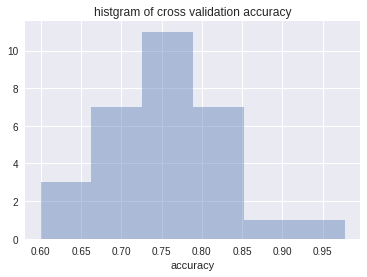

In [4]:
accs = np.array(mean_30_list)
accs = accs.reshape(-1)
# sns.set_style("ticks")
plt.title('histgram of cross validation accuracy')
plt.xlabel('accuracy')
sns.distplot(accs, kde=False);
plt.show()